2022년 7월까지의 데이터를 학습하고 8,9,10월의 데이터를 예측할것

In [1]:
import pandas as pd
import numpy as np
from haversine import haversine
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM
from tensorflow import keras
import numpy as np
from numpy import concatenate
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
import random
import itertools
from sklearn import linear_model

함수정의

In [2]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
  n_vars = 1 if type(data) is list else data.shape[1]
  df = pd.DataFrame(data)
  cols, names = list(), list()
  # input sequence (t-n, ... t-1)
  for i in range(n_in, 0, -1):
      cols.append(df.shift(i))
      names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
  # forecast sequence (t, t+1, ... t+n)
  for i in range(0, n_out):
      cols.append(df.shift(-i))
      if i == 0:
          names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
      else:
          names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
  # put it all together
  agg = pd.concat(cols, axis=1)
  agg.columns = names
  # drop rows with NaN values
  if dropnan:
      agg.dropna(inplace=True)
  return agg

In [3]:
#기준 아파트로부터 'near_range' km 내에 존재하는 아파트 코드 반환
def finding_near_apt(gizun,near_range):
    start = (float(gizun['GPS_Y']),float(gizun['GPS_X']))
    near_apts = []
    for j in df_range.index:
        goal = (float(df_range['GPS_Y'][j]),float(df_range['GPS_X'][j]))
        if haversine(start, goal) < near_range:
            near_apts.append(df_range['apart_code'][j])
    near_df = pd.DataFrame()
    near_df['apart_code'] = near_apts
    return near_df

In [4]:
#사용하지 않을 과거 데이터 제거(윈도우 사이즈가 3일경우)
def delete_unuse_var(reframed):
    var_count = int(len(reframed.columns)/4)
    reframed.drop(reframed.columns[var_count*2:(var_count*3) - 1], axis=1, inplace=True)
    reframed.drop(reframed.columns[var_count:(var_count*2) - 1], axis=1, inplace=True)
    reframed.drop(reframed.columns[0:var_count - 1], axis=1, inplace=True)
    return reframed

In [5]:
#데이터프레임에서 일정한 컬럼만 추출하고 값 형태로 반환
def get_float_values(df):
    df = df[['YYYYMM','sale_type', 'area_m3', 'floor', 'const_year', 
    'parking','building_year', 'market_dist','busstop_dist', 'subway_dist', 
    'kinder_dist', 'hospital_dist', 'ASPI','YYYY', 'MM', 'HAI', 'LIR', 'GDP', 'GDI', 
    'CPI','avg_interest', 'kospi', 'M2','near_element', 
    'near_middle', 'near_high', 'generation','const_rank','prices']]
    values = df.values
    values = values.astype('float32')
    return values

In [6]:
#코드들로부터 값을 추출하고 합치기
def get_from_codes(codes):
    for j in codes:
        df1 = globals()['df_'+j]
        values = get_float_values(df1)
        reframed = series_to_supervised(values, 3, 1)
        reframed = delete_unuse_var(reframed)
        global df_all
        df_all = pd.concat([reframed,df_all])
    return df_all

In [7]:
#추가하고 싶은 달을 입력
def make_future_data(new_month):
    global df
    new_df = df.drop_duplicates(['apart_code_area'])
    new_df['YYYYMM'] = 202200 + int(new_month)
    new_df['crime_rate'] = np.nan
    new_df['ASPI'] = np.nan
    new_df['YYYY'] = 2022
    new_df['MM'] = new_month
    new_df['HAI'] = np.nan
    new_df['PIR'] = np.nan
    new_df['LIR'] = np.nan
    new_df['GDP'] = np.nan
    new_df['GDI'] = np.nan
    new_df['GNI'] = np.nan
    new_df['CPI'] = np.nan
    new_df['avg_interest'] = np.nan
    new_df['kospi'] = np.nan
    new_df['M2'] = np.nan
    new_df['house_CCSI'] = np.nan
    new_df['unsold'] = np.nan
    #가격은 뭘로 할건지
    new_df['prices'] = 0 
    return new_df

In [8]:
def fill_nan(X_list,Y,df_a,df_pred):
    lin_reg = linear_model.LinearRegression()
    x = df_a.dropna(axis=0)[X_list]
    y = df_a.dropna(axis=0)[Y]
    lin_reg_model = lin_reg.fit(x,y)
    y_pred = lin_reg_model.predict(df_pred.loc[:, X_list])
    df_pred[Y] = np.where(df_pred[Y].isnull(),pd.Series(y_pred.flatten()),df_pred[Y])
    return df_pred

파일 읽기

In [9]:
df = pd.read_csv('final6.csv',encoding='cp949')

In [10]:
#결측값 제거
df = df[df['sale_type'].notna()]
df = df[df['parking'].notna()]
df = df[df['HAI'].notna()]
df = df[df['M2'].notna()]
#정성적변수 정량적 변수로 변환
df.loc[df['sale_type'] == '분양', 'sale_type'] = 0
df.loc[df['sale_type'] == '임대+분양', 'sale_type'] = 1
df.loc[df['sale_type'] == '임대', 'sale_type'] = 2
df.loc[df['sale_type'] == '영구임대', 'sale_type'] = 3
df['area_m3']=df['area_m3'].round(-1)
df = df.astype({'prices':'float64'})
df['prices']=df.groupby(['YYYYMM','apart_code','area_m3'])['prices'].transform('mean')
df['apart_code_area'] = df['apart_code'].map(str) +'_' +df['area_m3'].map(int).map(str)
df_a = df
exiting_code = df['apart_code'].unique()
df_vary = df.drop_duplicates(['apart_code'])
df_range = df_vary[['apart_code','GPS_X','GPS_Y']]
many_df = pd.read_csv('서울시아파트(기준).csv',encoding='cp949')
many_df = many_df[many_df['k-아파트코드'].isin(exiting_code)]

예측하고 싶은 값 추가

In [11]:
#df_prediction에 결측값 넣기
filling_list = ['ASPI','HAI', 'LIR', 'GDP', 'GDI', 'CPI','avg_interest', 'kospi', 'M2']

df_predction_8 = make_future_data(8)
for i in filling_list:
    df_predction_8 = fill_nan(['YYYYMM', 'YYYY', 'MM'],i,df_a,df_predction_8)
df_predction_8 = fill_nan(['YYYYMM', 'YYYY', 'MM'],'unsold',df_a,df_predction_8)

df_predction_9 = make_future_data(9)
for i in filling_list:
    df_predction_9 = fill_nan(['YYYYMM', 'YYYY', 'MM'],i,df_a,df_predction_9)
df_predction_9 = fill_nan(['YYYYMM', 'YYYY', 'MM'],'unsold',df_a,df_predction_9)

df_predction_10 = make_future_data(10)
for i in filling_list:
    df_predction_10 = fill_nan(['YYYYMM', 'YYYY', 'MM'],i,df_a,df_predction_10)
df_predction_10 = fill_nan(['YYYYMM', 'YYYY', 'MM'],'unsold',df_a,df_predction_10)

df_predction_11 = make_future_data(11)
for i in filling_list:
    df_predction_11 = fill_nan(['YYYYMM', 'YYYY', 'MM'],i,df_a,df_predction_11)
df_predction_11 = fill_nan(['YYYYMM', 'YYYY', 'MM'],'unsold',df_a,df_predction_11)

df_predction_12 = make_future_data(12)
for i in filling_list:
    df_predction_12 = fill_nan(['YYYYMM', 'YYYY', 'MM'],i,df_a,df_predction_12)
df_predction_12 = fill_nan(['YYYYMM', 'YYYY', 'MM'],'unsold',df_a,df_predction_12)

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

In [12]:
#df_prediction_8 과 df_all을 결합
df_a = pd.concat([df_a,df_predction_8], ignore_index=False)

실제로 돌아가는 모델

8월 추가

In [13]:
#6분정도 걸리는듯
#exiting_code = df['apart_code'].unique()
test_codes = random.sample(list(exiting_code),10)
for i in test_codes:
    gizun_code = i
    gizun = df_range[df_range['apart_code']==gizun_code]
    #변수 변경시 거리 조정
    near_df = finding_near_apt(gizun,2)
    near_df = pd.merge(near_df,many_df,left_on='apart_code',right_on='k-아파트코드',how='left')
    near_df = near_df[['apart_code','k-전체세대수']]
    gizun_count = near_df[near_df['apart_code']==gizun_code].iloc[0][1]
    indexNames = near_df[near_df['k-전체세대수'] < gizun_count].index
    near_df.drop(indexNames , inplace=True)
    df = df_a
    df = pd.merge(near_df,df,on='apart_code')
    df.pop('k-전체세대수')
    df = df.drop_duplicates(subset=['apart_code_area','YYYYMM'])
    df = df.sort_values(by=["apart_code_area", "YYYYMM"], ascending=[True, True])
    df = df[['apart_code_area', 'YYYYMM','sale_type', 'area_m3', 'floor', 'const_year', 
    'parking','building_year', 'market_dist','busstop_dist', 'subway_dist', 
    'kinder_dist', 'hospital_dist', 'ASPI','YYYY', 'MM', 'HAI', 'LIR', 'GDP', 'GDI', 
    'CPI','avg_interest', 'kospi', 'M2','near_element', 
    'near_middle', 'near_high', 'generation','const_rank','prices']]
    codes = df['apart_code_area'].unique()
    groups = df.groupby(df.apart_code_area)
    for j in codes:
        globals()['df_'+j] = groups.get_group(j)
    gizun_code_areas = df[df['apart_code_area'].str.contains(gizun_code)]['apart_code_area'].unique()
    for k in gizun_code_areas:
        gizun_code_area = k
        gizun_df = globals()['df_'+gizun_code_area]
        df_all = pd.DataFrame()
        deleted_code = 'df_'+gizun_code_area
        codes = np.delete(codes, np.where(codes == deleted_code))
        df_all = get_from_codes(codes)
        train_set = df_all[df_all['var1(t)']<=202207]
        df_test = gizun_df
        values = get_float_values(df_test)
        reframed = series_to_supervised(values, 3, 1)
        reframed = delete_unuse_var(reframed)
        #날짜를 사용해 df와 df_prediction_8 구분
        test_set = reframed[reframed['var1(t)']==202208]
        df_set = pd.concat([train_set,test_set])
        train_days =  len(train_set)
        values= df_set.values
        scaled = scaler.fit_transform(values)
        values = scaled
        train_days =  len(train_set)
        #테스트 데이터 얼마나 사용할 건지
        train = values[:train_days]
        test = values[train_days:]
        # split into input and outputs
        train_X, train_y = train[:, :-1], train[:, -1]
        test_X, test_y = test[:, :-1], test[:, -1]
        # reshape input to be 3D [samples, timesteps, features]
        train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
        test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
        model = Sequential()
        model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
        model.add(Dense(1))
        model.compile(loss='mae', optimizer='adam')
        history = model.fit(train_X, train_y, epochs=50, batch_size=72, 
                validation_data=(test_X, test_y), verbose=2, shuffle=False)
        # make a prediction
        try:
            yhat = model.predict(test_X)
            test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
            inv_yhat = concatenate((test_X[:, 0:],yhat), axis=1)
            # invert scaling for actual
            inv_yhat = scaler.inverse_transform(inv_yhat)
            inv_yhat = inv_yhat[:,-1]
            #만약 해당 값을 데이터 프레임에 넣고 싶다면
            df_a['prices'][(df_a['apart_code_area']==k)&(df_a['YYYYMM']==202208)] = float(inv_yhat[0])
        except:
            #만약 해당 아파트의 2020년 이후 거래내역이 존재하지 않을 경우 오류 발생
            print('오류 발생')
#df_a를 기본 df로 다시 변경
df = df_a 

Epoch 1/50
14/14 - 3s - loss: 0.2473 - val_loss: 0.5182 - 3s/epoch - 218ms/step
Epoch 2/50
14/14 - 0s - loss: 0.0754 - val_loss: 0.5192 - 138ms/epoch - 10ms/step
Epoch 3/50
14/14 - 0s - loss: 0.0537 - val_loss: 0.6848 - 85ms/epoch - 6ms/step
Epoch 4/50
14/14 - 0s - loss: 0.0533 - val_loss: 0.5942 - 85ms/epoch - 6ms/step
Epoch 5/50
14/14 - 0s - loss: 0.0482 - val_loss: 0.6267 - 78ms/epoch - 6ms/step
Epoch 6/50
14/14 - 0s - loss: 0.0379 - val_loss: 0.7421 - 78ms/epoch - 6ms/step
Epoch 7/50
14/14 - 0s - loss: 0.0490 - val_loss: 0.5800 - 87ms/epoch - 6ms/step
Epoch 8/50
14/14 - 0s - loss: 0.0686 - val_loss: 0.6582 - 80ms/epoch - 6ms/step
Epoch 9/50
14/14 - 0s - loss: 0.0389 - val_loss: 0.7438 - 97ms/epoch - 7ms/step
Epoch 10/50
14/14 - 0s - loss: 0.0474 - val_loss: 0.5705 - 92ms/epoch - 7ms/step
Epoch 11/50
14/14 - 0s - loss: 0.0609 - val_loss: 0.6750 - 84ms/epoch - 6ms/step
Epoch 12/50
14/14 - 0s - loss: 0.0294 - val_loss: 0.7124 - 90ms/epoch - 6ms/step
Epoch 13/50
14/14 - 0s - loss: 0.03

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
14/14 - 3s - loss: 0.1444 - val_loss: 0.8004 - 3s/epoch - 203ms/step
Epoch 2/50
14/14 - 0s - loss: 0.0763 - val_loss: 0.6614 - 162ms/epoch - 12ms/step
Epoch 3/50
14/14 - 0s - loss: 0.0437 - val_loss: 0.7442 - 83ms/epoch - 6ms/step
Epoch 4/50
14/14 - 0s - loss: 0.0408 - val_loss: 0.7527 - 82ms/epoch - 6ms/step
Epoch 5/50
14/14 - 0s - loss: 0.0357 - val_loss: 0.7111 - 86ms/epoch - 6ms/step
Epoch 6/50
14/14 - 0s - loss: 0.0358 - val_loss: 0.7882 - 83ms/epoch - 6ms/step
Epoch 7/50
14/14 - 0s - loss: 0.0392 - val_loss: 0.8817 - 75ms/epoch - 5ms/step
Epoch 8/50
14/14 - 0s - loss: 0.0515 - val_loss: 0.6058 - 78ms/epoch - 6ms/step
Epoch 9/50
14/14 - 0s - loss: 0.0877 - val_loss: 0.8488 - 79ms/epoch - 6ms/step
Epoch 10/50
14/14 - 0s - loss: 0.0470 - val_loss: 0.7487 - 84ms/epoch - 6ms/step
Epoch 11/50
14/14 - 0s - loss: 0.0397 - val_loss: 0.6794 - 82ms/epoch - 6ms/step
Epoch 12/50
14/14 - 0s - loss: 0.0448 - val_loss: 0.8654 - 86ms/epoch - 6ms/step
Epoch 13/50
14/14 - 0s - loss: 0.06

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
14/14 - 3s - loss: 0.1579 - val_loss: 0.4972 - 3s/epoch - 206ms/step
Epoch 2/50
14/14 - 0s - loss: 0.1142 - val_loss: 0.5917 - 81ms/epoch - 6ms/step
Epoch 3/50
14/14 - 0s - loss: 0.0772 - val_loss: 0.5240 - 80ms/epoch - 6ms/step
Epoch 4/50
14/14 - 0s - loss: 0.0493 - val_loss: 0.5749 - 77ms/epoch - 6ms/step
Epoch 5/50
14/14 - 0s - loss: 0.0395 - val_loss: 0.5048 - 83ms/epoch - 6ms/step
Epoch 6/50
14/14 - 0s - loss: 0.0443 - val_loss: 0.4936 - 81ms/epoch - 6ms/step
Epoch 7/50
14/14 - 0s - loss: 0.0357 - val_loss: 0.6466 - 78ms/epoch - 6ms/step
Epoch 8/50
14/14 - 0s - loss: 0.0692 - val_loss: 0.4707 - 82ms/epoch - 6ms/step
Epoch 9/50
14/14 - 0s - loss: 0.0593 - val_loss: 0.5141 - 78ms/epoch - 6ms/step
Epoch 10/50
14/14 - 0s - loss: 0.0441 - val_loss: 0.5903 - 80ms/epoch - 6ms/step
Epoch 11/50
14/14 - 0s - loss: 0.0404 - val_loss: 0.4587 - 77ms/epoch - 5ms/step
Epoch 12/50
14/14 - 0s - loss: 0.0585 - val_loss: 0.5460 - 81ms/epoch - 6ms/step
Epoch 13/50
14/14 - 0s - loss: 0.0338

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
14/14 - 3s - loss: 0.2464 - val_loss: 0.5043 - 3s/epoch - 210ms/step
Epoch 2/50
14/14 - 0s - loss: 0.0963 - val_loss: 0.5967 - 142ms/epoch - 10ms/step
Epoch 3/50
14/14 - 0s - loss: 0.0550 - val_loss: 0.5873 - 83ms/epoch - 6ms/step
Epoch 4/50
14/14 - 0s - loss: 0.0437 - val_loss: 0.6557 - 84ms/epoch - 6ms/step
Epoch 5/50
14/14 - 0s - loss: 0.0377 - val_loss: 0.6748 - 97ms/epoch - 7ms/step
Epoch 6/50
14/14 - 0s - loss: 0.0349 - val_loss: 0.6065 - 88ms/epoch - 6ms/step
Epoch 7/50
14/14 - 0s - loss: 0.0418 - val_loss: 0.6485 - 80ms/epoch - 6ms/step
Epoch 8/50
14/14 - 0s - loss: 0.0354 - val_loss: 0.7625 - 81ms/epoch - 6ms/step
Epoch 9/50
14/14 - 0s - loss: 0.0554 - val_loss: 0.5605 - 76ms/epoch - 5ms/step
Epoch 10/50
14/14 - 0s - loss: 0.0645 - val_loss: 0.6724 - 80ms/epoch - 6ms/step
Epoch 11/50
14/14 - 0s - loss: 0.0354 - val_loss: 0.6954 - 77ms/epoch - 6ms/step
Epoch 12/50
14/14 - 0s - loss: 0.0431 - val_loss: 0.5466 - 83ms/epoch - 6ms/step
Epoch 13/50
14/14 - 0s - loss: 0.05

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
75/75 - 2s - loss: 0.0633 - 2s/epoch - 33ms/step
Epoch 2/50
75/75 - 0s - loss: 0.0455 - 336ms/epoch - 4ms/step
Epoch 3/50
75/75 - 0s - loss: 0.0310 - 257ms/epoch - 3ms/step
Epoch 4/50
75/75 - 0s - loss: 0.0302 - 263ms/epoch - 4ms/step
Epoch 5/50
75/75 - 0s - loss: 0.0290 - 250ms/epoch - 3ms/step
Epoch 6/50
75/75 - 0s - loss: 0.0223 - 266ms/epoch - 4ms/step
Epoch 7/50
75/75 - 0s - loss: 0.0287 - 275ms/epoch - 4ms/step
Epoch 8/50
75/75 - 0s - loss: 0.0219 - 281ms/epoch - 4ms/step
Epoch 9/50
75/75 - 0s - loss: 0.0384 - 269ms/epoch - 4ms/step
Epoch 10/50
75/75 - 0s - loss: 0.0178 - 291ms/epoch - 4ms/step
Epoch 11/50
75/75 - 0s - loss: 0.0311 - 352ms/epoch - 5ms/step
Epoch 12/50
75/75 - 0s - loss: 0.0207 - 255ms/epoch - 3ms/step
Epoch 13/50
75/75 - 0s - loss: 0.0223 - 257ms/epoch - 3ms/step
Epoch 14/50
75/75 - 0s - loss: 0.0181 - 269ms/epoch - 4ms/step
Epoch 15/50
75/75 - 0s - loss: 0.0186 - 292ms/epoch - 4ms/step
Epoch 16/50
75/75 - 0s - loss: 0.0175 - 270ms/epoch - 4ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
75/75 - 3s - loss: 0.0580 - val_loss: 0.3069 - 3s/epoch - 44ms/step
Epoch 2/50
75/75 - 0s - loss: 0.0383 - val_loss: 0.3735 - 276ms/epoch - 4ms/step
Epoch 3/50
75/75 - 0s - loss: 0.0358 - val_loss: 0.3385 - 289ms/epoch - 4ms/step
Epoch 4/50
75/75 - 0s - loss: 0.0239 - val_loss: 0.3480 - 286ms/epoch - 4ms/step
Epoch 5/50
75/75 - 0s - loss: 0.0315 - val_loss: 0.3329 - 287ms/epoch - 4ms/step
Epoch 6/50
75/75 - 0s - loss: 0.0339 - val_loss: 0.2865 - 299ms/epoch - 4ms/step
Epoch 7/50
75/75 - 0s - loss: 0.0264 - val_loss: 0.3278 - 281ms/epoch - 4ms/step
Epoch 8/50
75/75 - 0s - loss: 0.0193 - val_loss: 0.4133 - 301ms/epoch - 4ms/step
Epoch 9/50
75/75 - 0s - loss: 0.0371 - val_loss: 0.3633 - 275ms/epoch - 4ms/step
Epoch 10/50
75/75 - 0s - loss: 0.0214 - val_loss: 0.3893 - 297ms/epoch - 4ms/step
Epoch 11/50
75/75 - 0s - loss: 0.0255 - val_loss: 0.3136 - 270ms/epoch - 4ms/step
Epoch 12/50
75/75 - 0s - loss: 0.0204 - val_loss: 0.3815 - 274ms/epoch - 4ms/step
Epoch 13/50
75/75 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
75/75 - 3s - loss: 0.0609 - 3s/epoch - 36ms/step
Epoch 2/50
75/75 - 0s - loss: 0.0365 - 267ms/epoch - 4ms/step
Epoch 3/50
75/75 - 0s - loss: 0.0332 - 271ms/epoch - 4ms/step
Epoch 4/50
75/75 - 0s - loss: 0.0322 - 286ms/epoch - 4ms/step
Epoch 5/50
75/75 - 0s - loss: 0.0276 - 275ms/epoch - 4ms/step
Epoch 6/50
75/75 - 0s - loss: 0.0208 - 261ms/epoch - 3ms/step
Epoch 7/50
75/75 - 0s - loss: 0.0192 - 261ms/epoch - 3ms/step
Epoch 8/50
75/75 - 0s - loss: 0.0281 - 270ms/epoch - 4ms/step
Epoch 9/50
75/75 - 0s - loss: 0.0224 - 269ms/epoch - 4ms/step
Epoch 10/50
75/75 - 0s - loss: 0.0216 - 292ms/epoch - 4ms/step
Epoch 11/50
75/75 - 0s - loss: 0.0193 - 282ms/epoch - 4ms/step
Epoch 12/50
75/75 - 0s - loss: 0.0193 - 270ms/epoch - 4ms/step
Epoch 13/50
75/75 - 0s - loss: 0.0188 - 269ms/epoch - 4ms/step
Epoch 14/50
75/75 - 0s - loss: 0.0185 - 273ms/epoch - 4ms/step
Epoch 15/50
75/75 - 0s - loss: 0.0173 - 300ms/epoch - 4ms/step
Epoch 16/50
75/75 - 0s - loss: 0.0188 - 260ms/epoch - 3ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
75/75 - 4s - loss: 0.0644 - val_loss: 0.4610 - 4s/epoch - 48ms/step
Epoch 2/50
75/75 - 0s - loss: 0.0458 - val_loss: 0.4746 - 292ms/epoch - 4ms/step
Epoch 3/50
75/75 - 0s - loss: 0.0362 - val_loss: 0.5175 - 343ms/epoch - 5ms/step
Epoch 4/50
75/75 - 0s - loss: 0.0244 - val_loss: 0.5316 - 271ms/epoch - 4ms/step
Epoch 5/50
75/75 - 0s - loss: 0.0249 - val_loss: 0.5687 - 270ms/epoch - 4ms/step
Epoch 6/50
75/75 - 0s - loss: 0.0393 - val_loss: 0.5912 - 304ms/epoch - 4ms/step
Epoch 7/50
75/75 - 0s - loss: 0.0241 - val_loss: 0.6150 - 289ms/epoch - 4ms/step
Epoch 8/50
75/75 - 0s - loss: 0.0342 - val_loss: 0.6178 - 288ms/epoch - 4ms/step
Epoch 9/50
75/75 - 0s - loss: 0.0200 - val_loss: 0.6174 - 347ms/epoch - 5ms/step
Epoch 10/50
75/75 - 0s - loss: 0.0295 - val_loss: 0.6064 - 319ms/epoch - 4ms/step
Epoch 11/50
75/75 - 0s - loss: 0.0194 - val_loss: 0.6226 - 268ms/epoch - 4ms/step
Epoch 12/50
75/75 - 0s - loss: 0.0251 - val_loss: 0.5947 - 307ms/epoch - 4ms/step
Epoch 13/50
75/75 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
75/75 - 3s - loss: 0.0645 - 3s/epoch - 36ms/step
Epoch 2/50
75/75 - 0s - loss: 0.0378 - 275ms/epoch - 4ms/step
Epoch 3/50
75/75 - 0s - loss: 0.0277 - 262ms/epoch - 3ms/step
Epoch 4/50
75/75 - 0s - loss: 0.0271 - 263ms/epoch - 4ms/step
Epoch 5/50
75/75 - 0s - loss: 0.0264 - 265ms/epoch - 4ms/step
Epoch 6/50
75/75 - 0s - loss: 0.0265 - 268ms/epoch - 4ms/step
Epoch 7/50
75/75 - 0s - loss: 0.0360 - 265ms/epoch - 4ms/step
Epoch 8/50
75/75 - 0s - loss: 0.0283 - 262ms/epoch - 3ms/step
Epoch 9/50
75/75 - 0s - loss: 0.0265 - 277ms/epoch - 4ms/step
Epoch 10/50
75/75 - 0s - loss: 0.0195 - 271ms/epoch - 4ms/step
Epoch 11/50
75/75 - 0s - loss: 0.0316 - 287ms/epoch - 4ms/step
Epoch 12/50
75/75 - 0s - loss: 0.0225 - 283ms/epoch - 4ms/step
Epoch 13/50
75/75 - 0s - loss: 0.0301 - 281ms/epoch - 4ms/step
Epoch 14/50
75/75 - 0s - loss: 0.0192 - 274ms/epoch - 4ms/step
Epoch 15/50
75/75 - 0s - loss: 0.0272 - 270ms/epoch - 4ms/step
Epoch 16/50
75/75 - 0s - loss: 0.0184 - 281ms/epoch - 4ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
75/75 - 3s - loss: 0.0725 - 3s/epoch - 36ms/step
Epoch 2/50
75/75 - 0s - loss: 0.0375 - 285ms/epoch - 4ms/step
Epoch 3/50
75/75 - 0s - loss: 0.0363 - 264ms/epoch - 4ms/step
Epoch 4/50
75/75 - 0s - loss: 0.0459 - 262ms/epoch - 3ms/step
Epoch 5/50
75/75 - 0s - loss: 0.0208 - 269ms/epoch - 4ms/step
Epoch 6/50
75/75 - 0s - loss: 0.0317 - 274ms/epoch - 4ms/step
Epoch 7/50
75/75 - 0s - loss: 0.0252 - 268ms/epoch - 4ms/step
Epoch 8/50
75/75 - 0s - loss: 0.0216 - 261ms/epoch - 3ms/step
Epoch 9/50
75/75 - 0s - loss: 0.0227 - 268ms/epoch - 4ms/step
Epoch 10/50
75/75 - 0s - loss: 0.0361 - 263ms/epoch - 4ms/step
Epoch 11/50
75/75 - 0s - loss: 0.0202 - 257ms/epoch - 3ms/step
Epoch 12/50
75/75 - 0s - loss: 0.0215 - 266ms/epoch - 4ms/step
Epoch 13/50
75/75 - 0s - loss: 0.0191 - 294ms/epoch - 4ms/step
Epoch 14/50
75/75 - 0s - loss: 0.0212 - 260ms/epoch - 3ms/step
Epoch 15/50
75/75 - 0s - loss: 0.0317 - 257ms/epoch - 3ms/step
Epoch 16/50
75/75 - 0s - loss: 0.0190 - 259ms/epoch - 3ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
15/15 - 3s - loss: 0.0765 - val_loss: 0.5588 - 3s/epoch - 193ms/step
Epoch 2/50
15/15 - 0s - loss: 0.1245 - val_loss: 0.4319 - 139ms/epoch - 9ms/step
Epoch 3/50
15/15 - 0s - loss: 0.0535 - val_loss: 0.4980 - 85ms/epoch - 6ms/step
Epoch 4/50
15/15 - 0s - loss: 0.0537 - val_loss: 0.4478 - 84ms/epoch - 6ms/step
Epoch 5/50
15/15 - 0s - loss: 0.0404 - val_loss: 0.4544 - 79ms/epoch - 5ms/step
Epoch 6/50
15/15 - 0s - loss: 0.0383 - val_loss: 0.5295 - 84ms/epoch - 6ms/step
Epoch 7/50
15/15 - 0s - loss: 0.0504 - val_loss: 0.5533 - 81ms/epoch - 5ms/step
Epoch 8/50
15/15 - 0s - loss: 0.0509 - val_loss: 0.4413 - 83ms/epoch - 6ms/step
Epoch 9/50
15/15 - 0s - loss: 0.0410 - val_loss: 0.4459 - 84ms/epoch - 6ms/step
Epoch 10/50
15/15 - 0s - loss: 0.0345 - val_loss: 0.5157 - 102ms/epoch - 7ms/step
Epoch 11/50
15/15 - 0s - loss: 0.0412 - val_loss: 0.5832 - 87ms/epoch - 6ms/step
Epoch 12/50
15/15 - 0s - loss: 0.0555 - val_loss: 0.4797 - 84ms/epoch - 6ms/step
Epoch 13/50
15/15 - 0s - loss: 0.02

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
15/15 - 3s - loss: 0.2062 - val_loss: 0.5421 - 3s/epoch - 208ms/step
Epoch 2/50
15/15 - 0s - loss: 0.1193 - val_loss: 0.4601 - 162ms/epoch - 11ms/step
Epoch 3/50
15/15 - 0s - loss: 0.0728 - val_loss: 0.4798 - 91ms/epoch - 6ms/step
Epoch 4/50
15/15 - 0s - loss: 0.0571 - val_loss: 0.4857 - 85ms/epoch - 6ms/step
Epoch 5/50
15/15 - 0s - loss: 0.0454 - val_loss: 0.5154 - 89ms/epoch - 6ms/step
Epoch 6/50
15/15 - 0s - loss: 0.0413 - val_loss: 0.5717 - 86ms/epoch - 6ms/step
Epoch 7/50
15/15 - 0s - loss: 0.0389 - val_loss: 0.5745 - 87ms/epoch - 6ms/step
Epoch 8/50
15/15 - 0s - loss: 0.0392 - val_loss: 0.4996 - 93ms/epoch - 6ms/step
Epoch 9/50
15/15 - 0s - loss: 0.0365 - val_loss: 0.4519 - 89ms/epoch - 6ms/step
Epoch 10/50
15/15 - 0s - loss: 0.0563 - val_loss: 0.5796 - 87ms/epoch - 6ms/step
Epoch 11/50
15/15 - 0s - loss: 0.0400 - val_loss: 0.5841 - 89ms/epoch - 6ms/step
Epoch 12/50
15/15 - 0s - loss: 0.0370 - val_loss: 0.4958 - 92ms/epoch - 6ms/step
Epoch 13/50
15/15 - 0s - loss: 0.04

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
15/15 - 3s - loss: 0.0811 - val_loss: 0.5197 - 3s/epoch - 198ms/step
Epoch 2/50
15/15 - 0s - loss: 0.0621 - val_loss: 0.6774 - 156ms/epoch - 10ms/step
Epoch 3/50
15/15 - 0s - loss: 0.0602 - val_loss: 0.6222 - 115ms/epoch - 8ms/step
Epoch 4/50
15/15 - 0s - loss: 0.0377 - val_loss: 0.5434 - 91ms/epoch - 6ms/step
Epoch 5/50
15/15 - 0s - loss: 0.0530 - val_loss: 0.6045 - 80ms/epoch - 5ms/step
Epoch 6/50
15/15 - 0s - loss: 0.0465 - val_loss: 0.7153 - 84ms/epoch - 6ms/step
Epoch 7/50
15/15 - 0s - loss: 0.0576 - val_loss: 0.6418 - 92ms/epoch - 6ms/step
Epoch 8/50
15/15 - 0s - loss: 0.0350 - val_loss: 0.5808 - 85ms/epoch - 6ms/step
Epoch 9/50
15/15 - 0s - loss: 0.0430 - val_loss: 0.6201 - 89ms/epoch - 6ms/step
Epoch 10/50
15/15 - 0s - loss: 0.0367 - val_loss: 0.7160 - 90ms/epoch - 6ms/step
Epoch 11/50
15/15 - 0s - loss: 0.0480 - val_loss: 0.6932 - 88ms/epoch - 6ms/step
Epoch 12/50
15/15 - 0s - loss: 0.0357 - val_loss: 0.6154 - 90ms/epoch - 6ms/step
Epoch 13/50
15/15 - 0s - loss: 0.0

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
15/15 - 3s - loss: 0.0774 - val_loss: 0.6065 - 3s/epoch - 201ms/step
Epoch 2/50
15/15 - 0s - loss: 0.1300 - val_loss: 0.4571 - 165ms/epoch - 11ms/step
Epoch 3/50
15/15 - 0s - loss: 0.0485 - val_loss: 0.5731 - 85ms/epoch - 6ms/step
Epoch 4/50
15/15 - 0s - loss: 0.0656 - val_loss: 0.4691 - 94ms/epoch - 6ms/step
Epoch 5/50
15/15 - 0s - loss: 0.0420 - val_loss: 0.4992 - 91ms/epoch - 6ms/step
Epoch 6/50
15/15 - 0s - loss: 0.0396 - val_loss: 0.5788 - 84ms/epoch - 6ms/step
Epoch 7/50
15/15 - 0s - loss: 0.0490 - val_loss: 0.5785 - 83ms/epoch - 6ms/step
Epoch 8/50
15/15 - 0s - loss: 0.0434 - val_loss: 0.4857 - 84ms/epoch - 6ms/step
Epoch 9/50
15/15 - 0s - loss: 0.0427 - val_loss: 0.5058 - 88ms/epoch - 6ms/step
Epoch 10/50
15/15 - 0s - loss: 0.0313 - val_loss: 0.5636 - 88ms/epoch - 6ms/step
Epoch 11/50
15/15 - 0s - loss: 0.0376 - val_loss: 0.6340 - 86ms/epoch - 6ms/step
Epoch 12/50
15/15 - 0s - loss: 0.0499 - val_loss: 0.5590 - 121ms/epoch - 8ms/step
Epoch 13/50
15/15 - 0s - loss: 0.0

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
12/12 - 3s - loss: 0.1577 - val_loss: 0.4624 - 3s/epoch - 284ms/step
Epoch 2/50
12/12 - 0s - loss: 0.0990 - val_loss: 0.4640 - 74ms/epoch - 6ms/step
Epoch 3/50
12/12 - 0s - loss: 0.0694 - val_loss: 0.4752 - 76ms/epoch - 6ms/step
Epoch 4/50
12/12 - 0s - loss: 0.0531 - val_loss: 0.5072 - 83ms/epoch - 7ms/step
Epoch 5/50
12/12 - 0s - loss: 0.0450 - val_loss: 0.5202 - 72ms/epoch - 6ms/step
Epoch 6/50
12/12 - 0s - loss: 0.0383 - val_loss: 0.5114 - 74ms/epoch - 6ms/step
Epoch 7/50
12/12 - 0s - loss: 0.0326 - val_loss: 0.4853 - 72ms/epoch - 6ms/step
Epoch 8/50
12/12 - 0s - loss: 0.0297 - val_loss: 0.4773 - 75ms/epoch - 6ms/step
Epoch 9/50
12/12 - 0s - loss: 0.0272 - val_loss: 0.5019 - 77ms/epoch - 6ms/step
Epoch 10/50
12/12 - 0s - loss: 0.0359 - val_loss: 0.5381 - 75ms/epoch - 6ms/step
Epoch 11/50
12/12 - 0s - loss: 0.0359 - val_loss: 0.4547 - 76ms/epoch - 6ms/step
Epoch 12/50
12/12 - 0s - loss: 0.0784 - val_loss: 0.4610 - 74ms/epoch - 6ms/step
Epoch 13/50
12/12 - 0s - loss: 0.0472

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
12/12 - 3s - loss: 0.1485 - val_loss: 0.3059 - 3s/epoch - 258ms/step
Epoch 2/50
12/12 - 0s - loss: 0.1071 - val_loss: 0.3467 - 158ms/epoch - 13ms/step
Epoch 3/50
12/12 - 0s - loss: 0.0663 - val_loss: 0.4870 - 77ms/epoch - 6ms/step
Epoch 4/50
12/12 - 0s - loss: 0.0550 - val_loss: 0.5373 - 74ms/epoch - 6ms/step
Epoch 5/50
12/12 - 0s - loss: 0.0474 - val_loss: 0.5457 - 77ms/epoch - 6ms/step
Epoch 6/50
12/12 - 0s - loss: 0.0420 - val_loss: 0.5309 - 75ms/epoch - 6ms/step
Epoch 7/50
12/12 - 0s - loss: 0.0361 - val_loss: 0.5373 - 75ms/epoch - 6ms/step
Epoch 8/50
12/12 - 0s - loss: 0.0297 - val_loss: 0.5497 - 80ms/epoch - 7ms/step
Epoch 9/50
12/12 - 0s - loss: 0.0259 - val_loss: 0.5430 - 75ms/epoch - 6ms/step
Epoch 10/50
12/12 - 0s - loss: 0.0243 - val_loss: 0.5352 - 74ms/epoch - 6ms/step
Epoch 11/50
12/12 - 0s - loss: 0.0263 - val_loss: 0.5554 - 76ms/epoch - 6ms/step
Epoch 12/50
12/12 - 0s - loss: 0.0369 - val_loss: 0.6715 - 79ms/epoch - 7ms/step
Epoch 13/50
12/12 - 0s - loss: 0.08

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
12/12 - 3s - loss: 0.1286 - val_loss: 0.5906 - 3s/epoch - 247ms/step
Epoch 2/50
12/12 - 0s - loss: 0.0974 - val_loss: 0.5448 - 82ms/epoch - 7ms/step
Epoch 3/50
12/12 - 0s - loss: 0.0685 - val_loss: 0.5755 - 85ms/epoch - 7ms/step
Epoch 4/50
12/12 - 0s - loss: 0.0610 - val_loss: 0.6283 - 70ms/epoch - 6ms/step
Epoch 5/50
12/12 - 0s - loss: 0.0557 - val_loss: 0.6345 - 70ms/epoch - 6ms/step
Epoch 6/50
12/12 - 0s - loss: 0.0508 - val_loss: 0.6498 - 80ms/epoch - 7ms/step
Epoch 7/50
12/12 - 0s - loss: 0.0450 - val_loss: 0.6526 - 70ms/epoch - 6ms/step
Epoch 8/50
12/12 - 0s - loss: 0.0402 - val_loss: 0.6560 - 74ms/epoch - 6ms/step
Epoch 9/50
12/12 - 0s - loss: 0.0353 - val_loss: 0.6616 - 70ms/epoch - 6ms/step
Epoch 10/50
12/12 - 0s - loss: 0.0308 - val_loss: 0.6600 - 76ms/epoch - 6ms/step
Epoch 11/50
12/12 - 0s - loss: 0.0281 - val_loss: 0.6621 - 86ms/epoch - 7ms/step
Epoch 12/50
12/12 - 0s - loss: 0.0260 - val_loss: 0.6744 - 84ms/epoch - 7ms/step
Epoch 13/50
12/12 - 0s - loss: 0.0258

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
70/70 - 3s - loss: 0.1037 - 3s/epoch - 39ms/step
Epoch 2/50
70/70 - 0s - loss: 0.0618 - 262ms/epoch - 4ms/step
Epoch 3/50
70/70 - 0s - loss: 0.0450 - 259ms/epoch - 4ms/step
Epoch 4/50
70/70 - 0s - loss: 0.0305 - 243ms/epoch - 3ms/step
Epoch 5/50
70/70 - 0s - loss: 0.0267 - 249ms/epoch - 4ms/step
Epoch 6/50
70/70 - 0s - loss: 0.0224 - 261ms/epoch - 4ms/step
Epoch 7/50
70/70 - 0s - loss: 0.0248 - 249ms/epoch - 4ms/step
Epoch 8/50
70/70 - 0s - loss: 0.0247 - 255ms/epoch - 4ms/step
Epoch 9/50
70/70 - 0s - loss: 0.0353 - 254ms/epoch - 4ms/step
Epoch 10/50
70/70 - 0s - loss: 0.0461 - 272ms/epoch - 4ms/step
Epoch 11/50
70/70 - 0s - loss: 0.0428 - 335ms/epoch - 5ms/step
Epoch 12/50
70/70 - 0s - loss: 0.0339 - 334ms/epoch - 5ms/step
Epoch 13/50
70/70 - 0s - loss: 0.0248 - 280ms/epoch - 4ms/step
Epoch 14/50
70/70 - 0s - loss: 0.0208 - 261ms/epoch - 4ms/step
Epoch 15/50
70/70 - 0s - loss: 0.0202 - 260ms/epoch - 4ms/step
Epoch 16/50
70/70 - 0s - loss: 0.0196 - 262ms/epoch - 4ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
70/70 - 3s - loss: 0.1113 - 3s/epoch - 39ms/step
Epoch 2/50
70/70 - 0s - loss: 0.0653 - 270ms/epoch - 4ms/step
Epoch 3/50
70/70 - 0s - loss: 0.0382 - 278ms/epoch - 4ms/step
Epoch 4/50
70/70 - 0s - loss: 0.0308 - 275ms/epoch - 4ms/step
Epoch 5/50
70/70 - 0s - loss: 0.0276 - 273ms/epoch - 4ms/step
Epoch 6/50
70/70 - 0s - loss: 0.0252 - 244ms/epoch - 3ms/step
Epoch 7/50
70/70 - 0s - loss: 0.0250 - 250ms/epoch - 4ms/step
Epoch 8/50
70/70 - 0s - loss: 0.0345 - 250ms/epoch - 4ms/step
Epoch 9/50
70/70 - 0s - loss: 0.0555 - 272ms/epoch - 4ms/step
Epoch 10/50
70/70 - 0s - loss: 0.0413 - 259ms/epoch - 4ms/step
Epoch 11/50
70/70 - 0s - loss: 0.0309 - 261ms/epoch - 4ms/step
Epoch 12/50
70/70 - 0s - loss: 0.0254 - 256ms/epoch - 4ms/step
Epoch 13/50
70/70 - 0s - loss: 0.0214 - 271ms/epoch - 4ms/step
Epoch 14/50
70/70 - 0s - loss: 0.0196 - 261ms/epoch - 4ms/step
Epoch 15/50
70/70 - 0s - loss: 0.0201 - 249ms/epoch - 4ms/step
Epoch 16/50
70/70 - 0s - loss: 0.0211 - 248ms/epoch - 4ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
49/49 - 4s - loss: 0.1039 - val_loss: 0.4030 - 4s/epoch - 75ms/step
Epoch 2/50
49/49 - 0s - loss: 0.0600 - val_loss: 0.4596 - 195ms/epoch - 4ms/step
Epoch 3/50
49/49 - 0s - loss: 0.0433 - val_loss: 0.5135 - 195ms/epoch - 4ms/step
Epoch 4/50
49/49 - 0s - loss: 0.0390 - val_loss: 0.5838 - 202ms/epoch - 4ms/step
Epoch 5/50
49/49 - 0s - loss: 0.0356 - val_loss: 0.5885 - 191ms/epoch - 4ms/step
Epoch 6/50
49/49 - 0s - loss: 0.0444 - val_loss: 0.6154 - 208ms/epoch - 4ms/step
Epoch 7/50
49/49 - 0s - loss: 0.0334 - val_loss: 0.5687 - 205ms/epoch - 4ms/step
Epoch 8/50
49/49 - 0s - loss: 0.0300 - val_loss: 0.4726 - 191ms/epoch - 4ms/step
Epoch 9/50
49/49 - 0s - loss: 0.0479 - val_loss: 0.4183 - 194ms/epoch - 4ms/step
Epoch 10/50
49/49 - 0s - loss: 0.0628 - val_loss: 0.5046 - 235ms/epoch - 5ms/step
Epoch 11/50
49/49 - 0s - loss: 0.0393 - val_loss: 0.4733 - 271ms/epoch - 6ms/step
Epoch 12/50
49/49 - 0s - loss: 0.0329 - val_loss: 0.4765 - 198ms/epoch - 4ms/step
Epoch 13/50
49/49 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
49/49 - 3s - loss: 0.0985 - val_loss: 0.4269 - 3s/epoch - 65ms/step
Epoch 2/50
49/49 - 0s - loss: 0.0597 - val_loss: 0.4125 - 282ms/epoch - 6ms/step
Epoch 3/50
49/49 - 0s - loss: 0.0478 - val_loss: 0.4246 - 206ms/epoch - 4ms/step
Epoch 4/50
49/49 - 0s - loss: 0.0399 - val_loss: 0.4416 - 222ms/epoch - 5ms/step
Epoch 5/50
49/49 - 0s - loss: 0.0368 - val_loss: 0.4677 - 198ms/epoch - 4ms/step
Epoch 6/50
49/49 - 0s - loss: 0.0467 - val_loss: 0.5031 - 206ms/epoch - 4ms/step
Epoch 7/50
49/49 - 0s - loss: 0.0477 - val_loss: 0.3905 - 202ms/epoch - 4ms/step
Epoch 8/50
49/49 - 0s - loss: 0.0441 - val_loss: 0.3349 - 243ms/epoch - 5ms/step
Epoch 9/50
49/49 - 0s - loss: 0.0576 - val_loss: 0.3676 - 280ms/epoch - 6ms/step
Epoch 10/50
49/49 - 0s - loss: 0.0481 - val_loss: 0.3776 - 294ms/epoch - 6ms/step
Epoch 11/50
49/49 - 0s - loss: 0.0348 - val_loss: 0.3695 - 213ms/epoch - 4ms/step
Epoch 12/50
49/49 - 0s - loss: 0.0309 - val_loss: 0.3624 - 217ms/epoch - 4ms/step
Epoch 13/50
49/49 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
49/49 - 3s - loss: 0.1203 - val_loss: 0.3915 - 3s/epoch - 61ms/step
Epoch 2/50
49/49 - 0s - loss: 0.0608 - val_loss: 0.3382 - 203ms/epoch - 4ms/step
Epoch 3/50
49/49 - 0s - loss: 0.0463 - val_loss: 0.3091 - 195ms/epoch - 4ms/step
Epoch 4/50
49/49 - 0s - loss: 0.0375 - val_loss: 0.3051 - 211ms/epoch - 4ms/step
Epoch 5/50
49/49 - 0s - loss: 0.0351 - val_loss: 0.3339 - 210ms/epoch - 4ms/step
Epoch 6/50
49/49 - 0s - loss: 0.0319 - val_loss: 0.3435 - 228ms/epoch - 5ms/step
Epoch 7/50
49/49 - 0s - loss: 0.0555 - val_loss: 0.3925 - 231ms/epoch - 5ms/step
Epoch 8/50
49/49 - 0s - loss: 0.0590 - val_loss: 0.3313 - 234ms/epoch - 5ms/step
Epoch 9/50
49/49 - 0s - loss: 0.0325 - val_loss: 0.3012 - 247ms/epoch - 5ms/step
Epoch 10/50
49/49 - 0s - loss: 0.0281 - val_loss: 0.2597 - 239ms/epoch - 5ms/step
Epoch 11/50
49/49 - 0s - loss: 0.0253 - val_loss: 0.2328 - 244ms/epoch - 5ms/step
Epoch 12/50
49/49 - 0s - loss: 0.0227 - val_loss: 0.2170 - 233ms/epoch - 5ms/step
Epoch 13/50
49/49 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
49/49 - 4s - loss: 0.1117 - val_loss: 0.4091 - 4s/epoch - 75ms/step
Epoch 2/50
49/49 - 0s - loss: 0.0656 - val_loss: 0.3994 - 261ms/epoch - 5ms/step
Epoch 3/50
49/49 - 0s - loss: 0.0493 - val_loss: 0.4324 - 222ms/epoch - 5ms/step
Epoch 4/50
49/49 - 0s - loss: 0.0392 - val_loss: 0.4578 - 206ms/epoch - 4ms/step
Epoch 5/50
49/49 - 0s - loss: 0.0335 - val_loss: 0.4799 - 210ms/epoch - 4ms/step
Epoch 6/50
49/49 - 0s - loss: 0.0312 - val_loss: 0.4806 - 259ms/epoch - 5ms/step
Epoch 7/50
49/49 - 0s - loss: 0.0397 - val_loss: 0.4885 - 308ms/epoch - 6ms/step
Epoch 8/50
49/49 - 0s - loss: 0.0385 - val_loss: 0.5355 - 305ms/epoch - 6ms/step
Epoch 9/50
49/49 - 0s - loss: 0.0400 - val_loss: 0.5074 - 320ms/epoch - 7ms/step
Epoch 10/50
49/49 - 0s - loss: 0.0431 - val_loss: 0.4399 - 211ms/epoch - 4ms/step
Epoch 11/50
49/49 - 0s - loss: 0.0467 - val_loss: 0.3711 - 204ms/epoch - 4ms/step
Epoch 12/50
49/49 - 0s - loss: 0.0548 - val_loss: 0.3875 - 202ms/epoch - 4ms/step
Epoch 13/50
49/49 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
82/82 - 3s - loss: 0.0807 - 3s/epoch - 40ms/step
Epoch 2/50
82/82 - 0s - loss: 0.0527 - 440ms/epoch - 5ms/step
Epoch 3/50
82/82 - 1s - loss: 0.0455 - 567ms/epoch - 7ms/step
Epoch 4/50
82/82 - 0s - loss: 0.0327 - 435ms/epoch - 5ms/step
Epoch 5/50
82/82 - 0s - loss: 0.0343 - 391ms/epoch - 5ms/step
Epoch 6/50
82/82 - 0s - loss: 0.0324 - 356ms/epoch - 4ms/step
Epoch 7/50
82/82 - 0s - loss: 0.0285 - 366ms/epoch - 4ms/step
Epoch 8/50
82/82 - 0s - loss: 0.0244 - 392ms/epoch - 5ms/step
Epoch 9/50
82/82 - 1s - loss: 0.0264 - 515ms/epoch - 6ms/step
Epoch 10/50
82/82 - 1s - loss: 0.0222 - 916ms/epoch - 11ms/step
Epoch 11/50
82/82 - 0s - loss: 0.0220 - 418ms/epoch - 5ms/step
Epoch 12/50
82/82 - 1s - loss: 0.0217 - 820ms/epoch - 10ms/step
Epoch 13/50
82/82 - 1s - loss: 0.0191 - 843ms/epoch - 10ms/step
Epoch 14/50
82/82 - 0s - loss: 0.0181 - 387ms/epoch - 5ms/step
Epoch 15/50
82/82 - 1s - loss: 0.0171 - 554ms/epoch - 7ms/step
Epoch 16/50
82/82 - 1s - loss: 0.0183 - 832ms/epoch - 10ms/step

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
28/28 - 5s - loss: 0.1168 - val_loss: 0.5753 - 5s/epoch - 170ms/step
Epoch 2/50
28/28 - 0s - loss: 0.0419 - val_loss: 0.6685 - 142ms/epoch - 5ms/step
Epoch 3/50
28/28 - 0s - loss: 0.0369 - val_loss: 0.7270 - 142ms/epoch - 5ms/step
Epoch 4/50
28/28 - 0s - loss: 0.0362 - val_loss: 0.7185 - 157ms/epoch - 6ms/step
Epoch 5/50
28/28 - 0s - loss: 0.0545 - val_loss: 0.6970 - 152ms/epoch - 5ms/step
Epoch 6/50
28/28 - 0s - loss: 0.0925 - val_loss: 0.4480 - 146ms/epoch - 5ms/step
Epoch 7/50
28/28 - 0s - loss: 0.0915 - val_loss: 0.5470 - 197ms/epoch - 7ms/step
Epoch 8/50
28/28 - 0s - loss: 0.0453 - val_loss: 0.6216 - 182ms/epoch - 6ms/step
Epoch 9/50
28/28 - 0s - loss: 0.0259 - val_loss: 0.6611 - 201ms/epoch - 7ms/step
Epoch 10/50
28/28 - 0s - loss: 0.0200 - val_loss: 0.7021 - 253ms/epoch - 9ms/step
Epoch 11/50
28/28 - 0s - loss: 0.0234 - val_loss: 0.6584 - 234ms/epoch - 8ms/step
Epoch 12/50
28/28 - 0s - loss: 0.0196 - val_loss: 0.6702 - 303ms/epoch - 11ms/step
Epoch 13/50
28/28 - 0s - 

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
62/62 - 4s - loss: 0.0820 - val_loss: 0.4705 - 4s/epoch - 59ms/step
Epoch 2/50
62/62 - 0s - loss: 0.0604 - val_loss: 0.5943 - 287ms/epoch - 5ms/step
Epoch 3/50
62/62 - 0s - loss: 0.0825 - val_loss: 0.4763 - 343ms/epoch - 6ms/step
Epoch 4/50
62/62 - 0s - loss: 0.0642 - val_loss: 0.4141 - 362ms/epoch - 6ms/step
Epoch 5/50
62/62 - 0s - loss: 0.0554 - val_loss: 0.4197 - 489ms/epoch - 8ms/step
Epoch 6/50
62/62 - 0s - loss: 0.0484 - val_loss: 0.4800 - 341ms/epoch - 6ms/step
Epoch 7/50
62/62 - 0s - loss: 0.0370 - val_loss: 0.5071 - 298ms/epoch - 5ms/step
Epoch 8/50
62/62 - 0s - loss: 0.0331 - val_loss: 0.5230 - 312ms/epoch - 5ms/step
Epoch 9/50
62/62 - 0s - loss: 0.0309 - val_loss: 0.5375 - 273ms/epoch - 4ms/step
Epoch 10/50
62/62 - 0s - loss: 0.0251 - val_loss: 0.5000 - 258ms/epoch - 4ms/step
Epoch 11/50
62/62 - 0s - loss: 0.0210 - val_loss: 0.4986 - 261ms/epoch - 4ms/step
Epoch 12/50
62/62 - 0s - loss: 0.0207 - val_loss: 0.4597 - 297ms/epoch - 5ms/step
Epoch 13/50
62/62 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
62/62 - 4s - loss: 0.0756 - 4s/epoch - 57ms/step
Epoch 2/50
62/62 - 0s - loss: 0.0747 - 301ms/epoch - 5ms/step
Epoch 3/50
62/62 - 0s - loss: 0.0541 - 304ms/epoch - 5ms/step
Epoch 4/50
62/62 - 0s - loss: 0.0474 - 296ms/epoch - 5ms/step
Epoch 5/50
62/62 - 0s - loss: 0.0413 - 299ms/epoch - 5ms/step
Epoch 6/50
62/62 - 0s - loss: 0.0371 - 292ms/epoch - 5ms/step
Epoch 7/50
62/62 - 0s - loss: 0.0328 - 294ms/epoch - 5ms/step
Epoch 8/50
62/62 - 0s - loss: 0.0300 - 292ms/epoch - 5ms/step
Epoch 9/50
62/62 - 0s - loss: 0.0306 - 300ms/epoch - 5ms/step
Epoch 10/50
62/62 - 0s - loss: 0.0306 - 380ms/epoch - 6ms/step
Epoch 11/50
62/62 - 0s - loss: 0.0273 - 362ms/epoch - 6ms/step
Epoch 12/50
62/62 - 0s - loss: 0.0255 - 363ms/epoch - 6ms/step
Epoch 13/50
62/62 - 0s - loss: 0.0241 - 409ms/epoch - 7ms/step
Epoch 14/50
62/62 - 0s - loss: 0.0224 - 289ms/epoch - 5ms/step
Epoch 15/50
62/62 - 0s - loss: 0.0204 - 270ms/epoch - 4ms/step
Epoch 16/50
62/62 - 0s - loss: 0.0278 - 279ms/epoch - 4ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
62/62 - 4s - loss: 0.0791 - val_loss: 0.3344 - 4s/epoch - 61ms/step
Epoch 2/50
62/62 - 0s - loss: 0.0514 - val_loss: 0.4424 - 331ms/epoch - 5ms/step
Epoch 3/50
62/62 - 0s - loss: 0.0503 - val_loss: 0.4480 - 367ms/epoch - 6ms/step
Epoch 4/50
62/62 - 0s - loss: 0.0553 - val_loss: 0.3709 - 335ms/epoch - 5ms/step
Epoch 5/50
62/62 - 0s - loss: 0.0326 - val_loss: 0.3734 - 308ms/epoch - 5ms/step
Epoch 6/50
62/62 - 0s - loss: 0.0309 - val_loss: 0.3402 - 294ms/epoch - 5ms/step
Epoch 7/50
62/62 - 0s - loss: 0.0420 - val_loss: 0.3628 - 280ms/epoch - 5ms/step
Epoch 8/50
62/62 - 0s - loss: 0.0285 - val_loss: 0.3367 - 289ms/epoch - 5ms/step
Epoch 9/50
62/62 - 0s - loss: 0.0290 - val_loss: 0.3099 - 286ms/epoch - 5ms/step
Epoch 10/50
62/62 - 0s - loss: 0.0407 - val_loss: 0.3169 - 313ms/epoch - 5ms/step
Epoch 11/50
62/62 - 0s - loss: 0.0239 - val_loss: 0.2662 - 300ms/epoch - 5ms/step
Epoch 12/50
62/62 - 0s - loss: 0.0308 - val_loss: 0.2875 - 310ms/epoch - 5ms/step
Epoch 13/50
62/62 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
62/62 - 4s - loss: 0.0698 - val_loss: 0.4189 - 4s/epoch - 64ms/step
Epoch 2/50
62/62 - 0s - loss: 0.0461 - val_loss: 0.5012 - 315ms/epoch - 5ms/step
Epoch 3/50
62/62 - 0s - loss: 0.0502 - val_loss: 0.4689 - 360ms/epoch - 6ms/step
Epoch 4/50
62/62 - 0s - loss: 0.0480 - val_loss: 0.3853 - 354ms/epoch - 6ms/step
Epoch 5/50
62/62 - 0s - loss: 0.0396 - val_loss: 0.3843 - 386ms/epoch - 6ms/step
Epoch 6/50
62/62 - 0s - loss: 0.0376 - val_loss: 0.3560 - 384ms/epoch - 6ms/step
Epoch 7/50
62/62 - 0s - loss: 0.0468 - val_loss: 0.3569 - 282ms/epoch - 5ms/step
Epoch 8/50
62/62 - 0s - loss: 0.0377 - val_loss: 0.3474 - 310ms/epoch - 5ms/step
Epoch 9/50
62/62 - 0s - loss: 0.0348 - val_loss: 0.3558 - 298ms/epoch - 5ms/step
Epoch 10/50
62/62 - 0s - loss: 0.0267 - val_loss: 0.3555 - 270ms/epoch - 4ms/step
Epoch 11/50
62/62 - 0s - loss: 0.0234 - val_loss: 0.3827 - 265ms/epoch - 4ms/step
Epoch 12/50
62/62 - 0s - loss: 0.0278 - val_loss: 0.3968 - 253ms/epoch - 4ms/step
Epoch 13/50
62/62 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
48/48 - 5s - loss: 0.0618 - val_loss: 0.4959 - 5s/epoch - 94ms/step
Epoch 2/50
48/48 - 0s - loss: 0.0384 - val_loss: 0.4910 - 235ms/epoch - 5ms/step
Epoch 3/50
48/48 - 0s - loss: 0.0298 - val_loss: 0.5068 - 278ms/epoch - 6ms/step
Epoch 4/50
48/48 - 0s - loss: 0.0250 - val_loss: 0.5216 - 354ms/epoch - 7ms/step
Epoch 5/50
48/48 - 0s - loss: 0.0256 - val_loss: 0.5360 - 271ms/epoch - 6ms/step
Epoch 6/50
48/48 - 0s - loss: 0.0277 - val_loss: 0.5306 - 287ms/epoch - 6ms/step
Epoch 7/50
48/48 - 0s - loss: 0.0289 - val_loss: 0.5330 - 283ms/epoch - 6ms/step
Epoch 8/50
48/48 - 0s - loss: 0.0399 - val_loss: 0.5705 - 300ms/epoch - 6ms/step
Epoch 9/50
48/48 - 0s - loss: 0.0415 - val_loss: 0.6073 - 236ms/epoch - 5ms/step
Epoch 10/50
48/48 - 0s - loss: 0.0299 - val_loss: 0.6668 - 228ms/epoch - 5ms/step
Epoch 11/50
48/48 - 0s - loss: 0.0350 - val_loss: 0.7434 - 229ms/epoch - 5ms/step
Epoch 12/50
48/48 - 0s - loss: 0.0386 - val_loss: 0.6935 - 257ms/epoch - 5ms/step
Epoch 13/50
48/48 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
48/48 - 4s - loss: 0.0757 - val_loss: 0.5731 - 4s/epoch - 93ms/step
Epoch 2/50
48/48 - 0s - loss: 0.0418 - val_loss: 0.6384 - 284ms/epoch - 6ms/step
Epoch 3/50
48/48 - 0s - loss: 0.0308 - val_loss: 0.7122 - 261ms/epoch - 5ms/step
Epoch 4/50
48/48 - 0s - loss: 0.0269 - val_loss: 0.7456 - 266ms/epoch - 6ms/step
Epoch 5/50
48/48 - 0s - loss: 0.0217 - val_loss: 0.7466 - 234ms/epoch - 5ms/step
Epoch 6/50
48/48 - 0s - loss: 0.0337 - val_loss: 0.7830 - 223ms/epoch - 5ms/step
Epoch 7/50
48/48 - 0s - loss: 0.0303 - val_loss: 0.8299 - 209ms/epoch - 4ms/step
Epoch 8/50
48/48 - 0s - loss: 0.0245 - val_loss: 0.8386 - 272ms/epoch - 6ms/step
Epoch 9/50
48/48 - 0s - loss: 0.0308 - val_loss: 0.8999 - 234ms/epoch - 5ms/step
Epoch 10/50
48/48 - 0s - loss: 0.0430 - val_loss: 0.9448 - 242ms/epoch - 5ms/step
Epoch 11/50
48/48 - 0s - loss: 0.0529 - val_loss: 0.8404 - 249ms/epoch - 5ms/step
Epoch 12/50
48/48 - 0s - loss: 0.0372 - val_loss: 0.8531 - 238ms/epoch - 5ms/step
Epoch 13/50
48/48 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
48/48 - 4s - loss: 0.0757 - val_loss: 0.4271 - 4s/epoch - 83ms/step
Epoch 2/50
48/48 - 0s - loss: 0.0503 - val_loss: 0.4953 - 202ms/epoch - 4ms/step
Epoch 3/50
48/48 - 0s - loss: 0.0327 - val_loss: 0.5590 - 182ms/epoch - 4ms/step
Epoch 4/50
48/48 - 0s - loss: 0.0248 - val_loss: 0.6268 - 177ms/epoch - 4ms/step
Epoch 5/50
48/48 - 0s - loss: 0.0225 - val_loss: 0.6253 - 185ms/epoch - 4ms/step
Epoch 6/50
48/48 - 0s - loss: 0.0252 - val_loss: 0.5818 - 172ms/epoch - 4ms/step
Epoch 7/50
48/48 - 0s - loss: 0.0193 - val_loss: 0.6359 - 173ms/epoch - 4ms/step
Epoch 8/50
48/48 - 0s - loss: 0.0199 - val_loss: 0.6527 - 180ms/epoch - 4ms/step
Epoch 9/50
48/48 - 0s - loss: 0.0222 - val_loss: 0.6811 - 171ms/epoch - 4ms/step
Epoch 10/50
48/48 - 0s - loss: 0.0255 - val_loss: 0.7034 - 173ms/epoch - 4ms/step
Epoch 11/50
48/48 - 0s - loss: 0.0188 - val_loss: 0.6689 - 174ms/epoch - 4ms/step
Epoch 12/50
48/48 - 0s - loss: 0.0315 - val_loss: 0.6503 - 178ms/epoch - 4ms/step
Epoch 13/50
48/48 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
48/48 - 5s - loss: 0.1047 - val_loss: 0.4933 - 5s/epoch - 113ms/step
Epoch 2/50
48/48 - 0s - loss: 0.0545 - val_loss: 0.5761 - 279ms/epoch - 6ms/step
Epoch 3/50
48/48 - 0s - loss: 0.0311 - val_loss: 0.6507 - 278ms/epoch - 6ms/step
Epoch 4/50
48/48 - 0s - loss: 0.0254 - val_loss: 0.7090 - 288ms/epoch - 6ms/step
Epoch 5/50
48/48 - 0s - loss: 0.0256 - val_loss: 0.7207 - 297ms/epoch - 6ms/step
Epoch 6/50
48/48 - 0s - loss: 0.0259 - val_loss: 0.7405 - 264ms/epoch - 6ms/step
Epoch 7/50
48/48 - 0s - loss: 0.0211 - val_loss: 0.7423 - 268ms/epoch - 6ms/step
Epoch 8/50
48/48 - 0s - loss: 0.0176 - val_loss: 0.7684 - 295ms/epoch - 6ms/step
Epoch 9/50
48/48 - 0s - loss: 0.0172 - val_loss: 0.7747 - 276ms/epoch - 6ms/step
Epoch 10/50
48/48 - 0s - loss: 0.0205 - val_loss: 0.8066 - 284ms/epoch - 6ms/step
Epoch 11/50
48/48 - 0s - loss: 0.0269 - val_loss: 0.8348 - 273ms/epoch - 6ms/step
Epoch 12/50
48/48 - 0s - loss: 0.0255 - val_loss: 0.8500 - 296ms/epoch - 6ms/step
Epoch 13/50
48/48 - 0s - l

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
48/48 - 4s - loss: 0.0778 - 4s/epoch - 85ms/step
Epoch 2/50
48/48 - 0s - loss: 0.0392 - 277ms/epoch - 6ms/step
Epoch 3/50
48/48 - 0s - loss: 0.0299 - 267ms/epoch - 6ms/step
Epoch 4/50
48/48 - 0s - loss: 0.0269 - 258ms/epoch - 5ms/step
Epoch 5/50
48/48 - 0s - loss: 0.0209 - 278ms/epoch - 6ms/step
Epoch 6/50
48/48 - 0s - loss: 0.0262 - 270ms/epoch - 6ms/step
Epoch 7/50
48/48 - 0s - loss: 0.0217 - 254ms/epoch - 5ms/step
Epoch 8/50
48/48 - 0s - loss: 0.0344 - 255ms/epoch - 5ms/step
Epoch 9/50
48/48 - 0s - loss: 0.0310 - 259ms/epoch - 5ms/step
Epoch 10/50
48/48 - 0s - loss: 0.0199 - 268ms/epoch - 6ms/step
Epoch 11/50
48/48 - 0s - loss: 0.0258 - 273ms/epoch - 6ms/step
Epoch 12/50
48/48 - 0s - loss: 0.0239 - 269ms/epoch - 6ms/step
Epoch 13/50
48/48 - 0s - loss: 0.0241 - 286ms/epoch - 6ms/step
Epoch 14/50
48/48 - 0s - loss: 0.0450 - 280ms/epoch - 6ms/step
Epoch 15/50
48/48 - 0s - loss: 0.0424 - 272ms/epoch - 6ms/step
Epoch 16/50
48/48 - 0s - loss: 0.0290 - 268ms/epoch - 6ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
48/48 - 5s - loss: 0.0659 - val_loss: 0.3634 - 5s/epoch - 111ms/step
Epoch 2/50
48/48 - 0s - loss: 0.0326 - val_loss: 0.3865 - 264ms/epoch - 6ms/step
Epoch 3/50
48/48 - 0s - loss: 0.0328 - val_loss: 0.4398 - 281ms/epoch - 6ms/step
Epoch 4/50
48/48 - 0s - loss: 0.0336 - val_loss: 0.3737 - 296ms/epoch - 6ms/step
Epoch 5/50
48/48 - 0s - loss: 0.0240 - val_loss: 0.3947 - 281ms/epoch - 6ms/step
Epoch 6/50
48/48 - 0s - loss: 0.0213 - val_loss: 0.4222 - 276ms/epoch - 6ms/step
Epoch 7/50
48/48 - 0s - loss: 0.0304 - val_loss: 0.4491 - 297ms/epoch - 6ms/step
Epoch 8/50
48/48 - 0s - loss: 0.0295 - val_loss: 0.5092 - 295ms/epoch - 6ms/step
Epoch 9/50
48/48 - 0s - loss: 0.0533 - val_loss: 0.5276 - 280ms/epoch - 6ms/step
Epoch 10/50
48/48 - 0s - loss: 0.0460 - val_loss: 0.5280 - 298ms/epoch - 6ms/step
Epoch 11/50
48/48 - 0s - loss: 0.0357 - val_loss: 0.5169 - 269ms/epoch - 6ms/step
Epoch 12/50
48/48 - 0s - loss: 0.0267 - val_loss: 0.4973 - 270ms/epoch - 6ms/step
Epoch 13/50
48/48 - 0s - l

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
48/48 - 5s - loss: 0.0613 - val_loss: 0.4649 - 5s/epoch - 105ms/step
Epoch 2/50
48/48 - 0s - loss: 0.0431 - val_loss: 0.4877 - 267ms/epoch - 6ms/step
Epoch 3/50
48/48 - 0s - loss: 0.0340 - val_loss: 0.5197 - 256ms/epoch - 5ms/step
Epoch 4/50
48/48 - 0s - loss: 0.0266 - val_loss: 0.5655 - 291ms/epoch - 6ms/step
Epoch 5/50
48/48 - 0s - loss: 0.0382 - val_loss: 0.6367 - 288ms/epoch - 6ms/step
Epoch 6/50
48/48 - 0s - loss: 0.0576 - val_loss: 0.7120 - 286ms/epoch - 6ms/step
Epoch 7/50
48/48 - 0s - loss: 0.0565 - val_loss: 0.6898 - 285ms/epoch - 6ms/step
Epoch 8/50
48/48 - 0s - loss: 0.0429 - val_loss: 0.6591 - 270ms/epoch - 6ms/step
Epoch 9/50
48/48 - 0s - loss: 0.0372 - val_loss: 0.6176 - 268ms/epoch - 6ms/step
Epoch 10/50
48/48 - 0s - loss: 0.0247 - val_loss: 0.5835 - 263ms/epoch - 5ms/step
Epoch 11/50
48/48 - 0s - loss: 0.0178 - val_loss: 0.5584 - 282ms/epoch - 6ms/step
Epoch 12/50
48/48 - 0s - loss: 0.0154 - val_loss: 0.5650 - 292ms/epoch - 6ms/step
Epoch 13/50
48/48 - 0s - l

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [14]:
for k in test_codes: 
    print(df_a[['prices','YYYYMM']][(df_a['apart_code']==k)&(df_a['YYYYMM']==202208)])

               prices  YYYYMM
363333   92281.007812  202208
363336  105619.539062  202208
363339   74318.765625  202208
363347  125544.765625  202208
               prices  YYYYMM
156984  172651.140625  202208
156985  114125.929688  202208
156986  221357.421875  202208
156988  320457.218750  202208
156993  291099.156250  202208
156994       0.000000  202208
156998       0.000000  202208
157059       0.000000  202208
157092       0.000000  202208
157244       0.000000  202208
               prices  YYYYMM
629739  248634.953125  202208
629740  240155.656250  202208
629749  263822.375000  202208
629755  213724.031250  202208
629779  283728.812500  202208
               prices  YYYYMM
331160  141684.734375  202208
331161  166915.359375  202208
331163  110195.593750  202208
               prices  YYYYMM
722625  152900.031250  202208
722634       0.000000  202208
722636  127943.265625  202208
722638       0.000000  202208
              prices  YYYYMM
340312  103554.96875  202208
340313  1601

9월 추가

In [15]:
df_a = pd.concat([df_a,df_predction_9], ignore_index=False)

In [16]:
for i in test_codes:
    gizun_code = i
    gizun = df_range[df_range['apart_code']==gizun_code]
    #변수 변경시 거리 조정
    near_df = finding_near_apt(gizun,2)
    near_df = pd.merge(near_df,many_df,left_on='apart_code',right_on='k-아파트코드',how='left')
    near_df = near_df[['apart_code','k-전체세대수']]
    gizun_count = near_df[near_df['apart_code']==gizun_code].iloc[0][1]
    indexNames = near_df[near_df['k-전체세대수'] < gizun_count].index
    near_df.drop(indexNames , inplace=True)
    df = df_a
    df = pd.merge(near_df,df,on='apart_code')
    df.pop('k-전체세대수')
    df = df.drop_duplicates(subset=['apart_code_area','YYYYMM'])
    df = df.sort_values(by=["apart_code_area", "YYYYMM"], ascending=[True, True])
    df = df[['apart_code_area', 'YYYYMM','sale_type', 'area_m3', 'floor', 'const_year', 
    'parking','building_year', 'market_dist','busstop_dist', 'subway_dist', 
    'kinder_dist', 'hospital_dist', 'ASPI','YYYY', 'MM', 'HAI', 'LIR', 'GDP', 'GDI', 
    'CPI','avg_interest', 'kospi', 'M2','near_element', 
    'near_middle', 'near_high', 'generation','const_rank','prices']]
    codes = df['apart_code_area'].unique()
    groups = df.groupby(df.apart_code_area)
    for j in codes:
        globals()['df_'+j] = groups.get_group(j)
    gizun_code_areas = df[df['apart_code_area'].str.contains(gizun_code)]['apart_code_area'].unique()
    for k in gizun_code_areas:
        gizun_code_area = k
        gizun_df = globals()['df_'+gizun_code_area]
        df_all = pd.DataFrame()
        deleted_code = 'df_'+gizun_code_area
        codes = np.delete(codes, np.where(codes == deleted_code))
        df_all = get_from_codes(codes)
        train_set = df_all[df_all['var1(t)']<=202207]
        df_test = gizun_df
        values = get_float_values(df_test)
        reframed = series_to_supervised(values, 3, 1)
        reframed = delete_unuse_var(reframed)
        #날짜를 사용해 df와 df_prediction_8 구분
        test_set = reframed[reframed['var1(t)']==202209]
        df_set = pd.concat([train_set,test_set])
        train_days =  len(train_set)
        values= df_set.values
        scaled = scaler.fit_transform(values)
        values = scaled
        train_days =  len(train_set)
        #테스트 데이터 얼마나 사용할 건지
        train = values[:train_days]
        test = values[train_days:]
        # split into input and outputs
        train_X, train_y = train[:, :-1], train[:, -1]
        test_X, test_y = test[:, :-1], test[:, -1]
        # reshape input to be 3D [samples, timesteps, features]
        train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
        test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
        model = Sequential()
        model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
        model.add(Dense(1))
        model.compile(loss='mae', optimizer='adam')
        history = model.fit(train_X, train_y, epochs=50, batch_size=72, 
                validation_data=(test_X, test_y), verbose=2, shuffle=False)
        # make a prediction
        try:
            yhat = model.predict(test_X)
            test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
            inv_yhat = concatenate((test_X[:, 0:],yhat), axis=1)
            # invert scaling for actual
            inv_yhat = scaler.inverse_transform(inv_yhat)
            inv_yhat = inv_yhat[:,-1]
            #만약 해당 값을 데이터 프레임에 넣고 싶다면
            df_a['prices'][(df_a['apart_code_area']==k)&(df_a['YYYYMM']==202209)] = float(inv_yhat[0])
        except:
            #만약 해당 아파트의 2020년 이후 거래내역이 존재하지 않을 경우 오류 발생
            print('오류 발생')
df = df_a

Epoch 1/50
14/14 - 5s - loss: 0.1878 - val_loss: 0.5691 - 5s/epoch - 356ms/step
Epoch 2/50
14/14 - 0s - loss: 0.0848 - val_loss: 0.6028 - 107ms/epoch - 8ms/step
Epoch 3/50
14/14 - 0s - loss: 0.0572 - val_loss: 0.7129 - 107ms/epoch - 8ms/step
Epoch 4/50
14/14 - 0s - loss: 0.0470 - val_loss: 0.6991 - 113ms/epoch - 8ms/step
Epoch 5/50
14/14 - 0s - loss: 0.0411 - val_loss: 0.7152 - 113ms/epoch - 8ms/step
Epoch 6/50
14/14 - 0s - loss: 0.0328 - val_loss: 0.8064 - 118ms/epoch - 8ms/step
Epoch 7/50
14/14 - 0s - loss: 0.0437 - val_loss: 0.7306 - 118ms/epoch - 8ms/step
Epoch 8/50
14/14 - 0s - loss: 0.0483 - val_loss: 0.5874 - 114ms/epoch - 8ms/step
Epoch 9/50
14/14 - 0s - loss: 0.0652 - val_loss: 0.7953 - 109ms/epoch - 8ms/step
Epoch 10/50
14/14 - 0s - loss: 0.0587 - val_loss: 0.7316 - 109ms/epoch - 8ms/step
Epoch 11/50
14/14 - 0s - loss: 0.0387 - val_loss: 0.6367 - 109ms/epoch - 8ms/step
Epoch 12/50
14/14 - 0s - loss: 0.0458 - val_loss: 0.8205 - 109ms/epoch - 8ms/step
Epoch 13/50
14/14 - 0s - l

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
14/14 - 6s - loss: 0.1443 - val_loss: 0.6863 - 6s/epoch - 402ms/step
Epoch 2/50
14/14 - 0s - loss: 0.0982 - val_loss: 0.6028 - 110ms/epoch - 8ms/step
Epoch 3/50
14/14 - 0s - loss: 0.0616 - val_loss: 0.7400 - 114ms/epoch - 8ms/step
Epoch 4/50
14/14 - 0s - loss: 0.0581 - val_loss: 0.6847 - 116ms/epoch - 8ms/step
Epoch 5/50
14/14 - 0s - loss: 0.0508 - val_loss: 0.7798 - 115ms/epoch - 8ms/step
Epoch 6/50
14/14 - 0s - loss: 0.0438 - val_loss: 0.7939 - 119ms/epoch - 8ms/step
Epoch 7/50
14/14 - 0s - loss: 0.0394 - val_loss: 0.7376 - 122ms/epoch - 9ms/step
Epoch 8/50
14/14 - 0s - loss: 0.0403 - val_loss: 0.8146 - 117ms/epoch - 8ms/step
Epoch 9/50
14/14 - 0s - loss: 0.0406 - val_loss: 0.9006 - 122ms/epoch - 9ms/step
Epoch 10/50
14/14 - 0s - loss: 0.0451 - val_loss: 0.6500 - 115ms/epoch - 8ms/step
Epoch 11/50
14/14 - 0s - loss: 0.0849 - val_loss: 0.8889 - 111ms/epoch - 8ms/step
Epoch 12/50
14/14 - 0s - loss: 0.0515 - val_loss: 0.7840 - 114ms/epoch - 8ms/step
Epoch 13/50
14/14 - 0s - l

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
14/14 - 5s - loss: 0.1265 - val_loss: 0.6456 - 5s/epoch - 349ms/step
Epoch 2/50
14/14 - 0s - loss: 0.1191 - val_loss: 0.5309 - 123ms/epoch - 9ms/step
Epoch 3/50
14/14 - 0s - loss: 0.0701 - val_loss: 0.6024 - 110ms/epoch - 8ms/step
Epoch 4/50
14/14 - 0s - loss: 0.0645 - val_loss: 0.5651 - 114ms/epoch - 8ms/step
Epoch 5/50
14/14 - 0s - loss: 0.0517 - val_loss: 0.6060 - 114ms/epoch - 8ms/step
Epoch 6/50
14/14 - 0s - loss: 0.0444 - val_loss: 0.6090 - 112ms/epoch - 8ms/step
Epoch 7/50
14/14 - 0s - loss: 0.0399 - val_loss: 0.5594 - 109ms/epoch - 8ms/step
Epoch 8/50
14/14 - 0s - loss: 0.0358 - val_loss: 0.5680 - 118ms/epoch - 8ms/step
Epoch 9/50
14/14 - 0s - loss: 0.0292 - val_loss: 0.6402 - 118ms/epoch - 8ms/step
Epoch 10/50
14/14 - 0s - loss: 0.0425 - val_loss: 0.5147 - 126ms/epoch - 9ms/step
Epoch 11/50
14/14 - 0s - loss: 0.0698 - val_loss: 0.4139 - 115ms/epoch - 8ms/step
Epoch 12/50
14/14 - 0s - loss: 0.0705 - val_loss: 0.5682 - 124ms/epoch - 9ms/step
Epoch 13/50
14/14 - 0s - l

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
14/14 - 5s - loss: 0.2604 - val_loss: 0.6074 - 5s/epoch - 350ms/step
Epoch 2/50
14/14 - 0s - loss: 0.1033 - val_loss: 0.6024 - 105ms/epoch - 7ms/step
Epoch 3/50
14/14 - 0s - loss: 0.0661 - val_loss: 0.6005 - 125ms/epoch - 9ms/step
Epoch 4/50
14/14 - 0s - loss: 0.0521 - val_loss: 0.6682 - 124ms/epoch - 9ms/step
Epoch 5/50
14/14 - 0s - loss: 0.0438 - val_loss: 0.6961 - 114ms/epoch - 8ms/step
Epoch 6/50
14/14 - 0s - loss: 0.0403 - val_loss: 0.6581 - 108ms/epoch - 8ms/step
Epoch 7/50
14/14 - 0s - loss: 0.0367 - val_loss: 0.6777 - 117ms/epoch - 8ms/step
Epoch 8/50
14/14 - 0s - loss: 0.0296 - val_loss: 0.7317 - 120ms/epoch - 9ms/step
Epoch 9/50
14/14 - 0s - loss: 0.0347 - val_loss: 0.6113 - 122ms/epoch - 9ms/step
Epoch 10/50
14/14 - 0s - loss: 0.0709 - val_loss: 0.5931 - 116ms/epoch - 8ms/step
Epoch 11/50
14/14 - 0s - loss: 0.0483 - val_loss: 0.7040 - 109ms/epoch - 8ms/step
Epoch 12/50
14/14 - 0s - loss: 0.0526 - val_loss: 0.6722 - 118ms/epoch - 8ms/step
Epoch 13/50
14/14 - 0s - l

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
75/75 - 5s - loss: 0.0649 - val_loss: 0.1508 - 5s/epoch - 70ms/step
Epoch 2/50
75/75 - 0s - loss: 0.0401 - val_loss: 0.1787 - 401ms/epoch - 5ms/step
Epoch 3/50
75/75 - 0s - loss: 0.0271 - val_loss: 0.1045 - 409ms/epoch - 5ms/step
Epoch 4/50
75/75 - 0s - loss: 0.0239 - val_loss: 0.2184 - 396ms/epoch - 5ms/step
Epoch 5/50
75/75 - 0s - loss: 0.0287 - val_loss: 0.1981 - 410ms/epoch - 5ms/step
Epoch 6/50
75/75 - 0s - loss: 0.0225 - val_loss: 0.1826 - 441ms/epoch - 6ms/step
Epoch 7/50
75/75 - 0s - loss: 0.0191 - val_loss: 0.1895 - 418ms/epoch - 6ms/step
Epoch 8/50
75/75 - 0s - loss: 0.0179 - val_loss: 0.2311 - 448ms/epoch - 6ms/step
Epoch 9/50
75/75 - 0s - loss: 0.0335 - val_loss: 0.1713 - 410ms/epoch - 5ms/step
Epoch 10/50
75/75 - 0s - loss: 0.0340 - val_loss: 0.1242 - 417ms/epoch - 6ms/step
Epoch 11/50
75/75 - 0s - loss: 0.0281 - val_loss: 0.1707 - 408ms/epoch - 5ms/step
Epoch 12/50
75/75 - 0s - loss: 0.0233 - val_loss: 0.1802 - 399ms/epoch - 5ms/step
Epoch 13/50
75/75 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
75/75 - 5s - loss: 0.0788 - val_loss: 0.2973 - 5s/epoch - 69ms/step
Epoch 2/50
75/75 - 0s - loss: 0.0489 - val_loss: 0.3352 - 389ms/epoch - 5ms/step
Epoch 3/50
75/75 - 0s - loss: 0.0322 - val_loss: 0.3194 - 427ms/epoch - 6ms/step
Epoch 4/50
75/75 - 0s - loss: 0.0235 - val_loss: 0.3949 - 410ms/epoch - 5ms/step
Epoch 5/50
75/75 - 0s - loss: 0.0294 - val_loss: 0.4032 - 455ms/epoch - 6ms/step
Epoch 6/50
75/75 - 0s - loss: 0.0247 - val_loss: 0.3717 - 422ms/epoch - 6ms/step
Epoch 7/50
75/75 - 0s - loss: 0.0233 - val_loss: 0.4365 - 449ms/epoch - 6ms/step
Epoch 8/50
75/75 - 0s - loss: 0.0397 - val_loss: 0.4509 - 450ms/epoch - 6ms/step
Epoch 9/50
75/75 - 0s - loss: 0.0239 - val_loss: 0.4228 - 392ms/epoch - 5ms/step
Epoch 10/50
75/75 - 0s - loss: 0.0184 - val_loss: 0.3800 - 412ms/epoch - 5ms/step
Epoch 11/50
75/75 - 0s - loss: 0.0184 - val_loss: 0.4245 - 411ms/epoch - 5ms/step
Epoch 12/50
75/75 - 0s - loss: 0.0199 - val_loss: 0.3972 - 426ms/epoch - 6ms/step
Epoch 13/50
75/75 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
75/75 - 5s - loss: 0.0758 - val_loss: 0.3458 - 5s/epoch - 70ms/step
Epoch 2/50
75/75 - 0s - loss: 0.0319 - val_loss: 0.3313 - 390ms/epoch - 5ms/step
Epoch 3/50
75/75 - 0s - loss: 0.0274 - val_loss: 0.3685 - 428ms/epoch - 6ms/step
Epoch 4/50
75/75 - 0s - loss: 0.0261 - val_loss: 0.3679 - 400ms/epoch - 5ms/step
Epoch 5/50
75/75 - 0s - loss: 0.0290 - val_loss: 0.3504 - 422ms/epoch - 6ms/step
Epoch 6/50
75/75 - 0s - loss: 0.0191 - val_loss: 0.4027 - 387ms/epoch - 5ms/step
Epoch 7/50
75/75 - 0s - loss: 0.0249 - val_loss: 0.3648 - 382ms/epoch - 5ms/step
Epoch 8/50
75/75 - 0s - loss: 0.0218 - val_loss: 0.4082 - 388ms/epoch - 5ms/step
Epoch 9/50
75/75 - 0s - loss: 0.0298 - val_loss: 0.3839 - 420ms/epoch - 6ms/step
Epoch 10/50
75/75 - 0s - loss: 0.0190 - val_loss: 0.4241 - 415ms/epoch - 6ms/step
Epoch 11/50
75/75 - 0s - loss: 0.0338 - val_loss: 0.3831 - 411ms/epoch - 5ms/step
Epoch 12/50
75/75 - 0s - loss: 0.0165 - val_loss: 0.4031 - 409ms/epoch - 5ms/step
Epoch 13/50
75/75 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
75/75 - 5s - loss: 0.0539 - 5s/epoch - 64ms/step
Epoch 2/50
75/75 - 0s - loss: 0.0348 - 408ms/epoch - 5ms/step
Epoch 3/50
75/75 - 0s - loss: 0.0270 - 416ms/epoch - 6ms/step
Epoch 4/50
75/75 - 0s - loss: 0.0278 - 403ms/epoch - 5ms/step
Epoch 5/50
75/75 - 0s - loss: 0.0395 - 427ms/epoch - 6ms/step
Epoch 6/50
75/75 - 0s - loss: 0.0188 - 398ms/epoch - 5ms/step
Epoch 7/50
75/75 - 0s - loss: 0.0260 - 393ms/epoch - 5ms/step
Epoch 8/50
75/75 - 0s - loss: 0.0195 - 409ms/epoch - 5ms/step
Epoch 9/50
75/75 - 0s - loss: 0.0210 - 421ms/epoch - 6ms/step
Epoch 10/50
75/75 - 0s - loss: 0.0224 - 425ms/epoch - 6ms/step
Epoch 11/50
75/75 - 0s - loss: 0.0306 - 435ms/epoch - 6ms/step
Epoch 12/50
75/75 - 0s - loss: 0.0181 - 429ms/epoch - 6ms/step
Epoch 13/50
75/75 - 0s - loss: 0.0183 - 409ms/epoch - 5ms/step
Epoch 14/50
75/75 - 0s - loss: 0.0163 - 418ms/epoch - 6ms/step
Epoch 15/50
75/75 - 0s - loss: 0.0161 - 391ms/epoch - 5ms/step
Epoch 16/50
75/75 - 0s - loss: 0.0171 - 386ms/epoch - 5ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
75/75 - 6s - loss: 0.0717 - val_loss: 0.3928 - 6s/epoch - 82ms/step
Epoch 2/50
75/75 - 0s - loss: 0.0348 - val_loss: 0.4122 - 399ms/epoch - 5ms/step
Epoch 3/50
75/75 - 0s - loss: 0.0251 - val_loss: 0.4806 - 390ms/epoch - 5ms/step
Epoch 4/50
75/75 - 0s - loss: 0.0352 - val_loss: 0.4957 - 429ms/epoch - 6ms/step
Epoch 5/50
75/75 - 0s - loss: 0.0300 - val_loss: 0.5014 - 419ms/epoch - 6ms/step
Epoch 6/50
75/75 - 0s - loss: 0.0230 - val_loss: 0.5274 - 432ms/epoch - 6ms/step
Epoch 7/50
75/75 - 0s - loss: 0.0291 - val_loss: 0.5193 - 415ms/epoch - 6ms/step
Epoch 8/50
75/75 - 0s - loss: 0.0286 - val_loss: 0.5383 - 422ms/epoch - 6ms/step
Epoch 9/50
75/75 - 0s - loss: 0.0295 - val_loss: 0.5684 - 413ms/epoch - 6ms/step
Epoch 10/50
75/75 - 0s - loss: 0.0216 - val_loss: 0.5982 - 413ms/epoch - 6ms/step
Epoch 11/50
75/75 - 0s - loss: 0.0381 - val_loss: 0.5729 - 437ms/epoch - 6ms/step
Epoch 12/50
75/75 - 1s - loss: 0.0180 - val_loss: 0.5803 - 691ms/epoch - 9ms/step
Epoch 13/50
75/75 - 1s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
75/75 - 4s - loss: 0.0633 - 4s/epoch - 59ms/step
Epoch 2/50
75/75 - 0s - loss: 0.0440 - 378ms/epoch - 5ms/step
Epoch 3/50
75/75 - 0s - loss: 0.0294 - 359ms/epoch - 5ms/step
Epoch 4/50
75/75 - 0s - loss: 0.0258 - 422ms/epoch - 6ms/step
Epoch 5/50
75/75 - 0s - loss: 0.0297 - 378ms/epoch - 5ms/step
Epoch 6/50
75/75 - 0s - loss: 0.0229 - 370ms/epoch - 5ms/step
Epoch 7/50
75/75 - 0s - loss: 0.0271 - 430ms/epoch - 6ms/step
Epoch 8/50
75/75 - 0s - loss: 0.0290 - 399ms/epoch - 5ms/step
Epoch 9/50
75/75 - 0s - loss: 0.0221 - 382ms/epoch - 5ms/step
Epoch 10/50
75/75 - 0s - loss: 0.0239 - 420ms/epoch - 6ms/step
Epoch 11/50
75/75 - 0s - loss: 0.0347 - 363ms/epoch - 5ms/step
Epoch 12/50
75/75 - 0s - loss: 0.0210 - 342ms/epoch - 5ms/step
Epoch 13/50
75/75 - 0s - loss: 0.0290 - 368ms/epoch - 5ms/step
Epoch 14/50
75/75 - 0s - loss: 0.0209 - 404ms/epoch - 5ms/step
Epoch 15/50
75/75 - 0s - loss: 0.0175 - 433ms/epoch - 6ms/step
Epoch 16/50
75/75 - 0s - loss: 0.0166 - 451ms/epoch - 6ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
75/75 - 5s - loss: 0.0606 - 5s/epoch - 64ms/step
Epoch 2/50
75/75 - 0s - loss: 0.0414 - 491ms/epoch - 7ms/step
Epoch 3/50
75/75 - 1s - loss: 0.0294 - 695ms/epoch - 9ms/step
Epoch 4/50
75/75 - 0s - loss: 0.0328 - 462ms/epoch - 6ms/step
Epoch 5/50
75/75 - 0s - loss: 0.0405 - 316ms/epoch - 4ms/step
Epoch 6/50
75/75 - 0s - loss: 0.0446 - 297ms/epoch - 4ms/step
Epoch 7/50
75/75 - 0s - loss: 0.0373 - 341ms/epoch - 5ms/step
Epoch 8/50
75/75 - 0s - loss: 0.0263 - 467ms/epoch - 6ms/step
Epoch 9/50
75/75 - 0s - loss: 0.0331 - 488ms/epoch - 7ms/step
Epoch 10/50
75/75 - 0s - loss: 0.0250 - 370ms/epoch - 5ms/step
Epoch 11/50
75/75 - 0s - loss: 0.0276 - 445ms/epoch - 6ms/step
Epoch 12/50
75/75 - 0s - loss: 0.0223 - 308ms/epoch - 4ms/step
Epoch 13/50
75/75 - 0s - loss: 0.0261 - 304ms/epoch - 4ms/step
Epoch 14/50
75/75 - 0s - loss: 0.0204 - 321ms/epoch - 4ms/step
Epoch 15/50
75/75 - 0s - loss: 0.0242 - 366ms/epoch - 5ms/step
Epoch 16/50
75/75 - 0s - loss: 0.0187 - 396ms/epoch - 5ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
15/15 - 6s - loss: 0.1043 - val_loss: 0.6232 - 6s/epoch - 369ms/step
Epoch 2/50
15/15 - 0s - loss: 0.1506 - val_loss: 0.4310 - 148ms/epoch - 10ms/step
Epoch 3/50
15/15 - 0s - loss: 0.0790 - val_loss: 0.4821 - 115ms/epoch - 8ms/step
Epoch 4/50
15/15 - 0s - loss: 0.0695 - val_loss: 0.4726 - 162ms/epoch - 11ms/step
Epoch 5/50
15/15 - 0s - loss: 0.0551 - val_loss: 0.4884 - 133ms/epoch - 9ms/step
Epoch 6/50
15/15 - 0s - loss: 0.0492 - val_loss: 0.5280 - 101ms/epoch - 7ms/step
Epoch 7/50
15/15 - 0s - loss: 0.0447 - val_loss: 0.5367 - 107ms/epoch - 7ms/step
Epoch 8/50
15/15 - 0s - loss: 0.0376 - val_loss: 0.5178 - 171ms/epoch - 11ms/step
Epoch 9/50
15/15 - 0s - loss: 0.0349 - val_loss: 0.5575 - 184ms/epoch - 12ms/step
Epoch 10/50
15/15 - 0s - loss: 0.0346 - val_loss: 0.6249 - 134ms/epoch - 9ms/step
Epoch 11/50
15/15 - 0s - loss: 0.0481 - val_loss: 0.5331 - 170ms/epoch - 11ms/step
Epoch 12/50
15/15 - 0s - loss: 0.0332 - val_loss: 0.4718 - 155ms/epoch - 10ms/step
Epoch 13/50
15/15 - 

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
15/15 - 6s - loss: 0.2486 - val_loss: 0.5578 - 6s/epoch - 405ms/step
Epoch 2/50
15/15 - 0s - loss: 0.1321 - val_loss: 0.4603 - 81ms/epoch - 5ms/step
Epoch 3/50
15/15 - 0s - loss: 0.0918 - val_loss: 0.4312 - 160ms/epoch - 11ms/step
Epoch 4/50
15/15 - 0s - loss: 0.0549 - val_loss: 0.4686 - 180ms/epoch - 12ms/step
Epoch 5/50
15/15 - 0s - loss: 0.0511 - val_loss: 0.4767 - 80ms/epoch - 5ms/step
Epoch 6/50
15/15 - 0s - loss: 0.0445 - val_loss: 0.4498 - 108ms/epoch - 7ms/step
Epoch 7/50
15/15 - 0s - loss: 0.0371 - val_loss: 0.4483 - 118ms/epoch - 8ms/step
Epoch 8/50
15/15 - 0s - loss: 0.0389 - val_loss: 0.5202 - 290ms/epoch - 19ms/step
Epoch 9/50
15/15 - 0s - loss: 0.0447 - val_loss: 0.5349 - 171ms/epoch - 11ms/step
Epoch 10/50
15/15 - 0s - loss: 0.0454 - val_loss: 0.4369 - 107ms/epoch - 7ms/step
Epoch 11/50
15/15 - 0s - loss: 0.0365 - val_loss: 0.4100 - 181ms/epoch - 12ms/step
Epoch 12/50
15/15 - 0s - loss: 0.0423 - val_loss: 0.4978 - 188ms/epoch - 13ms/step
Epoch 13/50
15/15 - 0s

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
15/15 - 7s - loss: 0.1210 - val_loss: 0.4385 - 7s/epoch - 453ms/step
Epoch 2/50
15/15 - 0s - loss: 0.0906 - val_loss: 0.4072 - 169ms/epoch - 11ms/step
Epoch 3/50
15/15 - 0s - loss: 0.0504 - val_loss: 0.4500 - 142ms/epoch - 9ms/step
Epoch 4/50
15/15 - 0s - loss: 0.0405 - val_loss: 0.5383 - 107ms/epoch - 7ms/step
Epoch 5/50
15/15 - 0s - loss: 0.0415 - val_loss: 0.5308 - 123ms/epoch - 8ms/step
Epoch 6/50
15/15 - 0s - loss: 0.0363 - val_loss: 0.4621 - 181ms/epoch - 12ms/step
Epoch 7/50
15/15 - 0s - loss: 0.0439 - val_loss: 0.4615 - 126ms/epoch - 8ms/step
Epoch 8/50
15/15 - 0s - loss: 0.0468 - val_loss: 0.5825 - 165ms/epoch - 11ms/step
Epoch 9/50
15/15 - 0s - loss: 0.0564 - val_loss: 0.5500 - 103ms/epoch - 7ms/step
Epoch 10/50
15/15 - 0s - loss: 0.0353 - val_loss: 0.4874 - 103ms/epoch - 7ms/step
Epoch 11/50
15/15 - 0s - loss: 0.0397 - val_loss: 0.4820 - 115ms/epoch - 8ms/step
Epoch 12/50
15/15 - 0s - loss: 0.0411 - val_loss: 0.5847 - 109ms/epoch - 7ms/step
Epoch 13/50
15/15 - 0s 

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
15/15 - 7s - loss: 0.1458 - val_loss: 0.7183 - 7s/epoch - 440ms/step
Epoch 2/50
15/15 - 0s - loss: 0.1361 - val_loss: 0.4918 - 83ms/epoch - 6ms/step
Epoch 3/50
15/15 - 0s - loss: 0.0680 - val_loss: 0.6168 - 88ms/epoch - 6ms/step
Epoch 4/50
15/15 - 0s - loss: 0.0666 - val_loss: 0.5514 - 80ms/epoch - 5ms/step
Epoch 5/50
15/15 - 0s - loss: 0.0431 - val_loss: 0.6105 - 113ms/epoch - 8ms/step
Epoch 6/50
15/15 - 0s - loss: 0.0402 - val_loss: 0.6654 - 79ms/epoch - 5ms/step
Epoch 7/50
15/15 - 0s - loss: 0.0409 - val_loss: 0.6684 - 79ms/epoch - 5ms/step
Epoch 8/50
15/15 - 0s - loss: 0.0367 - val_loss: 0.6004 - 80ms/epoch - 5ms/step
Epoch 9/50
15/15 - 0s - loss: 0.0418 - val_loss: 0.5856 - 88ms/epoch - 6ms/step
Epoch 10/50
15/15 - 0s - loss: 0.0484 - val_loss: 0.7165 - 95ms/epoch - 6ms/step
Epoch 11/50
15/15 - 0s - loss: 0.0547 - val_loss: 0.7324 - 104ms/epoch - 7ms/step
Epoch 12/50
15/15 - 0s - loss: 0.0469 - val_loss: 0.6300 - 81ms/epoch - 5ms/step
Epoch 13/50
15/15 - 0s - loss: 0.04

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
15/15 - 6s - loss: 0.1051 - val_loss: 0.6537 - 6s/epoch - 420ms/step
Epoch 2/50
15/15 - 0s - loss: 0.1365 - val_loss: 0.4712 - 187ms/epoch - 12ms/step
Epoch 3/50
15/15 - 0s - loss: 0.0617 - val_loss: 0.5940 - 181ms/epoch - 12ms/step
Epoch 4/50
15/15 - 0s - loss: 0.0642 - val_loss: 0.5410 - 105ms/epoch - 7ms/step
Epoch 5/50
15/15 - 0s - loss: 0.0451 - val_loss: 0.5359 - 146ms/epoch - 10ms/step
Epoch 6/50
15/15 - 0s - loss: 0.0404 - val_loss: 0.5592 - 98ms/epoch - 7ms/step
Epoch 7/50
15/15 - 0s - loss: 0.0408 - val_loss: 0.6621 - 130ms/epoch - 9ms/step
Epoch 8/50
15/15 - 0s - loss: 0.0555 - val_loss: 0.6494 - 118ms/epoch - 8ms/step
Epoch 9/50
15/15 - 0s - loss: 0.0455 - val_loss: 0.5397 - 139ms/epoch - 9ms/step
Epoch 10/50
15/15 - 0s - loss: 0.0546 - val_loss: 0.5727 - 138ms/epoch - 9ms/step
Epoch 11/50
15/15 - 0s - loss: 0.0417 - val_loss: 0.6787 - 156ms/epoch - 10ms/step
Epoch 12/50
15/15 - 0s - loss: 0.0606 - val_loss: 0.6479 - 175ms/epoch - 12ms/step
Epoch 13/50
15/15 - 0s

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
12/12 - 4s - loss: 0.1905 - val_loss: 0.2176 - 4s/epoch - 336ms/step
Epoch 2/50
12/12 - 0s - loss: 0.1146 - val_loss: 0.3313 - 103ms/epoch - 9ms/step
Epoch 3/50
12/12 - 0s - loss: 0.0906 - val_loss: 0.3539 - 100ms/epoch - 8ms/step
Epoch 4/50
12/12 - 0s - loss: 0.0642 - val_loss: 0.4417 - 104ms/epoch - 9ms/step
Epoch 5/50
12/12 - 0s - loss: 0.0529 - val_loss: 0.4824 - 101ms/epoch - 8ms/step
Epoch 6/50
12/12 - 0s - loss: 0.0467 - val_loss: 0.4965 - 102ms/epoch - 8ms/step
Epoch 7/50
12/12 - 0s - loss: 0.0426 - val_loss: 0.4843 - 101ms/epoch - 8ms/step
Epoch 8/50
12/12 - 0s - loss: 0.0379 - val_loss: 0.4756 - 104ms/epoch - 9ms/step
Epoch 9/50
12/12 - 0s - loss: 0.0323 - val_loss: 0.4700 - 77ms/epoch - 6ms/step
Epoch 10/50
12/12 - 0s - loss: 0.0279 - val_loss: 0.4593 - 71ms/epoch - 6ms/step
Epoch 11/50
12/12 - 0s - loss: 0.0253 - val_loss: 0.4560 - 103ms/epoch - 9ms/step
Epoch 12/50
12/12 - 0s - loss: 0.0250 - val_loss: 0.4762 - 82ms/epoch - 7ms/step
Epoch 13/50
12/12 - 0s - loss

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
12/12 - 4s - loss: 0.1911 - val_loss: 0.3948 - 4s/epoch - 370ms/step
Epoch 2/50
12/12 - 0s - loss: 0.1176 - val_loss: 0.5021 - 98ms/epoch - 8ms/step
Epoch 3/50
12/12 - 0s - loss: 0.0889 - val_loss: 0.4944 - 125ms/epoch - 10ms/step
Epoch 4/50
12/12 - 0s - loss: 0.0563 - val_loss: 0.5983 - 118ms/epoch - 10ms/step
Epoch 5/50
12/12 - 0s - loss: 0.0520 - val_loss: 0.6036 - 156ms/epoch - 13ms/step
Epoch 6/50
12/12 - 0s - loss: 0.0429 - val_loss: 0.6023 - 173ms/epoch - 14ms/step
Epoch 7/50
12/12 - 0s - loss: 0.0385 - val_loss: 0.5964 - 140ms/epoch - 12ms/step
Epoch 8/50
12/12 - 0s - loss: 0.0334 - val_loss: 0.5974 - 144ms/epoch - 12ms/step
Epoch 9/50
12/12 - 0s - loss: 0.0290 - val_loss: 0.5943 - 154ms/epoch - 13ms/step
Epoch 10/50
12/12 - 0s - loss: 0.0264 - val_loss: 0.5886 - 127ms/epoch - 11ms/step
Epoch 11/50
12/12 - 0s - loss: 0.0253 - val_loss: 0.5941 - 202ms/epoch - 17ms/step
Epoch 12/50
12/12 - 0s - loss: 0.0262 - val_loss: 0.6195 - 123ms/epoch - 10ms/step
Epoch 13/50
12/12

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
12/12 - 3s - loss: 0.1564 - val_loss: 0.4124 - 3s/epoch - 257ms/step
Epoch 2/50
12/12 - 0s - loss: 0.1134 - val_loss: 0.4865 - 81ms/epoch - 7ms/step
Epoch 3/50
12/12 - 0s - loss: 0.0783 - val_loss: 0.4863 - 79ms/epoch - 7ms/step
Epoch 4/50
12/12 - 0s - loss: 0.0523 - val_loss: 0.6160 - 82ms/epoch - 7ms/step
Epoch 5/50
12/12 - 0s - loss: 0.0457 - val_loss: 0.6405 - 83ms/epoch - 7ms/step
Epoch 6/50
12/12 - 0s - loss: 0.0406 - val_loss: 0.6646 - 80ms/epoch - 7ms/step
Epoch 7/50
12/12 - 0s - loss: 0.0343 - val_loss: 0.6582 - 82ms/epoch - 7ms/step
Epoch 8/50
12/12 - 0s - loss: 0.0297 - val_loss: 0.6493 - 79ms/epoch - 7ms/step
Epoch 9/50
12/12 - 0s - loss: 0.0266 - val_loss: 0.6606 - 79ms/epoch - 7ms/step
Epoch 10/50
12/12 - 0s - loss: 0.0239 - val_loss: 0.6934 - 101ms/epoch - 8ms/step
Epoch 11/50
12/12 - 0s - loss: 0.0284 - val_loss: 0.7196 - 81ms/epoch - 7ms/step
Epoch 12/50
12/12 - 0s - loss: 0.0240 - val_loss: 0.6422 - 81ms/epoch - 7ms/step
Epoch 13/50
12/12 - 0s - loss: 0.066

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
70/70 - 3s - loss: 0.1092 - val_loss: 0.4049 - 3s/epoch - 45ms/step
Epoch 2/50
70/70 - 0s - loss: 0.0676 - val_loss: 0.4655 - 318ms/epoch - 5ms/step
Epoch 3/50
70/70 - 0s - loss: 0.0459 - val_loss: 0.5361 - 370ms/epoch - 5ms/step
Epoch 4/50
70/70 - 0s - loss: 0.0387 - val_loss: 0.5330 - 284ms/epoch - 4ms/step
Epoch 5/50
70/70 - 0s - loss: 0.0303 - val_loss: 0.5277 - 294ms/epoch - 4ms/step
Epoch 6/50
70/70 - 0s - loss: 0.0266 - val_loss: 0.5244 - 295ms/epoch - 4ms/step
Epoch 7/50
70/70 - 0s - loss: 0.0254 - val_loss: 0.5336 - 285ms/epoch - 4ms/step
Epoch 8/50
70/70 - 0s - loss: 0.0325 - val_loss: 0.5903 - 326ms/epoch - 5ms/step
Epoch 9/50
70/70 - 0s - loss: 0.0503 - val_loss: 0.4798 - 322ms/epoch - 5ms/step
Epoch 10/50
70/70 - 0s - loss: 0.0406 - val_loss: 0.5259 - 315ms/epoch - 4ms/step
Epoch 11/50
70/70 - 0s - loss: 0.0360 - val_loss: 0.5522 - 327ms/epoch - 5ms/step
Epoch 12/50
70/70 - 0s - loss: 0.0268 - val_loss: 0.5583 - 280ms/epoch - 4ms/step
Epoch 13/50
70/70 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
70/70 - 3s - loss: 0.0853 - val_loss: 0.4194 - 3s/epoch - 47ms/step
Epoch 2/50
70/70 - 0s - loss: 0.0605 - val_loss: 0.4734 - 317ms/epoch - 5ms/step
Epoch 3/50
70/70 - 0s - loss: 0.0348 - val_loss: 0.4770 - 275ms/epoch - 4ms/step
Epoch 4/50
70/70 - 1s - loss: 0.0333 - val_loss: 0.4592 - 669ms/epoch - 10ms/step
Epoch 5/50
70/70 - 0s - loss: 0.0270 - val_loss: 0.4803 - 278ms/epoch - 4ms/step
Epoch 6/50
70/70 - 0s - loss: 0.0243 - val_loss: 0.4702 - 291ms/epoch - 4ms/step
Epoch 7/50
70/70 - 0s - loss: 0.0221 - val_loss: 0.4827 - 297ms/epoch - 4ms/step
Epoch 8/50
70/70 - 0s - loss: 0.0241 - val_loss: 0.5028 - 290ms/epoch - 4ms/step
Epoch 9/50
70/70 - 0s - loss: 0.0395 - val_loss: 0.5728 - 292ms/epoch - 4ms/step
Epoch 10/50
70/70 - 0s - loss: 0.0414 - val_loss: 0.4801 - 298ms/epoch - 4ms/step
Epoch 11/50
70/70 - 0s - loss: 0.0388 - val_loss: 0.4913 - 303ms/epoch - 4ms/step
Epoch 12/50
70/70 - 0s - loss: 0.0280 - val_loss: 0.5032 - 296ms/epoch - 4ms/step
Epoch 13/50
70/70 - 0s - l

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
70/70 - 3s - loss: 0.1084 - val_loss: 0.4077 - 3s/epoch - 47ms/step
Epoch 2/50
70/70 - 0s - loss: 0.0590 - val_loss: 0.4744 - 292ms/epoch - 4ms/step
Epoch 3/50
70/70 - 0s - loss: 0.0429 - val_loss: 0.4452 - 285ms/epoch - 4ms/step
Epoch 4/50
70/70 - 0s - loss: 0.0315 - val_loss: 0.4368 - 284ms/epoch - 4ms/step
Epoch 5/50
70/70 - 0s - loss: 0.0303 - val_loss: 0.4200 - 301ms/epoch - 4ms/step
Epoch 6/50
70/70 - 0s - loss: 0.0291 - val_loss: 0.4390 - 300ms/epoch - 4ms/step
Epoch 7/50
70/70 - 0s - loss: 0.0397 - val_loss: 0.4936 - 305ms/epoch - 4ms/step
Epoch 8/50
70/70 - 0s - loss: 0.0365 - val_loss: 0.4737 - 290ms/epoch - 4ms/step
Epoch 9/50
70/70 - 0s - loss: 0.0387 - val_loss: 0.4155 - 296ms/epoch - 4ms/step
Epoch 10/50
70/70 - 0s - loss: 0.0328 - val_loss: 0.4372 - 300ms/epoch - 4ms/step
Epoch 11/50
70/70 - 0s - loss: 0.0244 - val_loss: 0.4340 - 300ms/epoch - 4ms/step
Epoch 12/50
70/70 - 0s - loss: 0.0203 - val_loss: 0.4173 - 289ms/epoch - 4ms/step
Epoch 13/50
70/70 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
70/70 - 3s - loss: 0.1042 - val_loss: 0.3490 - 3s/epoch - 49ms/step
Epoch 2/50
70/70 - 0s - loss: 0.0606 - val_loss: 0.5200 - 280ms/epoch - 4ms/step
Epoch 3/50
70/70 - 0s - loss: 0.0442 - val_loss: 0.5367 - 313ms/epoch - 4ms/step
Epoch 4/50
70/70 - 0s - loss: 0.0382 - val_loss: 0.5785 - 281ms/epoch - 4ms/step
Epoch 5/50
70/70 - 0s - loss: 0.0289 - val_loss: 0.5795 - 280ms/epoch - 4ms/step
Epoch 6/50
70/70 - 0s - loss: 0.0264 - val_loss: 0.5798 - 290ms/epoch - 4ms/step
Epoch 7/50
70/70 - 0s - loss: 0.0264 - val_loss: 0.5974 - 290ms/epoch - 4ms/step
Epoch 8/50
70/70 - 0s - loss: 0.0339 - val_loss: 0.6237 - 350ms/epoch - 5ms/step
Epoch 9/50
70/70 - 0s - loss: 0.0409 - val_loss: 0.5852 - 423ms/epoch - 6ms/step
Epoch 10/50
70/70 - 0s - loss: 0.0385 - val_loss: 0.5902 - 340ms/epoch - 5ms/step
Epoch 11/50
70/70 - 0s - loss: 0.0286 - val_loss: 0.6034 - 342ms/epoch - 5ms/step
Epoch 12/50
70/70 - 0s - loss: 0.0233 - val_loss: 0.6110 - 310ms/epoch - 4ms/step
Epoch 13/50
70/70 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
49/49 - 3s - loss: 0.0771 - val_loss: 0.4372 - 3s/epoch - 71ms/step
Epoch 2/50
49/49 - 0s - loss: 0.0444 - val_loss: 0.5031 - 233ms/epoch - 5ms/step
Epoch 3/50
49/49 - 0s - loss: 0.0416 - val_loss: 0.5785 - 296ms/epoch - 6ms/step
Epoch 4/50
49/49 - 0s - loss: 0.0454 - val_loss: 0.6580 - 236ms/epoch - 5ms/step
Epoch 5/50
49/49 - 0s - loss: 0.0616 - val_loss: 0.6001 - 212ms/epoch - 4ms/step
Epoch 6/50
49/49 - 0s - loss: 0.0469 - val_loss: 0.4683 - 209ms/epoch - 4ms/step
Epoch 7/50
49/49 - 0s - loss: 0.0486 - val_loss: 0.4645 - 216ms/epoch - 4ms/step
Epoch 8/50
49/49 - 0s - loss: 0.0560 - val_loss: 0.5115 - 222ms/epoch - 5ms/step
Epoch 9/50
49/49 - 0s - loss: 0.0419 - val_loss: 0.5215 - 246ms/epoch - 5ms/step
Epoch 10/50
49/49 - 0s - loss: 0.0279 - val_loss: 0.5222 - 279ms/epoch - 6ms/step
Epoch 11/50
49/49 - 0s - loss: 0.0211 - val_loss: 0.5225 - 237ms/epoch - 5ms/step
Epoch 12/50
49/49 - 0s - loss: 0.0207 - val_loss: 0.5300 - 220ms/epoch - 4ms/step
Epoch 13/50
49/49 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
49/49 - 3s - loss: 0.1375 - val_loss: 0.3858 - 3s/epoch - 63ms/step
Epoch 2/50
49/49 - 0s - loss: 0.0598 - val_loss: 0.4379 - 227ms/epoch - 5ms/step
Epoch 3/50
49/49 - 0s - loss: 0.0474 - val_loss: 0.4721 - 280ms/epoch - 6ms/step
Epoch 4/50
49/49 - 0s - loss: 0.0405 - val_loss: 0.5038 - 200ms/epoch - 4ms/step
Epoch 5/50
49/49 - 0s - loss: 0.0446 - val_loss: 0.5164 - 207ms/epoch - 4ms/step
Epoch 6/50
49/49 - 0s - loss: 0.0488 - val_loss: 0.4794 - 231ms/epoch - 5ms/step
Epoch 7/50
49/49 - 0s - loss: 0.0404 - val_loss: 0.3950 - 208ms/epoch - 4ms/step
Epoch 8/50
49/49 - 0s - loss: 0.0482 - val_loss: 0.3437 - 211ms/epoch - 4ms/step
Epoch 9/50
49/49 - 0s - loss: 0.0491 - val_loss: 0.3765 - 216ms/epoch - 4ms/step
Epoch 10/50
49/49 - 0s - loss: 0.0296 - val_loss: 0.3939 - 216ms/epoch - 4ms/step
Epoch 11/50
49/49 - 0s - loss: 0.0230 - val_loss: 0.3965 - 225ms/epoch - 5ms/step
Epoch 12/50
49/49 - 0s - loss: 0.0211 - val_loss: 0.3957 - 211ms/epoch - 4ms/step
Epoch 13/50
49/49 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
49/49 - 3s - loss: 0.1154 - val_loss: 0.4151 - 3s/epoch - 65ms/step
Epoch 2/50
49/49 - 0s - loss: 0.0653 - val_loss: 0.3986 - 224ms/epoch - 5ms/step
Epoch 3/50
49/49 - 0s - loss: 0.0481 - val_loss: 0.4036 - 209ms/epoch - 4ms/step
Epoch 4/50
49/49 - 0s - loss: 0.0350 - val_loss: 0.3882 - 215ms/epoch - 4ms/step
Epoch 5/50
49/49 - 0s - loss: 0.0281 - val_loss: 0.3899 - 230ms/epoch - 5ms/step
Epoch 6/50
49/49 - 0s - loss: 0.0323 - val_loss: 0.3572 - 215ms/epoch - 4ms/step
Epoch 7/50
49/49 - 0s - loss: 0.0356 - val_loss: 0.3787 - 230ms/epoch - 5ms/step
Epoch 8/50
49/49 - 0s - loss: 0.0294 - val_loss: 0.4173 - 211ms/epoch - 4ms/step
Epoch 9/50
49/49 - 0s - loss: 0.0337 - val_loss: 0.4115 - 208ms/epoch - 4ms/step
Epoch 10/50
49/49 - 0s - loss: 0.0303 - val_loss: 0.3963 - 254ms/epoch - 5ms/step
Epoch 11/50
49/49 - 0s - loss: 0.0288 - val_loss: 0.3879 - 264ms/epoch - 5ms/step
Epoch 12/50
49/49 - 0s - loss: 0.0268 - val_loss: 0.3519 - 220ms/epoch - 4ms/step
Epoch 13/50
49/49 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
49/49 - 3s - loss: 0.1251 - val_loss: 0.5521 - 3s/epoch - 65ms/step
Epoch 2/50
49/49 - 0s - loss: 0.0712 - val_loss: 0.4785 - 217ms/epoch - 4ms/step
Epoch 3/50
49/49 - 0s - loss: 0.0531 - val_loss: 0.4900 - 213ms/epoch - 4ms/step
Epoch 4/50
49/49 - 0s - loss: 0.0368 - val_loss: 0.4539 - 209ms/epoch - 4ms/step
Epoch 5/50
49/49 - 0s - loss: 0.0317 - val_loss: 0.4372 - 211ms/epoch - 4ms/step
Epoch 6/50
49/49 - 0s - loss: 0.0305 - val_loss: 0.4214 - 209ms/epoch - 4ms/step
Epoch 7/50
49/49 - 0s - loss: 0.0234 - val_loss: 0.4231 - 220ms/epoch - 4ms/step
Epoch 8/50
49/49 - 0s - loss: 0.0318 - val_loss: 0.5085 - 215ms/epoch - 4ms/step
Epoch 9/50
49/49 - 0s - loss: 0.0364 - val_loss: 0.4998 - 214ms/epoch - 4ms/step
Epoch 10/50
49/49 - 0s - loss: 0.0290 - val_loss: 0.4569 - 212ms/epoch - 4ms/step
Epoch 11/50
49/49 - 0s - loss: 0.0360 - val_loss: 0.5512 - 220ms/epoch - 4ms/step
Epoch 12/50
49/49 - 0s - loss: 0.0294 - val_loss: 0.5419 - 229ms/epoch - 5ms/step
Epoch 13/50
49/49 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
82/82 - 3s - loss: 0.0863 - 3s/epoch - 32ms/step
Epoch 2/50
82/82 - 0s - loss: 0.0474 - 328ms/epoch - 4ms/step
Epoch 3/50
82/82 - 0s - loss: 0.0382 - 401ms/epoch - 5ms/step
Epoch 4/50
82/82 - 0s - loss: 0.0339 - 360ms/epoch - 4ms/step
Epoch 5/50
82/82 - 0s - loss: 0.0342 - 349ms/epoch - 4ms/step
Epoch 6/50
82/82 - 0s - loss: 0.0346 - 344ms/epoch - 4ms/step
Epoch 7/50
82/82 - 0s - loss: 0.0303 - 351ms/epoch - 4ms/step
Epoch 8/50
82/82 - 0s - loss: 0.0314 - 335ms/epoch - 4ms/step
Epoch 9/50
82/82 - 0s - loss: 0.0279 - 361ms/epoch - 4ms/step
Epoch 10/50
82/82 - 0s - loss: 0.0251 - 358ms/epoch - 4ms/step
Epoch 11/50
82/82 - 0s - loss: 0.0227 - 322ms/epoch - 4ms/step
Epoch 12/50
82/82 - 0s - loss: 0.0210 - 311ms/epoch - 4ms/step
Epoch 13/50
82/82 - 0s - loss: 0.0204 - 331ms/epoch - 4ms/step
Epoch 14/50
82/82 - 0s - loss: 0.0208 - 328ms/epoch - 4ms/step
Epoch 15/50
82/82 - 0s - loss: 0.0202 - 348ms/epoch - 4ms/step
Epoch 16/50
82/82 - 0s - loss: 0.0195 - 342ms/epoch - 4ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
28/28 - 4s - loss: 0.1366 - val_loss: 0.5117 - 4s/epoch - 146ms/step
Epoch 2/50
28/28 - 0s - loss: 0.0589 - val_loss: 0.6282 - 190ms/epoch - 7ms/step
Epoch 3/50
28/28 - 0s - loss: 0.0550 - val_loss: 0.6739 - 211ms/epoch - 8ms/step
Epoch 4/50
28/28 - 0s - loss: 0.0737 - val_loss: 0.5962 - 189ms/epoch - 7ms/step
Epoch 5/50
28/28 - 0s - loss: 0.0758 - val_loss: 0.5796 - 147ms/epoch - 5ms/step
Epoch 6/50
28/28 - 0s - loss: 0.0577 - val_loss: 0.5962 - 153ms/epoch - 5ms/step
Epoch 7/50
28/28 - 0s - loss: 0.0444 - val_loss: 0.6495 - 148ms/epoch - 5ms/step
Epoch 8/50
28/28 - 0s - loss: 0.0368 - val_loss: 0.6899 - 152ms/epoch - 5ms/step
Epoch 9/50
28/28 - 0s - loss: 0.0364 - val_loss: 0.7037 - 162ms/epoch - 6ms/step
Epoch 10/50
28/28 - 0s - loss: 0.0377 - val_loss: 0.7207 - 169ms/epoch - 6ms/step
Epoch 11/50
28/28 - 0s - loss: 0.0346 - val_loss: 0.7351 - 153ms/epoch - 5ms/step
Epoch 12/50
28/28 - 0s - loss: 0.0295 - val_loss: 0.7476 - 147ms/epoch - 5ms/step
Epoch 13/50
28/28 - 0s - l

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
28/28 - 4s - loss: 0.1388 - val_loss: 0.6305 - 4s/epoch - 129ms/step
Epoch 2/50
28/28 - 0s - loss: 0.0492 - val_loss: 0.7211 - 150ms/epoch - 5ms/step
Epoch 3/50
28/28 - 0s - loss: 0.0412 - val_loss: 0.7092 - 144ms/epoch - 5ms/step
Epoch 4/50
28/28 - 0s - loss: 0.0328 - val_loss: 0.7600 - 147ms/epoch - 5ms/step
Epoch 5/50
28/28 - 0s - loss: 0.0332 - val_loss: 0.7785 - 152ms/epoch - 5ms/step
Epoch 6/50
28/28 - 0s - loss: 0.0500 - val_loss: 0.7418 - 151ms/epoch - 5ms/step
Epoch 7/50
28/28 - 0s - loss: 0.0780 - val_loss: 0.5439 - 178ms/epoch - 6ms/step
Epoch 8/50
28/28 - 0s - loss: 0.0834 - val_loss: 0.5809 - 170ms/epoch - 6ms/step
Epoch 9/50
28/28 - 0s - loss: 0.0512 - val_loss: 0.6547 - 160ms/epoch - 6ms/step
Epoch 10/50
28/28 - 0s - loss: 0.0361 - val_loss: 0.7208 - 167ms/epoch - 6ms/step
Epoch 11/50
28/28 - 0s - loss: 0.0339 - val_loss: 0.7148 - 168ms/epoch - 6ms/step
Epoch 12/50
28/28 - 0s - loss: 0.0358 - val_loss: 0.7313 - 177ms/epoch - 6ms/step
Epoch 13/50
28/28 - 0s - l

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
62/62 - 4s - loss: 0.0911 - val_loss: 0.4544 - 4s/epoch - 59ms/step
Epoch 2/50
62/62 - 0s - loss: 0.0575 - val_loss: 0.5192 - 276ms/epoch - 4ms/step
Epoch 3/50
62/62 - 0s - loss: 0.0466 - val_loss: 0.5654 - 276ms/epoch - 4ms/step
Epoch 4/50
62/62 - 0s - loss: 0.0450 - val_loss: 0.5494 - 289ms/epoch - 5ms/step
Epoch 5/50
62/62 - 0s - loss: 0.0408 - val_loss: 0.5431 - 273ms/epoch - 4ms/step
Epoch 6/50
62/62 - 0s - loss: 0.0394 - val_loss: 0.5314 - 287ms/epoch - 5ms/step
Epoch 7/50
62/62 - 0s - loss: 0.0345 - val_loss: 0.5202 - 305ms/epoch - 5ms/step
Epoch 8/50
62/62 - 0s - loss: 0.0319 - val_loss: 0.5166 - 300ms/epoch - 5ms/step
Epoch 9/50
62/62 - 0s - loss: 0.0309 - val_loss: 0.5406 - 308ms/epoch - 5ms/step
Epoch 10/50
62/62 - 0s - loss: 0.0290 - val_loss: 0.5368 - 328ms/epoch - 5ms/step
Epoch 11/50
62/62 - 0s - loss: 0.0313 - val_loss: 0.5113 - 310ms/epoch - 5ms/step
Epoch 12/50
62/62 - 0s - loss: 0.0280 - val_loss: 0.4565 - 319ms/epoch - 5ms/step
Epoch 13/50
62/62 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
62/62 - 3s - loss: 0.0813 - 3s/epoch - 50ms/step
Epoch 2/50
62/62 - 0s - loss: 0.0559 - 269ms/epoch - 4ms/step
Epoch 3/50
62/62 - 0s - loss: 0.0459 - 280ms/epoch - 5ms/step
Epoch 4/50
62/62 - 0s - loss: 0.0532 - 301ms/epoch - 5ms/step
Epoch 5/50
62/62 - 0s - loss: 0.0399 - 294ms/epoch - 5ms/step
Epoch 6/50
62/62 - 0s - loss: 0.0359 - 300ms/epoch - 5ms/step
Epoch 7/50
62/62 - 0s - loss: 0.0331 - 308ms/epoch - 5ms/step
Epoch 8/50
62/62 - 0s - loss: 0.0361 - 318ms/epoch - 5ms/step
Epoch 9/50
62/62 - 0s - loss: 0.0363 - 321ms/epoch - 5ms/step
Epoch 10/50
62/62 - 0s - loss: 0.0412 - 375ms/epoch - 6ms/step
Epoch 11/50
62/62 - 0s - loss: 0.0381 - 374ms/epoch - 6ms/step
Epoch 12/50
62/62 - 0s - loss: 0.0354 - 341ms/epoch - 5ms/step
Epoch 13/50
62/62 - 0s - loss: 0.0253 - 284ms/epoch - 5ms/step
Epoch 14/50
62/62 - 0s - loss: 0.0239 - 284ms/epoch - 5ms/step
Epoch 15/50
62/62 - 0s - loss: 0.0287 - 294ms/epoch - 5ms/step
Epoch 16/50
62/62 - 0s - loss: 0.0234 - 293ms/epoch - 5ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
62/62 - 4s - loss: 0.0562 - val_loss: 0.3728 - 4s/epoch - 59ms/step
Epoch 2/50
62/62 - 0s - loss: 0.0579 - val_loss: 0.4788 - 317ms/epoch - 5ms/step
Epoch 3/50
62/62 - 0s - loss: 0.0472 - val_loss: 0.5086 - 467ms/epoch - 8ms/step
Epoch 4/50
62/62 - 0s - loss: 0.0562 - val_loss: 0.4280 - 267ms/epoch - 4ms/step
Epoch 5/50
62/62 - 0s - loss: 0.0436 - val_loss: 0.4021 - 270ms/epoch - 4ms/step
Epoch 6/50
62/62 - 0s - loss: 0.0396 - val_loss: 0.3623 - 280ms/epoch - 5ms/step
Epoch 7/50
62/62 - 0s - loss: 0.0389 - val_loss: 0.3134 - 307ms/epoch - 5ms/step
Epoch 8/50
62/62 - 0s - loss: 0.0394 - val_loss: 0.3171 - 378ms/epoch - 6ms/step
Epoch 9/50
62/62 - 0s - loss: 0.0369 - val_loss: 0.3027 - 309ms/epoch - 5ms/step
Epoch 10/50
62/62 - 0s - loss: 0.0345 - val_loss: 0.2935 - 317ms/epoch - 5ms/step
Epoch 11/50
62/62 - 0s - loss: 0.0316 - val_loss: 0.2850 - 307ms/epoch - 5ms/step
Epoch 12/50
62/62 - 0s - loss: 0.0283 - val_loss: 0.2909 - 386ms/epoch - 6ms/step
Epoch 13/50
62/62 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
62/62 - 5s - loss: 0.0736 - val_loss: 0.4391 - 5s/epoch - 79ms/step
Epoch 2/50
62/62 - 0s - loss: 0.0487 - val_loss: 0.5015 - 333ms/epoch - 5ms/step
Epoch 3/50
62/62 - 0s - loss: 0.0532 - val_loss: 0.4416 - 362ms/epoch - 6ms/step
Epoch 4/50
62/62 - 0s - loss: 0.0423 - val_loss: 0.4219 - 449ms/epoch - 7ms/step
Epoch 5/50
62/62 - 0s - loss: 0.0364 - val_loss: 0.4083 - 353ms/epoch - 6ms/step
Epoch 6/50
62/62 - 0s - loss: 0.0358 - val_loss: 0.4163 - 273ms/epoch - 4ms/step
Epoch 7/50
62/62 - 0s - loss: 0.0303 - val_loss: 0.4134 - 268ms/epoch - 4ms/step
Epoch 8/50
62/62 - 0s - loss: 0.0272 - val_loss: 0.4168 - 280ms/epoch - 5ms/step
Epoch 9/50
62/62 - 0s - loss: 0.0247 - val_loss: 0.4223 - 269ms/epoch - 4ms/step
Epoch 10/50
62/62 - 0s - loss: 0.0242 - val_loss: 0.4308 - 277ms/epoch - 4ms/step
Epoch 11/50
62/62 - 0s - loss: 0.0294 - val_loss: 0.4449 - 281ms/epoch - 5ms/step
Epoch 12/50
62/62 - 0s - loss: 0.0321 - val_loss: 0.4104 - 306ms/epoch - 5ms/step
Epoch 13/50
62/62 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
48/48 - 4s - loss: 0.0660 - val_loss: 0.5582 - 4s/epoch - 87ms/step
Epoch 2/50
48/48 - 0s - loss: 0.0426 - val_loss: 0.5334 - 270ms/epoch - 6ms/step
Epoch 3/50
48/48 - 0s - loss: 0.0331 - val_loss: 0.5604 - 266ms/epoch - 6ms/step
Epoch 4/50
48/48 - 0s - loss: 0.0296 - val_loss: 0.5863 - 280ms/epoch - 6ms/step
Epoch 5/50
48/48 - 0s - loss: 0.0368 - val_loss: 0.5983 - 330ms/epoch - 7ms/step
Epoch 6/50
48/48 - 0s - loss: 0.0341 - val_loss: 0.6759 - 363ms/epoch - 8ms/step
Epoch 7/50
48/48 - 0s - loss: 0.0601 - val_loss: 0.7637 - 287ms/epoch - 6ms/step
Epoch 8/50
48/48 - 0s - loss: 0.0458 - val_loss: 0.8071 - 288ms/epoch - 6ms/step
Epoch 9/50
48/48 - 0s - loss: 0.0445 - val_loss: 0.7886 - 295ms/epoch - 6ms/step
Epoch 10/50
48/48 - 0s - loss: 0.0289 - val_loss: 0.7616 - 279ms/epoch - 6ms/step
Epoch 11/50
48/48 - 0s - loss: 0.0211 - val_loss: 0.7210 - 288ms/epoch - 6ms/step
Epoch 12/50
48/48 - 0s - loss: 0.0175 - val_loss: 0.7093 - 301ms/epoch - 6ms/step
Epoch 13/50
48/48 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
48/48 - 6s - loss: 0.0765 - val_loss: 0.6249 - 6s/epoch - 125ms/step
Epoch 2/50
48/48 - 0s - loss: 0.0481 - val_loss: 0.6582 - 407ms/epoch - 8ms/step
Epoch 3/50
48/48 - 1s - loss: 0.0288 - val_loss: 0.6652 - 818ms/epoch - 17ms/step
Epoch 4/50
48/48 - 0s - loss: 0.0334 - val_loss: 0.6718 - 367ms/epoch - 8ms/step
Epoch 5/50
48/48 - 0s - loss: 0.0223 - val_loss: 0.7403 - 366ms/epoch - 8ms/step
Epoch 6/50
48/48 - 0s - loss: 0.0190 - val_loss: 0.7679 - 431ms/epoch - 9ms/step
Epoch 7/50
48/48 - 0s - loss: 0.0227 - val_loss: 0.8214 - 311ms/epoch - 6ms/step
Epoch 8/50
48/48 - 0s - loss: 0.0251 - val_loss: 0.7330 - 238ms/epoch - 5ms/step
Epoch 9/50
48/48 - 0s - loss: 0.0285 - val_loss: 0.7405 - 220ms/epoch - 5ms/step
Epoch 10/50
48/48 - 0s - loss: 0.0221 - val_loss: 0.8262 - 322ms/epoch - 7ms/step
Epoch 11/50
48/48 - 0s - loss: 0.0238 - val_loss: 0.8845 - 332ms/epoch - 7ms/step
Epoch 12/50
48/48 - 0s - loss: 0.0292 - val_loss: 0.9086 - 253ms/epoch - 5ms/step
Epoch 13/50
48/48 - 0s - 

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
48/48 - 5s - loss: 0.0731 - val_loss: 0.5801 - 5s/epoch - 97ms/step
Epoch 2/50
48/48 - 0s - loss: 0.0436 - val_loss: 0.6267 - 309ms/epoch - 6ms/step
Epoch 3/50
48/48 - 0s - loss: 0.0283 - val_loss: 0.6452 - 428ms/epoch - 9ms/step
Epoch 4/50
48/48 - 0s - loss: 0.0234 - val_loss: 0.6631 - 340ms/epoch - 7ms/step
Epoch 5/50
48/48 - 0s - loss: 0.0255 - val_loss: 0.6194 - 335ms/epoch - 7ms/step
Epoch 6/50
48/48 - 0s - loss: 0.0203 - val_loss: 0.6541 - 382ms/epoch - 8ms/step
Epoch 7/50
48/48 - 0s - loss: 0.0188 - val_loss: 0.6761 - 354ms/epoch - 7ms/step
Epoch 8/50
48/48 - 0s - loss: 0.0168 - val_loss: 0.6941 - 279ms/epoch - 6ms/step
Epoch 9/50
48/48 - 0s - loss: 0.0223 - val_loss: 0.7205 - 284ms/epoch - 6ms/step
Epoch 10/50
48/48 - 0s - loss: 0.0249 - val_loss: 0.7342 - 251ms/epoch - 5ms/step
Epoch 11/50
48/48 - 0s - loss: 0.0297 - val_loss: 0.7487 - 252ms/epoch - 5ms/step
Epoch 12/50
48/48 - 0s - loss: 0.0213 - val_loss: 0.7608 - 249ms/epoch - 5ms/step
Epoch 13/50
48/48 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
48/48 - 9s - loss: 0.0753 - val_loss: 0.5296 - 9s/epoch - 180ms/step
Epoch 2/50
48/48 - 0s - loss: 0.0370 - val_loss: 0.6365 - 383ms/epoch - 8ms/step
Epoch 3/50
48/48 - 0s - loss: 0.0300 - val_loss: 0.6901 - 270ms/epoch - 6ms/step
Epoch 4/50
48/48 - 0s - loss: 0.0281 - val_loss: 0.6672 - 307ms/epoch - 6ms/step
Epoch 5/50
48/48 - 0s - loss: 0.0240 - val_loss: 0.6769 - 320ms/epoch - 7ms/step
Epoch 6/50
48/48 - 0s - loss: 0.0225 - val_loss: 0.6781 - 347ms/epoch - 7ms/step
Epoch 7/50
48/48 - 0s - loss: 0.0203 - val_loss: 0.7212 - 385ms/epoch - 8ms/step
Epoch 8/50
48/48 - 0s - loss: 0.0157 - val_loss: 0.7431 - 412ms/epoch - 9ms/step
Epoch 9/50
48/48 - 0s - loss: 0.0198 - val_loss: 0.7399 - 282ms/epoch - 6ms/step
Epoch 10/50
48/48 - 0s - loss: 0.0181 - val_loss: 0.7543 - 288ms/epoch - 6ms/step
Epoch 11/50
48/48 - 0s - loss: 0.0330 - val_loss: 0.6751 - 292ms/epoch - 6ms/step
Epoch 12/50
48/48 - 0s - loss: 0.0236 - val_loss: 0.7323 - 325ms/epoch - 7ms/step
Epoch 13/50
48/48 - 0s - l

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
48/48 - 5s - loss: 0.0806 - val_loss: 0.5751 - 5s/epoch - 114ms/step
Epoch 2/50
48/48 - 0s - loss: 0.0468 - val_loss: 0.6264 - 285ms/epoch - 6ms/step
Epoch 3/50
48/48 - 0s - loss: 0.0366 - val_loss: 0.6479 - 291ms/epoch - 6ms/step
Epoch 4/50
48/48 - 0s - loss: 0.0265 - val_loss: 0.6534 - 296ms/epoch - 6ms/step
Epoch 5/50
48/48 - 0s - loss: 0.0203 - val_loss: 0.7079 - 282ms/epoch - 6ms/step
Epoch 6/50
48/48 - 0s - loss: 0.0192 - val_loss: 0.7071 - 305ms/epoch - 6ms/step
Epoch 7/50
48/48 - 0s - loss: 0.0211 - val_loss: 0.7044 - 308ms/epoch - 6ms/step
Epoch 8/50
48/48 - 0s - loss: 0.0254 - val_loss: 0.6337 - 301ms/epoch - 6ms/step
Epoch 9/50
48/48 - 0s - loss: 0.0281 - val_loss: 0.6562 - 288ms/epoch - 6ms/step
Epoch 10/50
48/48 - 0s - loss: 0.0316 - val_loss: 0.7305 - 284ms/epoch - 6ms/step
Epoch 11/50
48/48 - 0s - loss: 0.0253 - val_loss: 0.7291 - 290ms/epoch - 6ms/step
Epoch 12/50
48/48 - 0s - loss: 0.0255 - val_loss: 0.7551 - 290ms/epoch - 6ms/step
Epoch 13/50
48/48 - 0s - l

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
48/48 - 6s - loss: 0.1043 - val_loss: 0.4922 - 6s/epoch - 115ms/step
Epoch 2/50
48/48 - 0s - loss: 0.0572 - val_loss: 0.5883 - 271ms/epoch - 6ms/step
Epoch 3/50
48/48 - 0s - loss: 0.0351 - val_loss: 0.6255 - 249ms/epoch - 5ms/step
Epoch 4/50
48/48 - 0s - loss: 0.0265 - val_loss: 0.6644 - 239ms/epoch - 5ms/step
Epoch 5/50
48/48 - 0s - loss: 0.0252 - val_loss: 0.6694 - 269ms/epoch - 6ms/step
Epoch 6/50
48/48 - 0s - loss: 0.0282 - val_loss: 0.6334 - 308ms/epoch - 6ms/step
Epoch 7/50
48/48 - 0s - loss: 0.0229 - val_loss: 0.6365 - 307ms/epoch - 6ms/step
Epoch 8/50
48/48 - 0s - loss: 0.0216 - val_loss: 0.6566 - 322ms/epoch - 7ms/step
Epoch 9/50
48/48 - 0s - loss: 0.0249 - val_loss: 0.7093 - 349ms/epoch - 7ms/step
Epoch 10/50
48/48 - 0s - loss: 0.0266 - val_loss: 0.7128 - 337ms/epoch - 7ms/step
Epoch 11/50
48/48 - 0s - loss: 0.0183 - val_loss: 0.7145 - 354ms/epoch - 7ms/step
Epoch 12/50
48/48 - 0s - loss: 0.0281 - val_loss: 0.7093 - 339ms/epoch - 7ms/step
Epoch 13/50
48/48 - 0s - l

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
48/48 - 3s - loss: 0.0692 - val_loss: 0.4483 - 3s/epoch - 72ms/step
Epoch 2/50
48/48 - 0s - loss: 0.0386 - val_loss: 0.4401 - 219ms/epoch - 5ms/step
Epoch 3/50
48/48 - 0s - loss: 0.0338 - val_loss: 0.4577 - 299ms/epoch - 6ms/step
Epoch 4/50
48/48 - 0s - loss: 0.0426 - val_loss: 0.4946 - 208ms/epoch - 4ms/step
Epoch 5/50
48/48 - 0s - loss: 0.0334 - val_loss: 0.6004 - 217ms/epoch - 5ms/step
Epoch 6/50
48/48 - 0s - loss: 0.0570 - val_loss: 0.5513 - 222ms/epoch - 5ms/step
Epoch 7/50
48/48 - 0s - loss: 0.0382 - val_loss: 0.5854 - 212ms/epoch - 4ms/step
Epoch 8/50
48/48 - 0s - loss: 0.0291 - val_loss: 0.5756 - 210ms/epoch - 4ms/step
Epoch 9/50
48/48 - 0s - loss: 0.0228 - val_loss: 0.5497 - 205ms/epoch - 4ms/step
Epoch 10/50
48/48 - 0s - loss: 0.0181 - val_loss: 0.5332 - 231ms/epoch - 5ms/step
Epoch 11/50
48/48 - 0s - loss: 0.0163 - val_loss: 0.5260 - 253ms/epoch - 5ms/step
Epoch 12/50
48/48 - 0s - loss: 0.0174 - val_loss: 0.4986 - 225ms/epoch - 5ms/step
Epoch 13/50
48/48 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
48/48 - 6s - loss: 0.0693 - val_loss: 0.3620 - 6s/epoch - 124ms/step
Epoch 2/50
48/48 - 0s - loss: 0.0341 - val_loss: 0.3981 - 339ms/epoch - 7ms/step
Epoch 3/50
48/48 - 0s - loss: 0.0369 - val_loss: 0.4410 - 341ms/epoch - 7ms/step
Epoch 4/50
48/48 - 0s - loss: 0.0257 - val_loss: 0.4335 - 351ms/epoch - 7ms/step
Epoch 5/50
48/48 - 0s - loss: 0.0216 - val_loss: 0.4432 - 364ms/epoch - 8ms/step
Epoch 6/50
48/48 - 0s - loss: 0.0190 - val_loss: 0.4383 - 376ms/epoch - 8ms/step
Epoch 7/50
48/48 - 0s - loss: 0.0236 - val_loss: 0.4224 - 369ms/epoch - 8ms/step
Epoch 8/50
48/48 - 0s - loss: 0.0239 - val_loss: 0.4615 - 377ms/epoch - 8ms/step
Epoch 9/50
48/48 - 0s - loss: 0.0199 - val_loss: 0.4987 - 400ms/epoch - 8ms/step
Epoch 10/50
48/48 - 0s - loss: 0.0267 - val_loss: 0.5049 - 416ms/epoch - 9ms/step
Epoch 11/50
48/48 - 0s - loss: 0.0391 - val_loss: 0.6036 - 399ms/epoch - 8ms/step
Epoch 12/50
48/48 - 0s - loss: 0.0496 - val_loss: 0.5190 - 334ms/epoch - 7ms/step
Epoch 13/50
48/48 - 0s - l

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
48/48 - 7s - loss: 0.0723 - val_loss: 0.5789 - 7s/epoch - 143ms/step
Epoch 2/50
48/48 - 0s - loss: 0.0461 - val_loss: 0.5934 - 216ms/epoch - 4ms/step
Epoch 3/50
48/48 - 0s - loss: 0.0383 - val_loss: 0.6082 - 300ms/epoch - 6ms/step
Epoch 4/50
48/48 - 0s - loss: 0.0257 - val_loss: 0.5616 - 279ms/epoch - 6ms/step
Epoch 5/50
48/48 - 0s - loss: 0.0302 - val_loss: 0.5080 - 274ms/epoch - 6ms/step
Epoch 6/50
48/48 - 0s - loss: 0.0213 - val_loss: 0.5273 - 307ms/epoch - 6ms/step
Epoch 7/50
48/48 - 0s - loss: 0.0224 - val_loss: 0.5142 - 283ms/epoch - 6ms/step
Epoch 8/50
48/48 - 0s - loss: 0.0276 - val_loss: 0.5229 - 286ms/epoch - 6ms/step
Epoch 9/50
48/48 - 0s - loss: 0.0239 - val_loss: 0.5042 - 256ms/epoch - 5ms/step
Epoch 10/50
48/48 - 0s - loss: 0.0234 - val_loss: 0.4803 - 256ms/epoch - 5ms/step
Epoch 11/50
48/48 - 0s - loss: 0.0301 - val_loss: 0.4638 - 241ms/epoch - 5ms/step
Epoch 12/50
48/48 - 0s - loss: 0.0399 - val_loss: 0.5204 - 352ms/epoch - 7ms/step
Epoch 13/50
48/48 - 0s - l

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
for k in test_codes: 
    print(df_a[['prices','YYYYMM']][(df_a['apart_code']==k)&(df_a['YYYYMM']==202209)])

10월 추가

In [17]:
df_a = pd.concat([df_a,df_predction_10], ignore_index=False)

In [18]:
for i in test_codes:
    gizun_code = i
    gizun = df_range[df_range['apart_code']==gizun_code]
    #변수 변경시 거리 조정
    near_df = finding_near_apt(gizun,2)
    near_df = pd.merge(near_df,many_df,left_on='apart_code',right_on='k-아파트코드',how='left')
    near_df = near_df[['apart_code','k-전체세대수']]
    gizun_count = near_df[near_df['apart_code']==gizun_code].iloc[0][1]
    indexNames = near_df[near_df['k-전체세대수'] < gizun_count].index
    near_df.drop(indexNames , inplace=True)
    df = df_a
    df = pd.merge(near_df,df,on='apart_code')
    df.pop('k-전체세대수')
    df = df.drop_duplicates(subset=['apart_code_area','YYYYMM'])
    df = df.sort_values(by=["apart_code_area", "YYYYMM"], ascending=[True, True])
    df = df[['apart_code_area', 'YYYYMM','sale_type', 'area_m3', 'floor', 'const_year', 
    'parking','building_year', 'market_dist','busstop_dist', 'subway_dist', 
    'kinder_dist', 'hospital_dist', 'ASPI','YYYY', 'MM', 'HAI', 'LIR', 'GDP', 'GDI', 
    'CPI','avg_interest', 'kospi', 'M2','near_element', 
    'near_middle', 'near_high', 'generation','const_rank','prices']]
    codes = df['apart_code_area'].unique()
    groups = df.groupby(df.apart_code_area)
    for j in codes:
        globals()['df_'+j] = groups.get_group(j)
    gizun_code_areas = df[df['apart_code_area'].str.contains(gizun_code)]['apart_code_area'].unique()
    for k in gizun_code_areas:
        gizun_code_area = k
        gizun_df = globals()['df_'+gizun_code_area]
        df_all = pd.DataFrame()
        deleted_code = 'df_'+gizun_code_area
        codes = np.delete(codes, np.where(codes == deleted_code))
        df_all = get_from_codes(codes)
        train_set = df_all[df_all['var1(t)']<=202207]
        df_test = gizun_df
        values = get_float_values(df_test)
        reframed = series_to_supervised(values, 3, 1)
        reframed = delete_unuse_var(reframed)
        #날짜를 사용해 df와 df_prediction_8 구분
        test_set = reframed[reframed['var1(t)']==202210]
        df_set = pd.concat([train_set,test_set])
        train_days =  len(train_set)
        values= df_set.values
        scaled = scaler.fit_transform(values)
        values = scaled
        train_days =  len(train_set)
        #테스트 데이터 얼마나 사용할 건지
        train = values[:train_days]
        test = values[train_days:]
        # split into input and outputs
        train_X, train_y = train[:, :-1], train[:, -1]
        test_X, test_y = test[:, :-1], test[:, -1]
        # reshape input to be 3D [samples, timesteps, features]
        train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
        test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
        model = Sequential()
        model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
        model.add(Dense(1))
        model.compile(loss='mae', optimizer='adam')
        history = model.fit(train_X, train_y, epochs=50, batch_size=72, 
                validation_data=(test_X, test_y), verbose=2, shuffle=False)
        # make a prediction
        try:
            yhat = model.predict(test_X)
            test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
            inv_yhat = concatenate((test_X[:, 0:],yhat), axis=1)
            # invert scaling for actual
            inv_yhat = scaler.inverse_transform(inv_yhat)
            inv_yhat = inv_yhat[:,-1]
            #만약 해당 값을 데이터 프레임에 넣고 싶다면
            df_a['prices'][(df_a['apart_code_area']==k)&(df_a['YYYYMM']==202210)] = float(inv_yhat[0])
        except:
            #만약 해당 아파트의 2020년 이후 거래내역이 존재하지 않을 경우 오류 발생
            print('오류 발생')
df = df_a

Epoch 1/50
14/14 - 5s - loss: 0.1683 - val_loss: 0.6506 - 5s/epoch - 350ms/step
Epoch 2/50
14/14 - 0s - loss: 0.0882 - val_loss: 0.5939 - 126ms/epoch - 9ms/step
Epoch 3/50
14/14 - 0s - loss: 0.0590 - val_loss: 0.6692 - 167ms/epoch - 12ms/step
Epoch 4/50
14/14 - 0s - loss: 0.0550 - val_loss: 0.6602 - 139ms/epoch - 10ms/step
Epoch 5/50
14/14 - 0s - loss: 0.0487 - val_loss: 0.6936 - 138ms/epoch - 10ms/step
Epoch 6/50
14/14 - 0s - loss: 0.0421 - val_loss: 0.7233 - 119ms/epoch - 8ms/step
Epoch 7/50
14/14 - 0s - loss: 0.0382 - val_loss: 0.6714 - 123ms/epoch - 9ms/step
Epoch 8/50
14/14 - 0s - loss: 0.0359 - val_loss: 0.6699 - 117ms/epoch - 8ms/step
Epoch 9/50
14/14 - 0s - loss: 0.0298 - val_loss: 0.8435 - 124ms/epoch - 9ms/step
Epoch 10/50
14/14 - 0s - loss: 0.0802 - val_loss: 0.6846 - 150ms/epoch - 11ms/step
Epoch 11/50
14/14 - 0s - loss: 0.0536 - val_loss: 0.5400 - 146ms/epoch - 10ms/step
Epoch 12/50
14/14 - 0s - loss: 0.0775 - val_loss: 0.7603 - 136ms/epoch - 10ms/step
Epoch 13/50
14/14 - 

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
14/14 - 6s - loss: 0.1718 - val_loss: 0.5869 - 6s/epoch - 438ms/step
Epoch 2/50
14/14 - 0s - loss: 0.0788 - val_loss: 0.5888 - 131ms/epoch - 9ms/step
Epoch 3/50
14/14 - 0s - loss: 0.0493 - val_loss: 0.7041 - 126ms/epoch - 9ms/step
Epoch 4/50
14/14 - 0s - loss: 0.0424 - val_loss: 0.6877 - 135ms/epoch - 10ms/step
Epoch 5/50
14/14 - 0s - loss: 0.0382 - val_loss: 0.7283 - 127ms/epoch - 9ms/step
Epoch 6/50
14/14 - 0s - loss: 0.0311 - val_loss: 0.8458 - 132ms/epoch - 9ms/step
Epoch 7/50
14/14 - 0s - loss: 0.0467 - val_loss: 0.6784 - 116ms/epoch - 8ms/step
Epoch 8/50
14/14 - 0s - loss: 0.0716 - val_loss: 0.7169 - 135ms/epoch - 10ms/step
Epoch 9/50
14/14 - 0s - loss: 0.0416 - val_loss: 0.8342 - 132ms/epoch - 9ms/step
Epoch 10/50
14/14 - 0s - loss: 0.0459 - val_loss: 0.7050 - 112ms/epoch - 8ms/step
Epoch 11/50
14/14 - 0s - loss: 0.0626 - val_loss: 0.7236 - 120ms/epoch - 9ms/step
Epoch 12/50
14/14 - 0s - loss: 0.0421 - val_loss: 0.8089 - 143ms/epoch - 10ms/step
Epoch 13/50
14/14 - 0s 

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
14/14 - 4s - loss: 0.2721 - val_loss: 0.3611 - 4s/epoch - 255ms/step
Epoch 2/50
14/14 - 0s - loss: 0.1013 - val_loss: 0.5589 - 128ms/epoch - 9ms/step
Epoch 3/50
14/14 - 0s - loss: 0.0637 - val_loss: 0.5404 - 122ms/epoch - 9ms/step
Epoch 4/50
14/14 - 0s - loss: 0.0429 - val_loss: 0.6110 - 188ms/epoch - 13ms/step
Epoch 5/50
14/14 - 0s - loss: 0.0341 - val_loss: 0.6451 - 154ms/epoch - 11ms/step
Epoch 6/50
14/14 - 0s - loss: 0.0311 - val_loss: 0.6207 - 120ms/epoch - 9ms/step
Epoch 7/50
14/14 - 0s - loss: 0.0295 - val_loss: 0.5448 - 131ms/epoch - 9ms/step
Epoch 8/50
14/14 - 0s - loss: 0.0354 - val_loss: 0.6690 - 138ms/epoch - 10ms/step
Epoch 9/50
14/14 - 0s - loss: 0.0717 - val_loss: 0.7031 - 116ms/epoch - 8ms/step
Epoch 10/50
14/14 - 0s - loss: 0.0500 - val_loss: 0.5410 - 123ms/epoch - 9ms/step
Epoch 11/50
14/14 - 0s - loss: 0.0605 - val_loss: 0.6127 - 165ms/epoch - 12ms/step
Epoch 12/50
14/14 - 0s - loss: 0.0305 - val_loss: 0.6875 - 142ms/epoch - 10ms/step
Epoch 13/50
14/14 - 0

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
14/14 - 6s - loss: 0.1126 - val_loss: 0.7416 - 6s/epoch - 418ms/step
Epoch 2/50
14/14 - 0s - loss: 0.1051 - val_loss: 0.5756 - 120ms/epoch - 9ms/step
Epoch 3/50
14/14 - 0s - loss: 0.0542 - val_loss: 0.5945 - 159ms/epoch - 11ms/step
Epoch 4/50
14/14 - 0s - loss: 0.0482 - val_loss: 0.6536 - 164ms/epoch - 12ms/step
Epoch 5/50
14/14 - 0s - loss: 0.0422 - val_loss: 0.6234 - 150ms/epoch - 11ms/step
Epoch 6/50
14/14 - 0s - loss: 0.0398 - val_loss: 0.5960 - 179ms/epoch - 13ms/step
Epoch 7/50
14/14 - 0s - loss: 0.0331 - val_loss: 0.6899 - 284ms/epoch - 20ms/step
Epoch 8/50
14/14 - 0s - loss: 0.0505 - val_loss: 0.6652 - 143ms/epoch - 10ms/step
Epoch 9/50
14/14 - 0s - loss: 0.0437 - val_loss: 0.4313 - 175ms/epoch - 12ms/step
Epoch 10/50
14/14 - 0s - loss: 0.0873 - val_loss: 0.6456 - 127ms/epoch - 9ms/step
Epoch 11/50
14/14 - 0s - loss: 0.0453 - val_loss: 0.6583 - 160ms/epoch - 11ms/step
Epoch 12/50
14/14 - 0s - loss: 0.0359 - val_loss: 0.4842 - 135ms/epoch - 10ms/step
Epoch 13/50
14/14

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
75/75 - 9s - loss: 0.0694 - val_loss: 0.4036 - 9s/epoch - 119ms/step
Epoch 2/50
75/75 - 0s - loss: 0.0392 - val_loss: 0.3328 - 413ms/epoch - 6ms/step
Epoch 3/50
75/75 - 0s - loss: 0.0274 - val_loss: 0.2785 - 478ms/epoch - 6ms/step
Epoch 4/50
75/75 - 1s - loss: 0.0352 - val_loss: 0.2991 - 729ms/epoch - 10ms/step
Epoch 5/50
75/75 - 0s - loss: 0.0424 - val_loss: 0.3223 - 471ms/epoch - 6ms/step
Epoch 6/50
75/75 - 0s - loss: 0.0294 - val_loss: 0.3364 - 459ms/epoch - 6ms/step
Epoch 7/50
75/75 - 1s - loss: 0.0440 - val_loss: 0.3276 - 570ms/epoch - 8ms/step
Epoch 8/50
75/75 - 0s - loss: 0.0254 - val_loss: 0.3190 - 500ms/epoch - 7ms/step
Epoch 9/50
75/75 - 1s - loss: 0.0321 - val_loss: 0.3184 - 768ms/epoch - 10ms/step
Epoch 10/50
75/75 - 1s - loss: 0.0238 - val_loss: 0.3295 - 527ms/epoch - 7ms/step
Epoch 11/50
75/75 - 1s - loss: 0.0285 - val_loss: 0.2893 - 571ms/epoch - 8ms/step
Epoch 12/50
75/75 - 1s - loss: 0.0205 - val_loss: 0.3135 - 829ms/epoch - 11ms/step
Epoch 13/50
75/75 - 1s 

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
75/75 - 7s - loss: 0.0605 - val_loss: 0.4245 - 7s/epoch - 88ms/step
Epoch 2/50
75/75 - 0s - loss: 0.0335 - val_loss: 0.4677 - 463ms/epoch - 6ms/step
Epoch 3/50
75/75 - 0s - loss: 0.0471 - val_loss: 0.4363 - 454ms/epoch - 6ms/step
Epoch 4/50
75/75 - 0s - loss: 0.0306 - val_loss: 0.4572 - 450ms/epoch - 6ms/step
Epoch 5/50
75/75 - 0s - loss: 0.0303 - val_loss: 0.4994 - 444ms/epoch - 6ms/step
Epoch 6/50
75/75 - 0s - loss: 0.0389 - val_loss: 0.5397 - 471ms/epoch - 6ms/step
Epoch 7/50
75/75 - 0s - loss: 0.0280 - val_loss: 0.5580 - 459ms/epoch - 6ms/step
Epoch 8/50
75/75 - 0s - loss: 0.0421 - val_loss: 0.5181 - 456ms/epoch - 6ms/step
Epoch 9/50
75/75 - 0s - loss: 0.0222 - val_loss: 0.5195 - 444ms/epoch - 6ms/step
Epoch 10/50
75/75 - 0s - loss: 0.0299 - val_loss: 0.4733 - 419ms/epoch - 6ms/step
Epoch 11/50
75/75 - 0s - loss: 0.0203 - val_loss: 0.4913 - 433ms/epoch - 6ms/step
Epoch 12/50
75/75 - 0s - loss: 0.0198 - val_loss: 0.4533 - 439ms/epoch - 6ms/step
Epoch 13/50
75/75 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
75/75 - 6s - loss: 0.0801 - val_loss: 0.3676 - 6s/epoch - 74ms/step
Epoch 2/50
75/75 - 0s - loss: 0.0418 - val_loss: 0.3029 - 390ms/epoch - 5ms/step
Epoch 3/50
75/75 - 0s - loss: 0.0316 - val_loss: 0.3642 - 437ms/epoch - 6ms/step
Epoch 4/50
75/75 - 0s - loss: 0.0221 - val_loss: 0.3686 - 377ms/epoch - 5ms/step
Epoch 5/50
75/75 - 0s - loss: 0.0290 - val_loss: 0.3552 - 417ms/epoch - 6ms/step
Epoch 6/50
75/75 - 0s - loss: 0.0304 - val_loss: 0.2858 - 356ms/epoch - 5ms/step
Epoch 7/50
75/75 - 0s - loss: 0.0242 - val_loss: 0.2718 - 401ms/epoch - 5ms/step
Epoch 8/50
75/75 - 0s - loss: 0.0223 - val_loss: 0.2606 - 412ms/epoch - 5ms/step
Epoch 9/50
75/75 - 0s - loss: 0.0183 - val_loss: 0.3390 - 425ms/epoch - 6ms/step
Epoch 10/50
75/75 - 0s - loss: 0.0278 - val_loss: 0.3035 - 452ms/epoch - 6ms/step
Epoch 11/50
75/75 - 1s - loss: 0.0264 - val_loss: 0.2824 - 558ms/epoch - 7ms/step
Epoch 12/50
75/75 - 1s - loss: 0.0194 - val_loss: 0.3166 - 541ms/epoch - 7ms/step
Epoch 13/50
75/75 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
75/75 - 3s - loss: 0.0635 - 3s/epoch - 43ms/step
Epoch 2/50
75/75 - 0s - loss: 0.0397 - 292ms/epoch - 4ms/step
Epoch 3/50
75/75 - 0s - loss: 0.0289 - 405ms/epoch - 5ms/step
Epoch 4/50
75/75 - 0s - loss: 0.0213 - 427ms/epoch - 6ms/step
Epoch 5/50
75/75 - 0s - loss: 0.0358 - 417ms/epoch - 6ms/step
Epoch 6/50
75/75 - 0s - loss: 0.0453 - 294ms/epoch - 4ms/step
Epoch 7/50
75/75 - 0s - loss: 0.0246 - 292ms/epoch - 4ms/step
Epoch 8/50
75/75 - 0s - loss: 0.0304 - 309ms/epoch - 4ms/step
Epoch 9/50
75/75 - 0s - loss: 0.0224 - 324ms/epoch - 4ms/step
Epoch 10/50
75/75 - 0s - loss: 0.0235 - 316ms/epoch - 4ms/step
Epoch 11/50
75/75 - 0s - loss: 0.0178 - 290ms/epoch - 4ms/step
Epoch 12/50
75/75 - 0s - loss: 0.0279 - 298ms/epoch - 4ms/step
Epoch 13/50
75/75 - 0s - loss: 0.0232 - 320ms/epoch - 4ms/step
Epoch 14/50
75/75 - 0s - loss: 0.0227 - 317ms/epoch - 4ms/step
Epoch 15/50
75/75 - 0s - loss: 0.0163 - 321ms/epoch - 4ms/step
Epoch 16/50
75/75 - 0s - loss: 0.0187 - 291ms/epoch - 4ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
75/75 - 3s - loss: 0.0730 - val_loss: 0.4417 - 3s/epoch - 45ms/step
Epoch 2/50
75/75 - 0s - loss: 0.0382 - val_loss: 0.5160 - 305ms/epoch - 4ms/step
Epoch 3/50
75/75 - 0s - loss: 0.0390 - val_loss: 0.5179 - 298ms/epoch - 4ms/step
Epoch 4/50
75/75 - 0s - loss: 0.0284 - val_loss: 0.5885 - 313ms/epoch - 4ms/step
Epoch 5/50
75/75 - 0s - loss: 0.0499 - val_loss: 0.6355 - 301ms/epoch - 4ms/step
Epoch 6/50
75/75 - 0s - loss: 0.0453 - val_loss: 0.6357 - 314ms/epoch - 4ms/step
Epoch 7/50
75/75 - 0s - loss: 0.0300 - val_loss: 0.6456 - 432ms/epoch - 6ms/step
Epoch 8/50
75/75 - 0s - loss: 0.0430 - val_loss: 0.6100 - 376ms/epoch - 5ms/step
Epoch 9/50
75/75 - 0s - loss: 0.0249 - val_loss: 0.6169 - 345ms/epoch - 5ms/step
Epoch 10/50
75/75 - 0s - loss: 0.0317 - val_loss: 0.5790 - 350ms/epoch - 5ms/step
Epoch 11/50
75/75 - 0s - loss: 0.0228 - val_loss: 0.5908 - 342ms/epoch - 5ms/step
Epoch 12/50
75/75 - 0s - loss: 0.0263 - val_loss: 0.5305 - 305ms/epoch - 4ms/step
Epoch 13/50
75/75 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
75/75 - 4s - loss: 0.0691 - val_loss: 0.2142 - 4s/epoch - 49ms/step
Epoch 2/50
75/75 - 0s - loss: 0.0342 - val_loss: 0.1756 - 362ms/epoch - 5ms/step
Epoch 3/50
75/75 - 0s - loss: 0.0330 - val_loss: 0.1443 - 375ms/epoch - 5ms/step
Epoch 4/50
75/75 - 0s - loss: 0.0283 - val_loss: 0.1087 - 302ms/epoch - 4ms/step
Epoch 5/50
75/75 - 0s - loss: 0.0228 - val_loss: 0.2031 - 314ms/epoch - 4ms/step
Epoch 6/50
75/75 - 0s - loss: 0.0476 - val_loss: 0.2223 - 297ms/epoch - 4ms/step
Epoch 7/50
75/75 - 0s - loss: 0.0316 - val_loss: 0.1373 - 295ms/epoch - 4ms/step
Epoch 8/50
75/75 - 0s - loss: 0.0212 - val_loss: 0.1715 - 338ms/epoch - 5ms/step
Epoch 9/50
75/75 - 0s - loss: 0.0318 - val_loss: 0.1055 - 295ms/epoch - 4ms/step
Epoch 10/50
75/75 - 0s - loss: 0.0186 - val_loss: 0.1763 - 295ms/epoch - 4ms/step
Epoch 11/50
75/75 - 0s - loss: 0.0320 - val_loss: 0.1590 - 300ms/epoch - 4ms/step
Epoch 12/50
75/75 - 0s - loss: 0.0231 - val_loss: 0.1685 - 305ms/epoch - 4ms/step
Epoch 13/50
75/75 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
75/75 - 3s - loss: 0.0943 - val_loss: 0.1921 - 3s/epoch - 44ms/step
Epoch 2/50
75/75 - 0s - loss: 0.0406 - val_loss: 0.2147 - 307ms/epoch - 4ms/step
Epoch 3/50
75/75 - 0s - loss: 0.0291 - val_loss: 0.1584 - 307ms/epoch - 4ms/step
Epoch 4/50
75/75 - 0s - loss: 0.0225 - val_loss: 0.2010 - 317ms/epoch - 4ms/step
Epoch 5/50
75/75 - 0s - loss: 0.0327 - val_loss: 0.1798 - 311ms/epoch - 4ms/step
Epoch 6/50
75/75 - 0s - loss: 0.0406 - val_loss: 0.2038 - 293ms/epoch - 4ms/step
Epoch 7/50
75/75 - 0s - loss: 0.0240 - val_loss: 0.2248 - 293ms/epoch - 4ms/step
Epoch 8/50
75/75 - 0s - loss: 0.0324 - val_loss: 0.1792 - 306ms/epoch - 4ms/step
Epoch 9/50
75/75 - 0s - loss: 0.0232 - val_loss: 0.2116 - 301ms/epoch - 4ms/step
Epoch 10/50
75/75 - 0s - loss: 0.0349 - val_loss: 0.2163 - 304ms/epoch - 4ms/step
Epoch 11/50
75/75 - 0s - loss: 0.0203 - val_loss: 0.2293 - 312ms/epoch - 4ms/step
Epoch 12/50
75/75 - 0s - loss: 0.0291 - val_loss: 0.1960 - 308ms/epoch - 4ms/step
Epoch 13/50
75/75 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
75/75 - 4s - loss: 0.0624 - val_loss: 0.3269 - 4s/epoch - 47ms/step
Epoch 2/50
75/75 - 0s - loss: 0.0332 - val_loss: 0.2388 - 294ms/epoch - 4ms/step
Epoch 3/50
75/75 - 0s - loss: 0.0234 - val_loss: 0.2456 - 293ms/epoch - 4ms/step
Epoch 4/50
75/75 - 0s - loss: 0.0263 - val_loss: 0.3692 - 318ms/epoch - 4ms/step
Epoch 5/50
75/75 - 0s - loss: 0.0545 - val_loss: 0.2706 - 312ms/epoch - 4ms/step
Epoch 6/50
75/75 - 0s - loss: 0.0257 - val_loss: 0.2601 - 305ms/epoch - 4ms/step
Epoch 7/50
75/75 - 0s - loss: 0.0248 - val_loss: 0.2324 - 315ms/epoch - 4ms/step
Epoch 8/50
75/75 - 0s - loss: 0.0259 - val_loss: 0.2946 - 300ms/epoch - 4ms/step
Epoch 9/50
75/75 - 0s - loss: 0.0383 - val_loss: 0.2272 - 320ms/epoch - 4ms/step
Epoch 10/50
75/75 - 0s - loss: 0.0253 - val_loss: 0.2327 - 319ms/epoch - 4ms/step
Epoch 11/50
75/75 - 0s - loss: 0.0195 - val_loss: 0.2318 - 452ms/epoch - 6ms/step
Epoch 12/50
75/75 - 0s - loss: 0.0192 - val_loss: 0.2484 - 309ms/epoch - 4ms/step
Epoch 13/50
75/75 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
75/75 - 4s - loss: 0.0636 - val_loss: 0.2447 - 4s/epoch - 47ms/step
Epoch 2/50
75/75 - 0s - loss: 0.0321 - val_loss: 0.2157 - 323ms/epoch - 4ms/step
Epoch 3/50
75/75 - 0s - loss: 0.0257 - val_loss: 0.2174 - 299ms/epoch - 4ms/step
Epoch 4/50
75/75 - 0s - loss: 0.0293 - val_loss: 0.1752 - 305ms/epoch - 4ms/step
Epoch 5/50
75/75 - 0s - loss: 0.0252 - val_loss: 0.1483 - 306ms/epoch - 4ms/step
Epoch 6/50
75/75 - 0s - loss: 0.0217 - val_loss: 0.2164 - 299ms/epoch - 4ms/step
Epoch 7/50
75/75 - 0s - loss: 0.0209 - val_loss: 0.2357 - 313ms/epoch - 4ms/step
Epoch 8/50
75/75 - 0s - loss: 0.0361 - val_loss: 0.1534 - 300ms/epoch - 4ms/step
Epoch 9/50
75/75 - 0s - loss: 0.0292 - val_loss: 0.1547 - 297ms/epoch - 4ms/step
Epoch 10/50
75/75 - 0s - loss: 0.0238 - val_loss: 0.1377 - 297ms/epoch - 4ms/step
Epoch 11/50
75/75 - 0s - loss: 0.0200 - val_loss: 0.1979 - 318ms/epoch - 4ms/step
Epoch 12/50
75/75 - 0s - loss: 0.0265 - val_loss: 0.1724 - 299ms/epoch - 4ms/step
Epoch 13/50
75/75 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
15/15 - 3s - loss: 0.1701 - val_loss: 0.5055 - 3s/epoch - 201ms/step
Epoch 2/50
15/15 - 0s - loss: 0.0907 - val_loss: 0.4053 - 88ms/epoch - 6ms/step
Epoch 3/50
15/15 - 0s - loss: 0.0557 - val_loss: 0.4743 - 90ms/epoch - 6ms/step
Epoch 4/50
15/15 - 0s - loss: 0.0510 - val_loss: 0.5165 - 88ms/epoch - 6ms/step
Epoch 5/50
15/15 - 0s - loss: 0.0438 - val_loss: 0.4836 - 93ms/epoch - 6ms/step
Epoch 6/50
15/15 - 0s - loss: 0.0358 - val_loss: 0.4840 - 89ms/epoch - 6ms/step
Epoch 7/50
15/15 - 0s - loss: 0.0389 - val_loss: 0.5861 - 90ms/epoch - 6ms/step
Epoch 8/50
15/15 - 0s - loss: 0.0504 - val_loss: 0.6091 - 106ms/epoch - 7ms/step
Epoch 9/50
15/15 - 0s - loss: 0.0521 - val_loss: 0.4814 - 94ms/epoch - 6ms/step
Epoch 10/50
15/15 - 0s - loss: 0.0450 - val_loss: 0.4947 - 87ms/epoch - 6ms/step
Epoch 11/50
15/15 - 0s - loss: 0.0395 - val_loss: 0.5986 - 91ms/epoch - 6ms/step
Epoch 12/50
15/15 - 0s - loss: 0.0525 - val_loss: 0.5552 - 100ms/epoch - 7ms/step
Epoch 13/50
15/15 - 0s - loss: 0.03

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
15/15 - 3s - loss: 0.1116 - val_loss: 0.5523 - 3s/epoch - 206ms/step
Epoch 2/50
15/15 - 0s - loss: 0.0892 - val_loss: 0.4622 - 88ms/epoch - 6ms/step
Epoch 3/50
15/15 - 0s - loss: 0.0512 - val_loss: 0.4989 - 92ms/epoch - 6ms/step
Epoch 4/50
15/15 - 0s - loss: 0.0424 - val_loss: 0.5037 - 96ms/epoch - 6ms/step
Epoch 5/50
15/15 - 0s - loss: 0.0376 - val_loss: 0.5012 - 90ms/epoch - 6ms/step
Epoch 6/50
15/15 - 0s - loss: 0.0360 - val_loss: 0.5436 - 97ms/epoch - 6ms/step
Epoch 7/50
15/15 - 0s - loss: 0.0323 - val_loss: 0.5550 - 95ms/epoch - 6ms/step
Epoch 8/50
15/15 - 0s - loss: 0.0343 - val_loss: 0.4914 - 89ms/epoch - 6ms/step
Epoch 9/50
15/15 - 0s - loss: 0.0402 - val_loss: 0.4175 - 97ms/epoch - 6ms/step
Epoch 10/50
15/15 - 0s - loss: 0.0671 - val_loss: 0.5607 - 96ms/epoch - 6ms/step
Epoch 11/50
15/15 - 0s - loss: 0.0367 - val_loss: 0.5679 - 128ms/epoch - 9ms/step
Epoch 12/50
15/15 - 0s - loss: 0.0318 - val_loss: 0.5113 - 113ms/epoch - 8ms/step
Epoch 13/50
15/15 - 0s - loss: 0.03

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
15/15 - 3s - loss: 0.0926 - val_loss: 0.6033 - 3s/epoch - 219ms/step
Epoch 2/50
15/15 - 0s - loss: 0.0846 - val_loss: 0.5939 - 129ms/epoch - 9ms/step
Epoch 3/50
15/15 - 0s - loss: 0.0533 - val_loss: 0.5909 - 184ms/epoch - 12ms/step
Epoch 4/50
15/15 - 0s - loss: 0.0400 - val_loss: 0.5338 - 325ms/epoch - 22ms/step
Epoch 5/50
15/15 - 0s - loss: 0.0396 - val_loss: 0.5281 - 182ms/epoch - 12ms/step
Epoch 6/50
15/15 - 0s - loss: 0.0444 - val_loss: 0.6313 - 117ms/epoch - 8ms/step
Epoch 7/50
15/15 - 0s - loss: 0.0509 - val_loss: 0.6343 - 143ms/epoch - 10ms/step
Epoch 8/50
15/15 - 0s - loss: 0.0424 - val_loss: 0.5459 - 119ms/epoch - 8ms/step
Epoch 9/50
15/15 - 0s - loss: 0.0432 - val_loss: 0.5460 - 130ms/epoch - 9ms/step
Epoch 10/50
15/15 - 0s - loss: 0.0438 - val_loss: 0.6582 - 120ms/epoch - 8ms/step
Epoch 11/50
15/15 - 0s - loss: 0.0547 - val_loss: 0.6137 - 121ms/epoch - 8ms/step
Epoch 12/50
15/15 - 0s - loss: 0.0325 - val_loss: 0.5571 - 118ms/epoch - 8ms/step
Epoch 13/50
15/15 - 0s

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
15/15 - 5s - loss: 0.1342 - val_loss: 0.5333 - 5s/epoch - 306ms/step
Epoch 2/50
15/15 - 0s - loss: 0.1278 - val_loss: 0.4207 - 100ms/epoch - 7ms/step
Epoch 3/50
15/15 - 0s - loss: 0.0685 - val_loss: 0.5308 - 99ms/epoch - 7ms/step
Epoch 4/50
15/15 - 0s - loss: 0.0598 - val_loss: 0.5928 - 96ms/epoch - 6ms/step
Epoch 5/50
15/15 - 0s - loss: 0.0508 - val_loss: 0.5747 - 103ms/epoch - 7ms/step
Epoch 6/50
15/15 - 0s - loss: 0.0427 - val_loss: 0.6219 - 110ms/epoch - 7ms/step
Epoch 7/50
15/15 - 0s - loss: 0.0460 - val_loss: 0.7310 - 115ms/epoch - 8ms/step
Epoch 8/50
15/15 - 0s - loss: 0.0613 - val_loss: 0.6590 - 104ms/epoch - 7ms/step
Epoch 9/50
15/15 - 0s - loss: 0.0342 - val_loss: 0.6021 - 126ms/epoch - 8ms/step
Epoch 10/50
15/15 - 0s - loss: 0.0389 - val_loss: 0.6091 - 107ms/epoch - 7ms/step
Epoch 11/50
15/15 - 0s - loss: 0.0391 - val_loss: 0.7162 - 134ms/epoch - 9ms/step
Epoch 12/50
15/15 - 0s - loss: 0.0546 - val_loss: 0.6881 - 125ms/epoch - 8ms/step
Epoch 13/50
15/15 - 0s - los

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
15/15 - 5s - loss: 0.1573 - val_loss: 0.5526 - 5s/epoch - 354ms/step
Epoch 2/50
15/15 - 0s - loss: 0.1279 - val_loss: 0.3976 - 114ms/epoch - 8ms/step
Epoch 3/50
15/15 - 0s - loss: 0.0582 - val_loss: 0.5354 - 226ms/epoch - 15ms/step
Epoch 4/50
15/15 - 0s - loss: 0.0540 - val_loss: 0.5245 - 94ms/epoch - 6ms/step
Epoch 5/50
15/15 - 0s - loss: 0.0433 - val_loss: 0.5378 - 77ms/epoch - 5ms/step
Epoch 6/50
15/15 - 0s - loss: 0.0435 - val_loss: 0.6447 - 82ms/epoch - 5ms/step
Epoch 7/50
15/15 - 0s - loss: 0.0492 - val_loss: 0.7083 - 98ms/epoch - 7ms/step
Epoch 8/50
15/15 - 0s - loss: 0.0619 - val_loss: 0.5816 - 122ms/epoch - 8ms/step
Epoch 9/50
15/15 - 0s - loss: 0.0391 - val_loss: 0.5630 - 117ms/epoch - 8ms/step
Epoch 10/50
15/15 - 0s - loss: 0.0415 - val_loss: 0.6322 - 118ms/epoch - 8ms/step
Epoch 11/50
15/15 - 0s - loss: 0.0411 - val_loss: 0.7191 - 116ms/epoch - 8ms/step
Epoch 12/50
15/15 - 0s - loss: 0.0563 - val_loss: 0.6328 - 103ms/epoch - 7ms/step
Epoch 13/50
15/15 - 0s - loss

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
12/12 - 6s - loss: 0.1414 - val_loss: 0.5288 - 6s/epoch - 517ms/step
Epoch 2/50
12/12 - 0s - loss: 0.1132 - val_loss: 0.5035 - 139ms/epoch - 12ms/step
Epoch 3/50
12/12 - 0s - loss: 0.0694 - val_loss: 0.5135 - 118ms/epoch - 10ms/step
Epoch 4/50
12/12 - 0s - loss: 0.0591 - val_loss: 0.5775 - 143ms/epoch - 12ms/step
Epoch 5/50
12/12 - 0s - loss: 0.0503 - val_loss: 0.5714 - 84ms/epoch - 7ms/step
Epoch 6/50
12/12 - 0s - loss: 0.0481 - val_loss: 0.5875 - 113ms/epoch - 9ms/step
Epoch 7/50
12/12 - 0s - loss: 0.0405 - val_loss: 0.5586 - 88ms/epoch - 7ms/step
Epoch 8/50
12/12 - 0s - loss: 0.0377 - val_loss: 0.5524 - 87ms/epoch - 7ms/step
Epoch 9/50
12/12 - 0s - loss: 0.0308 - val_loss: 0.5519 - 107ms/epoch - 9ms/step
Epoch 10/50
12/12 - 0s - loss: 0.0265 - val_loss: 0.5539 - 153ms/epoch - 13ms/step
Epoch 11/50
12/12 - 0s - loss: 0.0231 - val_loss: 0.5226 - 138ms/epoch - 11ms/step
Epoch 12/50
12/12 - 0s - loss: 0.0315 - val_loss: 0.4842 - 77ms/epoch - 6ms/step
Epoch 13/50
12/12 - 0s - 

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
12/12 - 7s - loss: 0.2016 - val_loss: 0.4889 - 7s/epoch - 546ms/step
Epoch 2/50
12/12 - 0s - loss: 0.1183 - val_loss: 0.5404 - 83ms/epoch - 7ms/step
Epoch 3/50
12/12 - 0s - loss: 0.0846 - val_loss: 0.4496 - 99ms/epoch - 8ms/step
Epoch 4/50
12/12 - 0s - loss: 0.0531 - val_loss: 0.5407 - 101ms/epoch - 8ms/step
Epoch 5/50
12/12 - 0s - loss: 0.0479 - val_loss: 0.5427 - 132ms/epoch - 11ms/step
Epoch 6/50
12/12 - 0s - loss: 0.0410 - val_loss: 0.5652 - 120ms/epoch - 10ms/step
Epoch 7/50
12/12 - 0s - loss: 0.0367 - val_loss: 0.5537 - 126ms/epoch - 10ms/step
Epoch 8/50
12/12 - 0s - loss: 0.0336 - val_loss: 0.5421 - 110ms/epoch - 9ms/step
Epoch 9/50
12/12 - 0s - loss: 0.0304 - val_loss: 0.5479 - 125ms/epoch - 10ms/step
Epoch 10/50
12/12 - 0s - loss: 0.0282 - val_loss: 0.5469 - 88ms/epoch - 7ms/step
Epoch 11/50
12/12 - 0s - loss: 0.0265 - val_loss: 0.5245 - 100ms/epoch - 8ms/step
Epoch 12/50
12/12 - 0s - loss: 0.0311 - val_loss: 0.5366 - 115ms/epoch - 10ms/step
Epoch 13/50
12/12 - 0s -

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
12/12 - 4s - loss: 0.1212 - val_loss: 0.4315 - 4s/epoch - 371ms/step
Epoch 2/50
12/12 - 0s - loss: 0.1038 - val_loss: 0.4060 - 82ms/epoch - 7ms/step
Epoch 3/50
12/12 - 0s - loss: 0.0627 - val_loss: 0.5080 - 79ms/epoch - 7ms/step
Epoch 4/50
12/12 - 0s - loss: 0.0528 - val_loss: 0.5547 - 77ms/epoch - 6ms/step
Epoch 5/50
12/12 - 0s - loss: 0.0454 - val_loss: 0.5773 - 80ms/epoch - 7ms/step
Epoch 6/50
12/12 - 0s - loss: 0.0396 - val_loss: 0.5657 - 86ms/epoch - 7ms/step
Epoch 7/50
12/12 - 0s - loss: 0.0343 - val_loss: 0.5544 - 83ms/epoch - 7ms/step
Epoch 8/50
12/12 - 0s - loss: 0.0298 - val_loss: 0.5545 - 78ms/epoch - 6ms/step
Epoch 9/50
12/12 - 0s - loss: 0.0268 - val_loss: 0.5723 - 82ms/epoch - 7ms/step
Epoch 10/50
12/12 - 0s - loss: 0.0282 - val_loss: 0.6013 - 80ms/epoch - 7ms/step
Epoch 11/50
12/12 - 0s - loss: 0.0314 - val_loss: 0.5731 - 83ms/epoch - 7ms/step
Epoch 12/50
12/12 - 0s - loss: 0.0497 - val_loss: 0.4847 - 99ms/epoch - 8ms/step
Epoch 13/50
12/12 - 0s - loss: 0.0679

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
70/70 - 5s - loss: 0.1026 - val_loss: 0.3815 - 5s/epoch - 70ms/step
Epoch 2/50
70/70 - 0s - loss: 0.0602 - val_loss: 0.4368 - 372ms/epoch - 5ms/step
Epoch 3/50
70/70 - 0s - loss: 0.0466 - val_loss: 0.4498 - 381ms/epoch - 5ms/step
Epoch 4/50
70/70 - 0s - loss: 0.0365 - val_loss: 0.4495 - 473ms/epoch - 7ms/step
Epoch 5/50
70/70 - 0s - loss: 0.0306 - val_loss: 0.4571 - 451ms/epoch - 6ms/step
Epoch 6/50
70/70 - 1s - loss: 0.0262 - val_loss: 0.4330 - 532ms/epoch - 8ms/step
Epoch 7/50
70/70 - 0s - loss: 0.0235 - val_loss: 0.4435 - 358ms/epoch - 5ms/step
Epoch 8/50
70/70 - 0s - loss: 0.0237 - val_loss: 0.4376 - 349ms/epoch - 5ms/step
Epoch 9/50
70/70 - 0s - loss: 0.0219 - val_loss: 0.4453 - 349ms/epoch - 5ms/step
Epoch 10/50
70/70 - 0s - loss: 0.0267 - val_loss: 0.5077 - 344ms/epoch - 5ms/step
Epoch 11/50
70/70 - 0s - loss: 0.0376 - val_loss: 0.4604 - 314ms/epoch - 4ms/step
Epoch 12/50
70/70 - 0s - loss: 0.0446 - val_loss: 0.4721 - 371ms/epoch - 5ms/step
Epoch 13/50
70/70 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
70/70 - 4s - loss: 0.0912 - val_loss: 0.4954 - 4s/epoch - 62ms/step
Epoch 2/50
70/70 - 0s - loss: 0.0456 - val_loss: 0.4667 - 380ms/epoch - 5ms/step
Epoch 3/50
70/70 - 0s - loss: 0.0366 - val_loss: 0.4436 - 394ms/epoch - 6ms/step
Epoch 4/50
70/70 - 0s - loss: 0.0340 - val_loss: 0.4997 - 315ms/epoch - 5ms/step
Epoch 5/50
70/70 - 0s - loss: 0.0304 - val_loss: 0.4866 - 304ms/epoch - 4ms/step
Epoch 6/50
70/70 - 0s - loss: 0.0286 - val_loss: 0.5193 - 342ms/epoch - 5ms/step
Epoch 7/50
70/70 - 0s - loss: 0.0277 - val_loss: 0.5216 - 393ms/epoch - 6ms/step
Epoch 8/50
70/70 - 0s - loss: 0.0279 - val_loss: 0.5036 - 330ms/epoch - 5ms/step
Epoch 9/50
70/70 - 0s - loss: 0.0250 - val_loss: 0.4888 - 360ms/epoch - 5ms/step
Epoch 10/50
70/70 - 0s - loss: 0.0264 - val_loss: 0.4693 - 436ms/epoch - 6ms/step
Epoch 11/50
70/70 - 0s - loss: 0.0235 - val_loss: 0.4730 - 441ms/epoch - 6ms/step
Epoch 12/50
70/70 - 0s - loss: 0.0216 - val_loss: 0.4943 - 456ms/epoch - 7ms/step
Epoch 13/50
70/70 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
70/70 - 4s - loss: 0.1022 - val_loss: 0.3656 - 4s/epoch - 59ms/step
Epoch 2/50
70/70 - 0s - loss: 0.0593 - val_loss: 0.4215 - 339ms/epoch - 5ms/step
Epoch 3/50
70/70 - 0s - loss: 0.0425 - val_loss: 0.3906 - 321ms/epoch - 5ms/step
Epoch 4/50
70/70 - 0s - loss: 0.0312 - val_loss: 0.3827 - 331ms/epoch - 5ms/step
Epoch 5/50
70/70 - 0s - loss: 0.0275 - val_loss: 0.3883 - 346ms/epoch - 5ms/step
Epoch 6/50
70/70 - 0s - loss: 0.0238 - val_loss: 0.3937 - 330ms/epoch - 5ms/step
Epoch 7/50
70/70 - 0s - loss: 0.0372 - val_loss: 0.4555 - 320ms/epoch - 5ms/step
Epoch 8/50
70/70 - 0s - loss: 0.0551 - val_loss: 0.3372 - 389ms/epoch - 6ms/step
Epoch 9/50
70/70 - 0s - loss: 0.0449 - val_loss: 0.3679 - 404ms/epoch - 6ms/step
Epoch 10/50
70/70 - 0s - loss: 0.0359 - val_loss: 0.4169 - 343ms/epoch - 5ms/step
Epoch 11/50
70/70 - 0s - loss: 0.0232 - val_loss: 0.3917 - 350ms/epoch - 5ms/step
Epoch 12/50
70/70 - 0s - loss: 0.0221 - val_loss: 0.3859 - 385ms/epoch - 5ms/step
Epoch 13/50
70/70 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
70/70 - 6s - loss: 0.0998 - val_loss: 0.4609 - 6s/epoch - 87ms/step
Epoch 2/50
70/70 - 1s - loss: 0.0575 - val_loss: 0.5218 - 587ms/epoch - 8ms/step
Epoch 3/50
70/70 - 1s - loss: 0.0417 - val_loss: 0.5446 - 598ms/epoch - 9ms/step
Epoch 4/50
70/70 - 0s - loss: 0.0301 - val_loss: 0.5528 - 448ms/epoch - 6ms/step
Epoch 5/50
70/70 - 0s - loss: 0.0384 - val_loss: 0.5929 - 419ms/epoch - 6ms/step
Epoch 6/50
70/70 - 0s - loss: 0.0384 - val_loss: 0.5564 - 450ms/epoch - 6ms/step
Epoch 7/50
70/70 - 0s - loss: 0.0402 - val_loss: 0.5503 - 386ms/epoch - 6ms/step
Epoch 8/50
70/70 - 0s - loss: 0.0357 - val_loss: 0.5911 - 349ms/epoch - 5ms/step
Epoch 9/50
70/70 - 0s - loss: 0.0272 - val_loss: 0.6024 - 368ms/epoch - 5ms/step
Epoch 10/50
70/70 - 0s - loss: 0.0224 - val_loss: 0.6008 - 332ms/epoch - 5ms/step
Epoch 11/50
70/70 - 0s - loss: 0.0212 - val_loss: 0.5996 - 325ms/epoch - 5ms/step
Epoch 12/50
70/70 - 0s - loss: 0.0214 - val_loss: 0.6171 - 307ms/epoch - 4ms/step
Epoch 13/50
70/70 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
49/49 - 3s - loss: 0.1205 - val_loss: 0.4118 - 3s/epoch - 66ms/step
Epoch 2/50
49/49 - 0s - loss: 0.0751 - val_loss: 0.4408 - 214ms/epoch - 4ms/step
Epoch 3/50
49/49 - 0s - loss: 0.0587 - val_loss: 0.4820 - 221ms/epoch - 5ms/step
Epoch 4/50
49/49 - 0s - loss: 0.0467 - val_loss: 0.5192 - 221ms/epoch - 5ms/step
Epoch 5/50
49/49 - 0s - loss: 0.0387 - val_loss: 0.5831 - 219ms/epoch - 4ms/step
Epoch 6/50
49/49 - 0s - loss: 0.0360 - val_loss: 0.6234 - 237ms/epoch - 5ms/step
Epoch 7/50
49/49 - 0s - loss: 0.0437 - val_loss: 0.6744 - 227ms/epoch - 5ms/step
Epoch 8/50
49/49 - 0s - loss: 0.0626 - val_loss: 0.5506 - 225ms/epoch - 5ms/step
Epoch 9/50
49/49 - 0s - loss: 0.0336 - val_loss: 0.5535 - 211ms/epoch - 4ms/step
Epoch 10/50
49/49 - 0s - loss: 0.0281 - val_loss: 0.5354 - 214ms/epoch - 4ms/step
Epoch 11/50
49/49 - 0s - loss: 0.0265 - val_loss: 0.5078 - 225ms/epoch - 5ms/step
Epoch 12/50
49/49 - 0s - loss: 0.0264 - val_loss: 0.4620 - 246ms/epoch - 5ms/step
Epoch 13/50
49/49 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
49/49 - 3s - loss: 0.1199 - val_loss: 0.3902 - 3s/epoch - 67ms/step
Epoch 2/50
49/49 - 0s - loss: 0.0692 - val_loss: 0.3753 - 218ms/epoch - 4ms/step
Epoch 3/50
49/49 - 0s - loss: 0.0523 - val_loss: 0.4090 - 240ms/epoch - 5ms/step
Epoch 4/50
49/49 - 0s - loss: 0.0412 - val_loss: 0.4195 - 296ms/epoch - 6ms/step
Epoch 5/50
49/49 - 0s - loss: 0.0340 - val_loss: 0.4431 - 211ms/epoch - 4ms/step
Epoch 6/50
49/49 - 0s - loss: 0.0307 - val_loss: 0.4731 - 214ms/epoch - 4ms/step
Epoch 7/50
49/49 - 0s - loss: 0.0488 - val_loss: 0.5364 - 213ms/epoch - 4ms/step
Epoch 8/50
49/49 - 0s - loss: 0.0620 - val_loss: 0.3730 - 228ms/epoch - 5ms/step
Epoch 9/50
49/49 - 0s - loss: 0.0406 - val_loss: 0.3796 - 225ms/epoch - 5ms/step
Epoch 10/50
49/49 - 0s - loss: 0.0318 - val_loss: 0.3568 - 226ms/epoch - 5ms/step
Epoch 11/50
49/49 - 0s - loss: 0.0289 - val_loss: 0.3469 - 231ms/epoch - 5ms/step
Epoch 12/50
49/49 - 0s - loss: 0.0231 - val_loss: 0.3555 - 242ms/epoch - 5ms/step
Epoch 13/50
49/49 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
49/49 - 3s - loss: 0.0987 - val_loss: 0.4054 - 3s/epoch - 67ms/step
Epoch 2/50
49/49 - 0s - loss: 0.0593 - val_loss: 0.4104 - 223ms/epoch - 5ms/step
Epoch 3/50
49/49 - 0s - loss: 0.0476 - val_loss: 0.4568 - 217ms/epoch - 4ms/step
Epoch 4/50
49/49 - 0s - loss: 0.0435 - val_loss: 0.4816 - 223ms/epoch - 5ms/step
Epoch 5/50
49/49 - 0s - loss: 0.0428 - val_loss: 0.5121 - 224ms/epoch - 5ms/step
Epoch 6/50
49/49 - 0s - loss: 0.0480 - val_loss: 0.4852 - 222ms/epoch - 5ms/step
Epoch 7/50
49/49 - 0s - loss: 0.0366 - val_loss: 0.3991 - 217ms/epoch - 4ms/step
Epoch 8/50
49/49 - 0s - loss: 0.0462 - val_loss: 0.3464 - 217ms/epoch - 4ms/step
Epoch 9/50
49/49 - 0s - loss: 0.0503 - val_loss: 0.3639 - 227ms/epoch - 5ms/step
Epoch 10/50
49/49 - 0s - loss: 0.0308 - val_loss: 0.3451 - 213ms/epoch - 4ms/step
Epoch 11/50
49/49 - 0s - loss: 0.0232 - val_loss: 0.3570 - 226ms/epoch - 5ms/step
Epoch 12/50
49/49 - 0s - loss: 0.0223 - val_loss: 0.3663 - 218ms/epoch - 4ms/step
Epoch 13/50
49/49 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
49/49 - 7s - loss: 0.1214 - val_loss: 0.4011 - 7s/epoch - 139ms/step
Epoch 2/50
49/49 - 0s - loss: 0.0623 - val_loss: 0.4250 - 375ms/epoch - 8ms/step
Epoch 3/50
49/49 - 0s - loss: 0.0476 - val_loss: 0.4746 - 404ms/epoch - 8ms/step
Epoch 4/50
49/49 - 0s - loss: 0.0397 - val_loss: 0.5005 - 333ms/epoch - 7ms/step
Epoch 5/50
49/49 - 0s - loss: 0.0362 - val_loss: 0.5280 - 363ms/epoch - 7ms/step
Epoch 6/50
49/49 - 0s - loss: 0.0356 - val_loss: 0.5563 - 322ms/epoch - 7ms/step
Epoch 7/50
49/49 - 0s - loss: 0.0350 - val_loss: 0.5710 - 290ms/epoch - 6ms/step
Epoch 8/50
49/49 - 0s - loss: 0.0351 - val_loss: 0.5237 - 246ms/epoch - 5ms/step
Epoch 9/50
49/49 - 0s - loss: 0.0407 - val_loss: 0.4051 - 300ms/epoch - 6ms/step
Epoch 10/50
49/49 - 0s - loss: 0.0638 - val_loss: 0.4275 - 359ms/epoch - 7ms/step
Epoch 11/50
49/49 - 0s - loss: 0.0519 - val_loss: 0.4571 - 344ms/epoch - 7ms/step
Epoch 12/50
49/49 - 0s - loss: 0.0396 - val_loss: 0.4337 - 346ms/epoch - 7ms/step
Epoch 13/50
49/49 - 0s - l

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
82/82 - 6s - loss: 0.1162 - val_loss: 0.3242 - 6s/epoch - 69ms/step
Epoch 2/50
82/82 - 0s - loss: 0.0632 - val_loss: 0.3969 - 459ms/epoch - 6ms/step
Epoch 3/50
82/82 - 0s - loss: 0.0365 - val_loss: 0.4267 - 487ms/epoch - 6ms/step
Epoch 4/50
82/82 - 1s - loss: 0.0326 - val_loss: 0.4344 - 622ms/epoch - 8ms/step
Epoch 5/50
82/82 - 1s - loss: 0.0264 - val_loss: 0.4140 - 501ms/epoch - 6ms/step
Epoch 6/50
82/82 - 0s - loss: 0.0252 - val_loss: 0.4063 - 499ms/epoch - 6ms/step
Epoch 7/50
82/82 - 0s - loss: 0.0276 - val_loss: 0.3870 - 499ms/epoch - 6ms/step
Epoch 8/50
82/82 - 0s - loss: 0.0253 - val_loss: 0.3699 - 471ms/epoch - 6ms/step
Epoch 9/50
82/82 - 1s - loss: 0.0223 - val_loss: 0.3750 - 568ms/epoch - 7ms/step
Epoch 10/50
82/82 - 1s - loss: 0.0232 - val_loss: 0.3840 - 551ms/epoch - 7ms/step
Epoch 11/50
82/82 - 1s - loss: 0.0213 - val_loss: 0.3528 - 550ms/epoch - 7ms/step
Epoch 12/50
82/82 - 1s - loss: 0.0207 - val_loss: 0.3767 - 662ms/epoch - 8ms/step
Epoch 13/50
82/82 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
82/82 - 5s - loss: 0.1138 - val_loss: 0.3413 - 5s/epoch - 63ms/step
Epoch 2/50
82/82 - 0s - loss: 0.0677 - val_loss: 0.4225 - 431ms/epoch - 5ms/step
Epoch 3/50
82/82 - 0s - loss: 0.0402 - val_loss: 0.5199 - 445ms/epoch - 5ms/step
Epoch 4/50
82/82 - 0s - loss: 0.0319 - val_loss: 0.5285 - 461ms/epoch - 6ms/step
Epoch 5/50
82/82 - 0s - loss: 0.0288 - val_loss: 0.5162 - 437ms/epoch - 5ms/step
Epoch 6/50
82/82 - 0s - loss: 0.0277 - val_loss: 0.5310 - 450ms/epoch - 5ms/step
Epoch 7/50
82/82 - 0s - loss: 0.0277 - val_loss: 0.4994 - 436ms/epoch - 5ms/step
Epoch 8/50
82/82 - 0s - loss: 0.0268 - val_loss: 0.4835 - 445ms/epoch - 5ms/step
Epoch 9/50
82/82 - 0s - loss: 0.0243 - val_loss: 0.4771 - 434ms/epoch - 5ms/step
Epoch 10/50
82/82 - 0s - loss: 0.0271 - val_loss: 0.5145 - 429ms/epoch - 5ms/step
Epoch 11/50
82/82 - 0s - loss: 0.0295 - val_loss: 0.4753 - 452ms/epoch - 6ms/step
Epoch 12/50
82/82 - 0s - loss: 0.0316 - val_loss: 0.5166 - 447ms/epoch - 5ms/step
Epoch 13/50
82/82 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
82/82 - 7s - loss: 0.0858 - val_loss: 0.4810 - 7s/epoch - 79ms/step
Epoch 2/50
82/82 - 1s - loss: 0.0537 - val_loss: 0.4923 - 817ms/epoch - 10ms/step
Epoch 3/50
82/82 - 1s - loss: 0.0400 - val_loss: 0.4804 - 618ms/epoch - 8ms/step
Epoch 4/50
82/82 - 1s - loss: 0.0335 - val_loss: 0.4873 - 714ms/epoch - 9ms/step
Epoch 5/50
82/82 - 1s - loss: 0.0307 - val_loss: 0.4575 - 835ms/epoch - 10ms/step
Epoch 6/50
82/82 - 0s - loss: 0.0264 - val_loss: 0.4910 - 369ms/epoch - 4ms/step
Epoch 7/50
82/82 - 0s - loss: 0.0306 - val_loss: 0.5045 - 314ms/epoch - 4ms/step
Epoch 8/50
82/82 - 1s - loss: 0.0271 - val_loss: 0.4560 - 551ms/epoch - 7ms/step
Epoch 9/50
82/82 - 0s - loss: 0.0271 - val_loss: 0.4788 - 368ms/epoch - 4ms/step
Epoch 10/50
82/82 - 0s - loss: 0.0230 - val_loss: 0.4750 - 293ms/epoch - 4ms/step
Epoch 11/50
82/82 - 0s - loss: 0.0241 - val_loss: 0.4717 - 456ms/epoch - 6ms/step
Epoch 12/50
82/82 - 1s - loss: 0.0235 - val_loss: 0.4622 - 637ms/epoch - 8ms/step
Epoch 13/50
82/82 - 0s - 

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
28/28 - 5s - loss: 0.1643 - val_loss: 0.4669 - 5s/epoch - 175ms/step
Epoch 2/50
28/28 - 0s - loss: 0.0634 - val_loss: 0.6459 - 184ms/epoch - 7ms/step
Epoch 3/50
28/28 - 0s - loss: 0.0462 - val_loss: 0.7353 - 148ms/epoch - 5ms/step
Epoch 4/50
28/28 - 0s - loss: 0.0712 - val_loss: 0.5878 - 117ms/epoch - 4ms/step
Epoch 5/50
28/28 - 0s - loss: 0.0780 - val_loss: 0.6129 - 130ms/epoch - 5ms/step
Epoch 6/50
28/28 - 0s - loss: 0.0483 - val_loss: 0.6474 - 142ms/epoch - 5ms/step
Epoch 7/50
28/28 - 0s - loss: 0.0344 - val_loss: 0.6880 - 147ms/epoch - 5ms/step
Epoch 8/50
28/28 - 0s - loss: 0.0387 - val_loss: 0.7235 - 164ms/epoch - 6ms/step
Epoch 9/50
28/28 - 0s - loss: 0.0455 - val_loss: 0.7327 - 122ms/epoch - 4ms/step
Epoch 10/50
28/28 - 0s - loss: 0.0501 - val_loss: 0.7667 - 178ms/epoch - 6ms/step
Epoch 11/50
28/28 - 0s - loss: 0.0495 - val_loss: 0.7287 - 138ms/epoch - 5ms/step
Epoch 12/50
28/28 - 0s - loss: 0.0458 - val_loss: 0.6898 - 139ms/epoch - 5ms/step
Epoch 13/50
28/28 - 0s - l

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
28/28 - 3s - loss: 0.1104 - val_loss: 0.6823 - 3s/epoch - 106ms/step
Epoch 2/50
28/28 - 0s - loss: 0.0510 - val_loss: 0.7112 - 157ms/epoch - 6ms/step
Epoch 3/50
28/28 - 0s - loss: 0.0432 - val_loss: 0.7408 - 135ms/epoch - 5ms/step
Epoch 4/50
28/28 - 0s - loss: 0.0405 - val_loss: 0.7404 - 124ms/epoch - 4ms/step
Epoch 5/50
28/28 - 0s - loss: 0.0343 - val_loss: 0.7945 - 136ms/epoch - 5ms/step
Epoch 6/50
28/28 - 0s - loss: 0.0489 - val_loss: 0.7156 - 141ms/epoch - 5ms/step
Epoch 7/50
28/28 - 0s - loss: 0.0339 - val_loss: 0.7258 - 121ms/epoch - 4ms/step
Epoch 8/50
28/28 - 0s - loss: 0.0655 - val_loss: 0.6005 - 125ms/epoch - 4ms/step
Epoch 9/50
28/28 - 0s - loss: 0.0493 - val_loss: 0.7270 - 135ms/epoch - 5ms/step
Epoch 10/50
28/28 - 0s - loss: 0.0325 - val_loss: 0.6654 - 147ms/epoch - 5ms/step
Epoch 11/50
28/28 - 0s - loss: 0.0295 - val_loss: 0.7066 - 135ms/epoch - 5ms/step
Epoch 12/50
28/28 - 0s - loss: 0.0368 - val_loss: 0.6997 - 134ms/epoch - 5ms/step
Epoch 13/50
28/28 - 0s - l

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
62/62 - 3s - loss: 0.0842 - val_loss: 0.4721 - 3s/epoch - 50ms/step
Epoch 2/50
62/62 - 0s - loss: 0.0410 - val_loss: 0.5754 - 247ms/epoch - 4ms/step
Epoch 3/50
62/62 - 0s - loss: 0.0580 - val_loss: 0.5793 - 244ms/epoch - 4ms/step
Epoch 4/50
62/62 - 0s - loss: 0.0752 - val_loss: 0.4249 - 227ms/epoch - 4ms/step
Epoch 5/50
62/62 - 0s - loss: 0.0456 - val_loss: 0.4380 - 229ms/epoch - 4ms/step
Epoch 6/50
62/62 - 0s - loss: 0.0448 - val_loss: 0.4973 - 239ms/epoch - 4ms/step
Epoch 7/50
62/62 - 0s - loss: 0.0330 - val_loss: 0.4777 - 238ms/epoch - 4ms/step
Epoch 8/50
62/62 - 0s - loss: 0.0313 - val_loss: 0.5120 - 246ms/epoch - 4ms/step
Epoch 9/50
62/62 - 0s - loss: 0.0316 - val_loss: 0.5018 - 257ms/epoch - 4ms/step
Epoch 10/50
62/62 - 0s - loss: 0.0283 - val_loss: 0.5065 - 240ms/epoch - 4ms/step
Epoch 11/50
62/62 - 0s - loss: 0.0246 - val_loss: 0.4961 - 232ms/epoch - 4ms/step
Epoch 12/50
62/62 - 0s - loss: 0.0242 - val_loss: 0.4606 - 255ms/epoch - 4ms/step
Epoch 13/50
62/62 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
62/62 - 3s - loss: 0.0884 - 3s/epoch - 52ms/step
Epoch 2/50
62/62 - 0s - loss: 0.0608 - 231ms/epoch - 4ms/step
Epoch 3/50
62/62 - 0s - loss: 0.0647 - 275ms/epoch - 4ms/step
Epoch 4/50
62/62 - 0s - loss: 0.0492 - 276ms/epoch - 4ms/step
Epoch 5/50
62/62 - 0s - loss: 0.0419 - 246ms/epoch - 4ms/step
Epoch 6/50
62/62 - 0s - loss: 0.0363 - 248ms/epoch - 4ms/step
Epoch 7/50
62/62 - 0s - loss: 0.0270 - 280ms/epoch - 5ms/step
Epoch 8/50
62/62 - 0s - loss: 0.0277 - 253ms/epoch - 4ms/step
Epoch 9/50
62/62 - 0s - loss: 0.0323 - 285ms/epoch - 5ms/step
Epoch 10/50
62/62 - 0s - loss: 0.0265 - 291ms/epoch - 5ms/step
Epoch 11/50
62/62 - 0s - loss: 0.0246 - 254ms/epoch - 4ms/step
Epoch 12/50
62/62 - 0s - loss: 0.0297 - 279ms/epoch - 5ms/step
Epoch 13/50
62/62 - 0s - loss: 0.0271 - 249ms/epoch - 4ms/step
Epoch 14/50
62/62 - 0s - loss: 0.0195 - 282ms/epoch - 5ms/step
Epoch 15/50
62/62 - 0s - loss: 0.0207 - 256ms/epoch - 4ms/step
Epoch 16/50
62/62 - 0s - loss: 0.0192 - 245ms/epoch - 4ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
62/62 - 4s - loss: 0.0937 - val_loss: 0.4672 - 4s/epoch - 63ms/step
Epoch 2/50
62/62 - 0s - loss: 0.0695 - val_loss: 0.4688 - 287ms/epoch - 5ms/step
Epoch 3/50
62/62 - 0s - loss: 0.0602 - val_loss: 0.4382 - 305ms/epoch - 5ms/step
Epoch 4/50
62/62 - 0s - loss: 0.0523 - val_loss: 0.4132 - 311ms/epoch - 5ms/step
Epoch 5/50
62/62 - 0s - loss: 0.0481 - val_loss: 0.3908 - 331ms/epoch - 5ms/step
Epoch 6/50
62/62 - 0s - loss: 0.0429 - val_loss: 0.3765 - 386ms/epoch - 6ms/step
Epoch 7/50
62/62 - 0s - loss: 0.0404 - val_loss: 0.3666 - 382ms/epoch - 6ms/step
Epoch 8/50
62/62 - 0s - loss: 0.0383 - val_loss: 0.3584 - 336ms/epoch - 5ms/step
Epoch 9/50
62/62 - 0s - loss: 0.0340 - val_loss: 0.3512 - 280ms/epoch - 5ms/step
Epoch 10/50
62/62 - 0s - loss: 0.0288 - val_loss: 0.3580 - 316ms/epoch - 5ms/step
Epoch 11/50
62/62 - 0s - loss: 0.0245 - val_loss: 0.3530 - 292ms/epoch - 5ms/step
Epoch 12/50
62/62 - 0s - loss: 0.0267 - val_loss: 0.3279 - 308ms/epoch - 5ms/step
Epoch 13/50
62/62 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
62/62 - 4s - loss: 0.0808 - val_loss: 0.4162 - 4s/epoch - 62ms/step
Epoch 2/50
62/62 - 0s - loss: 0.0344 - val_loss: 0.5403 - 317ms/epoch - 5ms/step
Epoch 3/50
62/62 - 0s - loss: 0.0368 - val_loss: 0.5319 - 391ms/epoch - 6ms/step
Epoch 4/50
62/62 - 0s - loss: 0.0309 - val_loss: 0.5269 - 309ms/epoch - 5ms/step
Epoch 5/50
62/62 - 0s - loss: 0.0315 - val_loss: 0.4861 - 315ms/epoch - 5ms/step
Epoch 6/50
62/62 - 0s - loss: 0.0300 - val_loss: 0.5159 - 351ms/epoch - 6ms/step
Epoch 7/50
62/62 - 0s - loss: 0.0286 - val_loss: 0.5355 - 406ms/epoch - 7ms/step
Epoch 8/50
62/62 - 0s - loss: 0.0311 - val_loss: 0.5363 - 391ms/epoch - 6ms/step
Epoch 9/50
62/62 - 0s - loss: 0.0282 - val_loss: 0.5445 - 414ms/epoch - 7ms/step
Epoch 10/50
62/62 - 0s - loss: 0.0282 - val_loss: 0.4813 - 380ms/epoch - 6ms/step
Epoch 11/50
62/62 - 0s - loss: 0.0231 - val_loss: 0.4780 - 382ms/epoch - 6ms/step
Epoch 12/50
62/62 - 0s - loss: 0.0235 - val_loss: 0.4479 - 329ms/epoch - 5ms/step
Epoch 13/50
62/62 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
48/48 - 7s - loss: 0.0714 - val_loss: 0.5796 - 7s/epoch - 147ms/step
Epoch 2/50
48/48 - 0s - loss: 0.0421 - val_loss: 0.5898 - 407ms/epoch - 8ms/step
Epoch 3/50
48/48 - 0s - loss: 0.0325 - val_loss: 0.6741 - 400ms/epoch - 8ms/step
Epoch 4/50
48/48 - 0s - loss: 0.0264 - val_loss: 0.7194 - 336ms/epoch - 7ms/step
Epoch 5/50
48/48 - 0s - loss: 0.0291 - val_loss: 0.7079 - 328ms/epoch - 7ms/step
Epoch 6/50
48/48 - 0s - loss: 0.0235 - val_loss: 0.7156 - 352ms/epoch - 7ms/step
Epoch 7/50
48/48 - 0s - loss: 0.0260 - val_loss: 0.7140 - 346ms/epoch - 7ms/step
Epoch 8/50
48/48 - 0s - loss: 0.0229 - val_loss: 0.7811 - 346ms/epoch - 7ms/step
Epoch 9/50
48/48 - 0s - loss: 0.0204 - val_loss: 0.8332 - 353ms/epoch - 7ms/step
Epoch 10/50
48/48 - 0s - loss: 0.0332 - val_loss: 0.8445 - 398ms/epoch - 8ms/step
Epoch 11/50
48/48 - 0s - loss: 0.0446 - val_loss: 0.9037 - 493ms/epoch - 10ms/step
Epoch 12/50
48/48 - 0s - loss: 0.0436 - val_loss: 0.8766 - 411ms/epoch - 9ms/step
Epoch 13/50
48/48 - 0s - 

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
48/48 - 5s - loss: 0.0810 - val_loss: 0.5232 - 5s/epoch - 100ms/step
Epoch 2/50
48/48 - 0s - loss: 0.0412 - val_loss: 0.6466 - 315ms/epoch - 7ms/step
Epoch 3/50
48/48 - 0s - loss: 0.0319 - val_loss: 0.6996 - 276ms/epoch - 6ms/step
Epoch 4/50
48/48 - 0s - loss: 0.0214 - val_loss: 0.7781 - 293ms/epoch - 6ms/step
Epoch 5/50
48/48 - 0s - loss: 0.0216 - val_loss: 0.8003 - 278ms/epoch - 6ms/step
Epoch 6/50
48/48 - 0s - loss: 0.0208 - val_loss: 0.8033 - 309ms/epoch - 6ms/step
Epoch 7/50
48/48 - 0s - loss: 0.0366 - val_loss: 0.6968 - 470ms/epoch - 10ms/step
Epoch 8/50
48/48 - 0s - loss: 0.0240 - val_loss: 0.7643 - 466ms/epoch - 10ms/step
Epoch 9/50
48/48 - 0s - loss: 0.0200 - val_loss: 0.7811 - 276ms/epoch - 6ms/step
Epoch 10/50
48/48 - 0s - loss: 0.0229 - val_loss: 0.7797 - 430ms/epoch - 9ms/step
Epoch 11/50
48/48 - 0s - loss: 0.0179 - val_loss: 0.7875 - 215ms/epoch - 4ms/step
Epoch 12/50
48/48 - 0s - loss: 0.0188 - val_loss: 0.8599 - 209ms/epoch - 4ms/step
Epoch 13/50
48/48 - 0s -

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
48/48 - 4s - loss: 0.0784 - val_loss: 0.6465 - 4s/epoch - 83ms/step
Epoch 2/50
48/48 - 0s - loss: 0.0458 - val_loss: 0.6927 - 220ms/epoch - 5ms/step
Epoch 3/50
48/48 - 0s - loss: 0.0422 - val_loss: 0.7492 - 206ms/epoch - 4ms/step
Epoch 4/50
48/48 - 0s - loss: 0.0295 - val_loss: 0.7225 - 203ms/epoch - 4ms/step
Epoch 5/50
48/48 - 0s - loss: 0.0368 - val_loss: 0.7737 - 219ms/epoch - 5ms/step
Epoch 6/50
48/48 - 0s - loss: 0.0285 - val_loss: 0.6970 - 217ms/epoch - 5ms/step
Epoch 7/50
48/48 - 0s - loss: 0.0296 - val_loss: 0.6766 - 214ms/epoch - 4ms/step
Epoch 8/50
48/48 - 0s - loss: 0.0280 - val_loss: 0.6519 - 218ms/epoch - 5ms/step
Epoch 9/50
48/48 - 0s - loss: 0.0199 - val_loss: 0.6848 - 210ms/epoch - 4ms/step
Epoch 10/50
48/48 - 0s - loss: 0.0278 - val_loss: 0.6387 - 221ms/epoch - 5ms/step
Epoch 11/50
48/48 - 0s - loss: 0.0215 - val_loss: 0.6347 - 217ms/epoch - 5ms/step
Epoch 12/50
48/48 - 0s - loss: 0.0225 - val_loss: 0.5996 - 211ms/epoch - 4ms/step
Epoch 13/50
48/48 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
48/48 - 5s - loss: 0.0736 - val_loss: 0.4668 - 5s/epoch - 96ms/step
Epoch 2/50
48/48 - 0s - loss: 0.0433 - val_loss: 0.5069 - 256ms/epoch - 5ms/step
Epoch 3/50
48/48 - 0s - loss: 0.0330 - val_loss: 0.5928 - 229ms/epoch - 5ms/step
Epoch 4/50
48/48 - 0s - loss: 0.0266 - val_loss: 0.6409 - 244ms/epoch - 5ms/step
Epoch 5/50
48/48 - 0s - loss: 0.0234 - val_loss: 0.7014 - 237ms/epoch - 5ms/step
Epoch 6/50
48/48 - 0s - loss: 0.0232 - val_loss: 0.7242 - 246ms/epoch - 5ms/step
Epoch 7/50
48/48 - 0s - loss: 0.0214 - val_loss: 0.7742 - 322ms/epoch - 7ms/step
Epoch 8/50
48/48 - 0s - loss: 0.0261 - val_loss: 0.6883 - 298ms/epoch - 6ms/step
Epoch 9/50
48/48 - 0s - loss: 0.0332 - val_loss: 0.7174 - 293ms/epoch - 6ms/step
Epoch 10/50
48/48 - 0s - loss: 0.0349 - val_loss: 0.7811 - 360ms/epoch - 8ms/step
Epoch 11/50
48/48 - 0s - loss: 0.0203 - val_loss: 0.8012 - 295ms/epoch - 6ms/step
Epoch 12/50
48/48 - 0s - loss: 0.0298 - val_loss: 0.8355 - 233ms/epoch - 5ms/step
Epoch 13/50
48/48 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
48/48 - 3s - loss: 0.0777 - val_loss: 0.5325 - 3s/epoch - 64ms/step
Epoch 2/50
48/48 - 0s - loss: 0.0425 - val_loss: 0.5793 - 290ms/epoch - 6ms/step
Epoch 3/50
48/48 - 0s - loss: 0.0326 - val_loss: 0.5954 - 213ms/epoch - 4ms/step
Epoch 4/50
48/48 - 0s - loss: 0.0265 - val_loss: 0.6435 - 213ms/epoch - 4ms/step
Epoch 5/50
48/48 - 0s - loss: 0.0213 - val_loss: 0.6819 - 221ms/epoch - 5ms/step
Epoch 6/50
48/48 - 0s - loss: 0.0260 - val_loss: 0.7077 - 207ms/epoch - 4ms/step
Epoch 7/50
48/48 - 0s - loss: 0.0375 - val_loss: 0.7472 - 213ms/epoch - 4ms/step
Epoch 8/50
48/48 - 0s - loss: 0.0216 - val_loss: 0.7614 - 214ms/epoch - 4ms/step
Epoch 9/50
48/48 - 0s - loss: 0.0341 - val_loss: 0.7888 - 206ms/epoch - 4ms/step
Epoch 10/50
48/48 - 0s - loss: 0.0368 - val_loss: 0.8538 - 216ms/epoch - 4ms/step
Epoch 11/50
48/48 - 0s - loss: 0.0378 - val_loss: 0.8563 - 202ms/epoch - 4ms/step
Epoch 12/50
48/48 - 0s - loss: 0.0462 - val_loss: 0.7743 - 200ms/epoch - 4ms/step
Epoch 13/50
48/48 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
48/48 - 4s - loss: 0.0551 - val_loss: 0.6139 - 4s/epoch - 73ms/step
Epoch 2/50
48/48 - 0s - loss: 0.0410 - val_loss: 0.6029 - 208ms/epoch - 4ms/step
Epoch 3/50
48/48 - 0s - loss: 0.0335 - val_loss: 0.6383 - 214ms/epoch - 4ms/step
Epoch 4/50
48/48 - 0s - loss: 0.0275 - val_loss: 0.6710 - 229ms/epoch - 5ms/step
Epoch 5/50
48/48 - 0s - loss: 0.0266 - val_loss: 0.6883 - 200ms/epoch - 4ms/step
Epoch 6/50
48/48 - 0s - loss: 0.0233 - val_loss: 0.6830 - 201ms/epoch - 4ms/step
Epoch 7/50
48/48 - 0s - loss: 0.0330 - val_loss: 0.7082 - 201ms/epoch - 4ms/step
Epoch 8/50
48/48 - 0s - loss: 0.0304 - val_loss: 0.7828 - 211ms/epoch - 4ms/step
Epoch 9/50
48/48 - 0s - loss: 0.0468 - val_loss: 0.8039 - 219ms/epoch - 5ms/step
Epoch 10/50
48/48 - 0s - loss: 0.0494 - val_loss: 0.7678 - 214ms/epoch - 4ms/step
Epoch 11/50
48/48 - 0s - loss: 0.0359 - val_loss: 0.7682 - 205ms/epoch - 4ms/step
Epoch 12/50
48/48 - 0s - loss: 0.0255 - val_loss: 0.7659 - 208ms/epoch - 4ms/step
Epoch 13/50
48/48 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
48/48 - 4s - loss: 0.0742 - val_loss: 0.4603 - 4s/epoch - 76ms/step
Epoch 2/50
48/48 - 0s - loss: 0.0557 - val_loss: 0.5225 - 206ms/epoch - 4ms/step
Epoch 3/50
48/48 - 0s - loss: 0.0335 - val_loss: 0.5012 - 220ms/epoch - 5ms/step
Epoch 4/50
48/48 - 0s - loss: 0.0248 - val_loss: 0.5217 - 234ms/epoch - 5ms/step
Epoch 5/50
48/48 - 0s - loss: 0.0230 - val_loss: 0.5486 - 278ms/epoch - 6ms/step
Epoch 6/50
48/48 - 0s - loss: 0.0228 - val_loss: 0.5170 - 298ms/epoch - 6ms/step
Epoch 7/50
48/48 - 0s - loss: 0.0341 - val_loss: 0.4419 - 302ms/epoch - 6ms/step
Epoch 8/50
48/48 - 0s - loss: 0.0220 - val_loss: 0.4910 - 217ms/epoch - 5ms/step
Epoch 9/50
48/48 - 0s - loss: 0.0187 - val_loss: 0.5265 - 210ms/epoch - 4ms/step
Epoch 10/50
48/48 - 0s - loss: 0.0222 - val_loss: 0.5253 - 224ms/epoch - 5ms/step
Epoch 11/50
48/48 - 0s - loss: 0.0195 - val_loss: 0.5064 - 270ms/epoch - 6ms/step
Epoch 12/50
48/48 - 0s - loss: 0.0218 - val_loss: 0.4909 - 341ms/epoch - 7ms/step
Epoch 13/50
48/48 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
48/48 - 6s - loss: 0.0666 - val_loss: 0.4500 - 6s/epoch - 132ms/step
Epoch 2/50
48/48 - 0s - loss: 0.0318 - val_loss: 0.4819 - 327ms/epoch - 7ms/step
Epoch 3/50
48/48 - 0s - loss: 0.0253 - val_loss: 0.5117 - 300ms/epoch - 6ms/step
Epoch 4/50
48/48 - 0s - loss: 0.0329 - val_loss: 0.4430 - 233ms/epoch - 5ms/step
Epoch 5/50
48/48 - 0s - loss: 0.0265 - val_loss: 0.4943 - 305ms/epoch - 6ms/step
Epoch 6/50
48/48 - 0s - loss: 0.0283 - val_loss: 0.5426 - 369ms/epoch - 8ms/step
Epoch 7/50
48/48 - 0s - loss: 0.0298 - val_loss: 0.5093 - 248ms/epoch - 5ms/step
Epoch 8/50
48/48 - 0s - loss: 0.0258 - val_loss: 0.5320 - 274ms/epoch - 6ms/step
Epoch 9/50
48/48 - 0s - loss: 0.0191 - val_loss: 0.5282 - 289ms/epoch - 6ms/step
Epoch 10/50
48/48 - 0s - loss: 0.0206 - val_loss: 0.5430 - 250ms/epoch - 5ms/step
Epoch 11/50
48/48 - 0s - loss: 0.0210 - val_loss: 0.5742 - 323ms/epoch - 7ms/step
Epoch 12/50
48/48 - 0s - loss: 0.0239 - val_loss: 0.5951 - 284ms/epoch - 6ms/step
Epoch 13/50
48/48 - 0s - l

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
48/48 - 5s - loss: 0.1040 - val_loss: 0.5025 - 5s/epoch - 102ms/step
Epoch 2/50
48/48 - 0s - loss: 0.0527 - val_loss: 0.5524 - 215ms/epoch - 4ms/step
Epoch 3/50
48/48 - 0s - loss: 0.0375 - val_loss: 0.5679 - 209ms/epoch - 4ms/step
Epoch 4/50
48/48 - 0s - loss: 0.0281 - val_loss: 0.5868 - 206ms/epoch - 4ms/step
Epoch 5/50
48/48 - 0s - loss: 0.0252 - val_loss: 0.5520 - 199ms/epoch - 4ms/step
Epoch 6/50
48/48 - 0s - loss: 0.0232 - val_loss: 0.5486 - 209ms/epoch - 4ms/step
Epoch 7/50
48/48 - 0s - loss: 0.0202 - val_loss: 0.5603 - 219ms/epoch - 5ms/step
Epoch 8/50
48/48 - 0s - loss: 0.0303 - val_loss: 0.6256 - 206ms/epoch - 4ms/step
Epoch 9/50
48/48 - 0s - loss: 0.0243 - val_loss: 0.5865 - 230ms/epoch - 5ms/step
Epoch 10/50
48/48 - 0s - loss: 0.0203 - val_loss: 0.5832 - 225ms/epoch - 5ms/step
Epoch 11/50
48/48 - 0s - loss: 0.0187 - val_loss: 0.5772 - 300ms/epoch - 6ms/step
Epoch 12/50
48/48 - 0s - loss: 0.0204 - val_loss: 0.6261 - 303ms/epoch - 6ms/step
Epoch 13/50
48/48 - 0s - l

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
for k in test_codes: 
    print(df_a[['prices','YYYYMM']][(df_a['apart_code']==k)&(df_a['YYYYMM']==202210)])

11월 추가

In [19]:
df_a = pd.concat([df_a,df_predction_11], ignore_index=False)

In [20]:
for i in test_codes:
    gizun_code = i
    gizun = df_range[df_range['apart_code']==gizun_code]
    #변수 변경시 거리 조정
    near_df = finding_near_apt(gizun,2)
    near_df = pd.merge(near_df,many_df,left_on='apart_code',right_on='k-아파트코드',how='left')
    near_df = near_df[['apart_code','k-전체세대수']]
    gizun_count = near_df[near_df['apart_code']==gizun_code].iloc[0][1]
    indexNames = near_df[near_df['k-전체세대수'] < gizun_count].index
    near_df.drop(indexNames , inplace=True)
    df = df_a
    df = pd.merge(near_df,df,on='apart_code')
    df.pop('k-전체세대수')
    df = df.drop_duplicates(subset=['apart_code_area','YYYYMM'])
    df = df.sort_values(by=["apart_code_area", "YYYYMM"], ascending=[True, True])
    df = df[['apart_code_area', 'YYYYMM','sale_type', 'area_m3', 'floor', 'const_year', 
    'parking','building_year', 'market_dist','busstop_dist', 'subway_dist', 
    'kinder_dist', 'hospital_dist', 'ASPI','YYYY', 'MM', 'HAI', 'LIR', 'GDP', 'GDI', 
    'CPI','avg_interest', 'kospi', 'M2','near_element', 
    'near_middle', 'near_high', 'generation','const_rank','prices']]
    codes = df['apart_code_area'].unique()
    groups = df.groupby(df.apart_code_area)
    for j in codes:
        globals()['df_'+j] = groups.get_group(j)
    gizun_code_areas = df[df['apart_code_area'].str.contains(gizun_code)]['apart_code_area'].unique()
    for k in gizun_code_areas:
        gizun_code_area = k
        gizun_df = globals()['df_'+gizun_code_area]
        df_all = pd.DataFrame()
        deleted_code = 'df_'+gizun_code_area
        codes = np.delete(codes, np.where(codes == deleted_code))
        df_all = get_from_codes(codes)
        train_set = df_all[df_all['var1(t)']<=202207]
        df_test = gizun_df
        values = get_float_values(df_test)
        reframed = series_to_supervised(values, 3, 1)
        reframed = delete_unuse_var(reframed)
        #날짜를 사용해 df와 df_prediction_8 구분
        test_set = reframed[reframed['var1(t)']==202211]
        df_set = pd.concat([train_set,test_set])
        train_days =  len(train_set)
        values= df_set.values
        scaled = scaler.fit_transform(values)
        values = scaled
        train_days =  len(train_set)
        #테스트 데이터 얼마나 사용할 건지
        train = values[:train_days]
        test = values[train_days:]
        # split into input and outputs
        train_X, train_y = train[:, :-1], train[:, -1]
        test_X, test_y = test[:, :-1], test[:, -1]
        # reshape input to be 3D [samples, timesteps, features]
        train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
        test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
        model = Sequential()
        model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
        model.add(Dense(1))
        model.compile(loss='mae', optimizer='adam')
        history = model.fit(train_X, train_y, epochs=50, batch_size=72, 
                validation_data=(test_X, test_y), verbose=2, shuffle=False)
        # make a prediction
        try:
            yhat = model.predict(test_X)
            test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
            inv_yhat = concatenate((test_X[:, 0:],yhat), axis=1)
            # invert scaling for actual
            inv_yhat = scaler.inverse_transform(inv_yhat)
            inv_yhat = inv_yhat[:,-1]
            #만약 해당 값을 데이터 프레임에 넣고 싶다면
            df_a['prices'][(df_a['apart_code_area']==k)&(df_a['YYYYMM']==202211)] = float(inv_yhat[0])
        except:
            #만약 해당 아파트의 2020년 이후 거래내역이 존재하지 않을 경우 오류 발생
            print('오류 발생')
df = df_a

Epoch 1/50
14/14 - 4s - loss: 0.2827 - val_loss: 0.4433 - 4s/epoch - 306ms/step
Epoch 2/50
14/14 - 0s - loss: 0.1045 - val_loss: 0.6194 - 124ms/epoch - 9ms/step
Epoch 3/50
14/14 - 0s - loss: 0.0588 - val_loss: 0.7039 - 127ms/epoch - 9ms/step
Epoch 4/50
14/14 - 0s - loss: 0.0517 - val_loss: 0.6707 - 85ms/epoch - 6ms/step
Epoch 5/50
14/14 - 0s - loss: 0.0455 - val_loss: 0.7579 - 78ms/epoch - 6ms/step
Epoch 6/50
14/14 - 0s - loss: 0.0422 - val_loss: 0.7638 - 80ms/epoch - 6ms/step
Epoch 7/50
14/14 - 0s - loss: 0.0418 - val_loss: 0.6166 - 88ms/epoch - 6ms/step
Epoch 8/50
14/14 - 0s - loss: 0.0653 - val_loss: 0.8316 - 112ms/epoch - 8ms/step
Epoch 9/50
14/14 - 0s - loss: 0.0732 - val_loss: 0.7526 - 100ms/epoch - 7ms/step
Epoch 10/50
14/14 - 0s - loss: 0.0494 - val_loss: 0.6617 - 116ms/epoch - 8ms/step
Epoch 11/50
14/14 - 0s - loss: 0.0442 - val_loss: 0.8075 - 100ms/epoch - 7ms/step
Epoch 12/50
14/14 - 0s - loss: 0.0635 - val_loss: 0.7377 - 102ms/epoch - 7ms/step
Epoch 13/50
14/14 - 0s - loss:

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
14/14 - 6s - loss: 0.0950 - val_loss: 0.7976 - 6s/epoch - 445ms/step
Epoch 2/50
14/14 - 0s - loss: 0.1271 - val_loss: 0.6016 - 86ms/epoch - 6ms/step
Epoch 3/50
14/14 - 0s - loss: 0.0400 - val_loss: 0.7247 - 90ms/epoch - 6ms/step
Epoch 4/50
14/14 - 0s - loss: 0.0409 - val_loss: 0.7258 - 102ms/epoch - 7ms/step
Epoch 5/50
14/14 - 0s - loss: 0.0427 - val_loss: 0.5950 - 86ms/epoch - 6ms/step
Epoch 6/50
14/14 - 0s - loss: 0.0620 - val_loss: 0.8132 - 178ms/epoch - 13ms/step
Epoch 7/50
14/14 - 0s - loss: 0.0775 - val_loss: 0.7228 - 126ms/epoch - 9ms/step
Epoch 8/50
14/14 - 0s - loss: 0.0386 - val_loss: 0.6876 - 99ms/epoch - 7ms/step
Epoch 9/50
14/14 - 0s - loss: 0.0352 - val_loss: 0.8069 - 103ms/epoch - 7ms/step
Epoch 10/50
14/14 - 0s - loss: 0.0599 - val_loss: 0.7436 - 100ms/epoch - 7ms/step
Epoch 11/50
14/14 - 0s - loss: 0.0393 - val_loss: 0.6590 - 100ms/epoch - 7ms/step
Epoch 12/50
14/14 - 0s - loss: 0.0461 - val_loss: 0.8279 - 107ms/epoch - 8ms/step
Epoch 13/50
14/14 - 0s - loss

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
14/14 - 5s - loss: 0.1730 - val_loss: 0.6197 - 5s/epoch - 360ms/step
Epoch 2/50
14/14 - 0s - loss: 0.0989 - val_loss: 0.5766 - 87ms/epoch - 6ms/step
Epoch 3/50
14/14 - 0s - loss: 0.0591 - val_loss: 0.5885 - 97ms/epoch - 7ms/step
Epoch 4/50
14/14 - 0s - loss: 0.0475 - val_loss: 0.6489 - 91ms/epoch - 7ms/step
Epoch 5/50
14/14 - 0s - loss: 0.0396 - val_loss: 0.6934 - 89ms/epoch - 6ms/step
Epoch 6/50
14/14 - 0s - loss: 0.0386 - val_loss: 0.5347 - 110ms/epoch - 8ms/step
Epoch 7/50
14/14 - 0s - loss: 0.0678 - val_loss: 0.6226 - 115ms/epoch - 8ms/step
Epoch 8/50
14/14 - 0s - loss: 0.0521 - val_loss: 0.7748 - 159ms/epoch - 11ms/step
Epoch 9/50
14/14 - 0s - loss: 0.0808 - val_loss: 0.5561 - 146ms/epoch - 10ms/step
Epoch 10/50
14/14 - 0s - loss: 0.0447 - val_loss: 0.5904 - 133ms/epoch - 10ms/step
Epoch 11/50
14/14 - 0s - loss: 0.0337 - val_loss: 0.7356 - 154ms/epoch - 11ms/step
Epoch 12/50
14/14 - 0s - loss: 0.0618 - val_loss: 0.5450 - 133ms/epoch - 10ms/step
Epoch 13/50
14/14 - 0s - 

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
14/14 - 6s - loss: 0.2248 - val_loss: 0.3896 - 6s/epoch - 418ms/step
Epoch 2/50
14/14 - 0s - loss: 0.0641 - val_loss: 0.6403 - 193ms/epoch - 14ms/step
Epoch 3/50
14/14 - 0s - loss: 0.0703 - val_loss: 0.6107 - 115ms/epoch - 8ms/step
Epoch 4/50
14/14 - 0s - loss: 0.0441 - val_loss: 0.5767 - 150ms/epoch - 11ms/step
Epoch 5/50
14/14 - 0s - loss: 0.0424 - val_loss: 0.7035 - 100ms/epoch - 7ms/step
Epoch 6/50
14/14 - 0s - loss: 0.0531 - val_loss: 0.6244 - 92ms/epoch - 7ms/step
Epoch 7/50
14/14 - 0s - loss: 0.0408 - val_loss: 0.5476 - 83ms/epoch - 6ms/step
Epoch 8/50
14/14 - 0s - loss: 0.0463 - val_loss: 0.7112 - 87ms/epoch - 6ms/step
Epoch 9/50
14/14 - 0s - loss: 0.0625 - val_loss: 0.6116 - 87ms/epoch - 6ms/step
Epoch 10/50
14/14 - 0s - loss: 0.0323 - val_loss: 0.5968 - 76ms/epoch - 5ms/step
Epoch 11/50
14/14 - 0s - loss: 0.0322 - val_loss: 0.7150 - 99ms/epoch - 7ms/step
Epoch 12/50
14/14 - 0s - loss: 0.0535 - val_loss: 0.5824 - 191ms/epoch - 14ms/step
Epoch 13/50
14/14 - 0s - loss

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
75/75 - 6s - loss: 0.0637 - val_loss: 0.3182 - 6s/epoch - 77ms/step
Epoch 2/50
75/75 - 0s - loss: 0.0417 - val_loss: 0.2540 - 410ms/epoch - 5ms/step
Epoch 3/50
75/75 - 0s - loss: 0.0272 - val_loss: 0.3166 - 415ms/epoch - 6ms/step
Epoch 4/50
75/75 - 0s - loss: 0.0364 - val_loss: 0.2898 - 442ms/epoch - 6ms/step
Epoch 5/50
75/75 - 0s - loss: 0.0294 - val_loss: 0.2663 - 433ms/epoch - 6ms/step
Epoch 6/50
75/75 - 0s - loss: 0.0209 - val_loss: 0.2688 - 424ms/epoch - 6ms/step
Epoch 7/50
75/75 - 0s - loss: 0.0322 - val_loss: 0.2886 - 400ms/epoch - 5ms/step
Epoch 8/50
75/75 - 0s - loss: 0.0311 - val_loss: 0.2730 - 431ms/epoch - 6ms/step
Epoch 9/50
75/75 - 0s - loss: 0.0240 - val_loss: 0.2982 - 425ms/epoch - 6ms/step
Epoch 10/50
75/75 - 0s - loss: 0.0333 - val_loss: 0.2784 - 418ms/epoch - 6ms/step
Epoch 11/50
75/75 - 0s - loss: 0.0208 - val_loss: 0.2962 - 444ms/epoch - 6ms/step
Epoch 12/50
75/75 - 0s - loss: 0.0278 - val_loss: 0.2631 - 413ms/epoch - 6ms/step
Epoch 13/50
75/75 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
75/75 - 5s - loss: 0.0601 - val_loss: 0.3638 - 5s/epoch - 70ms/step
Epoch 2/50
75/75 - 0s - loss: 0.0328 - val_loss: 0.4361 - 427ms/epoch - 6ms/step
Epoch 3/50
75/75 - 0s - loss: 0.0328 - val_loss: 0.4121 - 424ms/epoch - 6ms/step
Epoch 4/50
75/75 - 0s - loss: 0.0275 - val_loss: 0.3838 - 442ms/epoch - 6ms/step
Epoch 5/50
75/75 - 0s - loss: 0.0206 - val_loss: 0.4383 - 404ms/epoch - 5ms/step
Epoch 6/50
75/75 - 0s - loss: 0.0306 - val_loss: 0.4373 - 422ms/epoch - 6ms/step
Epoch 7/50
75/75 - 0s - loss: 0.0278 - val_loss: 0.3995 - 451ms/epoch - 6ms/step
Epoch 8/50
75/75 - 0s - loss: 0.0224 - val_loss: 0.4191 - 422ms/epoch - 6ms/step
Epoch 9/50
75/75 - 0s - loss: 0.0172 - val_loss: 0.4102 - 422ms/epoch - 6ms/step
Epoch 10/50
75/75 - 0s - loss: 0.0256 - val_loss: 0.3750 - 418ms/epoch - 6ms/step
Epoch 11/50
75/75 - 0s - loss: 0.0270 - val_loss: 0.3839 - 441ms/epoch - 6ms/step
Epoch 12/50
75/75 - 0s - loss: 0.0185 - val_loss: 0.4008 - 428ms/epoch - 6ms/step
Epoch 13/50
75/75 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
75/75 - 5s - loss: 0.0559 - val_loss: 0.3846 - 5s/epoch - 71ms/step
Epoch 2/50
75/75 - 0s - loss: 0.0368 - val_loss: 0.3133 - 413ms/epoch - 6ms/step
Epoch 3/50
75/75 - 0s - loss: 0.0334 - val_loss: 0.3704 - 398ms/epoch - 5ms/step
Epoch 4/50
75/75 - 0s - loss: 0.0329 - val_loss: 0.4107 - 405ms/epoch - 5ms/step
Epoch 5/50
75/75 - 0s - loss: 0.0233 - val_loss: 0.4283 - 424ms/epoch - 6ms/step
Epoch 6/50
75/75 - 0s - loss: 0.0279 - val_loss: 0.3314 - 432ms/epoch - 6ms/step
Epoch 7/50
75/75 - 0s - loss: 0.0248 - val_loss: 0.4110 - 422ms/epoch - 6ms/step
Epoch 8/50
75/75 - 0s - loss: 0.0228 - val_loss: 0.4332 - 422ms/epoch - 6ms/step
Epoch 9/50
75/75 - 0s - loss: 0.0258 - val_loss: 0.4232 - 416ms/epoch - 6ms/step
Epoch 10/50
75/75 - 0s - loss: 0.0295 - val_loss: 0.3988 - 421ms/epoch - 6ms/step
Epoch 11/50
75/75 - 0s - loss: 0.0207 - val_loss: 0.4511 - 421ms/epoch - 6ms/step
Epoch 12/50
75/75 - 0s - loss: 0.0209 - val_loss: 0.3854 - 410ms/epoch - 5ms/step
Epoch 13/50
75/75 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
75/75 - 6s - loss: 0.0750 - val_loss: 0.3192 - 6s/epoch - 76ms/step
Epoch 2/50
75/75 - 0s - loss: 0.0380 - val_loss: 0.2508 - 412ms/epoch - 5ms/step
Epoch 3/50
75/75 - 0s - loss: 0.0313 - val_loss: 0.2761 - 447ms/epoch - 6ms/step
Epoch 4/50
75/75 - 0s - loss: 0.0463 - val_loss: 0.2661 - 423ms/epoch - 6ms/step
Epoch 5/50
75/75 - 0s - loss: 0.0265 - val_loss: 0.2924 - 426ms/epoch - 6ms/step
Epoch 6/50
75/75 - 0s - loss: 0.0449 - val_loss: 0.2513 - 429ms/epoch - 6ms/step
Epoch 7/50
75/75 - 0s - loss: 0.0227 - val_loss: 0.2525 - 424ms/epoch - 6ms/step
Epoch 8/50
75/75 - 0s - loss: 0.0271 - val_loss: 0.2140 - 444ms/epoch - 6ms/step
Epoch 9/50
75/75 - 0s - loss: 0.0218 - val_loss: 0.2540 - 397ms/epoch - 5ms/step
Epoch 10/50
75/75 - 0s - loss: 0.0275 - val_loss: 0.2022 - 427ms/epoch - 6ms/step
Epoch 11/50
75/75 - 0s - loss: 0.0211 - val_loss: 0.2500 - 412ms/epoch - 5ms/step
Epoch 12/50
75/75 - 0s - loss: 0.0288 - val_loss: 0.2009 - 446ms/epoch - 6ms/step
Epoch 13/50
75/75 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
75/75 - 5s - loss: 0.0583 - val_loss: 0.4493 - 5s/epoch - 70ms/step
Epoch 2/50
75/75 - 0s - loss: 0.0435 - val_loss: 0.4572 - 389ms/epoch - 5ms/step
Epoch 3/50
75/75 - 0s - loss: 0.0309 - val_loss: 0.5111 - 441ms/epoch - 6ms/step
Epoch 4/50
75/75 - 0s - loss: 0.0276 - val_loss: 0.5039 - 440ms/epoch - 6ms/step
Epoch 5/50
75/75 - 0s - loss: 0.0283 - val_loss: 0.4906 - 424ms/epoch - 6ms/step
Epoch 6/50
75/75 - 0s - loss: 0.0388 - val_loss: 0.5294 - 439ms/epoch - 6ms/step
Epoch 7/50
75/75 - 0s - loss: 0.0256 - val_loss: 0.5570 - 419ms/epoch - 6ms/step
Epoch 8/50
75/75 - 0s - loss: 0.0441 - val_loss: 0.5712 - 417ms/epoch - 6ms/step
Epoch 9/50
75/75 - 0s - loss: 0.0242 - val_loss: 0.5553 - 398ms/epoch - 5ms/step
Epoch 10/50
75/75 - 0s - loss: 0.0359 - val_loss: 0.5831 - 407ms/epoch - 5ms/step
Epoch 11/50
75/75 - 0s - loss: 0.0217 - val_loss: 0.5824 - 453ms/epoch - 6ms/step
Epoch 12/50
75/75 - 0s - loss: 0.0299 - val_loss: 0.5760 - 422ms/epoch - 6ms/step
Epoch 13/50
75/75 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
75/75 - 5s - loss: 0.0642 - val_loss: 0.3530 - 5s/epoch - 70ms/step
Epoch 2/50
75/75 - 0s - loss: 0.0395 - val_loss: 0.4102 - 419ms/epoch - 6ms/step
Epoch 3/50
75/75 - 0s - loss: 0.0277 - val_loss: 0.4158 - 442ms/epoch - 6ms/step
Epoch 4/50
75/75 - 0s - loss: 0.0226 - val_loss: 0.5444 - 436ms/epoch - 6ms/step
Epoch 5/50
75/75 - 0s - loss: 0.0495 - val_loss: 0.5199 - 403ms/epoch - 5ms/step
Epoch 6/50
75/75 - 0s - loss: 0.0270 - val_loss: 0.5013 - 428ms/epoch - 6ms/step
Epoch 7/50
75/75 - 0s - loss: 0.0260 - val_loss: 0.4361 - 409ms/epoch - 5ms/step
Epoch 8/50
75/75 - 0s - loss: 0.0206 - val_loss: 0.5092 - 441ms/epoch - 6ms/step
Epoch 9/50
75/75 - 0s - loss: 0.0201 - val_loss: 0.4574 - 435ms/epoch - 6ms/step
Epoch 10/50
75/75 - 0s - loss: 0.0169 - val_loss: 0.4808 - 430ms/epoch - 6ms/step
Epoch 11/50
75/75 - 0s - loss: 0.0273 - val_loss: 0.4139 - 447ms/epoch - 6ms/step
Epoch 12/50
75/75 - 0s - loss: 0.0267 - val_loss: 0.4147 - 417ms/epoch - 6ms/step
Epoch 13/50
75/75 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
75/75 - 6s - loss: 0.0687 - val_loss: 0.3033 - 6s/epoch - 76ms/step
Epoch 2/50
75/75 - 0s - loss: 0.0437 - val_loss: 0.2586 - 420ms/epoch - 6ms/step
Epoch 3/50
75/75 - 0s - loss: 0.0349 - val_loss: 0.2536 - 408ms/epoch - 5ms/step
Epoch 4/50
75/75 - 0s - loss: 0.0384 - val_loss: 0.2546 - 417ms/epoch - 6ms/step
Epoch 5/50
75/75 - 0s - loss: 0.0371 - val_loss: 0.2357 - 413ms/epoch - 6ms/step
Epoch 6/50
75/75 - 0s - loss: 0.0314 - val_loss: 0.2233 - 395ms/epoch - 5ms/step
Epoch 7/50
75/75 - 0s - loss: 0.0359 - val_loss: 0.1922 - 440ms/epoch - 6ms/step
Epoch 8/50
75/75 - 0s - loss: 0.0233 - val_loss: 0.2098 - 415ms/epoch - 6ms/step
Epoch 9/50
75/75 - 0s - loss: 0.0345 - val_loss: 0.1662 - 443ms/epoch - 6ms/step
Epoch 10/50
75/75 - 0s - loss: 0.0197 - val_loss: 0.1859 - 431ms/epoch - 6ms/step
Epoch 11/50
75/75 - 0s - loss: 0.0207 - val_loss: 0.1279 - 427ms/epoch - 6ms/step
Epoch 12/50
75/75 - 0s - loss: 0.0210 - val_loss: 0.1621 - 426ms/epoch - 6ms/step
Epoch 13/50
75/75 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
75/75 - 4s - loss: 0.0738 - val_loss: 0.3322 - 4s/epoch - 48ms/step
Epoch 2/50
75/75 - 0s - loss: 0.0439 - val_loss: 0.2186 - 371ms/epoch - 5ms/step
Epoch 3/50
75/75 - 0s - loss: 0.0328 - val_loss: 0.2445 - 326ms/epoch - 4ms/step
Epoch 4/50
75/75 - 0s - loss: 0.0360 - val_loss: 0.2672 - 342ms/epoch - 5ms/step
Epoch 5/50
75/75 - 0s - loss: 0.0366 - val_loss: 0.1997 - 341ms/epoch - 5ms/step
Epoch 6/50
75/75 - 0s - loss: 0.0289 - val_loss: 0.3009 - 327ms/epoch - 4ms/step
Epoch 7/50
75/75 - 0s - loss: 0.0463 - val_loss: 0.2598 - 354ms/epoch - 5ms/step
Epoch 8/50
75/75 - 0s - loss: 0.0250 - val_loss: 0.2931 - 339ms/epoch - 5ms/step
Epoch 9/50
75/75 - 0s - loss: 0.0348 - val_loss: 0.2496 - 368ms/epoch - 5ms/step
Epoch 10/50
75/75 - 0s - loss: 0.0229 - val_loss: 0.2760 - 361ms/epoch - 5ms/step
Epoch 11/50
75/75 - 0s - loss: 0.0310 - val_loss: 0.2392 - 359ms/epoch - 5ms/step
Epoch 12/50
75/75 - 0s - loss: 0.0194 - val_loss: 0.2840 - 372ms/epoch - 5ms/step
Epoch 13/50
75/75 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
75/75 - 4s - loss: 0.0676 - val_loss: 0.2852 - 4s/epoch - 48ms/step
Epoch 2/50
75/75 - 0s - loss: 0.0384 - val_loss: 0.2235 - 315ms/epoch - 4ms/step
Epoch 3/50
75/75 - 0s - loss: 0.0246 - val_loss: 0.2231 - 345ms/epoch - 5ms/step
Epoch 4/50
75/75 - 0s - loss: 0.0323 - val_loss: 0.1994 - 359ms/epoch - 5ms/step
Epoch 5/50
75/75 - 0s - loss: 0.0353 - val_loss: 0.1710 - 350ms/epoch - 5ms/step
Epoch 6/50
75/75 - 0s - loss: 0.0197 - val_loss: 0.1877 - 358ms/epoch - 5ms/step
Epoch 7/50
75/75 - 0s - loss: 0.0210 - val_loss: 0.1606 - 398ms/epoch - 5ms/step
Epoch 8/50
75/75 - 0s - loss: 0.0191 - val_loss: 0.1678 - 369ms/epoch - 5ms/step
Epoch 9/50
75/75 - 0s - loss: 0.0188 - val_loss: 0.1983 - 396ms/epoch - 5ms/step
Epoch 10/50
75/75 - 0s - loss: 0.0317 - val_loss: 0.1292 - 373ms/epoch - 5ms/step
Epoch 11/50
75/75 - 0s - loss: 0.0241 - val_loss: 0.1543 - 330ms/epoch - 4ms/step
Epoch 12/50
75/75 - 0s - loss: 0.0172 - val_loss: 0.1628 - 355ms/epoch - 5ms/step
Epoch 13/50
75/75 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
75/75 - 4s - loss: 0.0800 - val_loss: 0.2687 - 4s/epoch - 56ms/step
Epoch 2/50
75/75 - 0s - loss: 0.0482 - val_loss: 0.2761 - 354ms/epoch - 5ms/step
Epoch 3/50
75/75 - 0s - loss: 0.0311 - val_loss: 0.2895 - 330ms/epoch - 4ms/step
Epoch 4/50
75/75 - 0s - loss: 0.0402 - val_loss: 0.3000 - 349ms/epoch - 5ms/step
Epoch 5/50
75/75 - 0s - loss: 0.0316 - val_loss: 0.2974 - 380ms/epoch - 5ms/step
Epoch 6/50
75/75 - 0s - loss: 0.0345 - val_loss: 0.3162 - 360ms/epoch - 5ms/step
Epoch 7/50
75/75 - 0s - loss: 0.0349 - val_loss: 0.3311 - 384ms/epoch - 5ms/step
Epoch 8/50
75/75 - 0s - loss: 0.0382 - val_loss: 0.3297 - 478ms/epoch - 6ms/step
Epoch 9/50
75/75 - 0s - loss: 0.0310 - val_loss: 0.2920 - 337ms/epoch - 4ms/step
Epoch 10/50
75/75 - 0s - loss: 0.0225 - val_loss: 0.2344 - 361ms/epoch - 5ms/step
Epoch 11/50
75/75 - 0s - loss: 0.0198 - val_loss: 0.2696 - 384ms/epoch - 5ms/step
Epoch 12/50
75/75 - 0s - loss: 0.0192 - val_loss: 0.2222 - 329ms/epoch - 4ms/step
Epoch 13/50
75/75 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
15/15 - 3s - loss: 0.2201 - val_loss: 0.4755 - 3s/epoch - 219ms/step
Epoch 2/50
15/15 - 0s - loss: 0.0862 - val_loss: 0.4120 - 103ms/epoch - 7ms/step
Epoch 3/50
15/15 - 0s - loss: 0.0664 - val_loss: 0.4916 - 99ms/epoch - 7ms/step
Epoch 4/50
15/15 - 0s - loss: 0.0519 - val_loss: 0.4885 - 99ms/epoch - 7ms/step
Epoch 5/50
15/15 - 0s - loss: 0.0410 - val_loss: 0.5285 - 105ms/epoch - 7ms/step
Epoch 6/50
15/15 - 0s - loss: 0.0392 - val_loss: 0.5817 - 128ms/epoch - 9ms/step
Epoch 7/50
15/15 - 0s - loss: 0.0424 - val_loss: 0.5311 - 140ms/epoch - 9ms/step
Epoch 8/50
15/15 - 0s - loss: 0.0330 - val_loss: 0.4792 - 139ms/epoch - 9ms/step
Epoch 9/50
15/15 - 0s - loss: 0.0421 - val_loss: 0.5354 - 131ms/epoch - 9ms/step
Epoch 10/50
15/15 - 0s - loss: 0.0365 - val_loss: 0.6036 - 121ms/epoch - 8ms/step
Epoch 11/50
15/15 - 0s - loss: 0.0520 - val_loss: 0.5430 - 127ms/epoch - 8ms/step
Epoch 12/50
15/15 - 0s - loss: 0.0349 - val_loss: 0.4772 - 151ms/epoch - 10ms/step
Epoch 13/50
15/15 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
15/15 - 5s - loss: 0.1080 - val_loss: 0.5849 - 5s/epoch - 311ms/step
Epoch 2/50
15/15 - 0s - loss: 0.1083 - val_loss: 0.4688 - 112ms/epoch - 7ms/step
Epoch 3/50
15/15 - 0s - loss: 0.0525 - val_loss: 0.5349 - 102ms/epoch - 7ms/step
Epoch 4/50
15/15 - 0s - loss: 0.0447 - val_loss: 0.5326 - 106ms/epoch - 7ms/step
Epoch 5/50
15/15 - 0s - loss: 0.0371 - val_loss: 0.5270 - 106ms/epoch - 7ms/step
Epoch 6/50
15/15 - 0s - loss: 0.0377 - val_loss: 0.6065 - 114ms/epoch - 8ms/step
Epoch 7/50
15/15 - 0s - loss: 0.0422 - val_loss: 0.6351 - 131ms/epoch - 9ms/step
Epoch 8/50
15/15 - 0s - loss: 0.0478 - val_loss: 0.5196 - 113ms/epoch - 8ms/step
Epoch 9/50
15/15 - 0s - loss: 0.0359 - val_loss: 0.4754 - 149ms/epoch - 10ms/step
Epoch 10/50
15/15 - 0s - loss: 0.0480 - val_loss: 0.5750 - 135ms/epoch - 9ms/step
Epoch 11/50
15/15 - 0s - loss: 0.0384 - val_loss: 0.6389 - 134ms/epoch - 9ms/step
Epoch 12/50
15/15 - 0s - loss: 0.0502 - val_loss: 0.5634 - 142ms/epoch - 9ms/step
Epoch 13/50
15/15 - 0s - 

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
15/15 - 4s - loss: 0.1005 - val_loss: 0.6887 - 4s/epoch - 261ms/step
Epoch 2/50
15/15 - 0s - loss: 0.1234 - val_loss: 0.5100 - 98ms/epoch - 7ms/step
Epoch 3/50
15/15 - 0s - loss: 0.0497 - val_loss: 0.5608 - 102ms/epoch - 7ms/step
Epoch 4/50
15/15 - 0s - loss: 0.0501 - val_loss: 0.5045 - 110ms/epoch - 7ms/step
Epoch 5/50
15/15 - 0s - loss: 0.0398 - val_loss: 0.5157 - 105ms/epoch - 7ms/step
Epoch 6/50
15/15 - 0s - loss: 0.0440 - val_loss: 0.6032 - 102ms/epoch - 7ms/step
Epoch 7/50
15/15 - 0s - loss: 0.0441 - val_loss: 0.5918 - 107ms/epoch - 7ms/step
Epoch 8/50
15/15 - 0s - loss: 0.0369 - val_loss: 0.5185 - 123ms/epoch - 8ms/step
Epoch 9/50
15/15 - 0s - loss: 0.0391 - val_loss: 0.5211 - 123ms/epoch - 8ms/step
Epoch 10/50
15/15 - 0s - loss: 0.0398 - val_loss: 0.6258 - 118ms/epoch - 8ms/step
Epoch 11/50
15/15 - 0s - loss: 0.0522 - val_loss: 0.5870 - 121ms/epoch - 8ms/step
Epoch 12/50
15/15 - 0s - loss: 0.0330 - val_loss: 0.5289 - 124ms/epoch - 8ms/step
Epoch 13/50
15/15 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
15/15 - 4s - loss: 0.1294 - val_loss: 0.5598 - 4s/epoch - 239ms/step
Epoch 2/50
15/15 - 0s - loss: 0.1087 - val_loss: 0.4135 - 121ms/epoch - 8ms/step
Epoch 3/50
15/15 - 0s - loss: 0.0686 - val_loss: 0.4994 - 95ms/epoch - 6ms/step
Epoch 4/50
15/15 - 0s - loss: 0.0566 - val_loss: 0.5312 - 93ms/epoch - 6ms/step
Epoch 5/50
15/15 - 0s - loss: 0.0490 - val_loss: 0.5165 - 106ms/epoch - 7ms/step
Epoch 6/50
15/15 - 0s - loss: 0.0430 - val_loss: 0.5280 - 111ms/epoch - 7ms/step
Epoch 7/50
15/15 - 0s - loss: 0.0420 - val_loss: 0.5931 - 100ms/epoch - 7ms/step
Epoch 8/50
15/15 - 0s - loss: 0.0413 - val_loss: 0.6312 - 94ms/epoch - 6ms/step
Epoch 9/50
15/15 - 0s - loss: 0.0432 - val_loss: 0.5522 - 101ms/epoch - 7ms/step
Epoch 10/50
15/15 - 0s - loss: 0.0378 - val_loss: 0.5252 - 98ms/epoch - 7ms/step
Epoch 11/50
15/15 - 0s - loss: 0.0487 - val_loss: 0.6387 - 101ms/epoch - 7ms/step
Epoch 12/50
15/15 - 0s - loss: 0.0422 - val_loss: 0.6633 - 108ms/epoch - 7ms/step
Epoch 13/50
15/15 - 0s - loss:

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
15/15 - 3s - loss: 0.1058 - val_loss: 0.5390 - 3s/epoch - 217ms/step
Epoch 2/50
15/15 - 0s - loss: 0.1106 - val_loss: 0.4664 - 111ms/epoch - 7ms/step
Epoch 3/50
15/15 - 0s - loss: 0.0560 - val_loss: 0.5577 - 108ms/epoch - 7ms/step
Epoch 4/50
15/15 - 0s - loss: 0.0516 - val_loss: 0.5408 - 109ms/epoch - 7ms/step
Epoch 5/50
15/15 - 0s - loss: 0.0412 - val_loss: 0.5494 - 121ms/epoch - 8ms/step
Epoch 6/50
15/15 - 0s - loss: 0.0346 - val_loss: 0.6316 - 126ms/epoch - 8ms/step
Epoch 7/50
15/15 - 0s - loss: 0.0400 - val_loss: 0.6819 - 141ms/epoch - 9ms/step
Epoch 8/50
15/15 - 0s - loss: 0.0529 - val_loss: 0.5443 - 144ms/epoch - 10ms/step
Epoch 9/50
15/15 - 0s - loss: 0.0473 - val_loss: 0.5126 - 127ms/epoch - 8ms/step
Epoch 10/50
15/15 - 0s - loss: 0.0523 - val_loss: 0.6282 - 113ms/epoch - 8ms/step
Epoch 11/50
15/15 - 0s - loss: 0.0474 - val_loss: 0.6505 - 118ms/epoch - 8ms/step
Epoch 12/50
15/15 - 0s - loss: 0.0363 - val_loss: 0.6131 - 117ms/epoch - 8ms/step
Epoch 13/50
15/15 - 0s - 

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
12/12 - 3s - loss: 0.1808 - val_loss: 0.4108 - 3s/epoch - 270ms/step
Epoch 2/50
12/12 - 0s - loss: 0.0986 - val_loss: 0.4778 - 106ms/epoch - 9ms/step
Epoch 3/50
12/12 - 0s - loss: 0.0667 - val_loss: 0.4811 - 112ms/epoch - 9ms/step
Epoch 4/50
12/12 - 0s - loss: 0.0497 - val_loss: 0.5926 - 237ms/epoch - 20ms/step
Epoch 5/50
12/12 - 0s - loss: 0.0445 - val_loss: 0.5607 - 136ms/epoch - 11ms/step
Epoch 6/50
12/12 - 0s - loss: 0.0398 - val_loss: 0.5650 - 116ms/epoch - 10ms/step
Epoch 7/50
12/12 - 0s - loss: 0.0325 - val_loss: 0.5427 - 111ms/epoch - 9ms/step
Epoch 8/50
12/12 - 0s - loss: 0.0306 - val_loss: 0.5197 - 130ms/epoch - 11ms/step
Epoch 9/50
12/12 - 0s - loss: 0.0286 - val_loss: 0.5233 - 118ms/epoch - 10ms/step
Epoch 10/50
12/12 - 0s - loss: 0.0279 - val_loss: 0.5578 - 96ms/epoch - 8ms/step
Epoch 11/50
12/12 - 0s - loss: 0.0331 - val_loss: 0.5242 - 106ms/epoch - 9ms/step
Epoch 12/50
12/12 - 0s - loss: 0.0366 - val_loss: 0.4506 - 92ms/epoch - 8ms/step
Epoch 13/50
12/12 - 0s 

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
12/12 - 3s - loss: 0.1204 - val_loss: 0.5065 - 3s/epoch - 277ms/step
Epoch 2/50
12/12 - 0s - loss: 0.0973 - val_loss: 0.4088 - 92ms/epoch - 8ms/step
Epoch 3/50
12/12 - 0s - loss: 0.0698 - val_loss: 0.5454 - 79ms/epoch - 7ms/step
Epoch 4/50
12/12 - 0s - loss: 0.0609 - val_loss: 0.5443 - 89ms/epoch - 7ms/step
Epoch 5/50
12/12 - 0s - loss: 0.0487 - val_loss: 0.5839 - 87ms/epoch - 7ms/step
Epoch 6/50
12/12 - 0s - loss: 0.0434 - val_loss: 0.5610 - 101ms/epoch - 8ms/step
Epoch 7/50
12/12 - 0s - loss: 0.0383 - val_loss: 0.5532 - 88ms/epoch - 7ms/step
Epoch 8/50
12/12 - 0s - loss: 0.0313 - val_loss: 0.5541 - 106ms/epoch - 9ms/step
Epoch 9/50
12/12 - 0s - loss: 0.0261 - val_loss: 0.5562 - 106ms/epoch - 9ms/step
Epoch 10/50
12/12 - 0s - loss: 0.0227 - val_loss: 0.5177 - 105ms/epoch - 9ms/step
Epoch 11/50
12/12 - 0s - loss: 0.0350 - val_loss: 0.5095 - 104ms/epoch - 9ms/step
Epoch 12/50
12/12 - 0s - loss: 0.0337 - val_loss: 0.6135 - 112ms/epoch - 9ms/step
Epoch 13/50
12/12 - 0s - loss: 

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
12/12 - 4s - loss: 0.1760 - val_loss: 0.3928 - 4s/epoch - 360ms/step
Epoch 2/50
12/12 - 0s - loss: 0.0893 - val_loss: 0.4611 - 125ms/epoch - 10ms/step
Epoch 3/50
12/12 - 0s - loss: 0.0619 - val_loss: 0.5226 - 107ms/epoch - 9ms/step
Epoch 4/50
12/12 - 0s - loss: 0.0520 - val_loss: 0.5770 - 101ms/epoch - 8ms/step
Epoch 5/50
12/12 - 0s - loss: 0.0453 - val_loss: 0.5803 - 124ms/epoch - 10ms/step
Epoch 6/50
12/12 - 0s - loss: 0.0404 - val_loss: 0.5756 - 91ms/epoch - 8ms/step
Epoch 7/50
12/12 - 0s - loss: 0.0343 - val_loss: 0.5748 - 96ms/epoch - 8ms/step
Epoch 8/50
12/12 - 0s - loss: 0.0293 - val_loss: 0.5629 - 99ms/epoch - 8ms/step
Epoch 9/50
12/12 - 0s - loss: 0.0261 - val_loss: 0.5432 - 100ms/epoch - 8ms/step
Epoch 10/50
12/12 - 0s - loss: 0.0287 - val_loss: 0.5532 - 87ms/epoch - 7ms/step
Epoch 11/50
12/12 - 0s - loss: 0.0291 - val_loss: 0.6206 - 87ms/epoch - 7ms/step
Epoch 12/50
12/12 - 0s - loss: 0.0592 - val_loss: 0.5750 - 101ms/epoch - 8ms/step
Epoch 13/50
12/12 - 0s - loss

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
70/70 - 3s - loss: 0.1047 - val_loss: 0.4674 - 3s/epoch - 49ms/step
Epoch 2/50
70/70 - 0s - loss: 0.0551 - val_loss: 0.4672 - 300ms/epoch - 4ms/step
Epoch 3/50
70/70 - 0s - loss: 0.0400 - val_loss: 0.4524 - 353ms/epoch - 5ms/step
Epoch 4/50
70/70 - 0s - loss: 0.0295 - val_loss: 0.4467 - 265ms/epoch - 4ms/step
Epoch 5/50
70/70 - 0s - loss: 0.0263 - val_loss: 0.4376 - 270ms/epoch - 4ms/step
Epoch 6/50
70/70 - 0s - loss: 0.0247 - val_loss: 0.4328 - 323ms/epoch - 5ms/step
Epoch 7/50
70/70 - 0s - loss: 0.0299 - val_loss: 0.4642 - 281ms/epoch - 4ms/step
Epoch 8/50
70/70 - 0s - loss: 0.0411 - val_loss: 0.4166 - 319ms/epoch - 5ms/step
Epoch 9/50
70/70 - 0s - loss: 0.0441 - val_loss: 0.4219 - 328ms/epoch - 5ms/step
Epoch 10/50
70/70 - 0s - loss: 0.0431 - val_loss: 0.4063 - 299ms/epoch - 4ms/step
Epoch 11/50
70/70 - 0s - loss: 0.0317 - val_loss: 0.4370 - 302ms/epoch - 4ms/step
Epoch 12/50
70/70 - 0s - loss: 0.0220 - val_loss: 0.4145 - 299ms/epoch - 4ms/step
Epoch 13/50
70/70 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
70/70 - 3s - loss: 0.1040 - val_loss: 0.5093 - 3s/epoch - 42ms/step
Epoch 2/50
70/70 - 0s - loss: 0.0544 - val_loss: 0.5143 - 338ms/epoch - 5ms/step
Epoch 3/50
70/70 - 0s - loss: 0.0427 - val_loss: 0.5277 - 388ms/epoch - 6ms/step
Epoch 4/50
70/70 - 0s - loss: 0.0380 - val_loss: 0.5767 - 286ms/epoch - 4ms/step
Epoch 5/50
70/70 - 0s - loss: 0.0325 - val_loss: 0.5483 - 292ms/epoch - 4ms/step
Epoch 6/50
70/70 - 0s - loss: 0.0257 - val_loss: 0.5510 - 331ms/epoch - 5ms/step
Epoch 7/50
70/70 - 0s - loss: 0.0246 - val_loss: 0.5710 - 315ms/epoch - 5ms/step
Epoch 8/50
70/70 - 0s - loss: 0.0318 - val_loss: 0.5597 - 319ms/epoch - 5ms/step
Epoch 9/50
70/70 - 0s - loss: 0.0388 - val_loss: 0.5262 - 323ms/epoch - 5ms/step
Epoch 10/50
70/70 - 0s - loss: 0.0397 - val_loss: 0.5178 - 286ms/epoch - 4ms/step
Epoch 11/50
70/70 - 0s - loss: 0.0335 - val_loss: 0.5450 - 282ms/epoch - 4ms/step
Epoch 12/50
70/70 - 0s - loss: 0.0269 - val_loss: 0.5493 - 289ms/epoch - 4ms/step
Epoch 13/50
70/70 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
70/70 - 3s - loss: 0.1114 - val_loss: 0.3785 - 3s/epoch - 44ms/step
Epoch 2/50
70/70 - 0s - loss: 0.0651 - val_loss: 0.4261 - 299ms/epoch - 4ms/step
Epoch 3/50
70/70 - 0s - loss: 0.0445 - val_loss: 0.3737 - 295ms/epoch - 4ms/step
Epoch 4/50
70/70 - 0s - loss: 0.0372 - val_loss: 0.3711 - 325ms/epoch - 5ms/step
Epoch 5/50
70/70 - 0s - loss: 0.0338 - val_loss: 0.3782 - 283ms/epoch - 4ms/step
Epoch 6/50
70/70 - 0s - loss: 0.0317 - val_loss: 0.3802 - 302ms/epoch - 4ms/step
Epoch 7/50
70/70 - 0s - loss: 0.0314 - val_loss: 0.3949 - 322ms/epoch - 5ms/step
Epoch 8/50
70/70 - 0s - loss: 0.0306 - val_loss: 0.3770 - 315ms/epoch - 5ms/step
Epoch 9/50
70/70 - 0s - loss: 0.0319 - val_loss: 0.3546 - 334ms/epoch - 5ms/step
Epoch 10/50
70/70 - 0s - loss: 0.0363 - val_loss: 0.3143 - 303ms/epoch - 4ms/step
Epoch 11/50
70/70 - 0s - loss: 0.0316 - val_loss: 0.3039 - 294ms/epoch - 4ms/step
Epoch 12/50
70/70 - 0s - loss: 0.0274 - val_loss: 0.3280 - 274ms/epoch - 4ms/step
Epoch 13/50
70/70 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
70/70 - 3s - loss: 0.1033 - val_loss: 0.4455 - 3s/epoch - 47ms/step
Epoch 2/50
70/70 - 0s - loss: 0.0599 - val_loss: 0.5304 - 307ms/epoch - 4ms/step
Epoch 3/50
70/70 - 0s - loss: 0.0441 - val_loss: 0.5640 - 263ms/epoch - 4ms/step
Epoch 4/50
70/70 - 0s - loss: 0.0364 - val_loss: 0.5598 - 277ms/epoch - 4ms/step
Epoch 5/50
70/70 - 0s - loss: 0.0339 - val_loss: 0.5952 - 304ms/epoch - 4ms/step
Epoch 6/50
70/70 - 0s - loss: 0.0271 - val_loss: 0.6000 - 298ms/epoch - 4ms/step
Epoch 7/50
70/70 - 0s - loss: 0.0252 - val_loss: 0.5977 - 290ms/epoch - 4ms/step
Epoch 8/50
70/70 - 0s - loss: 0.0306 - val_loss: 0.6385 - 289ms/epoch - 4ms/step
Epoch 9/50
70/70 - 0s - loss: 0.0469 - val_loss: 0.5625 - 311ms/epoch - 4ms/step
Epoch 10/50
70/70 - 0s - loss: 0.0384 - val_loss: 0.5828 - 313ms/epoch - 4ms/step
Epoch 11/50
70/70 - 0s - loss: 0.0344 - val_loss: 0.6525 - 301ms/epoch - 4ms/step
Epoch 12/50
70/70 - 0s - loss: 0.0250 - val_loss: 0.6538 - 332ms/epoch - 5ms/step
Epoch 13/50
70/70 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
49/49 - 3s - loss: 0.0982 - val_loss: 0.4804 - 3s/epoch - 66ms/step
Epoch 2/50
49/49 - 0s - loss: 0.0570 - val_loss: 0.5591 - 229ms/epoch - 5ms/step
Epoch 3/50
49/49 - 0s - loss: 0.0464 - val_loss: 0.6229 - 287ms/epoch - 6ms/step
Epoch 4/50
49/49 - 0s - loss: 0.0377 - val_loss: 0.6545 - 195ms/epoch - 4ms/step
Epoch 5/50
49/49 - 0s - loss: 0.0330 - val_loss: 0.6974 - 215ms/epoch - 4ms/step
Epoch 6/50
49/49 - 0s - loss: 0.0347 - val_loss: 0.6709 - 220ms/epoch - 4ms/step
Epoch 7/50
49/49 - 0s - loss: 0.0344 - val_loss: 0.5910 - 227ms/epoch - 5ms/step
Epoch 8/50
49/49 - 0s - loss: 0.0410 - val_loss: 0.5971 - 223ms/epoch - 5ms/step
Epoch 9/50
49/49 - 0s - loss: 0.0357 - val_loss: 0.5206 - 228ms/epoch - 5ms/step
Epoch 10/50
49/49 - 0s - loss: 0.0422 - val_loss: 0.5068 - 249ms/epoch - 5ms/step
Epoch 11/50
49/49 - 0s - loss: 0.0496 - val_loss: 0.6094 - 229ms/epoch - 5ms/step
Epoch 12/50
49/49 - 0s - loss: 0.0440 - val_loss: 0.5854 - 231ms/epoch - 5ms/step
Epoch 13/50
49/49 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
49/49 - 4s - loss: 0.0969 - val_loss: 0.4891 - 4s/epoch - 72ms/step
Epoch 2/50
49/49 - 0s - loss: 0.0605 - val_loss: 0.4911 - 231ms/epoch - 5ms/step
Epoch 3/50
49/49 - 0s - loss: 0.0504 - val_loss: 0.4873 - 228ms/epoch - 5ms/step
Epoch 4/50
49/49 - 0s - loss: 0.0401 - val_loss: 0.5001 - 286ms/epoch - 6ms/step
Epoch 5/50
49/49 - 0s - loss: 0.0358 - val_loss: 0.5634 - 232ms/epoch - 5ms/step
Epoch 6/50
49/49 - 0s - loss: 0.0468 - val_loss: 0.5905 - 231ms/epoch - 5ms/step
Epoch 7/50
49/49 - 0s - loss: 0.0438 - val_loss: 0.5238 - 268ms/epoch - 5ms/step
Epoch 8/50
49/49 - 0s - loss: 0.0408 - val_loss: 0.3958 - 253ms/epoch - 5ms/step
Epoch 9/50
49/49 - 0s - loss: 0.0636 - val_loss: 0.3874 - 242ms/epoch - 5ms/step
Epoch 10/50
49/49 - 0s - loss: 0.0640 - val_loss: 0.4631 - 257ms/epoch - 5ms/step
Epoch 11/50
49/49 - 0s - loss: 0.0370 - val_loss: 0.4610 - 278ms/epoch - 6ms/step
Epoch 12/50
49/49 - 0s - loss: 0.0279 - val_loss: 0.4457 - 236ms/epoch - 5ms/step
Epoch 13/50
49/49 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
49/49 - 3s - loss: 0.0983 - val_loss: 0.4918 - 3s/epoch - 56ms/step
Epoch 2/50
49/49 - 0s - loss: 0.0735 - val_loss: 0.4307 - 215ms/epoch - 4ms/step
Epoch 3/50
49/49 - 0s - loss: 0.0575 - val_loss: 0.4345 - 218ms/epoch - 4ms/step
Epoch 4/50
49/49 - 0s - loss: 0.0435 - val_loss: 0.4427 - 211ms/epoch - 4ms/step
Epoch 5/50
49/49 - 0s - loss: 0.0370 - val_loss: 0.4713 - 193ms/epoch - 4ms/step
Epoch 6/50
49/49 - 0s - loss: 0.0326 - val_loss: 0.4743 - 208ms/epoch - 4ms/step
Epoch 7/50
49/49 - 0s - loss: 0.0302 - val_loss: 0.4489 - 200ms/epoch - 4ms/step
Epoch 8/50
49/49 - 0s - loss: 0.0265 - val_loss: 0.4000 - 224ms/epoch - 5ms/step
Epoch 9/50
49/49 - 0s - loss: 0.0282 - val_loss: 0.3608 - 213ms/epoch - 4ms/step
Epoch 10/50
49/49 - 0s - loss: 0.0306 - val_loss: 0.3378 - 202ms/epoch - 4ms/step
Epoch 11/50
49/49 - 0s - loss: 0.0327 - val_loss: 0.3501 - 191ms/epoch - 4ms/step
Epoch 12/50
49/49 - 0s - loss: 0.0290 - val_loss: 0.2890 - 201ms/epoch - 4ms/step
Epoch 13/50
49/49 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
49/49 - 3s - loss: 0.0859 - val_loss: 0.5305 - 3s/epoch - 61ms/step
Epoch 2/50
49/49 - 0s - loss: 0.0618 - val_loss: 0.5007 - 222ms/epoch - 5ms/step
Epoch 3/50
49/49 - 0s - loss: 0.0480 - val_loss: 0.4888 - 215ms/epoch - 4ms/step
Epoch 4/50
49/49 - 0s - loss: 0.0370 - val_loss: 0.4625 - 191ms/epoch - 4ms/step
Epoch 5/50
49/49 - 0s - loss: 0.0288 - val_loss: 0.4398 - 204ms/epoch - 4ms/step
Epoch 6/50
49/49 - 0s - loss: 0.0254 - val_loss: 0.4301 - 189ms/epoch - 4ms/step
Epoch 7/50
49/49 - 0s - loss: 0.0270 - val_loss: 0.4097 - 208ms/epoch - 4ms/step
Epoch 8/50
49/49 - 0s - loss: 0.0305 - val_loss: 0.4798 - 188ms/epoch - 4ms/step
Epoch 9/50
49/49 - 0s - loss: 0.0376 - val_loss: 0.4852 - 194ms/epoch - 4ms/step
Epoch 10/50
49/49 - 0s - loss: 0.0279 - val_loss: 0.4764 - 220ms/epoch - 4ms/step
Epoch 11/50
49/49 - 0s - loss: 0.0353 - val_loss: 0.5633 - 189ms/epoch - 4ms/step
Epoch 12/50
49/49 - 0s - loss: 0.0337 - val_loss: 0.5970 - 181ms/epoch - 4ms/step
Epoch 13/50
49/49 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
82/82 - 3s - loss: 0.1281 - val_loss: 0.2606 - 3s/epoch - 33ms/step
Epoch 2/50
82/82 - 0s - loss: 0.0621 - val_loss: 0.3571 - 425ms/epoch - 5ms/step
Epoch 3/50
82/82 - 0s - loss: 0.0425 - val_loss: 0.3239 - 290ms/epoch - 4ms/step
Epoch 4/50
82/82 - 0s - loss: 0.0376 - val_loss: 0.3310 - 275ms/epoch - 3ms/step
Epoch 5/50
82/82 - 0s - loss: 0.0353 - val_loss: 0.3463 - 311ms/epoch - 4ms/step
Epoch 6/50
82/82 - 0s - loss: 0.0325 - val_loss: 0.3342 - 296ms/epoch - 4ms/step
Epoch 7/50
82/82 - 0s - loss: 0.0288 - val_loss: 0.3334 - 305ms/epoch - 4ms/step
Epoch 8/50
82/82 - 0s - loss: 0.0264 - val_loss: 0.3392 - 329ms/epoch - 4ms/step
Epoch 9/50
82/82 - 0s - loss: 0.0253 - val_loss: 0.3348 - 292ms/epoch - 4ms/step
Epoch 10/50
82/82 - 0s - loss: 0.0227 - val_loss: 0.3382 - 303ms/epoch - 4ms/step
Epoch 11/50
82/82 - 0s - loss: 0.0204 - val_loss: 0.3369 - 320ms/epoch - 4ms/step
Epoch 12/50
82/82 - 0s - loss: 0.0193 - val_loss: 0.3250 - 294ms/epoch - 4ms/step
Epoch 13/50
82/82 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
82/82 - 3s - loss: 0.1118 - val_loss: 0.3535 - 3s/epoch - 36ms/step
Epoch 2/50
82/82 - 0s - loss: 0.0449 - val_loss: 0.3880 - 332ms/epoch - 4ms/step
Epoch 3/50
82/82 - 0s - loss: 0.0420 - val_loss: 0.4413 - 371ms/epoch - 5ms/step
Epoch 4/50
82/82 - 0s - loss: 0.0387 - val_loss: 0.4046 - 281ms/epoch - 3ms/step
Epoch 5/50
82/82 - 0s - loss: 0.0348 - val_loss: 0.3991 - 282ms/epoch - 3ms/step
Epoch 6/50
82/82 - 0s - loss: 0.0335 - val_loss: 0.3526 - 296ms/epoch - 4ms/step
Epoch 7/50
82/82 - 0s - loss: 0.0291 - val_loss: 0.3556 - 314ms/epoch - 4ms/step
Epoch 8/50
82/82 - 0s - loss: 0.0303 - val_loss: 0.3225 - 338ms/epoch - 4ms/step
Epoch 9/50
82/82 - 0s - loss: 0.0258 - val_loss: 0.3331 - 370ms/epoch - 5ms/step
Epoch 10/50
82/82 - 0s - loss: 0.0294 - val_loss: 0.3524 - 349ms/epoch - 4ms/step
Epoch 11/50
82/82 - 0s - loss: 0.0212 - val_loss: 0.3131 - 290ms/epoch - 4ms/step
Epoch 12/50
82/82 - 0s - loss: 0.0213 - val_loss: 0.3314 - 279ms/epoch - 3ms/step
Epoch 13/50
82/82 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
82/82 - 3s - loss: 0.0935 - val_loss: 0.4577 - 3s/epoch - 41ms/step
Epoch 2/50
82/82 - 0s - loss: 0.0449 - val_loss: 0.4859 - 313ms/epoch - 4ms/step
Epoch 3/50
82/82 - 0s - loss: 0.0385 - val_loss: 0.4835 - 320ms/epoch - 4ms/step
Epoch 4/50
82/82 - 0s - loss: 0.0337 - val_loss: 0.4619 - 285ms/epoch - 3ms/step
Epoch 5/50
82/82 - 0s - loss: 0.0332 - val_loss: 0.4684 - 293ms/epoch - 4ms/step
Epoch 6/50
82/82 - 0s - loss: 0.0298 - val_loss: 0.4339 - 308ms/epoch - 4ms/step
Epoch 7/50
82/82 - 0s - loss: 0.0252 - val_loss: 0.4758 - 380ms/epoch - 5ms/step
Epoch 8/50
82/82 - 0s - loss: 0.0251 - val_loss: 0.4595 - 383ms/epoch - 5ms/step
Epoch 9/50
82/82 - 0s - loss: 0.0248 - val_loss: 0.4769 - 323ms/epoch - 4ms/step
Epoch 10/50
82/82 - 0s - loss: 0.0215 - val_loss: 0.4388 - 268ms/epoch - 3ms/step
Epoch 11/50
82/82 - 0s - loss: 0.0215 - val_loss: 0.4893 - 306ms/epoch - 4ms/step
Epoch 12/50
82/82 - 0s - loss: 0.0225 - val_loss: 0.4842 - 330ms/epoch - 4ms/step
Epoch 13/50
82/82 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
28/28 - 3s - loss: 0.1329 - val_loss: 0.5012 - 3s/epoch - 95ms/step
Epoch 2/50
28/28 - 0s - loss: 0.0622 - val_loss: 0.6153 - 133ms/epoch - 5ms/step
Epoch 3/50
28/28 - 0s - loss: 0.0675 - val_loss: 0.6112 - 133ms/epoch - 5ms/step
Epoch 4/50
28/28 - 0s - loss: 0.0844 - val_loss: 0.5415 - 132ms/epoch - 5ms/step
Epoch 5/50
28/28 - 0s - loss: 0.0812 - val_loss: 0.5373 - 146ms/epoch - 5ms/step
Epoch 6/50
28/28 - 0s - loss: 0.0597 - val_loss: 0.6695 - 140ms/epoch - 5ms/step
Epoch 7/50
28/28 - 0s - loss: 0.0426 - val_loss: 0.6940 - 122ms/epoch - 4ms/step
Epoch 8/50
28/28 - 0s - loss: 0.0323 - val_loss: 0.7127 - 128ms/epoch - 5ms/step
Epoch 9/50
28/28 - 0s - loss: 0.0271 - val_loss: 0.7344 - 123ms/epoch - 4ms/step
Epoch 10/50
28/28 - 0s - loss: 0.0271 - val_loss: 0.7363 - 125ms/epoch - 4ms/step
Epoch 11/50
28/28 - 0s - loss: 0.0294 - val_loss: 0.7604 - 131ms/epoch - 5ms/step
Epoch 12/50
28/28 - 0s - loss: 0.0525 - val_loss: 0.6547 - 122ms/epoch - 4ms/step
Epoch 13/50
28/28 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
28/28 - 3s - loss: 0.1327 - val_loss: 0.5797 - 3s/epoch - 92ms/step
Epoch 2/50
28/28 - 0s - loss: 0.0702 - val_loss: 0.7372 - 131ms/epoch - 5ms/step
Epoch 3/50
28/28 - 0s - loss: 0.0597 - val_loss: 0.7030 - 134ms/epoch - 5ms/step
Epoch 4/50
28/28 - 0s - loss: 0.0718 - val_loss: 0.5792 - 144ms/epoch - 5ms/step
Epoch 5/50
28/28 - 0s - loss: 0.0740 - val_loss: 0.5938 - 125ms/epoch - 4ms/step
Epoch 6/50
28/28 - 0s - loss: 0.0515 - val_loss: 0.6325 - 129ms/epoch - 5ms/step
Epoch 7/50
28/28 - 0s - loss: 0.0374 - val_loss: 0.6606 - 133ms/epoch - 5ms/step
Epoch 8/50
28/28 - 0s - loss: 0.0267 - val_loss: 0.7180 - 134ms/epoch - 5ms/step
Epoch 9/50
28/28 - 0s - loss: 0.0305 - val_loss: 0.7021 - 135ms/epoch - 5ms/step
Epoch 10/50
28/28 - 0s - loss: 0.0276 - val_loss: 0.7106 - 138ms/epoch - 5ms/step
Epoch 11/50
28/28 - 0s - loss: 0.0266 - val_loss: 0.7224 - 151ms/epoch - 5ms/step
Epoch 12/50
28/28 - 0s - loss: 0.0251 - val_loss: 0.7291 - 154ms/epoch - 5ms/step
Epoch 13/50
28/28 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
62/62 - 4s - loss: 0.0849 - val_loss: 0.4378 - 4s/epoch - 58ms/step
Epoch 2/50
62/62 - 0s - loss: 0.0558 - val_loss: 0.5059 - 272ms/epoch - 4ms/step
Epoch 3/50
62/62 - 0s - loss: 0.0368 - val_loss: 0.5971 - 225ms/epoch - 4ms/step
Epoch 4/50
62/62 - 0s - loss: 0.0366 - val_loss: 0.5879 - 214ms/epoch - 3ms/step
Epoch 5/50
62/62 - 0s - loss: 0.0294 - val_loss: 0.5858 - 216ms/epoch - 3ms/step
Epoch 6/50
62/62 - 0s - loss: 0.0245 - val_loss: 0.5682 - 198ms/epoch - 3ms/step
Epoch 7/50
62/62 - 0s - loss: 0.0228 - val_loss: 0.5370 - 233ms/epoch - 4ms/step
Epoch 8/50
62/62 - 0s - loss: 0.0214 - val_loss: 0.5648 - 280ms/epoch - 5ms/step
Epoch 9/50
62/62 - 0s - loss: 0.0211 - val_loss: 0.5952 - 248ms/epoch - 4ms/step
Epoch 10/50
62/62 - 0s - loss: 0.0299 - val_loss: 0.6217 - 290ms/epoch - 5ms/step
Epoch 11/50
62/62 - 0s - loss: 0.0232 - val_loss: 0.5887 - 341ms/epoch - 6ms/step
Epoch 12/50
62/62 - 0s - loss: 0.0240 - val_loss: 0.6137 - 343ms/epoch - 6ms/step
Epoch 13/50
62/62 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
62/62 - 4s - loss: 0.0662 - val_loss: 0.3084 - 4s/epoch - 59ms/step
Epoch 2/50
62/62 - 0s - loss: 0.0561 - val_loss: 0.4068 - 257ms/epoch - 4ms/step
Epoch 3/50
62/62 - 0s - loss: 0.0724 - val_loss: 0.3486 - 281ms/epoch - 5ms/step
Epoch 4/50
62/62 - 0s - loss: 0.0593 - val_loss: 0.3065 - 215ms/epoch - 3ms/step
Epoch 5/50
62/62 - 0s - loss: 0.0427 - val_loss: 0.3064 - 225ms/epoch - 4ms/step
Epoch 6/50
62/62 - 0s - loss: 0.0364 - val_loss: 0.2877 - 232ms/epoch - 4ms/step
Epoch 7/50
62/62 - 0s - loss: 0.0335 - val_loss: 0.2617 - 201ms/epoch - 3ms/step
Epoch 8/50
62/62 - 0s - loss: 0.0325 - val_loss: 0.2362 - 242ms/epoch - 4ms/step
Epoch 9/50
62/62 - 0s - loss: 0.0316 - val_loss: 0.2188 - 307ms/epoch - 5ms/step
Epoch 10/50
62/62 - 0s - loss: 0.0279 - val_loss: 0.1894 - 348ms/epoch - 6ms/step
Epoch 11/50
62/62 - 0s - loss: 0.0247 - val_loss: 0.1499 - 267ms/epoch - 4ms/step
Epoch 12/50
62/62 - 0s - loss: 0.0220 - val_loss: 0.1523 - 422ms/epoch - 7ms/step
Epoch 13/50
62/62 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
62/62 - 3s - loss: 0.0797 - val_loss: 0.3997 - 3s/epoch - 52ms/step
Epoch 2/50
62/62 - 0s - loss: 0.0571 - val_loss: 0.5436 - 234ms/epoch - 4ms/step
Epoch 3/50
62/62 - 0s - loss: 0.0418 - val_loss: 0.6007 - 207ms/epoch - 3ms/step
Epoch 4/50
62/62 - 0s - loss: 0.0358 - val_loss: 0.5890 - 222ms/epoch - 4ms/step
Epoch 5/50
62/62 - 0s - loss: 0.0265 - val_loss: 0.6127 - 262ms/epoch - 4ms/step
Epoch 6/50
62/62 - 0s - loss: 0.0291 - val_loss: 0.5624 - 198ms/epoch - 3ms/step
Epoch 7/50
62/62 - 0s - loss: 0.0285 - val_loss: 0.6302 - 210ms/epoch - 3ms/step
Epoch 8/50
62/62 - 0s - loss: 0.0349 - val_loss: 0.7270 - 245ms/epoch - 4ms/step
Epoch 9/50
62/62 - 0s - loss: 0.0387 - val_loss: 0.6236 - 275ms/epoch - 4ms/step
Epoch 10/50
62/62 - 0s - loss: 0.0237 - val_loss: 0.6367 - 258ms/epoch - 4ms/step
Epoch 11/50
62/62 - 0s - loss: 0.0186 - val_loss: 0.6097 - 234ms/epoch - 4ms/step
Epoch 12/50
62/62 - 0s - loss: 0.0208 - val_loss: 0.6368 - 233ms/epoch - 4ms/step
Epoch 13/50
62/62 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
62/62 - 4s - loss: 0.0946 - val_loss: 0.3535 - 4s/epoch - 68ms/step
Epoch 2/50
62/62 - 0s - loss: 0.0548 - val_loss: 0.4583 - 370ms/epoch - 6ms/step
Epoch 3/50
62/62 - 0s - loss: 0.0447 - val_loss: 0.4678 - 291ms/epoch - 5ms/step
Epoch 4/50
62/62 - 0s - loss: 0.0493 - val_loss: 0.4436 - 295ms/epoch - 5ms/step
Epoch 5/50
62/62 - 0s - loss: 0.0431 - val_loss: 0.4178 - 345ms/epoch - 6ms/step
Epoch 6/50
62/62 - 0s - loss: 0.0400 - val_loss: 0.3667 - 284ms/epoch - 5ms/step
Epoch 7/50
62/62 - 0s - loss: 0.0362 - val_loss: 0.3473 - 334ms/epoch - 5ms/step
Epoch 8/50
62/62 - 0s - loss: 0.0439 - val_loss: 0.3510 - 307ms/epoch - 5ms/step
Epoch 9/50
62/62 - 0s - loss: 0.0337 - val_loss: 0.3129 - 223ms/epoch - 4ms/step
Epoch 10/50
62/62 - 0s - loss: 0.0409 - val_loss: 0.3387 - 239ms/epoch - 4ms/step
Epoch 11/50
62/62 - 0s - loss: 0.0279 - val_loss: 0.3048 - 247ms/epoch - 4ms/step
Epoch 12/50
62/62 - 0s - loss: 0.0286 - val_loss: 0.3547 - 275ms/epoch - 4ms/step
Epoch 13/50
62/62 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
62/62 - 3s - loss: 0.0705 - val_loss: 0.4983 - 3s/epoch - 54ms/step
Epoch 2/50
62/62 - 0s - loss: 0.0555 - val_loss: 0.5857 - 353ms/epoch - 6ms/step
Epoch 3/50
62/62 - 0s - loss: 0.0729 - val_loss: 0.4629 - 344ms/epoch - 6ms/step
Epoch 4/50
62/62 - 0s - loss: 0.0469 - val_loss: 0.4336 - 341ms/epoch - 6ms/step
Epoch 5/50
62/62 - 0s - loss: 0.0450 - val_loss: 0.4203 - 236ms/epoch - 4ms/step
Epoch 6/50
62/62 - 0s - loss: 0.0390 - val_loss: 0.4416 - 258ms/epoch - 4ms/step
Epoch 7/50
62/62 - 0s - loss: 0.0359 - val_loss: 0.4520 - 237ms/epoch - 4ms/step
Epoch 8/50
62/62 - 0s - loss: 0.0330 - val_loss: 0.4588 - 249ms/epoch - 4ms/step
Epoch 9/50
62/62 - 0s - loss: 0.0279 - val_loss: 0.4574 - 347ms/epoch - 6ms/step
Epoch 10/50
62/62 - 0s - loss: 0.0238 - val_loss: 0.4258 - 220ms/epoch - 4ms/step
Epoch 11/50
62/62 - 0s - loss: 0.0202 - val_loss: 0.4019 - 241ms/epoch - 4ms/step
Epoch 12/50
62/62 - 0s - loss: 0.0200 - val_loss: 0.3865 - 322ms/epoch - 5ms/step
Epoch 13/50
62/62 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
48/48 - 4s - loss: 0.0671 - val_loss: 0.6188 - 4s/epoch - 83ms/step
Epoch 2/50
48/48 - 0s - loss: 0.0405 - val_loss: 0.6220 - 208ms/epoch - 4ms/step
Epoch 3/50
48/48 - 0s - loss: 0.0297 - val_loss: 0.6923 - 292ms/epoch - 6ms/step
Epoch 4/50
48/48 - 0s - loss: 0.0259 - val_loss: 0.7246 - 230ms/epoch - 5ms/step
Epoch 5/50
48/48 - 0s - loss: 0.0248 - val_loss: 0.7997 - 171ms/epoch - 4ms/step
Epoch 6/50
48/48 - 0s - loss: 0.0233 - val_loss: 0.7376 - 212ms/epoch - 4ms/step
Epoch 7/50
48/48 - 0s - loss: 0.0332 - val_loss: 0.8305 - 313ms/epoch - 7ms/step
Epoch 8/50
48/48 - 0s - loss: 0.0360 - val_loss: 0.8800 - 205ms/epoch - 4ms/step
Epoch 9/50
48/48 - 0s - loss: 0.0520 - val_loss: 0.8346 - 302ms/epoch - 6ms/step
Epoch 10/50
48/48 - 0s - loss: 0.0457 - val_loss: 0.8415 - 199ms/epoch - 4ms/step
Epoch 11/50
48/48 - 0s - loss: 0.0328 - val_loss: 0.8409 - 322ms/epoch - 7ms/step
Epoch 12/50
48/48 - 0s - loss: 0.0240 - val_loss: 0.8372 - 227ms/epoch - 5ms/step
Epoch 13/50
48/48 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
48/48 - 4s - loss: 0.0833 - val_loss: 0.6515 - 4s/epoch - 75ms/step
Epoch 2/50
48/48 - 0s - loss: 0.0508 - val_loss: 0.6349 - 258ms/epoch - 5ms/step
Epoch 3/50
48/48 - 0s - loss: 0.0336 - val_loss: 0.6350 - 313ms/epoch - 7ms/step
Epoch 4/50
48/48 - 0s - loss: 0.0274 - val_loss: 0.6971 - 422ms/epoch - 9ms/step
Epoch 5/50
48/48 - 0s - loss: 0.0254 - val_loss: 0.7312 - 363ms/epoch - 8ms/step
Epoch 6/50
48/48 - 0s - loss: 0.0296 - val_loss: 0.7767 - 274ms/epoch - 6ms/step
Epoch 7/50
48/48 - 0s - loss: 0.0265 - val_loss: 0.8295 - 239ms/epoch - 5ms/step
Epoch 8/50
48/48 - 0s - loss: 0.0351 - val_loss: 0.8340 - 225ms/epoch - 5ms/step
Epoch 9/50
48/48 - 0s - loss: 0.0421 - val_loss: 0.8877 - 307ms/epoch - 6ms/step
Epoch 10/50
48/48 - 0s - loss: 0.0400 - val_loss: 0.8604 - 167ms/epoch - 3ms/step
Epoch 11/50
48/48 - 0s - loss: 0.0293 - val_loss: 0.8349 - 176ms/epoch - 4ms/step
Epoch 12/50
48/48 - 0s - loss: 0.0258 - val_loss: 0.8298 - 198ms/epoch - 4ms/step
Epoch 13/50
48/48 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
48/48 - 3s - loss: 0.0788 - val_loss: 0.5489 - 3s/epoch - 53ms/step
Epoch 2/50
48/48 - 0s - loss: 0.0459 - val_loss: 0.5672 - 185ms/epoch - 4ms/step
Epoch 3/50
48/48 - 0s - loss: 0.0319 - val_loss: 0.6229 - 188ms/epoch - 4ms/step
Epoch 4/50
48/48 - 0s - loss: 0.0318 - val_loss: 0.6154 - 178ms/epoch - 4ms/step
Epoch 5/50
48/48 - 0s - loss: 0.0336 - val_loss: 0.6520 - 193ms/epoch - 4ms/step
Epoch 6/50
48/48 - 0s - loss: 0.0225 - val_loss: 0.6689 - 190ms/epoch - 4ms/step
Epoch 7/50
48/48 - 0s - loss: 0.0218 - val_loss: 0.6571 - 200ms/epoch - 4ms/step
Epoch 8/50
48/48 - 0s - loss: 0.0186 - val_loss: 0.7095 - 224ms/epoch - 5ms/step
Epoch 9/50
48/48 - 0s - loss: 0.0210 - val_loss: 0.7085 - 166ms/epoch - 3ms/step
Epoch 10/50
48/48 - 0s - loss: 0.0238 - val_loss: 0.7728 - 163ms/epoch - 3ms/step
Epoch 11/50
48/48 - 0s - loss: 0.0201 - val_loss: 0.7088 - 189ms/epoch - 4ms/step
Epoch 12/50
48/48 - 0s - loss: 0.0273 - val_loss: 0.6469 - 163ms/epoch - 3ms/step
Epoch 13/50
48/48 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
48/48 - 2s - loss: 0.0948 - val_loss: 0.6097 - 2s/epoch - 50ms/step
Epoch 2/50
48/48 - 0s - loss: 0.0578 - val_loss: 0.6707 - 211ms/epoch - 4ms/step
Epoch 3/50
48/48 - 0s - loss: 0.0392 - val_loss: 0.7377 - 202ms/epoch - 4ms/step
Epoch 4/50
48/48 - 0s - loss: 0.0313 - val_loss: 0.8211 - 178ms/epoch - 4ms/step
Epoch 5/50
48/48 - 0s - loss: 0.0218 - val_loss: 0.8026 - 174ms/epoch - 4ms/step
Epoch 6/50
48/48 - 0s - loss: 0.0211 - val_loss: 0.8450 - 183ms/epoch - 4ms/step
Epoch 7/50
48/48 - 0s - loss: 0.0200 - val_loss: 0.8337 - 186ms/epoch - 4ms/step
Epoch 8/50
48/48 - 0s - loss: 0.0234 - val_loss: 0.8417 - 200ms/epoch - 4ms/step
Epoch 9/50
48/48 - 0s - loss: 0.0213 - val_loss: 0.8850 - 178ms/epoch - 4ms/step
Epoch 10/50
48/48 - 0s - loss: 0.0197 - val_loss: 0.8528 - 174ms/epoch - 4ms/step
Epoch 11/50
48/48 - 0s - loss: 0.0198 - val_loss: 0.8860 - 177ms/epoch - 4ms/step
Epoch 12/50
48/48 - 0s - loss: 0.0193 - val_loss: 0.9092 - 182ms/epoch - 4ms/step
Epoch 13/50
48/48 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
48/48 - 3s - loss: 0.0738 - val_loss: 0.5189 - 3s/epoch - 56ms/step
Epoch 2/50
48/48 - 0s - loss: 0.0468 - val_loss: 0.5950 - 190ms/epoch - 4ms/step
Epoch 3/50
48/48 - 0s - loss: 0.0326 - val_loss: 0.6191 - 216ms/epoch - 4ms/step
Epoch 4/50
48/48 - 0s - loss: 0.0242 - val_loss: 0.6484 - 179ms/epoch - 4ms/step
Epoch 5/50
48/48 - 0s - loss: 0.0213 - val_loss: 0.6863 - 168ms/epoch - 3ms/step
Epoch 6/50
48/48 - 0s - loss: 0.0210 - val_loss: 0.6644 - 190ms/epoch - 4ms/step
Epoch 7/50
48/48 - 0s - loss: 0.0327 - val_loss: 0.6043 - 208ms/epoch - 4ms/step
Epoch 8/50
48/48 - 0s - loss: 0.0248 - val_loss: 0.6731 - 168ms/epoch - 3ms/step
Epoch 9/50
48/48 - 0s - loss: 0.0180 - val_loss: 0.6993 - 161ms/epoch - 3ms/step
Epoch 10/50
48/48 - 0s - loss: 0.0216 - val_loss: 0.6689 - 194ms/epoch - 4ms/step
Epoch 11/50
48/48 - 0s - loss: 0.0178 - val_loss: 0.6934 - 202ms/epoch - 4ms/step
Epoch 12/50
48/48 - 0s - loss: 0.0176 - val_loss: 0.7211 - 224ms/epoch - 5ms/step
Epoch 13/50
48/48 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
48/48 - 2s - loss: 0.0775 - val_loss: 0.4351 - 2s/epoch - 51ms/step
Epoch 2/50
48/48 - 0s - loss: 0.0350 - val_loss: 0.5519 - 201ms/epoch - 4ms/step
Epoch 3/50
48/48 - 0s - loss: 0.0263 - val_loss: 0.6001 - 154ms/epoch - 3ms/step
Epoch 4/50
48/48 - 0s - loss: 0.0254 - val_loss: 0.6115 - 168ms/epoch - 3ms/step
Epoch 5/50
48/48 - 0s - loss: 0.0193 - val_loss: 0.6536 - 178ms/epoch - 4ms/step
Epoch 6/50
48/48 - 0s - loss: 0.0183 - val_loss: 0.6291 - 185ms/epoch - 4ms/step
Epoch 7/50
48/48 - 0s - loss: 0.0248 - val_loss: 0.6385 - 215ms/epoch - 4ms/step
Epoch 8/50
48/48 - 0s - loss: 0.0310 - val_loss: 0.4709 - 180ms/epoch - 4ms/step
Epoch 9/50
48/48 - 0s - loss: 0.0350 - val_loss: 0.6223 - 171ms/epoch - 4ms/step
Epoch 10/50
48/48 - 0s - loss: 0.0329 - val_loss: 0.6765 - 179ms/epoch - 4ms/step
Epoch 11/50
48/48 - 0s - loss: 0.0213 - val_loss: 0.6166 - 198ms/epoch - 4ms/step
Epoch 12/50
48/48 - 0s - loss: 0.0286 - val_loss: 0.6169 - 223ms/epoch - 5ms/step
Epoch 13/50
48/48 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
48/48 - 2s - loss: 0.0898 - val_loss: 0.4655 - 2s/epoch - 48ms/step
Epoch 2/50
48/48 - 0s - loss: 0.0479 - val_loss: 0.4783 - 250ms/epoch - 5ms/step
Epoch 3/50
48/48 - 0s - loss: 0.0318 - val_loss: 0.5115 - 188ms/epoch - 4ms/step
Epoch 4/50
48/48 - 0s - loss: 0.0252 - val_loss: 0.5248 - 165ms/epoch - 3ms/step
Epoch 5/50
48/48 - 0s - loss: 0.0314 - val_loss: 0.4664 - 189ms/epoch - 4ms/step
Epoch 6/50
48/48 - 0s - loss: 0.0262 - val_loss: 0.5185 - 175ms/epoch - 4ms/step
Epoch 7/50
48/48 - 0s - loss: 0.0195 - val_loss: 0.5649 - 175ms/epoch - 4ms/step
Epoch 8/50
48/48 - 0s - loss: 0.0254 - val_loss: 0.5079 - 182ms/epoch - 4ms/step
Epoch 9/50
48/48 - 0s - loss: 0.0180 - val_loss: 0.5283 - 193ms/epoch - 4ms/step
Epoch 10/50
48/48 - 0s - loss: 0.0161 - val_loss: 0.5525 - 184ms/epoch - 4ms/step
Epoch 11/50
48/48 - 0s - loss: 0.0196 - val_loss: 0.5509 - 182ms/epoch - 4ms/step
Epoch 12/50
48/48 - 0s - loss: 0.0191 - val_loss: 0.5814 - 191ms/epoch - 4ms/step
Epoch 13/50
48/48 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
48/48 - 3s - loss: 0.1000 - val_loss: 0.4092 - 3s/epoch - 54ms/step
Epoch 2/50
48/48 - 0s - loss: 0.0477 - val_loss: 0.4853 - 184ms/epoch - 4ms/step
Epoch 3/50
48/48 - 0s - loss: 0.0360 - val_loss: 0.5154 - 209ms/epoch - 4ms/step
Epoch 4/50
48/48 - 0s - loss: 0.0258 - val_loss: 0.5432 - 189ms/epoch - 4ms/step
Epoch 5/50
48/48 - 0s - loss: 0.0215 - val_loss: 0.5626 - 177ms/epoch - 4ms/step
Epoch 6/50
48/48 - 0s - loss: 0.0184 - val_loss: 0.5687 - 173ms/epoch - 4ms/step
Epoch 7/50
48/48 - 0s - loss: 0.0192 - val_loss: 0.5597 - 191ms/epoch - 4ms/step
Epoch 8/50
48/48 - 0s - loss: 0.0303 - val_loss: 0.5057 - 192ms/epoch - 4ms/step
Epoch 9/50
48/48 - 0s - loss: 0.0252 - val_loss: 0.5452 - 193ms/epoch - 4ms/step
Epoch 10/50
48/48 - 0s - loss: 0.0268 - val_loss: 0.6060 - 190ms/epoch - 4ms/step
Epoch 11/50
48/48 - 0s - loss: 0.0226 - val_loss: 0.6076 - 199ms/epoch - 4ms/step
Epoch 12/50
48/48 - 0s - loss: 0.0213 - val_loss: 0.6133 - 225ms/epoch - 5ms/step
Epoch 13/50
48/48 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
48/48 - 2s - loss: 0.0811 - val_loss: 0.5855 - 2s/epoch - 50ms/step
Epoch 2/50
48/48 - 0s - loss: 0.0561 - val_loss: 0.5511 - 186ms/epoch - 4ms/step
Epoch 3/50
48/48 - 0s - loss: 0.0272 - val_loss: 0.6198 - 189ms/epoch - 4ms/step
Epoch 4/50
48/48 - 0s - loss: 0.0276 - val_loss: 0.6026 - 198ms/epoch - 4ms/step
Epoch 5/50
48/48 - 0s - loss: 0.0201 - val_loss: 0.6365 - 225ms/epoch - 5ms/step
Epoch 6/50
48/48 - 0s - loss: 0.0245 - val_loss: 0.6665 - 198ms/epoch - 4ms/step
Epoch 7/50
48/48 - 0s - loss: 0.0206 - val_loss: 0.6700 - 185ms/epoch - 4ms/step
Epoch 8/50
48/48 - 0s - loss: 0.0240 - val_loss: 0.7352 - 198ms/epoch - 4ms/step
Epoch 9/50
48/48 - 0s - loss: 0.0203 - val_loss: 0.6975 - 214ms/epoch - 4ms/step
Epoch 10/50
48/48 - 0s - loss: 0.0261 - val_loss: 0.7281 - 177ms/epoch - 4ms/step
Epoch 11/50
48/48 - 0s - loss: 0.0359 - val_loss: 0.7990 - 193ms/epoch - 4ms/step
Epoch 12/50
48/48 - 0s - loss: 0.0388 - val_loss: 0.7932 - 178ms/epoch - 4ms/step
Epoch 13/50
48/48 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


12월 추가

In [21]:
df_a = pd.concat([df_a,df_predction_12], ignore_index=False)

In [22]:
for i in test_codes:
    gizun_code = i
    gizun = df_range[df_range['apart_code']==gizun_code]
    #변수 변경시 거리 조정
    near_df = finding_near_apt(gizun,2)
    near_df = pd.merge(near_df,many_df,left_on='apart_code',right_on='k-아파트코드',how='left')
    near_df = near_df[['apart_code','k-전체세대수']]
    gizun_count = near_df[near_df['apart_code']==gizun_code].iloc[0][1]
    indexNames = near_df[near_df['k-전체세대수'] < gizun_count].index
    near_df.drop(indexNames , inplace=True)
    df = df_a
    df = pd.merge(near_df,df,on='apart_code')
    df.pop('k-전체세대수')
    df = df.drop_duplicates(subset=['apart_code_area','YYYYMM'])
    df = df.sort_values(by=["apart_code_area", "YYYYMM"], ascending=[True, True])
    df = df[['apart_code_area', 'YYYYMM','sale_type', 'area_m3', 'floor', 'const_year', 
    'parking','building_year', 'market_dist','busstop_dist', 'subway_dist', 
    'kinder_dist', 'hospital_dist', 'ASPI','YYYY', 'MM', 'HAI', 'LIR', 'GDP', 'GDI', 
    'CPI','avg_interest', 'kospi', 'M2','near_element', 
    'near_middle', 'near_high', 'generation','const_rank','prices']]
    codes = df['apart_code_area'].unique()
    groups = df.groupby(df.apart_code_area)
    for j in codes:
        globals()['df_'+j] = groups.get_group(j)
    gizun_code_areas = df[df['apart_code_area'].str.contains(gizun_code)]['apart_code_area'].unique()
    for k in gizun_code_areas:
        gizun_code_area = k
        gizun_df = globals()['df_'+gizun_code_area]
        df_all = pd.DataFrame()
        deleted_code = 'df_'+gizun_code_area
        codes = np.delete(codes, np.where(codes == deleted_code))
        df_all = get_from_codes(codes)
        train_set = df_all[df_all['var1(t)']<=202207]
        df_test = gizun_df
        values = get_float_values(df_test)
        reframed = series_to_supervised(values, 3, 1)
        reframed = delete_unuse_var(reframed)
        #날짜를 사용해 df와 df_prediction_8 구분
        test_set = reframed[reframed['var1(t)']==202212]
        df_set = pd.concat([train_set,test_set])
        train_days =  len(train_set)
        values= df_set.values
        scaled = scaler.fit_transform(values)
        values = scaled
        train_days =  len(train_set)
        #테스트 데이터 얼마나 사용할 건지
        train = values[:train_days]
        test = values[train_days:]
        # split into input and outputs
        train_X, train_y = train[:, :-1], train[:, -1]
        test_X, test_y = test[:, :-1], test[:, -1]
        # reshape input to be 3D [samples, timesteps, features]
        train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
        test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
        model = Sequential()
        model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
        model.add(Dense(1))
        model.compile(loss='mae', optimizer='adam')
        history = model.fit(train_X, train_y, epochs=50, batch_size=72, 
                validation_data=(test_X, test_y), verbose=2, shuffle=False)
        # make a prediction
        try:
            yhat = model.predict(test_X)
            test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
            inv_yhat = concatenate((test_X[:, 0:],yhat), axis=1)
            # invert scaling for actual
            inv_yhat = scaler.inverse_transform(inv_yhat)
            inv_yhat = inv_yhat[:,-1]
            #만약 해당 값을 데이터 프레임에 넣고 싶다면
            df_a['prices'][(df_a['apart_code_area']==k)&(df_a['YYYYMM']==202212)] = float(inv_yhat[0])
        except:
            #만약 해당 아파트의 2020년 이후 거래내역이 존재하지 않을 경우 오류 발생
            print('오류 발생')
df = df_a

Epoch 1/50
14/14 - 4s - loss: 0.2095 - val_loss: 0.6371 - 4s/epoch - 310ms/step
Epoch 2/50
14/14 - 0s - loss: 0.0882 - val_loss: 0.6432 - 79ms/epoch - 6ms/step
Epoch 3/50
14/14 - 0s - loss: 0.0622 - val_loss: 0.7206 - 141ms/epoch - 10ms/step
Epoch 4/50
14/14 - 0s - loss: 0.0502 - val_loss: 0.6939 - 224ms/epoch - 16ms/step
Epoch 5/50
14/14 - 0s - loss: 0.0438 - val_loss: 0.7395 - 151ms/epoch - 11ms/step
Epoch 6/50
14/14 - 0s - loss: 0.0379 - val_loss: 0.7787 - 134ms/epoch - 10ms/step
Epoch 7/50
14/14 - 0s - loss: 0.0374 - val_loss: 0.6708 - 108ms/epoch - 8ms/step
Epoch 8/50
14/14 - 0s - loss: 0.0480 - val_loss: 0.7651 - 165ms/epoch - 12ms/step
Epoch 9/50
14/14 - 0s - loss: 0.0488 - val_loss: 0.8388 - 213ms/epoch - 15ms/step
Epoch 10/50
14/14 - 0s - loss: 0.0540 - val_loss: 0.6074 - 133ms/epoch - 9ms/step
Epoch 11/50
14/14 - 0s - loss: 0.0689 - val_loss: 0.7809 - 149ms/epoch - 11ms/step
Epoch 12/50
14/14 - 0s - loss: 0.0517 - val_loss: 0.7321 - 183ms/epoch - 13ms/step
Epoch 13/50
14/14 -

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
14/14 - 3s - loss: 0.2086 - val_loss: 0.6679 - 3s/epoch - 180ms/step
Epoch 2/50
14/14 - 0s - loss: 0.0526 - val_loss: 0.7838 - 91ms/epoch - 6ms/step
Epoch 3/50
14/14 - 0s - loss: 0.0466 - val_loss: 0.7698 - 102ms/epoch - 7ms/step
Epoch 4/50
14/14 - 0s - loss: 0.0410 - val_loss: 0.7833 - 101ms/epoch - 7ms/step
Epoch 5/50
14/14 - 0s - loss: 0.0339 - val_loss: 0.9054 - 62ms/epoch - 4ms/step
Epoch 6/50
14/14 - 0s - loss: 0.0461 - val_loss: 0.7546 - 65ms/epoch - 5ms/step
Epoch 7/50
14/14 - 0s - loss: 0.0681 - val_loss: 0.6812 - 75ms/epoch - 5ms/step
Epoch 8/50
14/14 - 0s - loss: 0.0570 - val_loss: 0.8659 - 69ms/epoch - 5ms/step
Epoch 9/50
14/14 - 0s - loss: 0.0647 - val_loss: 0.8535 - 75ms/epoch - 5ms/step
Epoch 10/50
14/14 - 0s - loss: 0.0368 - val_loss: 0.7089 - 70ms/epoch - 5ms/step
Epoch 11/50
14/14 - 0s - loss: 0.0571 - val_loss: 0.8717 - 70ms/epoch - 5ms/step
Epoch 12/50
14/14 - 0s - loss: 0.0537 - val_loss: 0.8646 - 70ms/epoch - 5ms/step
Epoch 13/50
14/14 - 0s - loss: 0.04

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
14/14 - 3s - loss: 0.1773 - val_loss: 0.6115 - 3s/epoch - 233ms/step
Epoch 2/50
14/14 - 0s - loss: 0.0792 - val_loss: 0.6150 - 72ms/epoch - 5ms/step
Epoch 3/50
14/14 - 0s - loss: 0.0549 - val_loss: 0.6105 - 74ms/epoch - 5ms/step
Epoch 4/50
14/14 - 0s - loss: 0.0468 - val_loss: 0.5994 - 73ms/epoch - 5ms/step
Epoch 5/50
14/14 - 0s - loss: 0.0405 - val_loss: 0.6418 - 74ms/epoch - 5ms/step
Epoch 6/50
14/14 - 0s - loss: 0.0357 - val_loss: 0.6396 - 71ms/epoch - 5ms/step
Epoch 7/50
14/14 - 0s - loss: 0.0328 - val_loss: 0.5252 - 73ms/epoch - 5ms/step
Epoch 8/50
14/14 - 0s - loss: 0.0494 - val_loss: 0.5547 - 72ms/epoch - 5ms/step
Epoch 9/50
14/14 - 0s - loss: 0.0489 - val_loss: 0.7641 - 75ms/epoch - 5ms/step
Epoch 10/50
14/14 - 0s - loss: 0.0844 - val_loss: 0.5315 - 74ms/epoch - 5ms/step
Epoch 11/50
14/14 - 0s - loss: 0.0508 - val_loss: 0.5297 - 75ms/epoch - 5ms/step
Epoch 12/50
14/14 - 0s - loss: 0.0337 - val_loss: 0.6904 - 74ms/epoch - 5ms/step
Epoch 13/50
14/14 - 0s - loss: 0.0759

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
14/14 - 2s - loss: 0.2405 - val_loss: 0.4071 - 2s/epoch - 171ms/step
Epoch 2/50
14/14 - 0s - loss: 0.0800 - val_loss: 0.5489 - 90ms/epoch - 6ms/step
Epoch 3/50
14/14 - 0s - loss: 0.0530 - val_loss: 0.6895 - 80ms/epoch - 6ms/step
Epoch 4/50
14/14 - 0s - loss: 0.0493 - val_loss: 0.5530 - 76ms/epoch - 5ms/step
Epoch 5/50
14/14 - 0s - loss: 0.0646 - val_loss: 0.6942 - 61ms/epoch - 4ms/step
Epoch 6/50
14/14 - 0s - loss: 0.0532 - val_loss: 0.7215 - 69ms/epoch - 5ms/step
Epoch 7/50
14/14 - 0s - loss: 0.0529 - val_loss: 0.5408 - 66ms/epoch - 5ms/step
Epoch 8/50
14/14 - 0s - loss: 0.0593 - val_loss: 0.6855 - 70ms/epoch - 5ms/step
Epoch 9/50
14/14 - 0s - loss: 0.0516 - val_loss: 0.6691 - 72ms/epoch - 5ms/step
Epoch 10/50
14/14 - 0s - loss: 0.0448 - val_loss: 0.5403 - 72ms/epoch - 5ms/step
Epoch 11/50
14/14 - 0s - loss: 0.0552 - val_loss: 0.7028 - 74ms/epoch - 5ms/step
Epoch 12/50
14/14 - 0s - loss: 0.0597 - val_loss: 0.6401 - 84ms/epoch - 6ms/step
Epoch 13/50
14/14 - 0s - loss: 0.0385

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
75/75 - 5s - loss: 0.0698 - val_loss: 0.3421 - 5s/epoch - 67ms/step
Epoch 2/50
75/75 - 0s - loss: 0.0384 - val_loss: 0.2580 - 320ms/epoch - 4ms/step
Epoch 3/50
75/75 - 0s - loss: 0.0377 - val_loss: 0.2795 - 309ms/epoch - 4ms/step
Epoch 4/50
75/75 - 0s - loss: 0.0253 - val_loss: 0.3148 - 290ms/epoch - 4ms/step
Epoch 5/50
75/75 - 0s - loss: 0.0262 - val_loss: 0.3205 - 417ms/epoch - 6ms/step
Epoch 6/50
75/75 - 0s - loss: 0.0278 - val_loss: 0.2648 - 365ms/epoch - 5ms/step
Epoch 7/50
75/75 - 0s - loss: 0.0207 - val_loss: 0.2672 - 423ms/epoch - 6ms/step
Epoch 8/50
75/75 - 0s - loss: 0.0228 - val_loss: 0.3321 - 450ms/epoch - 6ms/step
Epoch 9/50
75/75 - 0s - loss: 0.0222 - val_loss: 0.2944 - 332ms/epoch - 4ms/step
Epoch 10/50
75/75 - 0s - loss: 0.0195 - val_loss: 0.3355 - 319ms/epoch - 4ms/step
Epoch 11/50
75/75 - 0s - loss: 0.0317 - val_loss: 0.2495 - 286ms/epoch - 4ms/step
Epoch 12/50
75/75 - 0s - loss: 0.0237 - val_loss: 0.3257 - 370ms/epoch - 5ms/step
Epoch 13/50
75/75 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
75/75 - 3s - loss: 0.0797 - val_loss: 0.4434 - 3s/epoch - 45ms/step
Epoch 2/50
75/75 - 0s - loss: 0.0442 - val_loss: 0.4817 - 381ms/epoch - 5ms/step
Epoch 3/50
75/75 - 0s - loss: 0.0373 - val_loss: 0.4933 - 346ms/epoch - 5ms/step
Epoch 4/50
75/75 - 0s - loss: 0.0339 - val_loss: 0.5126 - 359ms/epoch - 5ms/step
Epoch 5/50
75/75 - 0s - loss: 0.0357 - val_loss: 0.5440 - 403ms/epoch - 5ms/step
Epoch 6/50
75/75 - 0s - loss: 0.0320 - val_loss: 0.5291 - 329ms/epoch - 4ms/step
Epoch 7/50
75/75 - 0s - loss: 0.0277 - val_loss: 0.5156 - 320ms/epoch - 4ms/step
Epoch 8/50
75/75 - 0s - loss: 0.0239 - val_loss: 0.5358 - 340ms/epoch - 5ms/step
Epoch 9/50
75/75 - 0s - loss: 0.0254 - val_loss: 0.4906 - 322ms/epoch - 4ms/step
Epoch 10/50
75/75 - 0s - loss: 0.0213 - val_loss: 0.5120 - 309ms/epoch - 4ms/step
Epoch 11/50
75/75 - 0s - loss: 0.0233 - val_loss: 0.4673 - 347ms/epoch - 5ms/step
Epoch 12/50
75/75 - 0s - loss: 0.0194 - val_loss: 0.4914 - 297ms/epoch - 4ms/step
Epoch 13/50
75/75 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
75/75 - 4s - loss: 0.0642 - val_loss: 0.3500 - 4s/epoch - 53ms/step
Epoch 2/50
75/75 - 0s - loss: 0.0365 - val_loss: 0.2751 - 374ms/epoch - 5ms/step
Epoch 3/50
75/75 - 0s - loss: 0.0297 - val_loss: 0.3143 - 454ms/epoch - 6ms/step
Epoch 4/50
75/75 - 1s - loss: 0.0218 - val_loss: 0.3499 - 874ms/epoch - 12ms/step
Epoch 5/50
75/75 - 0s - loss: 0.0356 - val_loss: 0.3397 - 434ms/epoch - 6ms/step
Epoch 6/50
75/75 - 0s - loss: 0.0402 - val_loss: 0.3974 - 281ms/epoch - 4ms/step
Epoch 7/50
75/75 - 0s - loss: 0.0243 - val_loss: 0.4095 - 346ms/epoch - 5ms/step
Epoch 8/50
75/75 - 0s - loss: 0.0334 - val_loss: 0.4014 - 278ms/epoch - 4ms/step
Epoch 9/50
75/75 - 0s - loss: 0.0235 - val_loss: 0.4100 - 314ms/epoch - 4ms/step
Epoch 10/50
75/75 - 0s - loss: 0.0333 - val_loss: 0.4265 - 346ms/epoch - 5ms/step
Epoch 11/50
75/75 - 0s - loss: 0.0215 - val_loss: 0.4108 - 261ms/epoch - 3ms/step
Epoch 12/50
75/75 - 0s - loss: 0.0288 - val_loss: 0.4134 - 277ms/epoch - 4ms/step
Epoch 13/50
75/75 - 0s - l

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
75/75 - 4s - loss: 0.0499 - val_loss: 0.3206 - 4s/epoch - 59ms/step
Epoch 2/50
75/75 - 0s - loss: 0.0323 - val_loss: 0.2325 - 323ms/epoch - 4ms/step
Epoch 3/50
75/75 - 0s - loss: 0.0268 - val_loss: 0.2710 - 318ms/epoch - 4ms/step
Epoch 4/50
75/75 - 0s - loss: 0.0216 - val_loss: 0.2557 - 314ms/epoch - 4ms/step
Epoch 5/50
75/75 - 0s - loss: 0.0358 - val_loss: 0.2822 - 310ms/epoch - 4ms/step
Epoch 6/50
75/75 - 0s - loss: 0.0531 - val_loss: 0.3073 - 314ms/epoch - 4ms/step
Epoch 7/50
75/75 - 0s - loss: 0.0249 - val_loss: 0.2997 - 307ms/epoch - 4ms/step
Epoch 8/50
75/75 - 1s - loss: 0.0289 - val_loss: 0.2080 - 562ms/epoch - 7ms/step
Epoch 9/50
75/75 - 1s - loss: 0.0211 - val_loss: 0.2835 - 664ms/epoch - 9ms/step
Epoch 10/50
75/75 - 1s - loss: 0.0240 - val_loss: 0.2294 - 592ms/epoch - 8ms/step
Epoch 11/50
75/75 - 0s - loss: 0.0241 - val_loss: 0.2838 - 273ms/epoch - 4ms/step
Epoch 12/50
75/75 - 0s - loss: 0.0368 - val_loss: 0.2525 - 291ms/epoch - 4ms/step
Epoch 13/50
75/75 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
75/75 - 3s - loss: 0.0721 - val_loss: 0.3909 - 3s/epoch - 43ms/step
Epoch 2/50
75/75 - 0s - loss: 0.0414 - val_loss: 0.4544 - 339ms/epoch - 5ms/step
Epoch 3/50
75/75 - 0s - loss: 0.0398 - val_loss: 0.4681 - 304ms/epoch - 4ms/step
Epoch 4/50
75/75 - 0s - loss: 0.0302 - val_loss: 0.5130 - 328ms/epoch - 4ms/step
Epoch 5/50
75/75 - 0s - loss: 0.0366 - val_loss: 0.4669 - 345ms/epoch - 5ms/step
Epoch 6/50
75/75 - 0s - loss: 0.0268 - val_loss: 0.5316 - 295ms/epoch - 4ms/step
Epoch 7/50
75/75 - 0s - loss: 0.0379 - val_loss: 0.4955 - 306ms/epoch - 4ms/step
Epoch 8/50
75/75 - 0s - loss: 0.0207 - val_loss: 0.5353 - 346ms/epoch - 5ms/step
Epoch 9/50
75/75 - 0s - loss: 0.0350 - val_loss: 0.5002 - 300ms/epoch - 4ms/step
Epoch 10/50
75/75 - 0s - loss: 0.0210 - val_loss: 0.4496 - 292ms/epoch - 4ms/step
Epoch 11/50
75/75 - 0s - loss: 0.0267 - val_loss: 0.4530 - 324ms/epoch - 4ms/step
Epoch 12/50
75/75 - 0s - loss: 0.0176 - val_loss: 0.4748 - 279ms/epoch - 4ms/step
Epoch 13/50
75/75 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
75/75 - 3s - loss: 0.0683 - val_loss: 0.4585 - 3s/epoch - 42ms/step
Epoch 2/50
75/75 - 0s - loss: 0.0473 - val_loss: 0.4750 - 351ms/epoch - 5ms/step
Epoch 3/50
75/75 - 0s - loss: 0.0395 - val_loss: 0.5513 - 342ms/epoch - 5ms/step
Epoch 4/50
75/75 - 0s - loss: 0.0495 - val_loss: 0.6017 - 344ms/epoch - 5ms/step
Epoch 5/50
75/75 - 0s - loss: 0.0442 - val_loss: 0.6062 - 324ms/epoch - 4ms/step
Epoch 6/50
75/75 - 0s - loss: 0.0381 - val_loss: 0.5291 - 327ms/epoch - 4ms/step
Epoch 7/50
75/75 - 0s - loss: 0.0239 - val_loss: 0.5619 - 339ms/epoch - 5ms/step
Epoch 8/50
75/75 - 0s - loss: 0.0263 - val_loss: 0.5309 - 286ms/epoch - 4ms/step
Epoch 9/50
75/75 - 0s - loss: 0.0267 - val_loss: 0.5801 - 284ms/epoch - 4ms/step
Epoch 10/50
75/75 - 0s - loss: 0.0327 - val_loss: 0.6101 - 290ms/epoch - 4ms/step
Epoch 11/50
75/75 - 0s - loss: 0.0310 - val_loss: 0.6095 - 270ms/epoch - 4ms/step
Epoch 12/50
75/75 - 0s - loss: 0.0259 - val_loss: 0.5611 - 318ms/epoch - 4ms/step
Epoch 13/50
75/75 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
75/75 - 3s - loss: 0.0560 - val_loss: 0.2569 - 3s/epoch - 42ms/step
Epoch 2/50
75/75 - 0s - loss: 0.0360 - val_loss: 0.2117 - 372ms/epoch - 5ms/step
Epoch 3/50
75/75 - 0s - loss: 0.0316 - val_loss: 0.2648 - 324ms/epoch - 4ms/step
Epoch 4/50
75/75 - 0s - loss: 0.0455 - val_loss: 0.2175 - 313ms/epoch - 4ms/step
Epoch 5/50
75/75 - 0s - loss: 0.0290 - val_loss: 0.2677 - 315ms/epoch - 4ms/step
Epoch 6/50
75/75 - 0s - loss: 0.0406 - val_loss: 0.1835 - 315ms/epoch - 4ms/step
Epoch 7/50
75/75 - 0s - loss: 0.0217 - val_loss: 0.2259 - 284ms/epoch - 4ms/step
Epoch 8/50
75/75 - 0s - loss: 0.0260 - val_loss: 0.1449 - 287ms/epoch - 4ms/step
Epoch 9/50
75/75 - 0s - loss: 0.0195 - val_loss: 0.2233 - 300ms/epoch - 4ms/step
Epoch 10/50
75/75 - 0s - loss: 0.0310 - val_loss: 0.1524 - 295ms/epoch - 4ms/step
Epoch 11/50
75/75 - 0s - loss: 0.0203 - val_loss: 0.2102 - 270ms/epoch - 4ms/step
Epoch 12/50
75/75 - 0s - loss: 0.0237 - val_loss: 0.1371 - 287ms/epoch - 4ms/step
Epoch 13/50
75/75 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
75/75 - 3s - loss: 0.0778 - val_loss: 0.2910 - 3s/epoch - 39ms/step
Epoch 2/50
75/75 - 0s - loss: 0.0323 - val_loss: 0.1847 - 380ms/epoch - 5ms/step
Epoch 3/50
75/75 - 0s - loss: 0.0278 - val_loss: 0.2280 - 372ms/epoch - 5ms/step
Epoch 4/50
75/75 - 0s - loss: 0.0193 - val_loss: 0.2635 - 358ms/epoch - 5ms/step
Epoch 5/50
75/75 - 0s - loss: 0.0262 - val_loss: 0.2789 - 280ms/epoch - 4ms/step
Epoch 6/50
75/75 - 0s - loss: 0.0243 - val_loss: 0.1708 - 306ms/epoch - 4ms/step
Epoch 7/50
75/75 - 0s - loss: 0.0249 - val_loss: 0.1831 - 316ms/epoch - 4ms/step
Epoch 8/50
75/75 - 0s - loss: 0.0245 - val_loss: 0.1512 - 281ms/epoch - 4ms/step
Epoch 9/50
75/75 - 0s - loss: 0.0258 - val_loss: 0.2670 - 309ms/epoch - 4ms/step
Epoch 10/50
75/75 - 0s - loss: 0.0292 - val_loss: 0.2360 - 334ms/epoch - 4ms/step
Epoch 11/50
75/75 - 0s - loss: 0.0179 - val_loss: 0.2061 - 291ms/epoch - 4ms/step
Epoch 12/50
75/75 - 0s - loss: 0.0189 - val_loss: 0.1502 - 322ms/epoch - 4ms/step
Epoch 13/50
75/75 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
75/75 - 3s - loss: 0.0715 - val_loss: 0.1902 - 3s/epoch - 39ms/step
Epoch 2/50
75/75 - 0s - loss: 0.0425 - val_loss: 0.1727 - 329ms/epoch - 4ms/step
Epoch 3/50
75/75 - 0s - loss: 0.0269 - val_loss: 0.1690 - 319ms/epoch - 4ms/step
Epoch 4/50
75/75 - 0s - loss: 0.0293 - val_loss: 0.2461 - 281ms/epoch - 4ms/step
Epoch 5/50
75/75 - 0s - loss: 0.0301 - val_loss: 0.1494 - 301ms/epoch - 4ms/step
Epoch 6/50
75/75 - 0s - loss: 0.0279 - val_loss: 0.2261 - 299ms/epoch - 4ms/step
Epoch 7/50
75/75 - 0s - loss: 0.0288 - val_loss: 0.1712 - 278ms/epoch - 4ms/step
Epoch 8/50
75/75 - 0s - loss: 0.0243 - val_loss: 0.2670 - 283ms/epoch - 4ms/step
Epoch 9/50
75/75 - 0s - loss: 0.0400 - val_loss: 0.2399 - 288ms/epoch - 4ms/step
Epoch 10/50
75/75 - 0s - loss: 0.0231 - val_loss: 0.2566 - 299ms/epoch - 4ms/step
Epoch 11/50
75/75 - 0s - loss: 0.0312 - val_loss: 0.2654 - 300ms/epoch - 4ms/step
Epoch 12/50
75/75 - 0s - loss: 0.0239 - val_loss: 0.2482 - 281ms/epoch - 4ms/step
Epoch 13/50
75/75 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
75/75 - 3s - loss: 0.0594 - val_loss: 0.1771 - 3s/epoch - 39ms/step
Epoch 2/50
75/75 - 0s - loss: 0.0310 - val_loss: 0.2197 - 337ms/epoch - 4ms/step
Epoch 3/50
75/75 - 0s - loss: 0.0380 - val_loss: 0.1648 - 311ms/epoch - 4ms/step
Epoch 4/50
75/75 - 0s - loss: 0.0318 - val_loss: 0.2238 - 276ms/epoch - 4ms/step
Epoch 5/50
75/75 - 0s - loss: 0.0317 - val_loss: 0.2173 - 305ms/epoch - 4ms/step
Epoch 6/50
75/75 - 0s - loss: 0.0299 - val_loss: 0.2312 - 313ms/epoch - 4ms/step
Epoch 7/50
75/75 - 0s - loss: 0.0333 - val_loss: 0.2146 - 269ms/epoch - 4ms/step
Epoch 8/50
75/75 - 0s - loss: 0.0226 - val_loss: 0.2432 - 273ms/epoch - 4ms/step
Epoch 9/50
75/75 - 0s - loss: 0.0352 - val_loss: 0.2124 - 314ms/epoch - 4ms/step
Epoch 10/50
75/75 - 0s - loss: 0.0169 - val_loss: 0.2405 - 285ms/epoch - 4ms/step
Epoch 11/50
75/75 - 0s - loss: 0.0204 - val_loss: 0.2277 - 299ms/epoch - 4ms/step
Epoch 12/50
75/75 - 0s - loss: 0.0210 - val_loss: 0.2041 - 294ms/epoch - 4ms/step
Epoch 13/50
75/75 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
15/15 - 3s - loss: 0.1579 - val_loss: 0.5816 - 3s/epoch - 175ms/step
Epoch 2/50
15/15 - 0s - loss: 0.1021 - val_loss: 0.4130 - 110ms/epoch - 7ms/step
Epoch 3/50
15/15 - 0s - loss: 0.0499 - val_loss: 0.4683 - 93ms/epoch - 6ms/step
Epoch 4/50
15/15 - 0s - loss: 0.0446 - val_loss: 0.5176 - 82ms/epoch - 5ms/step
Epoch 5/50
15/15 - 0s - loss: 0.0428 - val_loss: 0.4698 - 86ms/epoch - 6ms/step
Epoch 6/50
15/15 - 0s - loss: 0.0423 - val_loss: 0.4772 - 81ms/epoch - 5ms/step
Epoch 7/50
15/15 - 0s - loss: 0.0408 - val_loss: 0.5590 - 84ms/epoch - 6ms/step
Epoch 8/50
15/15 - 0s - loss: 0.0427 - val_loss: 0.5620 - 101ms/epoch - 7ms/step
Epoch 9/50
15/15 - 0s - loss: 0.0406 - val_loss: 0.4607 - 93ms/epoch - 6ms/step
Epoch 10/50
15/15 - 0s - loss: 0.0448 - val_loss: 0.4480 - 87ms/epoch - 6ms/step
Epoch 11/50
15/15 - 0s - loss: 0.0493 - val_loss: 0.5761 - 82ms/epoch - 5ms/step
Epoch 12/50
15/15 - 0s - loss: 0.0487 - val_loss: 0.5454 - 85ms/epoch - 6ms/step
Epoch 13/50
15/15 - 0s - loss: 0.03

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
15/15 - 3s - loss: 0.2669 - val_loss: 0.4420 - 3s/epoch - 181ms/step
Epoch 2/50
15/15 - 0s - loss: 0.0868 - val_loss: 0.3680 - 87ms/epoch - 6ms/step
Epoch 3/50
15/15 - 0s - loss: 0.0717 - val_loss: 0.4585 - 94ms/epoch - 6ms/step
Epoch 4/50
15/15 - 0s - loss: 0.0495 - val_loss: 0.4754 - 92ms/epoch - 6ms/step
Epoch 5/50
15/15 - 0s - loss: 0.0389 - val_loss: 0.5018 - 103ms/epoch - 7ms/step
Epoch 6/50
15/15 - 0s - loss: 0.0346 - val_loss: 0.5283 - 86ms/epoch - 6ms/step
Epoch 7/50
15/15 - 0s - loss: 0.0324 - val_loss: 0.5771 - 89ms/epoch - 6ms/step
Epoch 8/50
15/15 - 0s - loss: 0.0401 - val_loss: 0.5505 - 87ms/epoch - 6ms/step
Epoch 9/50
15/15 - 0s - loss: 0.0346 - val_loss: 0.4557 - 107ms/epoch - 7ms/step
Epoch 10/50
15/15 - 0s - loss: 0.0522 - val_loss: 0.4940 - 81ms/epoch - 5ms/step
Epoch 11/50
15/15 - 0s - loss: 0.0377 - val_loss: 0.5771 - 85ms/epoch - 6ms/step
Epoch 12/50
15/15 - 0s - loss: 0.0485 - val_loss: 0.5903 - 89ms/epoch - 6ms/step
Epoch 13/50
15/15 - 0s - loss: 0.04

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
15/15 - 3s - loss: 0.0968 - val_loss: 0.6100 - 3s/epoch - 187ms/step
Epoch 2/50
15/15 - 0s - loss: 0.1417 - val_loss: 0.4347 - 94ms/epoch - 6ms/step
Epoch 3/50
15/15 - 0s - loss: 0.0763 - val_loss: 0.5319 - 95ms/epoch - 6ms/step
Epoch 4/50
15/15 - 0s - loss: 0.0816 - val_loss: 0.4706 - 99ms/epoch - 7ms/step
Epoch 5/50
15/15 - 0s - loss: 0.0600 - val_loss: 0.5072 - 88ms/epoch - 6ms/step
Epoch 6/50
15/15 - 0s - loss: 0.0545 - val_loss: 0.5474 - 91ms/epoch - 6ms/step
Epoch 7/50
15/15 - 0s - loss: 0.0449 - val_loss: 0.5124 - 87ms/epoch - 6ms/step
Epoch 8/50
15/15 - 0s - loss: 0.0353 - val_loss: 0.5307 - 84ms/epoch - 6ms/step
Epoch 9/50
15/15 - 0s - loss: 0.0352 - val_loss: 0.6274 - 91ms/epoch - 6ms/step
Epoch 10/50
15/15 - 0s - loss: 0.0511 - val_loss: 0.6236 - 90ms/epoch - 6ms/step
Epoch 11/50
15/15 - 0s - loss: 0.0440 - val_loss: 0.5134 - 96ms/epoch - 6ms/step
Epoch 12/50
15/15 - 0s - loss: 0.0452 - val_loss: 0.5127 - 88ms/epoch - 6ms/step
Epoch 13/50
15/15 - 0s - loss: 0.0419

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
15/15 - 3s - loss: 0.1191 - val_loss: 0.5453 - 3s/epoch - 203ms/step
Epoch 2/50
15/15 - 0s - loss: 0.1287 - val_loss: 0.4085 - 95ms/epoch - 6ms/step
Epoch 3/50
15/15 - 0s - loss: 0.0656 - val_loss: 0.5175 - 121ms/epoch - 8ms/step
Epoch 4/50
15/15 - 0s - loss: 0.0578 - val_loss: 0.5082 - 84ms/epoch - 6ms/step
Epoch 5/50
15/15 - 0s - loss: 0.0439 - val_loss: 0.5323 - 82ms/epoch - 5ms/step
Epoch 6/50
15/15 - 0s - loss: 0.0422 - val_loss: 0.6285 - 79ms/epoch - 5ms/step
Epoch 7/50
15/15 - 0s - loss: 0.0510 - val_loss: 0.6602 - 81ms/epoch - 5ms/step
Epoch 8/50
15/15 - 0s - loss: 0.0461 - val_loss: 0.5612 - 84ms/epoch - 6ms/step
Epoch 9/50
15/15 - 0s - loss: 0.0457 - val_loss: 0.5645 - 124ms/epoch - 8ms/step
Epoch 10/50
15/15 - 0s - loss: 0.0413 - val_loss: 0.6835 - 123ms/epoch - 8ms/step
Epoch 11/50
15/15 - 0s - loss: 0.0603 - val_loss: 0.6362 - 82ms/epoch - 5ms/step
Epoch 12/50
15/15 - 0s - loss: 0.0345 - val_loss: 0.5828 - 83ms/epoch - 6ms/step
Epoch 13/50
15/15 - 0s - loss: 0.0

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
15/15 - 3s - loss: 0.1670 - val_loss: 0.5638 - 3s/epoch - 183ms/step
Epoch 2/50
15/15 - 0s - loss: 0.1005 - val_loss: 0.4465 - 90ms/epoch - 6ms/step
Epoch 3/50
15/15 - 0s - loss: 0.0709 - val_loss: 0.4860 - 88ms/epoch - 6ms/step
Epoch 4/50
15/15 - 0s - loss: 0.0549 - val_loss: 0.4952 - 88ms/epoch - 6ms/step
Epoch 5/50
15/15 - 0s - loss: 0.0414 - val_loss: 0.4998 - 90ms/epoch - 6ms/step
Epoch 6/50
15/15 - 0s - loss: 0.0381 - val_loss: 0.5310 - 91ms/epoch - 6ms/step
Epoch 7/50
15/15 - 0s - loss: 0.0362 - val_loss: 0.5147 - 93ms/epoch - 6ms/step
Epoch 8/50
15/15 - 0s - loss: 0.0341 - val_loss: 0.4959 - 83ms/epoch - 6ms/step
Epoch 9/50
15/15 - 0s - loss: 0.0391 - val_loss: 0.5686 - 91ms/epoch - 6ms/step
Epoch 10/50
15/15 - 0s - loss: 0.0344 - val_loss: 0.6180 - 96ms/epoch - 6ms/step
Epoch 11/50
15/15 - 0s - loss: 0.0445 - val_loss: 0.5352 - 80ms/epoch - 5ms/step
Epoch 12/50
15/15 - 0s - loss: 0.0328 - val_loss: 0.4866 - 81ms/epoch - 5ms/step
Epoch 13/50
15/15 - 0s - loss: 0.0482

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
12/12 - 3s - loss: 0.1526 - val_loss: 0.4483 - 3s/epoch - 234ms/step
Epoch 2/50
12/12 - 0s - loss: 0.0947 - val_loss: 0.3945 - 79ms/epoch - 7ms/step
Epoch 3/50
12/12 - 0s - loss: 0.0584 - val_loss: 0.5378 - 78ms/epoch - 6ms/step
Epoch 4/50
12/12 - 0s - loss: 0.0504 - val_loss: 0.5236 - 82ms/epoch - 7ms/step
Epoch 5/50
12/12 - 0s - loss: 0.0423 - val_loss: 0.5400 - 78ms/epoch - 6ms/step
Epoch 6/50
12/12 - 0s - loss: 0.0354 - val_loss: 0.5129 - 85ms/epoch - 7ms/step
Epoch 7/50
12/12 - 0s - loss: 0.0331 - val_loss: 0.4875 - 76ms/epoch - 6ms/step
Epoch 8/50
12/12 - 0s - loss: 0.0305 - val_loss: 0.5047 - 77ms/epoch - 6ms/step
Epoch 9/50
12/12 - 0s - loss: 0.0264 - val_loss: 0.5397 - 101ms/epoch - 8ms/step
Epoch 10/50
12/12 - 0s - loss: 0.0322 - val_loss: 0.4870 - 74ms/epoch - 6ms/step
Epoch 11/50
12/12 - 0s - loss: 0.0561 - val_loss: 0.4294 - 72ms/epoch - 6ms/step
Epoch 12/50
12/12 - 0s - loss: 0.0549 - val_loss: 0.4925 - 80ms/epoch - 7ms/step
Epoch 13/50
12/12 - 0s - loss: 0.027

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
12/12 - 3s - loss: 0.1679 - val_loss: 0.4772 - 3s/epoch - 254ms/step
Epoch 2/50
12/12 - 0s - loss: 0.0914 - val_loss: 0.5145 - 82ms/epoch - 7ms/step
Epoch 3/50
12/12 - 0s - loss: 0.0559 - val_loss: 0.5283 - 86ms/epoch - 7ms/step
Epoch 4/50
12/12 - 0s - loss: 0.0516 - val_loss: 0.5914 - 86ms/epoch - 7ms/step
Epoch 5/50
12/12 - 0s - loss: 0.0428 - val_loss: 0.5764 - 70ms/epoch - 6ms/step
Epoch 6/50
12/12 - 0s - loss: 0.0401 - val_loss: 0.5744 - 73ms/epoch - 6ms/step
Epoch 7/50
12/12 - 0s - loss: 0.0345 - val_loss: 0.5816 - 67ms/epoch - 6ms/step
Epoch 8/50
12/12 - 0s - loss: 0.0292 - val_loss: 0.5804 - 70ms/epoch - 6ms/step
Epoch 9/50
12/12 - 0s - loss: 0.0257 - val_loss: 0.5749 - 73ms/epoch - 6ms/step
Epoch 10/50
12/12 - 0s - loss: 0.0252 - val_loss: 0.5587 - 84ms/epoch - 7ms/step
Epoch 11/50
12/12 - 0s - loss: 0.0282 - val_loss: 0.5961 - 77ms/epoch - 6ms/step
Epoch 12/50
12/12 - 0s - loss: 0.0427 - val_loss: 0.6855 - 74ms/epoch - 6ms/step
Epoch 13/50
12/12 - 0s - loss: 0.0607

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
12/12 - 3s - loss: 0.3005 - val_loss: 0.4026 - 3s/epoch - 229ms/step
Epoch 2/50
12/12 - 0s - loss: 0.1124 - val_loss: 0.5772 - 81ms/epoch - 7ms/step
Epoch 3/50
12/12 - 0s - loss: 0.0977 - val_loss: 0.4976 - 84ms/epoch - 7ms/step
Epoch 4/50
12/12 - 0s - loss: 0.0783 - val_loss: 0.5822 - 93ms/epoch - 8ms/step
Epoch 5/50
12/12 - 0s - loss: 0.0701 - val_loss: 0.6174 - 79ms/epoch - 7ms/step
Epoch 6/50
12/12 - 0s - loss: 0.0607 - val_loss: 0.6172 - 71ms/epoch - 6ms/step
Epoch 7/50
12/12 - 0s - loss: 0.0573 - val_loss: 0.6311 - 75ms/epoch - 6ms/step
Epoch 8/50
12/12 - 0s - loss: 0.0500 - val_loss: 0.6244 - 66ms/epoch - 6ms/step
Epoch 9/50
12/12 - 0s - loss: 0.0452 - val_loss: 0.6230 - 70ms/epoch - 6ms/step
Epoch 10/50
12/12 - 0s - loss: 0.0394 - val_loss: 0.6220 - 69ms/epoch - 6ms/step
Epoch 11/50
12/12 - 0s - loss: 0.0348 - val_loss: 0.6150 - 73ms/epoch - 6ms/step
Epoch 12/50
12/12 - 0s - loss: 0.0310 - val_loss: 0.6232 - 77ms/epoch - 6ms/step
Epoch 13/50
12/12 - 0s - loss: 0.0279

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
70/70 - 3s - loss: 0.1183 - val_loss: 0.5022 - 3s/epoch - 40ms/step
Epoch 2/50
70/70 - 0s - loss: 0.0597 - val_loss: 0.4974 - 294ms/epoch - 4ms/step
Epoch 3/50
70/70 - 0s - loss: 0.0454 - val_loss: 0.4953 - 390ms/epoch - 6ms/step
Epoch 4/50
70/70 - 0s - loss: 0.0432 - val_loss: 0.5649 - 252ms/epoch - 4ms/step
Epoch 5/50
70/70 - 0s - loss: 0.0326 - val_loss: 0.5511 - 259ms/epoch - 4ms/step
Epoch 6/50
70/70 - 0s - loss: 0.0285 - val_loss: 0.5401 - 278ms/epoch - 4ms/step
Epoch 7/50
70/70 - 0s - loss: 0.0261 - val_loss: 0.5399 - 268ms/epoch - 4ms/step
Epoch 8/50
70/70 - 0s - loss: 0.0299 - val_loss: 0.5542 - 272ms/epoch - 4ms/step
Epoch 9/50
70/70 - 0s - loss: 0.0378 - val_loss: 0.5252 - 286ms/epoch - 4ms/step
Epoch 10/50
70/70 - 0s - loss: 0.0335 - val_loss: 0.5108 - 286ms/epoch - 4ms/step
Epoch 11/50
70/70 - 0s - loss: 0.0333 - val_loss: 0.5397 - 289ms/epoch - 4ms/step
Epoch 12/50
70/70 - 0s - loss: 0.0266 - val_loss: 0.5356 - 274ms/epoch - 4ms/step
Epoch 13/50
70/70 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
70/70 - 3s - loss: 0.0977 - val_loss: 0.5460 - 3s/epoch - 46ms/step
Epoch 2/50
70/70 - 0s - loss: 0.0523 - val_loss: 0.5165 - 303ms/epoch - 4ms/step
Epoch 3/50
70/70 - 0s - loss: 0.0409 - val_loss: 0.4746 - 275ms/epoch - 4ms/step
Epoch 4/50
70/70 - 0s - loss: 0.0338 - val_loss: 0.4807 - 274ms/epoch - 4ms/step
Epoch 5/50
70/70 - 0s - loss: 0.0282 - val_loss: 0.4837 - 292ms/epoch - 4ms/step
Epoch 6/50
70/70 - 0s - loss: 0.0256 - val_loss: 0.4910 - 262ms/epoch - 4ms/step
Epoch 7/50
70/70 - 0s - loss: 0.0329 - val_loss: 0.5691 - 275ms/epoch - 4ms/step
Epoch 8/50
70/70 - 0s - loss: 0.0461 - val_loss: 0.4631 - 296ms/epoch - 4ms/step
Epoch 9/50
70/70 - 0s - loss: 0.0398 - val_loss: 0.4981 - 251ms/epoch - 4ms/step
Epoch 10/50
70/70 - 0s - loss: 0.0318 - val_loss: 0.5518 - 275ms/epoch - 4ms/step
Epoch 11/50
70/70 - 0s - loss: 0.0238 - val_loss: 0.5191 - 277ms/epoch - 4ms/step
Epoch 12/50
70/70 - 0s - loss: 0.0208 - val_loss: 0.5074 - 281ms/epoch - 4ms/step
Epoch 13/50
70/70 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
70/70 - 3s - loss: 0.1054 - val_loss: 0.4250 - 3s/epoch - 41ms/step
Epoch 2/50
70/70 - 0s - loss: 0.0583 - val_loss: 0.4179 - 317ms/epoch - 5ms/step
Epoch 3/50
70/70 - 0s - loss: 0.0421 - val_loss: 0.4516 - 288ms/epoch - 4ms/step
Epoch 4/50
70/70 - 0s - loss: 0.0309 - val_loss: 0.4203 - 271ms/epoch - 4ms/step
Epoch 5/50
70/70 - 0s - loss: 0.0299 - val_loss: 0.4203 - 259ms/epoch - 4ms/step
Epoch 6/50
70/70 - 0s - loss: 0.0233 - val_loss: 0.4117 - 276ms/epoch - 4ms/step
Epoch 7/50
70/70 - 0s - loss: 0.0295 - val_loss: 0.4322 - 271ms/epoch - 4ms/step
Epoch 8/50
70/70 - 0s - loss: 0.0267 - val_loss: 0.4597 - 296ms/epoch - 4ms/step
Epoch 9/50
70/70 - 0s - loss: 0.0369 - val_loss: 0.4420 - 289ms/epoch - 4ms/step
Epoch 10/50
70/70 - 0s - loss: 0.0494 - val_loss: 0.3941 - 254ms/epoch - 4ms/step
Epoch 11/50
70/70 - 0s - loss: 0.0442 - val_loss: 0.4366 - 318ms/epoch - 5ms/step
Epoch 12/50
70/70 - 0s - loss: 0.0265 - val_loss: 0.4364 - 278ms/epoch - 4ms/step
Epoch 13/50
70/70 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
70/70 - 3s - loss: 0.0924 - val_loss: 0.4418 - 3s/epoch - 41ms/step
Epoch 2/50
70/70 - 0s - loss: 0.0661 - val_loss: 0.5616 - 306ms/epoch - 4ms/step
Epoch 3/50
70/70 - 0s - loss: 0.0396 - val_loss: 0.5965 - 287ms/epoch - 4ms/step
Epoch 4/50
70/70 - 0s - loss: 0.0336 - val_loss: 0.6016 - 299ms/epoch - 4ms/step
Epoch 5/50
70/70 - 0s - loss: 0.0300 - val_loss: 0.6040 - 295ms/epoch - 4ms/step
Epoch 6/50
70/70 - 0s - loss: 0.0257 - val_loss: 0.6138 - 282ms/epoch - 4ms/step
Epoch 7/50
70/70 - 0s - loss: 0.0239 - val_loss: 0.6264 - 284ms/epoch - 4ms/step
Epoch 8/50
70/70 - 0s - loss: 0.0282 - val_loss: 0.6818 - 271ms/epoch - 4ms/step
Epoch 9/50
70/70 - 0s - loss: 0.0411 - val_loss: 0.5873 - 280ms/epoch - 4ms/step
Epoch 10/50
70/70 - 0s - loss: 0.0456 - val_loss: 0.6124 - 278ms/epoch - 4ms/step
Epoch 11/50
70/70 - 0s - loss: 0.0458 - val_loss: 0.6485 - 280ms/epoch - 4ms/step
Epoch 12/50
70/70 - 0s - loss: 0.0308 - val_loss: 0.6697 - 273ms/epoch - 4ms/step
Epoch 13/50
70/70 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
49/49 - 3s - loss: 0.1280 - val_loss: 0.4364 - 3s/epoch - 64ms/step
Epoch 2/50
49/49 - 0s - loss: 0.0642 - val_loss: 0.4841 - 209ms/epoch - 4ms/step
Epoch 3/50
49/49 - 0s - loss: 0.0494 - val_loss: 0.5114 - 213ms/epoch - 4ms/step
Epoch 4/50
49/49 - 0s - loss: 0.0380 - val_loss: 0.5489 - 225ms/epoch - 5ms/step
Epoch 5/50
49/49 - 0s - loss: 0.0314 - val_loss: 0.6013 - 203ms/epoch - 4ms/step
Epoch 6/50
49/49 - 0s - loss: 0.0302 - val_loss: 0.6311 - 205ms/epoch - 4ms/step
Epoch 7/50
49/49 - 0s - loss: 0.0329 - val_loss: 0.7222 - 205ms/epoch - 4ms/step
Epoch 8/50
49/49 - 0s - loss: 0.0396 - val_loss: 0.8018 - 206ms/epoch - 4ms/step
Epoch 9/50
49/49 - 0s - loss: 0.0490 - val_loss: 0.6736 - 216ms/epoch - 4ms/step
Epoch 10/50
49/49 - 0s - loss: 0.0336 - val_loss: 0.5599 - 202ms/epoch - 4ms/step
Epoch 11/50
49/49 - 0s - loss: 0.0494 - val_loss: 0.5310 - 199ms/epoch - 4ms/step
Epoch 12/50
49/49 - 0s - loss: 0.0419 - val_loss: 0.5793 - 197ms/epoch - 4ms/step
Epoch 13/50
49/49 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
49/49 - 3s - loss: 0.0824 - val_loss: 0.4746 - 3s/epoch - 57ms/step
Epoch 2/50
49/49 - 0s - loss: 0.0634 - val_loss: 0.4560 - 230ms/epoch - 5ms/step
Epoch 3/50
49/49 - 0s - loss: 0.0561 - val_loss: 0.4848 - 193ms/epoch - 4ms/step
Epoch 4/50
49/49 - 0s - loss: 0.0577 - val_loss: 0.4625 - 203ms/epoch - 4ms/step
Epoch 5/50
49/49 - 0s - loss: 0.0462 - val_loss: 0.4275 - 222ms/epoch - 5ms/step
Epoch 6/50
49/49 - 0s - loss: 0.0348 - val_loss: 0.3618 - 200ms/epoch - 4ms/step
Epoch 7/50
49/49 - 0s - loss: 0.0282 - val_loss: 0.3165 - 211ms/epoch - 4ms/step
Epoch 8/50
49/49 - 0s - loss: 0.0257 - val_loss: 0.3208 - 194ms/epoch - 4ms/step
Epoch 9/50
49/49 - 0s - loss: 0.0341 - val_loss: 0.3535 - 196ms/epoch - 4ms/step
Epoch 10/50
49/49 - 0s - loss: 0.0278 - val_loss: 0.3463 - 205ms/epoch - 4ms/step
Epoch 11/50
49/49 - 0s - loss: 0.0384 - val_loss: 0.4159 - 191ms/epoch - 4ms/step
Epoch 12/50
49/49 - 0s - loss: 0.0602 - val_loss: 0.3372 - 199ms/epoch - 4ms/step
Epoch 13/50
49/49 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
49/49 - 3s - loss: 0.1038 - val_loss: 0.4479 - 3s/epoch - 57ms/step
Epoch 2/50
49/49 - 0s - loss: 0.0632 - val_loss: 0.4212 - 217ms/epoch - 4ms/step
Epoch 3/50
49/49 - 0s - loss: 0.0473 - val_loss: 0.4285 - 239ms/epoch - 5ms/step
Epoch 4/50
49/49 - 0s - loss: 0.0386 - val_loss: 0.4422 - 222ms/epoch - 5ms/step
Epoch 5/50
49/49 - 0s - loss: 0.0290 - val_loss: 0.4286 - 202ms/epoch - 4ms/step
Epoch 6/50
49/49 - 0s - loss: 0.0256 - val_loss: 0.4180 - 186ms/epoch - 4ms/step
Epoch 7/50
49/49 - 0s - loss: 0.0268 - val_loss: 0.3872 - 198ms/epoch - 4ms/step
Epoch 8/50
49/49 - 0s - loss: 0.0407 - val_loss: 0.4542 - 198ms/epoch - 4ms/step
Epoch 9/50
49/49 - 0s - loss: 0.0314 - val_loss: 0.4873 - 226ms/epoch - 5ms/step
Epoch 10/50
49/49 - 0s - loss: 0.0327 - val_loss: 0.4842 - 200ms/epoch - 4ms/step
Epoch 11/50
49/49 - 0s - loss: 0.0334 - val_loss: 0.4631 - 210ms/epoch - 4ms/step
Epoch 12/50
49/49 - 0s - loss: 0.0381 - val_loss: 0.3988 - 205ms/epoch - 4ms/step
Epoch 13/50
49/49 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
49/49 - 4s - loss: 0.1016 - val_loss: 0.4908 - 4s/epoch - 88ms/step
Epoch 2/50
49/49 - 0s - loss: 0.0462 - val_loss: 0.4583 - 311ms/epoch - 6ms/step
Epoch 3/50
49/49 - 0s - loss: 0.0361 - val_loss: 0.4741 - 322ms/epoch - 7ms/step
Epoch 4/50
49/49 - 0s - loss: 0.0373 - val_loss: 0.4497 - 262ms/epoch - 5ms/step
Epoch 5/50
49/49 - 0s - loss: 0.0302 - val_loss: 0.4565 - 279ms/epoch - 6ms/step
Epoch 6/50
49/49 - 0s - loss: 0.0230 - val_loss: 0.4855 - 219ms/epoch - 4ms/step
Epoch 7/50
49/49 - 0s - loss: 0.0291 - val_loss: 0.5511 - 263ms/epoch - 5ms/step
Epoch 8/50
49/49 - 0s - loss: 0.0314 - val_loss: 0.5411 - 207ms/epoch - 4ms/step
Epoch 9/50
49/49 - 0s - loss: 0.0340 - val_loss: 0.4996 - 222ms/epoch - 5ms/step
Epoch 10/50
49/49 - 0s - loss: 0.0387 - val_loss: 0.5205 - 199ms/epoch - 4ms/step
Epoch 11/50
49/49 - 0s - loss: 0.0253 - val_loss: 0.5160 - 224ms/epoch - 5ms/step
Epoch 12/50
49/49 - 0s - loss: 0.0224 - val_loss: 0.5209 - 205ms/epoch - 4ms/step
Epoch 13/50
49/49 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
82/82 - 4s - loss: 0.1019 - val_loss: 0.3691 - 4s/epoch - 45ms/step
Epoch 2/50
82/82 - 0s - loss: 0.0566 - val_loss: 0.4391 - 391ms/epoch - 5ms/step
Epoch 3/50
82/82 - 0s - loss: 0.0403 - val_loss: 0.3975 - 347ms/epoch - 4ms/step
Epoch 4/50
82/82 - 0s - loss: 0.0342 - val_loss: 0.4203 - 361ms/epoch - 4ms/step
Epoch 5/50
82/82 - 0s - loss: 0.0332 - val_loss: 0.4452 - 449ms/epoch - 5ms/step
Epoch 6/50
82/82 - 0s - loss: 0.0323 - val_loss: 0.4289 - 495ms/epoch - 6ms/step
Epoch 7/50
82/82 - 0s - loss: 0.0301 - val_loss: 0.4205 - 365ms/epoch - 4ms/step
Epoch 8/50
82/82 - 0s - loss: 0.0279 - val_loss: 0.4232 - 446ms/epoch - 5ms/step
Epoch 9/50
82/82 - 0s - loss: 0.0268 - val_loss: 0.4295 - 310ms/epoch - 4ms/step
Epoch 10/50
82/82 - 0s - loss: 0.0241 - val_loss: 0.4251 - 342ms/epoch - 4ms/step
Epoch 11/50
82/82 - 0s - loss: 0.0210 - val_loss: 0.4182 - 471ms/epoch - 6ms/step
Epoch 12/50
82/82 - 0s - loss: 0.0188 - val_loss: 0.4084 - 447ms/epoch - 5ms/step
Epoch 13/50
82/82 - 1s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
82/82 - 4s - loss: 0.0951 - val_loss: 0.4184 - 4s/epoch - 53ms/step
Epoch 2/50
82/82 - 0s - loss: 0.0615 - val_loss: 0.4989 - 365ms/epoch - 4ms/step
Epoch 3/50
82/82 - 0s - loss: 0.0382 - val_loss: 0.4868 - 456ms/epoch - 6ms/step
Epoch 4/50
82/82 - 1s - loss: 0.0347 - val_loss: 0.4978 - 638ms/epoch - 8ms/step
Epoch 5/50
82/82 - 0s - loss: 0.0325 - val_loss: 0.5033 - 424ms/epoch - 5ms/step
Epoch 6/50
82/82 - 0s - loss: 0.0320 - val_loss: 0.4809 - 491ms/epoch - 6ms/step
Epoch 7/50
82/82 - 0s - loss: 0.0284 - val_loss: 0.4741 - 436ms/epoch - 5ms/step
Epoch 8/50
82/82 - 0s - loss: 0.0245 - val_loss: 0.5073 - 478ms/epoch - 6ms/step
Epoch 9/50
82/82 - 0s - loss: 0.0272 - val_loss: 0.5061 - 369ms/epoch - 5ms/step
Epoch 10/50
82/82 - 0s - loss: 0.0233 - val_loss: 0.4829 - 350ms/epoch - 4ms/step
Epoch 11/50
82/82 - 0s - loss: 0.0205 - val_loss: 0.4838 - 306ms/epoch - 4ms/step
Epoch 12/50
82/82 - 0s - loss: 0.0205 - val_loss: 0.4755 - 336ms/epoch - 4ms/step
Epoch 13/50
82/82 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
82/82 - 3s - loss: 0.1143 - val_loss: 0.3357 - 3s/epoch - 32ms/step
Epoch 2/50
82/82 - 0s - loss: 0.0588 - val_loss: 0.4775 - 363ms/epoch - 4ms/step
Epoch 3/50
82/82 - 1s - loss: 0.0371 - val_loss: 0.4954 - 706ms/epoch - 9ms/step
Epoch 4/50
82/82 - 1s - loss: 0.0316 - val_loss: 0.5032 - 689ms/epoch - 8ms/step
Epoch 5/50
82/82 - 1s - loss: 0.0290 - val_loss: 0.5139 - 528ms/epoch - 6ms/step
Epoch 6/50
82/82 - 1s - loss: 0.0269 - val_loss: 0.5400 - 715ms/epoch - 9ms/step
Epoch 7/50
82/82 - 1s - loss: 0.0259 - val_loss: 0.5221 - 646ms/epoch - 8ms/step
Epoch 8/50
82/82 - 1s - loss: 0.0232 - val_loss: 0.5335 - 682ms/epoch - 8ms/step
Epoch 9/50
82/82 - 0s - loss: 0.0214 - val_loss: 0.5339 - 424ms/epoch - 5ms/step
Epoch 10/50
82/82 - 1s - loss: 0.0198 - val_loss: 0.5451 - 756ms/epoch - 9ms/step
Epoch 11/50
82/82 - 0s - loss: 0.0203 - val_loss: 0.5482 - 422ms/epoch - 5ms/step
Epoch 12/50
82/82 - 0s - loss: 0.0185 - val_loss: 0.5434 - 391ms/epoch - 5ms/step
Epoch 13/50
82/82 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
28/28 - 4s - loss: 0.1263 - val_loss: 0.5869 - 4s/epoch - 139ms/step
Epoch 2/50
28/28 - 0s - loss: 0.0489 - val_loss: 0.7201 - 164ms/epoch - 6ms/step
Epoch 3/50
28/28 - 0s - loss: 0.0491 - val_loss: 0.7318 - 158ms/epoch - 6ms/step
Epoch 4/50
28/28 - 0s - loss: 0.0542 - val_loss: 0.7078 - 209ms/epoch - 7ms/step
Epoch 5/50
28/28 - 0s - loss: 0.0700 - val_loss: 0.5835 - 153ms/epoch - 5ms/step
Epoch 6/50
28/28 - 0s - loss: 0.0704 - val_loss: 0.6262 - 155ms/epoch - 6ms/step
Epoch 7/50
28/28 - 0s - loss: 0.0472 - val_loss: 0.6829 - 164ms/epoch - 6ms/step
Epoch 8/50
28/28 - 0s - loss: 0.0394 - val_loss: 0.7087 - 243ms/epoch - 9ms/step
Epoch 9/50
28/28 - 0s - loss: 0.0491 - val_loss: 0.7723 - 360ms/epoch - 13ms/step
Epoch 10/50
28/28 - 0s - loss: 0.0537 - val_loss: 0.7620 - 303ms/epoch - 11ms/step
Epoch 11/50
28/28 - 0s - loss: 0.0458 - val_loss: 0.7167 - 180ms/epoch - 6ms/step
Epoch 12/50
28/28 - 0s - loss: 0.0447 - val_loss: 0.6668 - 152ms/epoch - 5ms/step
Epoch 13/50
28/28 - 0s -

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
28/28 - 4s - loss: 0.1136 - val_loss: 0.5822 - 4s/epoch - 125ms/step
Epoch 2/50
28/28 - 0s - loss: 0.0653 - val_loss: 0.7011 - 187ms/epoch - 7ms/step
Epoch 3/50
28/28 - 0s - loss: 0.0625 - val_loss: 0.6375 - 183ms/epoch - 7ms/step
Epoch 4/50
28/28 - 0s - loss: 0.0597 - val_loss: 0.5958 - 187ms/epoch - 7ms/step
Epoch 5/50
28/28 - 0s - loss: 0.0672 - val_loss: 0.5514 - 176ms/epoch - 6ms/step
Epoch 6/50
28/28 - 0s - loss: 0.0553 - val_loss: 0.5688 - 181ms/epoch - 6ms/step
Epoch 7/50
28/28 - 0s - loss: 0.0439 - val_loss: 0.6456 - 199ms/epoch - 7ms/step
Epoch 8/50
28/28 - 0s - loss: 0.0395 - val_loss: 0.6879 - 251ms/epoch - 9ms/step
Epoch 9/50
28/28 - 0s - loss: 0.0424 - val_loss: 0.6999 - 161ms/epoch - 6ms/step
Epoch 10/50
28/28 - 0s - loss: 0.0356 - val_loss: 0.7143 - 235ms/epoch - 8ms/step
Epoch 11/50
28/28 - 0s - loss: 0.0391 - val_loss: 0.7057 - 155ms/epoch - 6ms/step
Epoch 12/50
28/28 - 0s - loss: 0.0453 - val_loss: 0.6675 - 195ms/epoch - 7ms/step
Epoch 13/50
28/28 - 0s - l

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
62/62 - 4s - loss: 0.0712 - val_loss: 0.5407 - 4s/epoch - 62ms/step
Epoch 2/50
62/62 - 0s - loss: 0.0571 - val_loss: 0.5783 - 319ms/epoch - 5ms/step
Epoch 3/50
62/62 - 0s - loss: 0.0510 - val_loss: 0.5467 - 377ms/epoch - 6ms/step
Epoch 4/50
62/62 - 0s - loss: 0.0448 - val_loss: 0.5747 - 330ms/epoch - 5ms/step
Epoch 5/50
62/62 - 0s - loss: 0.0386 - val_loss: 0.5457 - 490ms/epoch - 8ms/step
Epoch 6/50
62/62 - 0s - loss: 0.0346 - val_loss: 0.5782 - 447ms/epoch - 7ms/step
Epoch 7/50
62/62 - 0s - loss: 0.0329 - val_loss: 0.5876 - 295ms/epoch - 5ms/step
Epoch 8/50
62/62 - 0s - loss: 0.0273 - val_loss: 0.6141 - 342ms/epoch - 6ms/step
Epoch 9/50
62/62 - 0s - loss: 0.0272 - val_loss: 0.6227 - 374ms/epoch - 6ms/step
Epoch 10/50
62/62 - 0s - loss: 0.0298 - val_loss: 0.6115 - 316ms/epoch - 5ms/step
Epoch 11/50
62/62 - 0s - loss: 0.0247 - val_loss: 0.5379 - 376ms/epoch - 6ms/step
Epoch 12/50
62/62 - 0s - loss: 0.0206 - val_loss: 0.4934 - 273ms/epoch - 4ms/step
Epoch 13/50
62/62 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
62/62 - 4s - loss: 0.0743 - val_loss: 0.3518 - 4s/epoch - 57ms/step
Epoch 2/50
62/62 - 0s - loss: 0.0554 - val_loss: 0.4179 - 292ms/epoch - 5ms/step
Epoch 3/50
62/62 - 0s - loss: 0.0732 - val_loss: 0.3312 - 334ms/epoch - 5ms/step
Epoch 4/50
62/62 - 0s - loss: 0.0496 - val_loss: 0.3168 - 238ms/epoch - 4ms/step
Epoch 5/50
62/62 - 0s - loss: 0.0498 - val_loss: 0.2727 - 271ms/epoch - 4ms/step
Epoch 6/50
62/62 - 0s - loss: 0.0396 - val_loss: 0.2347 - 293ms/epoch - 5ms/step
Epoch 7/50
62/62 - 0s - loss: 0.0350 - val_loss: 0.2342 - 284ms/epoch - 5ms/step
Epoch 8/50
62/62 - 0s - loss: 0.0356 - val_loss: 0.2353 - 272ms/epoch - 4ms/step
Epoch 9/50
62/62 - 0s - loss: 0.0384 - val_loss: 0.2216 - 272ms/epoch - 4ms/step
Epoch 10/50
62/62 - 0s - loss: 0.0311 - val_loss: 0.1748 - 287ms/epoch - 5ms/step
Epoch 11/50
62/62 - 0s - loss: 0.0280 - val_loss: 0.1800 - 272ms/epoch - 4ms/step
Epoch 12/50
62/62 - 0s - loss: 0.0233 - val_loss: 0.1981 - 263ms/epoch - 4ms/step
Epoch 13/50
62/62 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
62/62 - 3s - loss: 0.0692 - val_loss: 0.5467 - 3s/epoch - 55ms/step
Epoch 2/50
62/62 - 1s - loss: 0.0432 - val_loss: 0.7091 - 509ms/epoch - 8ms/step
Epoch 3/50
62/62 - 0s - loss: 0.0739 - val_loss: 0.6391 - 356ms/epoch - 6ms/step
Epoch 4/50
62/62 - 0s - loss: 0.0613 - val_loss: 0.5503 - 336ms/epoch - 5ms/step
Epoch 5/50
62/62 - 0s - loss: 0.0417 - val_loss: 0.6164 - 385ms/epoch - 6ms/step
Epoch 6/50
62/62 - 0s - loss: 0.0314 - val_loss: 0.6678 - 445ms/epoch - 7ms/step
Epoch 7/50
62/62 - 0s - loss: 0.0297 - val_loss: 0.6755 - 457ms/epoch - 7ms/step
Epoch 8/50
62/62 - 0s - loss: 0.0281 - val_loss: 0.6782 - 367ms/epoch - 6ms/step
Epoch 9/50
62/62 - 0s - loss: 0.0243 - val_loss: 0.6886 - 402ms/epoch - 6ms/step
Epoch 10/50
62/62 - 0s - loss: 0.0221 - val_loss: 0.6872 - 353ms/epoch - 6ms/step
Epoch 11/50
62/62 - 0s - loss: 0.0212 - val_loss: 0.6612 - 274ms/epoch - 4ms/step
Epoch 12/50
62/62 - 0s - loss: 0.0187 - val_loss: 0.6594 - 405ms/epoch - 7ms/step
Epoch 13/50
62/62 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
62/62 - 5s - loss: 0.0811 - val_loss: 0.4487 - 5s/epoch - 83ms/step
Epoch 2/50
62/62 - 0s - loss: 0.0488 - val_loss: 0.5182 - 301ms/epoch - 5ms/step
Epoch 3/50
62/62 - 0s - loss: 0.0387 - val_loss: 0.5329 - 343ms/epoch - 6ms/step
Epoch 4/50
62/62 - 1s - loss: 0.0451 - val_loss: 0.4666 - 512ms/epoch - 8ms/step
Epoch 5/50
62/62 - 0s - loss: 0.0312 - val_loss: 0.4988 - 332ms/epoch - 5ms/step
Epoch 6/50
62/62 - 0s - loss: 0.0404 - val_loss: 0.4272 - 398ms/epoch - 6ms/step
Epoch 7/50
62/62 - 0s - loss: 0.0334 - val_loss: 0.4177 - 409ms/epoch - 7ms/step
Epoch 8/50
62/62 - 0s - loss: 0.0327 - val_loss: 0.3944 - 418ms/epoch - 7ms/step
Epoch 9/50
62/62 - 0s - loss: 0.0422 - val_loss: 0.3650 - 465ms/epoch - 7ms/step
Epoch 10/50
62/62 - 0s - loss: 0.0441 - val_loss: 0.3174 - 356ms/epoch - 6ms/step
Epoch 11/50
62/62 - 0s - loss: 0.0402 - val_loss: 0.3413 - 339ms/epoch - 5ms/step
Epoch 12/50
62/62 - 0s - loss: 0.0287 - val_loss: 0.3697 - 398ms/epoch - 6ms/step
Epoch 13/50
62/62 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
62/62 - 4s - loss: 0.0936 - val_loss: 0.4854 - 4s/epoch - 65ms/step
Epoch 2/50
62/62 - 0s - loss: 0.0492 - val_loss: 0.5149 - 315ms/epoch - 5ms/step
Epoch 3/50
62/62 - 0s - loss: 0.0494 - val_loss: 0.5341 - 321ms/epoch - 5ms/step
Epoch 4/50
62/62 - 0s - loss: 0.0707 - val_loss: 0.4119 - 283ms/epoch - 5ms/step
Epoch 5/50
62/62 - 0s - loss: 0.0497 - val_loss: 0.3901 - 329ms/epoch - 5ms/step
Epoch 6/50
62/62 - 0s - loss: 0.0448 - val_loss: 0.4458 - 281ms/epoch - 5ms/step
Epoch 7/50
62/62 - 0s - loss: 0.0313 - val_loss: 0.4355 - 325ms/epoch - 5ms/step
Epoch 8/50
62/62 - 0s - loss: 0.0280 - val_loss: 0.4542 - 346ms/epoch - 6ms/step
Epoch 9/50
62/62 - 0s - loss: 0.0245 - val_loss: 0.4737 - 341ms/epoch - 6ms/step
Epoch 10/50
62/62 - 0s - loss: 0.0264 - val_loss: 0.4724 - 287ms/epoch - 5ms/step
Epoch 11/50
62/62 - 0s - loss: 0.0266 - val_loss: 0.4498 - 287ms/epoch - 5ms/step
Epoch 12/50
62/62 - 0s - loss: 0.0217 - val_loss: 0.4200 - 277ms/epoch - 4ms/step
Epoch 13/50
62/62 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
48/48 - 3s - loss: 0.1149 - val_loss: 0.4547 - 3s/epoch - 72ms/step
Epoch 2/50
48/48 - 0s - loss: 0.0437 - val_loss: 0.5809 - 242ms/epoch - 5ms/step
Epoch 3/50
48/48 - 0s - loss: 0.0322 - val_loss: 0.6028 - 252ms/epoch - 5ms/step
Epoch 4/50
48/48 - 0s - loss: 0.0264 - val_loss: 0.6483 - 215ms/epoch - 4ms/step
Epoch 5/50
48/48 - 0s - loss: 0.0181 - val_loss: 0.6877 - 213ms/epoch - 4ms/step
Epoch 6/50
48/48 - 0s - loss: 0.0190 - val_loss: 0.7221 - 201ms/epoch - 4ms/step
Epoch 7/50
48/48 - 0s - loss: 0.0191 - val_loss: 0.7267 - 210ms/epoch - 4ms/step
Epoch 8/50
48/48 - 0s - loss: 0.0296 - val_loss: 0.7711 - 189ms/epoch - 4ms/step
Epoch 9/50
48/48 - 0s - loss: 0.0297 - val_loss: 0.8224 - 217ms/epoch - 5ms/step
Epoch 10/50
48/48 - 0s - loss: 0.0208 - val_loss: 0.7582 - 207ms/epoch - 4ms/step
Epoch 11/50
48/48 - 0s - loss: 0.0175 - val_loss: 0.8130 - 237ms/epoch - 5ms/step
Epoch 12/50
48/48 - 0s - loss: 0.0202 - val_loss: 0.7995 - 238ms/epoch - 5ms/step
Epoch 13/50
48/48 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
48/48 - 4s - loss: 0.0911 - val_loss: 0.5228 - 4s/epoch - 79ms/step
Epoch 2/50
48/48 - 0s - loss: 0.0442 - val_loss: 0.6215 - 376ms/epoch - 8ms/step
Epoch 3/50
48/48 - 0s - loss: 0.0379 - val_loss: 0.6465 - 220ms/epoch - 5ms/step
Epoch 4/50
48/48 - 0s - loss: 0.0266 - val_loss: 0.7445 - 210ms/epoch - 4ms/step
Epoch 5/50
48/48 - 0s - loss: 0.0239 - val_loss: 0.7750 - 213ms/epoch - 4ms/step
Epoch 6/50
48/48 - 0s - loss: 0.0205 - val_loss: 0.7856 - 224ms/epoch - 5ms/step
Epoch 7/50
48/48 - 0s - loss: 0.0250 - val_loss: 0.7778 - 245ms/epoch - 5ms/step
Epoch 8/50
48/48 - 0s - loss: 0.0232 - val_loss: 0.7731 - 240ms/epoch - 5ms/step
Epoch 9/50
48/48 - 0s - loss: 0.0290 - val_loss: 0.7677 - 259ms/epoch - 5ms/step
Epoch 10/50
48/48 - 0s - loss: 0.0305 - val_loss: 0.8597 - 239ms/epoch - 5ms/step
Epoch 11/50
48/48 - 0s - loss: 0.0327 - val_loss: 0.8702 - 274ms/epoch - 6ms/step
Epoch 12/50
48/48 - 0s - loss: 0.0503 - val_loss: 0.9003 - 230ms/epoch - 5ms/step
Epoch 13/50
48/48 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
48/48 - 3s - loss: 0.0732 - val_loss: 0.5261 - 3s/epoch - 72ms/step
Epoch 2/50
48/48 - 0s - loss: 0.0449 - val_loss: 0.5515 - 227ms/epoch - 5ms/step
Epoch 3/50
48/48 - 0s - loss: 0.0312 - val_loss: 0.6124 - 219ms/epoch - 5ms/step
Epoch 4/50
48/48 - 0s - loss: 0.0284 - val_loss: 0.6400 - 216ms/epoch - 4ms/step
Epoch 5/50
48/48 - 0s - loss: 0.0260 - val_loss: 0.6430 - 220ms/epoch - 5ms/step
Epoch 6/50
48/48 - 0s - loss: 0.0221 - val_loss: 0.6890 - 247ms/epoch - 5ms/step
Epoch 7/50
48/48 - 0s - loss: 0.0253 - val_loss: 0.6579 - 215ms/epoch - 4ms/step
Epoch 8/50
48/48 - 0s - loss: 0.0254 - val_loss: 0.6924 - 244ms/epoch - 5ms/step
Epoch 9/50
48/48 - 0s - loss: 0.0236 - val_loss: 0.7124 - 218ms/epoch - 5ms/step
Epoch 10/50
48/48 - 0s - loss: 0.0211 - val_loss: 0.7109 - 226ms/epoch - 5ms/step
Epoch 11/50
48/48 - 0s - loss: 0.0197 - val_loss: 0.7311 - 245ms/epoch - 5ms/step
Epoch 12/50
48/48 - 0s - loss: 0.0189 - val_loss: 0.7493 - 221ms/epoch - 5ms/step
Epoch 13/50
48/48 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
48/48 - 4s - loss: 0.0626 - val_loss: 0.6361 - 4s/epoch - 85ms/step
Epoch 2/50
48/48 - 0s - loss: 0.0385 - val_loss: 0.6916 - 229ms/epoch - 5ms/step
Epoch 3/50
48/48 - 0s - loss: 0.0284 - val_loss: 0.7764 - 230ms/epoch - 5ms/step
Epoch 4/50
48/48 - 0s - loss: 0.0243 - val_loss: 0.7904 - 227ms/epoch - 5ms/step
Epoch 5/50
48/48 - 0s - loss: 0.0261 - val_loss: 0.7343 - 293ms/epoch - 6ms/step
Epoch 6/50
48/48 - 0s - loss: 0.0332 - val_loss: 0.7599 - 278ms/epoch - 6ms/step
Epoch 7/50
48/48 - 0s - loss: 0.0309 - val_loss: 0.8334 - 256ms/epoch - 5ms/step
Epoch 8/50
48/48 - 0s - loss: 0.0227 - val_loss: 0.8325 - 258ms/epoch - 5ms/step
Epoch 9/50
48/48 - 0s - loss: 0.0191 - val_loss: 0.8564 - 236ms/epoch - 5ms/step
Epoch 10/50
48/48 - 0s - loss: 0.0234 - val_loss: 0.8923 - 335ms/epoch - 7ms/step
Epoch 11/50
48/48 - 0s - loss: 0.0236 - val_loss: 0.9403 - 230ms/epoch - 5ms/step
Epoch 12/50
48/48 - 0s - loss: 0.0344 - val_loss: 0.9764 - 214ms/epoch - 4ms/step
Epoch 13/50
48/48 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
48/48 - 5s - loss: 0.0771 - val_loss: 0.5509 - 5s/epoch - 99ms/step
Epoch 2/50
48/48 - 0s - loss: 0.0470 - val_loss: 0.6646 - 282ms/epoch - 6ms/step
Epoch 3/50
48/48 - 0s - loss: 0.0323 - val_loss: 0.7158 - 317ms/epoch - 7ms/step
Epoch 4/50
48/48 - 0s - loss: 0.0240 - val_loss: 0.7812 - 338ms/epoch - 7ms/step
Epoch 5/50
48/48 - 0s - loss: 0.0214 - val_loss: 0.7757 - 283ms/epoch - 6ms/step
Epoch 6/50
48/48 - 0s - loss: 0.0187 - val_loss: 0.7756 - 311ms/epoch - 6ms/step
Epoch 7/50
48/48 - 0s - loss: 0.0198 - val_loss: 0.7356 - 364ms/epoch - 8ms/step
Epoch 8/50
48/48 - 0s - loss: 0.0202 - val_loss: 0.7990 - 318ms/epoch - 7ms/step
Epoch 9/50
48/48 - 0s - loss: 0.0248 - val_loss: 0.7558 - 327ms/epoch - 7ms/step
Epoch 10/50
48/48 - 0s - loss: 0.0201 - val_loss: 0.8001 - 275ms/epoch - 6ms/step
Epoch 11/50
48/48 - 0s - loss: 0.0317 - val_loss: 0.7284 - 252ms/epoch - 5ms/step
Epoch 12/50
48/48 - 0s - loss: 0.0274 - val_loss: 0.7518 - 268ms/epoch - 6ms/step
Epoch 13/50
48/48 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
48/48 - 5s - loss: 0.0796 - val_loss: 0.4982 - 5s/epoch - 94ms/step
Epoch 2/50
48/48 - 0s - loss: 0.0403 - val_loss: 0.6137 - 312ms/epoch - 7ms/step
Epoch 3/50
48/48 - 0s - loss: 0.0279 - val_loss: 0.6870 - 221ms/epoch - 5ms/step
Epoch 4/50
48/48 - 0s - loss: 0.0285 - val_loss: 0.7357 - 280ms/epoch - 6ms/step
Epoch 5/50
48/48 - 0s - loss: 0.0244 - val_loss: 0.7437 - 323ms/epoch - 7ms/step
Epoch 6/50
48/48 - 0s - loss: 0.0296 - val_loss: 0.7255 - 301ms/epoch - 6ms/step
Epoch 7/50
48/48 - 0s - loss: 0.0316 - val_loss: 0.7693 - 378ms/epoch - 8ms/step
Epoch 8/50
48/48 - 0s - loss: 0.0230 - val_loss: 0.8208 - 389ms/epoch - 8ms/step
Epoch 9/50
48/48 - 0s - loss: 0.0184 - val_loss: 0.7619 - 350ms/epoch - 7ms/step
Epoch 10/50
48/48 - 0s - loss: 0.0387 - val_loss: 0.7820 - 283ms/epoch - 6ms/step
Epoch 11/50
48/48 - 0s - loss: 0.0253 - val_loss: 0.8447 - 239ms/epoch - 5ms/step
Epoch 12/50
48/48 - 0s - loss: 0.0224 - val_loss: 0.8411 - 259ms/epoch - 5ms/step
Epoch 13/50
48/48 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
48/48 - 5s - loss: 0.0749 - val_loss: 0.5017 - 5s/epoch - 101ms/step
Epoch 2/50
48/48 - 0s - loss: 0.0371 - val_loss: 0.5309 - 250ms/epoch - 5ms/step
Epoch 3/50
48/48 - 0s - loss: 0.0298 - val_loss: 0.5549 - 241ms/epoch - 5ms/step
Epoch 4/50
48/48 - 0s - loss: 0.0237 - val_loss: 0.5517 - 250ms/epoch - 5ms/step
Epoch 5/50
48/48 - 0s - loss: 0.0313 - val_loss: 0.5183 - 298ms/epoch - 6ms/step
Epoch 6/50
48/48 - 0s - loss: 0.0235 - val_loss: 0.5131 - 269ms/epoch - 6ms/step
Epoch 7/50
48/48 - 0s - loss: 0.0270 - val_loss: 0.5320 - 256ms/epoch - 5ms/step
Epoch 8/50
48/48 - 0s - loss: 0.0363 - val_loss: 0.5124 - 267ms/epoch - 6ms/step
Epoch 9/50
48/48 - 0s - loss: 0.0251 - val_loss: 0.5614 - 297ms/epoch - 6ms/step
Epoch 10/50
48/48 - 0s - loss: 0.0205 - val_loss: 0.5918 - 315ms/epoch - 7ms/step
Epoch 11/50
48/48 - 0s - loss: 0.0197 - val_loss: 0.5919 - 251ms/epoch - 5ms/step
Epoch 12/50
48/48 - 0s - loss: 0.0207 - val_loss: 0.5670 - 260ms/epoch - 5ms/step
Epoch 13/50
48/48 - 0s - l

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
48/48 - 4s - loss: 0.0889 - val_loss: 0.5372 - 4s/epoch - 80ms/step
Epoch 2/50
48/48 - 0s - loss: 0.0550 - val_loss: 0.4891 - 295ms/epoch - 6ms/step
Epoch 3/50
48/48 - 0s - loss: 0.0291 - val_loss: 0.4961 - 291ms/epoch - 6ms/step
Epoch 4/50
48/48 - 0s - loss: 0.0269 - val_loss: 0.5119 - 243ms/epoch - 5ms/step
Epoch 5/50
48/48 - 0s - loss: 0.0246 - val_loss: 0.5283 - 243ms/epoch - 5ms/step
Epoch 6/50
48/48 - 0s - loss: 0.0248 - val_loss: 0.5503 - 216ms/epoch - 5ms/step
Epoch 7/50
48/48 - 0s - loss: 0.0213 - val_loss: 0.5397 - 205ms/epoch - 4ms/step
Epoch 8/50
48/48 - 0s - loss: 0.0164 - val_loss: 0.5469 - 226ms/epoch - 5ms/step
Epoch 9/50
48/48 - 0s - loss: 0.0200 - val_loss: 0.5616 - 261ms/epoch - 5ms/step
Epoch 10/50
48/48 - 0s - loss: 0.0188 - val_loss: 0.5435 - 251ms/epoch - 5ms/step
Epoch 11/50
48/48 - 0s - loss: 0.0236 - val_loss: 0.5674 - 238ms/epoch - 5ms/step
Epoch 12/50
48/48 - 0s - loss: 0.0184 - val_loss: 0.5550 - 256ms/epoch - 5ms/step
Epoch 13/50
48/48 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
48/48 - 3s - loss: 0.0747 - val_loss: 0.5008 - 3s/epoch - 70ms/step
Epoch 2/50
48/48 - 0s - loss: 0.0383 - val_loss: 0.5519 - 252ms/epoch - 5ms/step
Epoch 3/50
48/48 - 0s - loss: 0.0274 - val_loss: 0.5824 - 207ms/epoch - 4ms/step
Epoch 4/50
48/48 - 0s - loss: 0.0225 - val_loss: 0.6151 - 230ms/epoch - 5ms/step
Epoch 5/50
48/48 - 0s - loss: 0.0216 - val_loss: 0.6369 - 230ms/epoch - 5ms/step
Epoch 6/50
48/48 - 0s - loss: 0.0187 - val_loss: 0.6214 - 236ms/epoch - 5ms/step
Epoch 7/50
48/48 - 0s - loss: 0.0327 - val_loss: 0.6030 - 224ms/epoch - 5ms/step
Epoch 8/50
48/48 - 0s - loss: 0.0229 - val_loss: 0.6247 - 212ms/epoch - 4ms/step
Epoch 9/50
48/48 - 0s - loss: 0.0200 - val_loss: 0.6411 - 238ms/epoch - 5ms/step
Epoch 10/50
48/48 - 0s - loss: 0.0230 - val_loss: 0.7169 - 237ms/epoch - 5ms/step
Epoch 11/50
48/48 - 0s - loss: 0.0217 - val_loss: 0.6816 - 258ms/epoch - 5ms/step
Epoch 12/50
48/48 - 0s - loss: 0.0379 - val_loss: 0.6599 - 267ms/epoch - 6ms/step
Epoch 13/50
48/48 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [26]:
for i in test_codes:
    gizuns = df_a[df_a['apart_code_area'].str.contains(i)]['apart_code_area'].unique()
    for j in gizuns:
        print(df_a[['YYYYMM','prices']][df_a['apart_code_area']==j])

        YYYYMM        prices
363333  201201  44250.000000
363334  201201  44250.000000
363335  201202  47916.666667
363337  201202  47916.666667
363338  201202  47916.666667
...        ...           ...
363333  202208  92281.007812
363333  202209  96220.687500
363333  202210  86885.195312
363333  202211  93676.453125
363333  202212  95853.015625

[418 rows x 2 columns]
        YYYYMM         prices
363336  201202   55233.333333
363341  201202   55233.333333
363344  201202   55233.333333
363345  201203   52700.000000
363350  201204   49500.000000
...        ...            ...
363336  202208  105619.539062
363336  202209  100622.117188
363336  202210   99085.210938
363336  202211  101657.726562
363336  202212  100463.976562

[197 rows x 2 columns]
        YYYYMM        prices
363339  201202  43100.000000
363378  201301  37125.000000
363380  201301  37125.000000
363384  201302  36400.000000
363405  201306  37700.000000
363408  201307  34100.000000
363420  201308  38500.000000
363429  2013

In [23]:
for i in gizun_code_areas:
    print(df_a[['YYYYMM','prices']][df_a['apart_code_area']==i])

        YYYYMM         prices
689298  201407   51596.000000
689300  201407   51596.000000
689302  201408   51120.166667
689307  201408   51120.166667
689309  201408   51120.166667
689311  201408   51120.166667
689315  201408   51120.166667
689321  201408   51120.166667
689327  201408   51120.166667
689335  201408   51120.166667
689337  201408   51120.166667
689353  201408   51120.166667
689354  201408   51120.166667
689360  201408   51120.166667
689387  201409   51041.000000
689393  201410   55500.000000
689433  201411   51913.000000
689439  201411   51913.000000
689441  201412   56800.000000
689457  201507   59500.000000
689467  201601   59800.000000
689472  201604   60000.000000
689480  201606   60200.000000
689486  201606   60200.000000
689519  201705   62200.000000
689520  201705   62200.000000
689544  201808   68500.000000
689570  202101  109000.000000
689583  202112  122000.000000
689298  202208  128857.398438
689298  202209  119860.289062
689298  202210  133468.640625
689298  20

A13122002_100


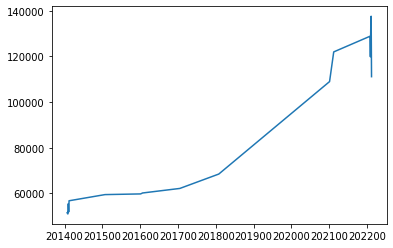

A13122002_110


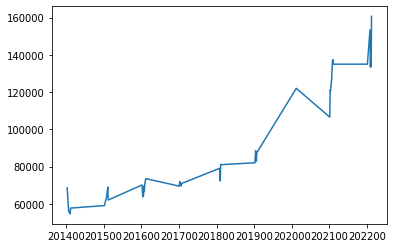

A13122002_120


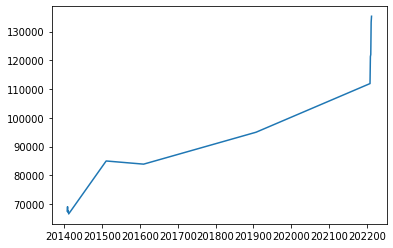

A13122002_130


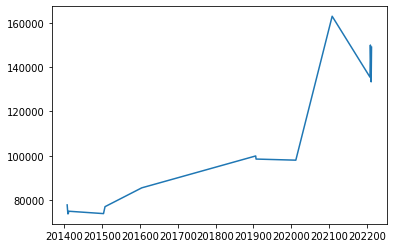

A13122002_180


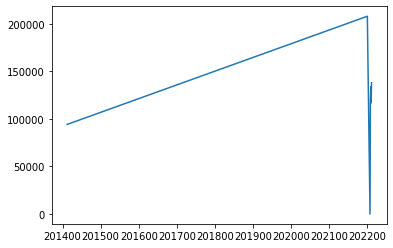

A13122002_190


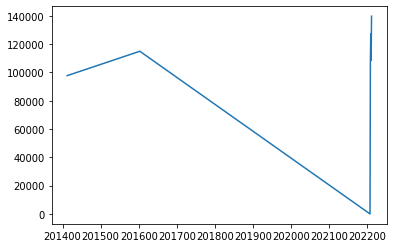

A13122002_60


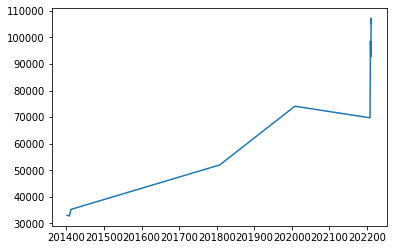

A13122002_70


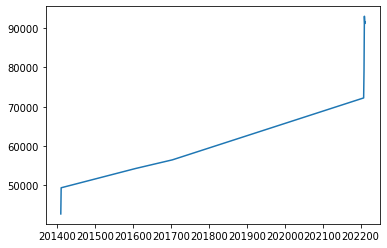

A13122002_80


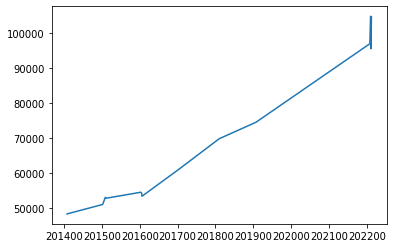

In [24]:
for i in gizun_code_areas:
    x = df_a['YYYYMM'][df_a['apart_code_area']==i]
    y = df_a['prices'][df_a['apart_code_area']==i]
    plt.plot(x,y)
    print(i)
    plt.show()

A15190705_80


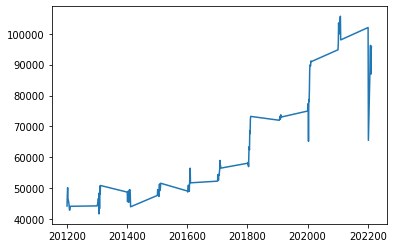

A15190705_110


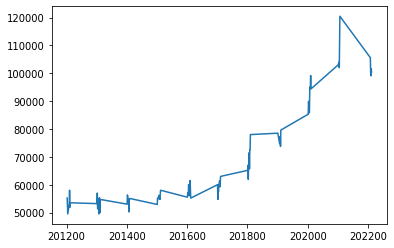

A15190705_60


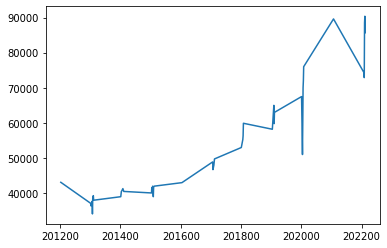

A15190705_140


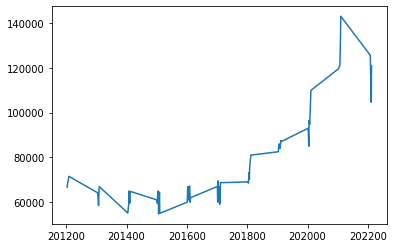

A13527014_140


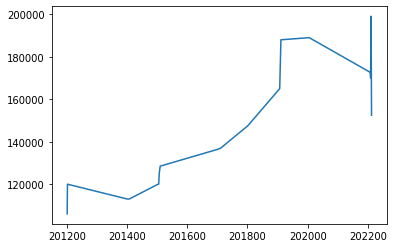

A13527014_50


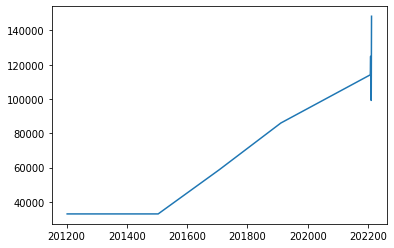

A13527014_130


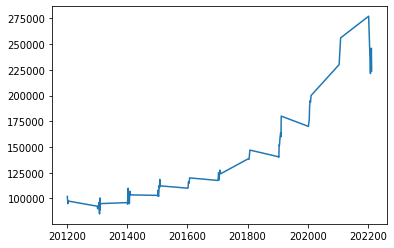

A13527014_170


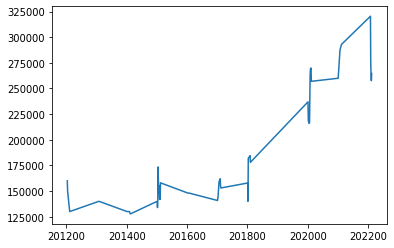

A13527014_180


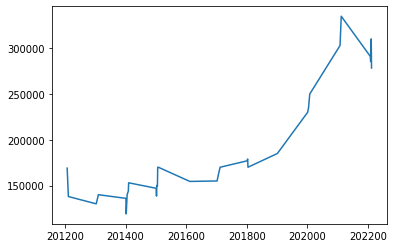

A13527014_80


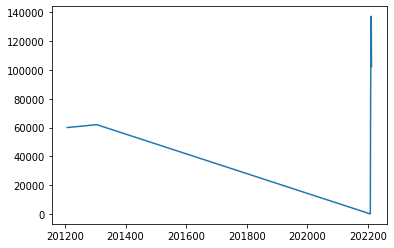

A13527014_150


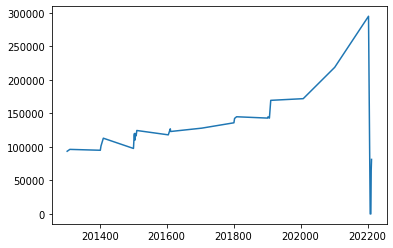

A13527014_40


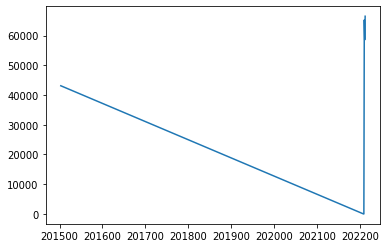

A13527014_120


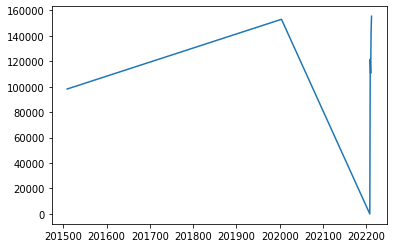

A13527014_70


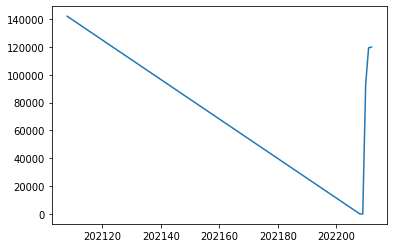

A13784907_140


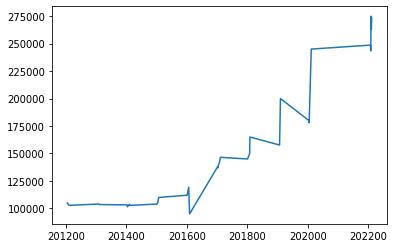

A13784907_110


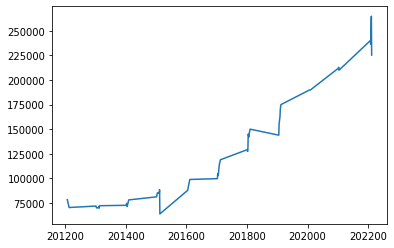

A13784907_180


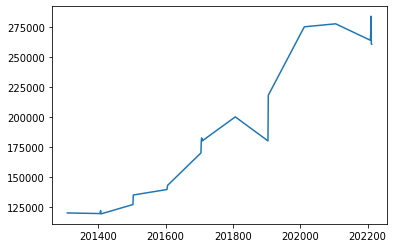

A13784907_100


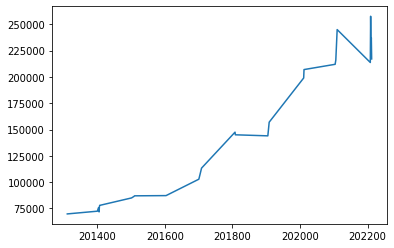

A13784907_170


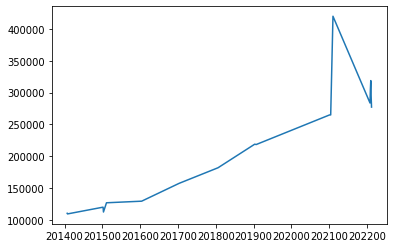

A14381415_70


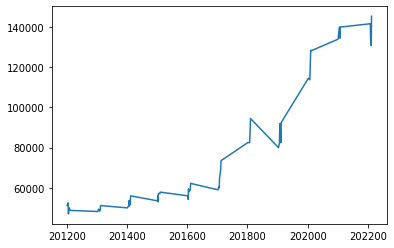

A14381415_80


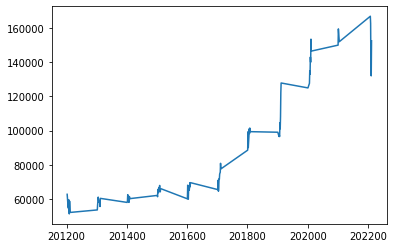

A14381415_60


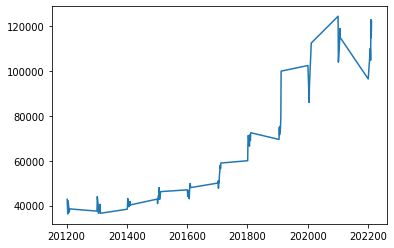

A10025633_80


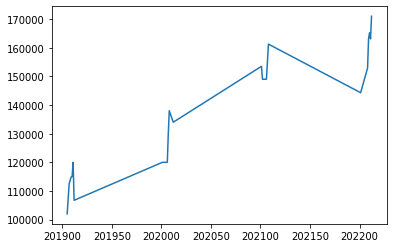

A10025633_70


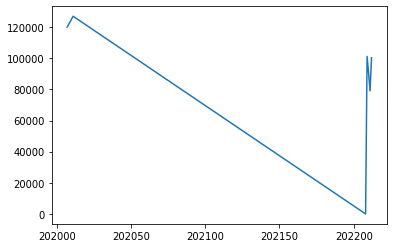

A10025633_60


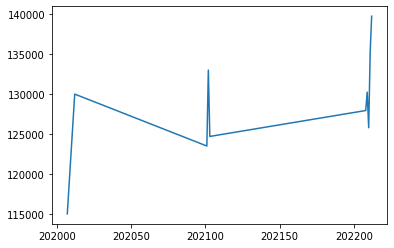

A10025633_100


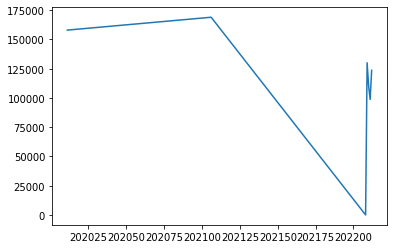

A15010306_60


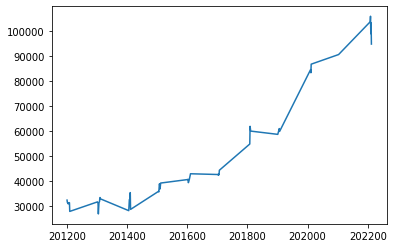

A15010306_130


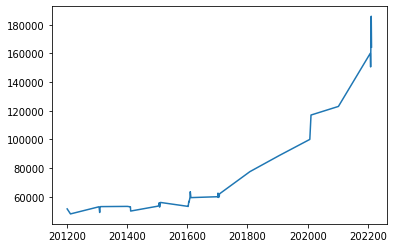

A15010306_80


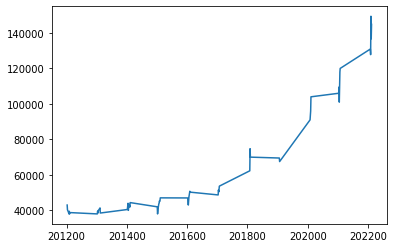

A15010306_70


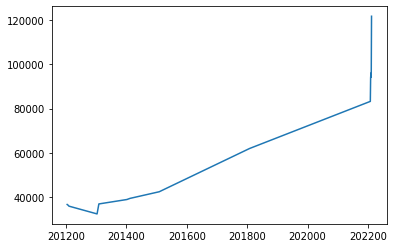

A10024258_100


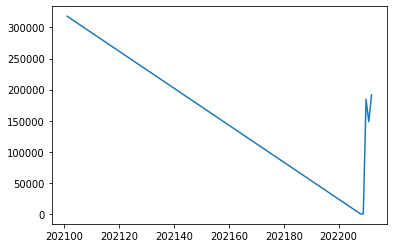

A10024258_80


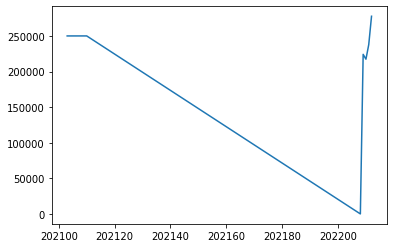

A10024258_120


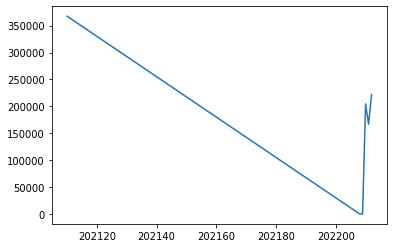

A15213003_80


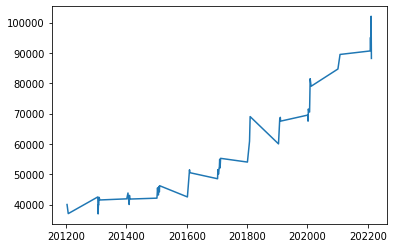

A15213003_110


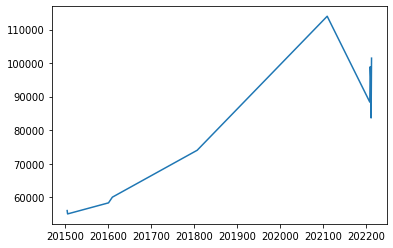

A13528102_60


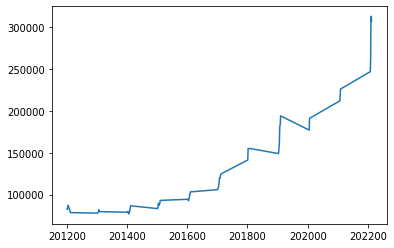

A13528102_150


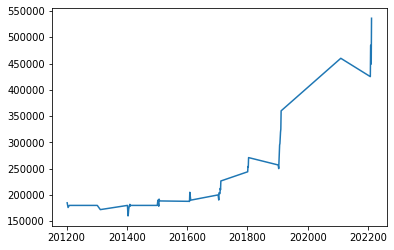

A13528102_110


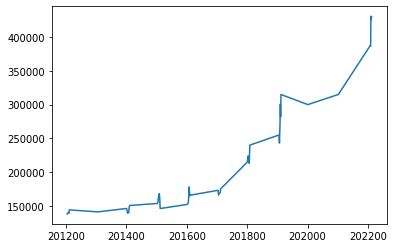

A13528102_120


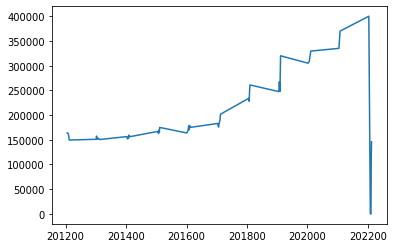

A13528102_80


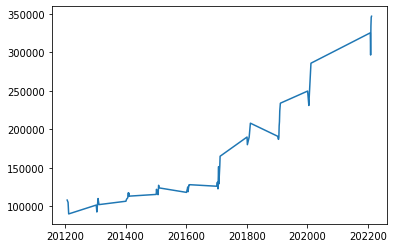

A13122002_60


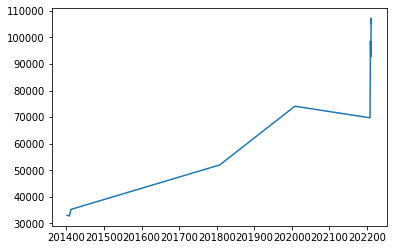

A13122002_110


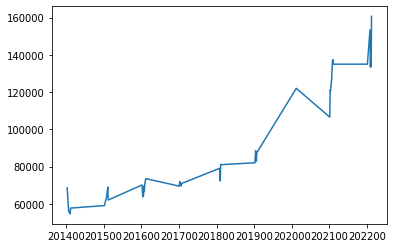

A13122002_100


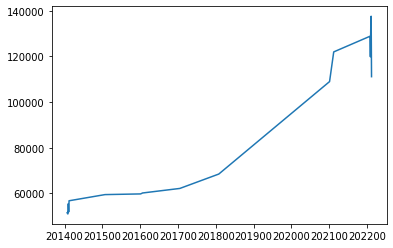

A13122002_80


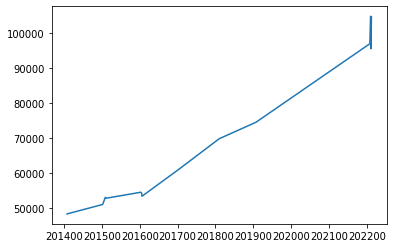

A13122002_120


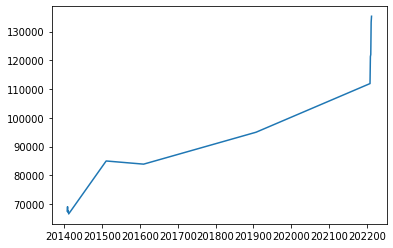

A13122002_130


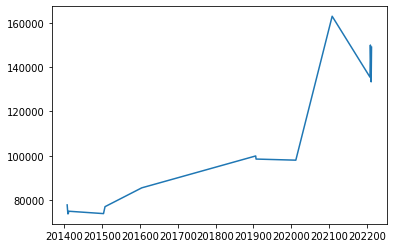

A13122002_70


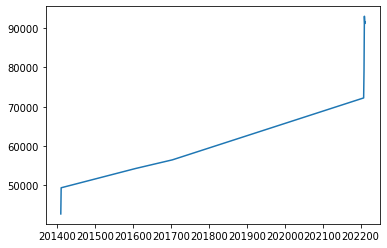

A13122002_190


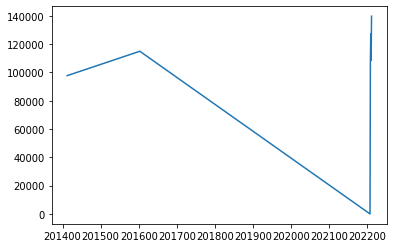

A13122002_180


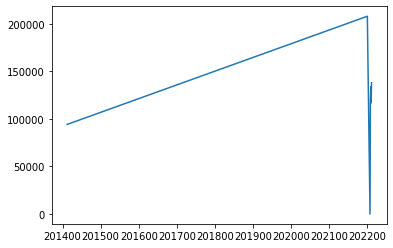

In [27]:
for k in test_codes:
    gizuns = df_a[df_a['apart_code_area'].str.contains(k)]['apart_code_area'].unique()    
    for i in gizuns:
        x = df_a['YYYYMM'][df_a['apart_code_area']==i]
        y = df_a['prices'][df_a['apart_code_area']==i]
        plt.plot(x,y)
        print(i)
        plt.show()

In [28]:
for k in test_codes:
    gizuns = df_a[df_a['apart_code_area'].str.contains(k)]['apart_code_area'].unique()    
    for i in gizuns:
        print(i)

A15190705_80
A15190705_110
A15190705_60
A15190705_140
A13527014_140
A13527014_50
A13527014_130
A13527014_170
A13527014_180
A13527014_80
A13527014_150
A13527014_40
A13527014_120
A13527014_70
A13784907_140
A13784907_110
A13784907_180
A13784907_100
A13784907_170
A14381415_70
A14381415_80
A14381415_60
A10025633_80
A10025633_70
A10025633_60
A10025633_100
A15010306_60
A15010306_130
A15010306_80
A15010306_70
A10024258_100
A10024258_80
A10024258_120
A15213003_80
A15213003_110
A13528102_60
A13528102_150
A13528102_110
A13528102_120
A13528102_80
A13122002_60
A13122002_110
A13122002_100
A13122002_80
A13122002_120
A13122002_130
A13122002_70
A13122002_190
A13122002_180


In [29]:
test_codes

['A15190705',
 'A13527014',
 'A13784907',
 'A14381415',
 'A10025633',
 'A15010306',
 'A10024258',
 'A15213003',
 'A13528102',
 'A13122002']